# Preprocess Data


In [195]:
raw.df <- read.csv("final_data_export_consensus.csv")



In [196]:
# install.packages("dplyr")
library("dplyr")
# install.packages("sjmisc")
library("sjmisc")
library("abind")
# for data manipulation with dplyr see: https://www.youtube.com/watch?v=Gvhkp-Yw65U
# for splitting 2 values in 1 cell see: https://www.youtube.com/watch?v=DiY8EqZDwoI at 3:17 (e.g. if 2 scales for 1 outcome)
# for joining 2 data frames see:        https://www.youtube.com/watch?v=DiY8EqZDwoI at 11:57


In [197]:
raw.df <- raw.df %>%
  filter(Study.design == "Passive RCT")


## Drop unimportant columns by name

### Remove column rages (first columns)

In [198]:
my.df <- raw.df %>%
  select(-Reviewer.Name:-Further.Information.inserted.in.Extraction.Form.)  # "-" indicates deleting these columns


### Remove single column names and repeating names with ascending numbers (table headlines)

In [199]:
cols.pop.char <- c()

for (time.point in 0:4){
  cols.pop.char <- append(cols.pop.char,
                          sprintf("Population.Characteristics..Time.Point.%d..",
                                  time.point
                                  )
                          )
}

cols.outc.t <- c()

for (outc in 1:7){
  for (t in 0:3){
    cols.outc.t <- append(cols.outc.t,
                          sprintf("Outcome.%d..Time.Point.%d..",
                                  outc, t
                                  )
                          )
  }
}

cols.quant.results <- c()

i <- 0
for (int.1 in 1:3){
  i <- i + 1
  if (i == 1){
    for (int.2 in 2:4){
      for (t in 1:3){
        cols.quant.results <- append(cols.quant.results,
                              sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                      int.1, int.2, t
                                      )
                              )
      }
    }
  } else if (i == 2){
    for (int.2 in 3:4){
      for (t in 1:3){
        cols.quant.results <- append(cols.quant.results,
                              sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                      int.1, int.2, t
                                      )
                              )
      }
    }
  } else if (i == 3){
    int.2 <- 4
    for (t in 1:3){
      cols.quant.results <- append(cols.quant.results,
                            sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                    int.1, int.2, t
                                    )
                            )
    }
  } else {
    print("i not = 1, 2, or 3")
  }
}

remove.cols <- c(cols.pop.char[],
                 "Dates.of.Measuring.Time.Points.",
                 "Between.Measuring.Time.Points..Duration.",
                 "Intervention.and.Comparisons.",
                 "Definition.of.Outcomes.",
                 "Measures.of.Outcomes.",
                 cols.outc.t[],
                 cols.quant.results[],
                 "Results.of.Key.Themes."
                 )

my.df <- my.df[, ! names(my.df) %in% remove.cols]


In [200]:
my.df

Covidence.. Study.ID                
1  4325        Ratanasiripong 2015     
2  4178        Sloan 2016              
3  3762        Nidich 2009             
4  3760        Barry 2019              
5  3759        Chen 2013               
6  3736        Warnecke 2011           
7  3076        Gupta 2020              
8  2925        Johnson-Waddell 2018    
9  2864        Plummer 2018            
10 2574        Janowiak 1994           
11 2416        Oman 2007               
12 2267        Weytens 2014            
13 2201        Bonamo 2015             
14 2075        Smith 2021              
15 1897        Wang 2021               
16 1889        Fish 2019               
17 1737        Siembor 2018            
18 1582        Lee 2018                
19 1574        Bultas 2021             
20 1469        Huberty 2019            
21 1416        Tanner 2009             
22 1329        deGrace 1976            
23 1322        Messer 2016             
24 1259        Vasiliauskas 2013       
25 1225        Nolan 2020              
26 1159        Dorais 2021             
27  361        Toole 2016              
28  122        Schulte-Frankenfeld 2021
   Title                                                                                                                                                                                            
1  Stress and Anxiety Management in Nursing Students: Biofeedback and Mindfulness Meditation                                                                                                        
2  Self-perceived stress of undergraduate students before and after participation in a breathing meditation intervention: A mixed methods study                                                     
3  A randomized controlled trial on effects of the Transcendental Meditation program on blood pressure, psychological distress, and coping in young adults                                          
4  A randomized controlled trial of the effects of mindfulness practice on doctoral candidate psychological status                                                                                  
5  A randomized controlled trial of the effects of brief mindfulness meditation on anxiety symptoms and systolic blood pressure in Chinese nursing students                                         
6  A randomised controlled trial of the effects of mindfulness practice on medical student stress levels                                                                                            
7  Mindfulness, mindful consumption, and life satisfaction An experiment with higher education students                                                                                             
8  Mindfulness meditation's effect on college/university students' mindfulness and transformational leadership                                                                                      
9  Mindfulness in a Graduate Nursing Curriculum: A Randomized Controlled Study                                                                                                                      
10 Meditation and college students' self-actualization and rated stress                                                                                                                             
11 Learning from spiritual models and meditation: A randomized evaluation of a college course                                                                                                       
12 An integrative theory-driven positive emotion regulation intervention                                                                                                                            
13 The influence of a brief mindfulness exercise on encoding of novel words in female college students                                                                                              
14 Impact of App-Delivered Mindfulness Meditation on Functional Connectivity, Mental 

## Create arrays, data frame lists, and data frames from Covidence tables

### Set basic parameters 

In [201]:
nm.placeholder <- -999  # placeholder for values marked as nm (not mentioned)

flag.x.s.r <- 2
  # x.s.r = exact value (0), mean s (1), or mean r (2)
  # flag.x.s.r = 2 --> include all
  # flag.x.s.r = 1 --> only include mean s and exact values
  # flag.x.s.r = 0 --> include only exact vaules

study.no <- length(my.df[,"Study.ID"])


### Functions
#### Checking for digits and characters


In [202]:
# function returning TRUE if string contains no characters but digits instead
no.char.but.digit.inside <- function(value){
  !(str_contains(value, letters, logic = "OR") |
  str_contains(value, LETTERS, logic = "OR")) &
  grepl("\\d", value)
}

# function returning TRUE if string contains characters
char.inside <- function(value){
  str_contains(value, letters, logic = "OR") |
  str_contains(value, LETTERS, logic = "OR")
}



#### For mean values


In [203]:
# extracts mean r and mean s values as double
get.all.means <- function(value, study.name = ""){
  if (substr(value, nchar(value) - nchar("mean r") + 1, nchar(value)) == "mean r"){
      # value contains "mean r" at the end
    extracted.value <- as.double(sub(" mean r.*", "", value))
        # extracts anything before " mean r" as double                 
  } else if (substr(value, nchar(value) - nchar("mean s") + 1, nchar(value)) == "mean s"){
    extracted.value <- as.double(sub(" mean s.*", "", value))
  } else if (substr(value, nchar(value) - nchar("mean") + 1, nchar(value)) == "mean"){
    extracted.value <- NA
    print(study.name)
    cat("value ", value, " not added because mean only")
    cat("\n")
  } else {
    extracted.value <- value
  }
  extracted.value
}

# extracts mean s only as double
get.mean.s.only <- function(value){
    if (grepl("mean s", value)){
    extracted.value <- as.double(sub(" mean s.*", "", value))
  } else if (grepl("mean r", value)){
    extracted.value <- NA
    cat("value ", value, " not added because mean r")
    cat("\n")
  } else if (grepl("mean", value)){
    extracted.value <- NA
    cat("value ", value, " not added because mean only")
    cat("\n")
  } else {
    extracted.value <- value
  }
  extracted.value
}



#### Convert value from nm, NA, digit, or char


In [204]:
convert.value <- function(value, missing.value.placeholder = nm.placeholder, only.double = TRUE, exclude.greater.than = FALSE, study.name = "insert study name"){
  na.value <- FALSE
  if (is.na(value)){
    na.value <- TRUE
  }
  if (na.value == TRUE){
    extracted.value <- NA
  } else {
    value <- as.character(value)

# special cases
    if (value == "nm"){
      extracted.value <- missing.value.placeholder
    } else if (value == ""){
      extracted.value <- NA
    } else if (value == "^"){
      extracted.value <- value 
    } else if (grepl("<", value)){
      extracted.value <- as.double(sub(".*<", "", value))
        # extracts value after "<" as double 
    } else if (grepl(">", value)){
      if (exclude.greater.than == TRUE){
        extracted.value <- NA
      } else if (exclude.greater.than == FALSE){
        extracted.value <- as.double(sub(".*>", "", value))
        # extracts value after ">" as double
      } else {
        print("set 'exclude.greater.than' to 'FALSE' or 'TRUE'")
      }

# no.char.but.digit
    } else if (no.char.but.digit.inside(value)){
      if (grepl(",", value)){
        cat("decimal separator replaced with point in ", value)
        extracted.value <- as.double(sub(",", ".", value))
          # sub(a, b, value) replaces a with b in value
      } else if (grepl("-", value)){
        # like "0 - 40"
        extracted.value <- value
      } else {
        extracted.value <- as.double(value) 
      }

# char
    } else if (char.inside(value)){
      if (flag.x.s.r == 2){
        extracted.value <- get.all.means(value, study.name)
      } else if (flag.x.s.r == 1){
        extracted.value <- get.mean.s.only(value)
      } else if ((flag.x.s.r == 0) & !(grepl("mean r", value) | grepl("mean s", value))){
        extracted.value <- NA
        if (grepl("mean", value)){
          cat("value not added because mean only: ", value)
          cat("\n\n")
        }
      } else {
        if (only.double == TRUE){
          extracted.value <- NA
          cat("unknown case with char inside: ", value)
          cat("\n\n")
        } else {
          extracted.value <- value
        }
      }
    } else {
      cat("unknown case: ", value)
      cat("\n")
    }
  }
  extracted.value
}



#### Check if multiple commas are present in string


In [205]:
multiple.commas.present <- function(input.string){
  multiple.commas.present <- FALSE
  comma.count <- 0

  iterable.string <- tryCatch(
    {
      strsplit(input.string, "")[[1]]
        # strsplit(input.string, "")[[1]] makes string iterable
        # "try" part
    },
    error=function(cond) {
      message(paste("Error of multiple.commas.present() for input:", input.string, "| Type:", class(input.string)))
      message(cond)
      return("")
      # "except" part for errors
    },
    warning=function(cond) {
      message(paste("Warning of multiple.commas.present() for input:", input.string, "| Type:", class(input.string)))
      message(cond)
      return("")
      # "except" part for warnings
    }
  )
    # see following link for exception handling: https://stackoverflow.com/questions/12193779/how-to-write-trycatch-in-r

  for (i in iterable.string){
    if (i == ","){
      comma.count <- comma.count + 1
    }
  }
  if (comma.count > 1){
    multiple.commas.present <- TRUE
  }
  multiple.commas.present
}



#### For arrays


In [206]:
clean.and.shape.data.to.array <- function(
  my.df, start, end, dims, dimname.list, nm.placeholder, flag.x.s.r, study.no, exclude.greater.than = FALSE
  ){
  my.array <- array(rep(NA),
                    dim = dims,
                    dimnames = dimname.list
                    )
  my.data <- my.df %>%
    select(start:end)
  
  if (length(dims) == 6){
    for (study in 1:study.no){
      my.data.col.no = 1
      for (dim.4.elmnt in 1:dims[4]){
        for (mtrx in 1:dims[3]){
          for (row in 1:dims[1]){
            for (col in 1:dims[2]){
              value <- my.data[study, my.data.col.no]
              my.data.col.no <- my.data.col.no + 1
              if (grepl(",", value)){
                if (!multiple.commas.present(value)){
                  value.before.comma <- sub(",.*", "", value)
                    # extracts anything before "," as double
                  my.array[row, col, mtrx, dim.4.elmnt, 1, study] <- convert.value(
                    value.before.comma, nm.placeholder, exclude.greater.than = exclude.greater.than
                    )
                  value.after.comma <- sub(".*,", "", value)
                    # extracts anything after "," as double
                  my.array[row, col, mtrx, dim.4.elmnt, 2, study] <- convert.value(
                    value.after.comma, nm.placeholder, exclude.greater.than = exclude.greater.than
                    )
                } else {
                    cat(value, "has multiple commas, find solution")
                  }
              } else {
                my.array[row, col, mtrx, dim.4.elmnt, 1, study] <- convert.value(
                  value, nm.placeholder, exclude.greater.than = exclude.greater.than
                  )
              }
            }
          }
        }
      }
    }
  } else if (length(dims) <= 4){
    for (study in 1:study.no){
      my.data.col.no = 1
      for (mtrx in 1:dims[3]){
        for (row in 1:dims[1]){
          for (col in 1:dims[2]){
            value <- my.data[study, my.data.col.no]
            my.data.col.no <- my.data.col.no + 1
            my.array[row, col, mtrx, study] <- convert.value(
              value, nm.placeholder, exclude.greater.than = exclude.greater.than
              )
          }
        }
      }
    }
  } else {
    print("unknwon dimesion")
  }
  my.array
}



#### For data frame lists


In [207]:
# create data frames out of 2D Tables (with rows and cols swapped)
clean.data.to.df.list.swap <- function(
  my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = FALSE
  ){
  study.df <- data.frame(matrix(
    rep(NA),
    nrow = dims[1],
    ncol = dims[2]
  ))
  row.names(study.df) <- dimname.list[[1]]
  colnames(study.df) <- dimname.list[[2]]
  
  # create list of NA data frames of preferred shape
  study.df.list <- list()
  for (i in 1:length(study.names)){
    study.df.list <- append(study.df.list, list(study.df), 0)
  }
  names(study.df.list) <- study.names
  
  my.data <- my.df %>%
    select(start:end)
  
  # vector of my.data.col.no to swapped rows and cols of Covidence output
  my.data.col.no.swapped <- c()
  i <- 0
  j <- 1
  for (k in 1:dims[1]){
    i <- 0
    for (l in 1:dims[2]){
      my.data.col.no.swapped <- append(my.data.col.no.swapped, i * dims[1] + j)
      i <- i + 1
    }
    j <- j + 1 
  }
  # dims[1] = rows new, cols old
  # dims[2] = cols new, rows old
  
  # e.g., filling pattern for old 4 x 7 and new 7 x 4 data frame 
  ## 1, dims[1]+1, 2*dims[1]+1, 3*dims[1]+1, 4*dims[1]+1, 5*dims[1]+1, 6*dims[1]+1,
  ## 2, dims[1]+2, 2*dims[1]+2, 3*dims[1]+2, 4*dims[1]+2, 5*dims[1]+2, 6*dims[1]+2,
  ## x, x, x, x, x, x, x,
  ## x, x, x, x, x, x, x
  
  for (study in 1:study.no){
    m <- 1
    for (row in 1:dims[1]){
      for (col in 1:dims[2]){
        value <- my.data[study, my.data.col.no.swapped[m]]
        m <- m + 1

        if (check.multiple.commas & is.character(value)){
          if (multiple.commas.present(value)){
            cat("multiple commas in value, find solution:\n", value, "\n")
          }
        }
        
        study.df.list[[study]][row, col] <- convert.value(
          value, nm.placeholder, only.double = FALSE, study.name = study.names[study]
          )
      }
    }
  }
  study.df.list
}


In [208]:
# create data frames out of 2D Tables
clean.data.to.df.list <- function(
  my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = FALSE
  ){
  study.df <- data.frame(matrix(
    rep(NA),
    nrow = dims[1],
    ncol = dims[2]
  ))
  row.names(study.df) <- dimname.list[[1]]
  colnames(study.df) <- dimname.list[[2]]
  
  # create list of NA data frames of preferred shape
  study.df.list <- list()
  for (i in 1:length(study.names)){
    study.df.list <- append(study.df.list, list(study.df), 0)
  }
  names(study.df.list) <- study.names
  
  my.data <- my.df %>%
    select(start:end)
  
  for (study in 1:study.no){
    my.data.col.no <- 1
    for (row in 1:dims[1]){
      for (col in 1:dims[2]){
        value <- my.data[study, my.data.col.no]
        my.data.col.no <- my.data.col.no + 1
        
        if (check.multiple.commas & is.character(value)){
          if (multiple.commas.present(value)){
            cat("multiple commas in value, find solution:\n", value, "\n\n")
          }
        }
        tryCatch(
          {
            study.df.list[[study]][row, col] <- convert.value(
              value, nm.placeholder, only.double = FALSE
              )
          },
          error=function(e){
            cat("\n")
            print(study.names[study])
            print(value)
            print(e)
            cat("\n")
          },
          warning=function(w){
            cat("\n")
            print(study.names[study])
            print(value)
            print(w)
            cat("\n")
          }
        )
      }
    }
  }
  study.df.list
}



#### Print array without NA values


In [209]:
print.array.not.na <- function(input.array){
  if (length(dim(input.array)) == 6){
    for (dim.6.element in 1:dim(input.array)[6]){
      cat("\n###### ", dimnames(input.array)[[6]][dim.6.element], " ######")
      for (dim.5.element in 1:dim(input.array)[5]){
        cat("\n### ", dimnames(input.array)[[5]][dim.5.element], " ###")
        for (dim.4.element in 1:dim(input.array)[4]){
          cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
          for (mtrx in 1:dim(input.array)[3]){
            mtrx.is.na <- TRUE
            for (col in 1:dim(input.array)[2]){
              for (row in 1:dim(input.array)[1]){
                if (!is.na(input.array[
                  row, col, mtrx, dim.4.element, dim.5.element, dim.6.element
                                      ]
                          )
                   ){
                     mtrx.is.na <- FALSE
                }
              }
            }
            if (mtrx.is.na == FALSE){
              print(dimnames(input.array)[[3]][mtrx])
              print(input.array[,,mtrx, dim.4.element, dim.5.element, dim.6.element])
              cat("\n")
            }
          } 
        }
      }
    }
  } else if (length(dim(input.array)) == 5){
    for (dim.5.element in 1:dim(input.array)[5]){
      cat("\n### ", dimnames(input.array)[[5]][dim.5.element], " ###")
      for (dim.4.element in 1:dim(input.array)[4]){
        cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
        for (mtrx in 1:dim(input.array)[3]){
          mtrx.is.na <- TRUE
          for (col in 1:dim(input.array)[2]){
            for (row in 1:dim(input.array)[1]){
              if (!is.na(input.array[
                row, col, mtrx, dim.4.element, dim.5.element
                                    ]
                        )
                  ){
                    mtrx.is.na <- FALSE
              }
            }
          }
          if (mtrx.is.na == FALSE){
            print(dimnames(input.array)[[3]][mtrx])
            print(input.array[,,mtrx, dim.4.element, dim.5.element])
            cat("\n")
          }
        } 
      }
    } 
  } else if (length(dim(input.array)) == 4){
    for (dim.4.element in 1:dim(input.array)[4]){
      cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
      for (mtrx in 1:dim(input.array)[3]){
        mtrx.is.na <- TRUE
        for (col in 1:dim(input.array)[2]){
          for (row in 1:dim(input.array)[1]){
            if (!is.na(input.array[
              row, col, mtrx, dim.4.element
                                  ]
                      )
                ){
                  mtrx.is.na <- FALSE
            }
          }
        }
        if (mtrx.is.na == FALSE){
          print(dimnames(input.array)[[3]][mtrx])
          print(input.array[,,mtrx, dim.4.element])
          cat("\n")
        }
      } 
    }
  } else if (length(dim(input.array)) == 3){
    for (mtrx in 1:dim(input.array)[3]){
      mtrx.is.na <- TRUE
      for (col in 1:dim(input.array)[2]){
        for (row in 1:dim(input.array)[1]){
          if (!is.na(input.array[
            row, col, mtrx
                                ]
                    )
              ){
                mtrx.is.na <- FALSE
          }
        }
      }
      if (mtrx.is.na == FALSE){
        print(dimnames(input.array)[[3]][mtrx])
        print(input.array[,,mtrx])
        cat("\n")
      }
    }
  } else {
    print("unknown case")
  }
}


#### Print df list without NA values

In [210]:
# # does not work yet
# print.df.list.not.na <- function(df.list, nm.placeholder){
#   i = 1
#   for (df in df.list){
#     all.na.flag = TRUE
#     for (row in 1:nrow(df)){
#       for (col in 1:ncol(df)){
#         if (
#           !(
#             is.na(df[row, col]) |
#             df[row, col] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#           )
#         ){
#           all.na.flag = FALSE
#         }
#       }
#     }
#     if (all.na.flag){
#       print(names(df.list)[i])
#       print(df)
#       cat("\n")
#     }
#     i = i + 1
#   }
# }


#### Search in df list


In [211]:
search.df.list <- function(df.list, search.string){
  found <- FALSE
  for (i in 1:length(df.list)){
    for (row in 1:nrow(df.list[[i]])){
      for (col in 1:ncol(df.list[[i]])){
        cell.string <- as.character(df.list[[i]][row,col])
        if (!is.character(search.string)){
          print("search term has to be character")
        }
        if (grepl(search.string, cell.string)){
          cat(
            "search term found in:\ndf:", names(df.list)[i], "\nrow:",
            rownames(df.list[[i]])[row], "\ncol:", colnames(df.list[[i]])[col],
            "\nvalue:", df.list[[i]][row, col], "\n\n"
            )
          found <- TRUE
        }
      }
    }
  }
  if (!found){
    print("serach string not found")
  }
}


### Array
#### Population Characteristics


In [212]:
dims <- c(4, 5, 4, study.no)

dimname.list <- list(c("No.Participants", "Mean.Age", "No.Females", "No.Males"),
                     c("Intervention.1", "Intervention.2", "Intervention.3", "Intervention.4", "Over.All"),
                     c("T0", "T1", "T2", "T3"),
                     my.df[,"Study.ID"]
                     )

start <- "Number.of.Participants.Intervention.1.T0"
end <- "Number.of.Males.Over.All.T3"

population.characteristics.array <- clean.and.shape.data.to.array(
  my.df, start, end, dims, dimname.list, nm.placeholder, flag.x.s.r, study.no
)

my.df <- my.df %>%
  select(-Number.of.Participants.Intervention.1.T0:-Number.of.Males.Over.All.T3)

print.array.not.na(population.characteristics.array)



# Ratanasiripong 2015 
[1] "T0"
                Intervention.1 Intervention.2 Intervention.3 Intervention.4
No.Participants             29             29             NA             31
Mean.Age                    NA             NA             NA             NA
No.Females                  NA             NA             NA             NA
No.Males                    NA             NA             NA             NA
                Over.All
No.Participants    89.00
Mean.Age           19.27
No.Females       -999.00
No.Males         -999.00


# Sloan 2016 
[1] "T0"
                Intervention.1 Intervention.2 Intervention.3 Intervention.4
No.Participants             22             NA             NA             20
Mean.Age                    NA             NA             NA             NA
No.Females                  NA             NA             NA             NA
No.Males                    NA             NA             NA             NA
                Over.All
No.Participants       42
Mean.Ag


#### Results Descriptive


In [213]:
dims <- c(4, 3, 4, 7, 2, study.no)

dimname.list <- list(c("Intervention.1", "Intervention.2", "Intervention.3", "Control"),
                     c("Mean", "SD", "n"),
                     c("T0", "T1", "T2", "T3"),
                     c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("Scale.1", "Scale.2"),
                     my.df[,"Study.ID"]
                     )

start <- "Intervention.1.Mean.O1T0"
end <- "Control.or.Intervention.4.n.in.case.of.period.O7T3"

results.descriptive.array <- clean.and.shape.data.to.array(
    my.df, start, end, dims, dimname.list, nm.placeholder, flag.x.s.r, study.no
)

print.array.not.na(results.descriptive.array)

my.df <- my.df %>%
  select(-Intervention.1.Mean.O1T0:-Control.or.Intervention.4.n.in.case.of.period.O7T3)



######  Ratanasiripong 2015  ######
###  Scale.1  ###
# Outcome.1 
[1] "T0"
                Mean   SD  n
Intervention.1    NA   NA NA
Intervention.2 17.24 4.16 NA
Intervention.3    NA   NA NA
Control        17.29 3.50 NA

[1] "T1"
                Mean   SD  n
Intervention.1    NA   NA NA
Intervention.2 14.90 3.44 NA
Intervention.3    NA   NA NA
Control        16.74 4.71 NA


# Outcome.2 
[1] "T0"
                Mean   SD  n
Intervention.1    NA   NA NA
Intervention.2 25.45 7.80 NA
Intervention.3    NA   NA NA
Control        23.74 7.72 NA

[1] "T1"
                Mean   SD  n
Intervention.1    NA   NA NA
Intervention.2 21.28 6.95 NA
Intervention.3    NA   NA NA
Control        24.74 9.91 NA


# Outcome.3 

# Outcome.4 

# Outcome.5 

# Outcome.6 

# Outcome.7 

###  Scale.2  ###
# Outcome.1 

# Outcome.2 

# Outcome.3 

# Outcome.4 

# Outcome.5 

# Outcome.6 

# Outcome.7 

######  Sloan 2016  ######
###  Scale.1  ###
# Outcome.1 
[1] "T0"
                  Mean      SD  n
Interventi


#### Results Quantitative


In [214]:
dims <- c(7, 3, 3, 6, 2, study.no)

dimname.list <- list(c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("P.Value", "Effect.Size", "Effect.Size.CI"),
                     c("T1", "T2", "T3"),
                     c("Int1.X.Int2", "Int1.X.Int3", "Int1.X.Int4", "Int2.X.Int3", "Int2.X.Int4", "Int3.X.Int4"),
                     c("Scale.1", "Scale.2"),
                     my.df[,"Study.ID"]
                     )

start <- "Outcome.1.P.Value.1x2T1"
end <- "Outcome.7.Confidence.Interval.of.Effect.Size.3x4T3"

results.quantitative.array <- clean.and.shape.data.to.array(
  my.df, start, end, dims, dimname.list, nm.placeholder, flag.x.s.r, study.no,
  exclude.greater.than = TRUE  # <-- sets p.values > 0.05 to NA
)

print.array.not.na(results.quantitative.array)

my.df <- my.df %>%
  select(-Outcome.1.P.Value.1x2T1:-Outcome.7.Confidence.Interval.of.Effect.Size.3x4T3)



######  Ratanasiripong 2015  ######
###  Scale.1  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 
[1] "T1"
          P.Value Effect.Size Effect.Size.CI
Outcome.1   0.001        0.33             NA
Outcome.2   0.001        0.34             NA
Outcome.3      NA          NA             NA
Outcome.4      NA          NA             NA
Outcome.5      NA          NA             NA
Outcome.6      NA          NA             NA
Outcome.7      NA          NA             NA


# Int2.X.Int3 

# Int2.X.Int4 

# Int3.X.Int4 

###  Scale.2  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 

# Int2.X.Int3 

# Int2.X.Int4 

# Int3.X.Int4 

######  Sloan 2016  ######
###  Scale.1  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 
[1] "T1"
          P.Value Effect.Size Effect.Size.CI
Outcome.1   0.001       0.261             NA
Outcome.2      NA          NA             NA
Outcome.3      NA          NA             NA
Outcome.4      NA          NA             NA
Outcome.5      NA          NA          

### Data frame lists
#### Intervention Comparison


In [215]:
# correct input mistakes
study.names <- my.df[,"Study.ID"]

if ("0.99 mean" == my.df[which(study.names =="Sloan 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Sloan 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "0.99 mean s"
}
  # comment: Frequency: "Among the group, 20 participants attended all eight sessions and one attended seven sessions" --> 20   ×   (8   ×   1   +   1   ×   7   ×   1) / 21 / 8 = 0.99

if ("36.67 mean" == my.df[which(study.names =="Weytens 2014"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.2"]){
  my.df[which(study.names =="Weytens 2014"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.2"] <- NA
}
  # comment: "sessions that were twohours long" "group participants were asked to practice 20 minutes of meditation at home, at least five days a week" --> 120 min + 5*20 min / 6 Sessions = 36.67 min average
  # --> meditation frequency was predifined but not measured

if ("3.79 during intervention, 2.04 during follow-up mean" == my.df[which(study.names =="Huberty 2019"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Huberty 2019"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "37.9 mean s"
}
  # comment: - frequency: "Participants in the intervention group engaged in an average of 37.9 (SD 30.5) minutes of meditation per week over the course of the 8-week study." "Approximately one-third (14/41, 34%) of intervention participants continued to meditate during the follow-up period (12 weeks from baseline) and spent an average of 20.4 (SD 23.9) minutes meditating." 37.9/10, 20.04/10--> 3.79 and 2.04 times per week
  # --> mistake in calculation only 37.9 min per week during intervention is interesting for meta-regression

if ("4.19 mean" == my.df[which(study.names =="Nolan 2020"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Nolan 2020"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "4.19 mean s"
}
  # comment: Frequency (compare tab. 10 & 12): 10   ×   10   +   9   +   2   ×   8   +   3   ×   7   +   6   ×   6   +   2   ×   5   +   5   ×   4   +   3   ×   2   +   2   ×   2 = 222 sessions completed from tab. 10 222   +   10   ×   2   +   2   +   3   ×   1 ( tab. 12) = 247 Mean practiced sessions = 247 / 33 paricipants Mean practiced sessions / total duration (12.5) * 7 week days = 4.19 sessions per week 

if ("12.5 mean" == my.df[which(study.names =="Nolan 2020"), "Total.Duration.of.Intervention.in.Days.Intervention.1"]){
  my.df[which(study.names =="Nolan 2020"), "Total.Duration.of.Intervention.in.Days.Intervention.1"] <- NA
}
  # comment: "10-15-day" --> 12.5 days duration
  # --> higher range than 30% of the higher value (15) --> NA

if ("2.5 mean" == my.df[which(study.names =="Toole 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Toole 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "2.5 mean s"
}
  # comment: "The mean number of days participants in the intervention group listened to the podcasts (excluding Visit 1) was 1.5" --> Frequncy = 1 + 1.5 = 2.5

if ("11.19 mean" == my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.1"]){
  my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.1"] <- "11.19 mean s"
}
  # comment: mean duration of single session: total minutes of all programs (638) / total number of all sessions (57) = 11.19 see: https://iaap-journals.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2Faphw.12328&file=aphw12328-sup-0001-App-Based+Mindfulness+-+Supplements.docx

if ("2.82 mean" == my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "2.82 mean s"
}
  # comment: Mean Frequency: mean of "sessions" column at https://osf.io/wujsg/ (22.53) / 8 weeks = 2.82

In [216]:
dims <- c(4, 7)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Intervention.1", "Intervention.2", "Intervention.3", "Control"),
                     c("Name", "Short.Description", "Delivery.Mode", "Meditation.App", "Sessions.Duration.in.minutes",
                       "Frequency.in.times.per.week", "Total.Duration.in.Days")
                     )
start <- "Name.Intervention.1"
end <- "Total.Duration.of.Intervention.in.Days.Control.or.Intervention.4"

intervention.comparisons.df.list <- clean.data.to.df.list.swap(
 my.df, start, end, dims, study.names, dimname.list
)

my.df <- my.df %>%
  select(-Name.Intervention.1:-Total.Duration.of.Intervention.in.Days.Control.or.Intervention.4)

intervention.comparisons.df.list


$`Ratanasiripong 2015`
                                 Name
Intervention.1                   <NA>
Intervention.2 mindfulness meditation
Intervention.3                   <NA>
Control               no intervention
                                                                                                                                Short.Description
Intervention.1                                                                                                                               <NA>
Intervention.2 "Participants in the mindfulness \nmeditation group also received two trainings; however, they \nwere taught Vipassana meditation"
Intervention.3                                                                                                                               <NA>
Control                                                                                                                                      <NA>
                                                                           Delivery.Mode
Intervention.1                                                                      <NA>
Intervention.2 Synchronous guiding in presence (e.g. seminar), Self-conducted meditation
Intervention.3                                                                      <NA>
Control                                                                             <NA>
               Meditation.App Sessions.Duration.in.minutes
Intervention.1             NA                           NA
Intervention.2             NA                         -999
Intervention.3             NA                           NA
Control                    NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days
Intervention.1                          NA                     NA
Intervention.2                        -999                     28
Intervention.3                          NA                     NA
Control                                 NA                     NA

$`Sloan 2016`
                               Name
Intervention.1 breathing meditation
Intervention.2                 <NA>
Intervention.3                 <NA>
Control             no intervention
                                          Short.Description
Intervention.1 "guided audio-recorded breathing meditation"
Intervention.2                                         <NA>
Intervention.3                                         <NA>
Control                                                <NA>
                                                                      Delivery.Mode
Intervention.1 Asynchronous guiding by a recorded voice (e.g. App), audio recording
Intervention.2                                                                 <NA>
Intervention.3                                                                 <NA>
Control                                                                        <NA>
               Meditation.App Sessions.Duration.in.minutes
Intervention.1             NA                            9
Intervention.2             NA                           NA
Intervention.3             NA                           NA
Control                    NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days
Intervention.1                        0.99                     56
Intervention.2                          NA                     NA
Intervention.3                          NA                     NA
Control                                 NA                     NA

$`Nidich 2009`
                                        Name
Intervention.1 Trancendental Meditation (TM)
Intervention.2                          <NA>
Intervention.3                          <NA>
Control                    wait-list control
                                                                                                                                                                                                              


#### Measure of Outcomes


In [217]:
dims <- c(7, 3)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("Measures.Name", "Start.and.End.Point", "High.or.low.means.resilient")
                     )
start <- "Outcome.1.Scale.s.or.other.Measure.s.Name"
end <- "Outcome.7.High.or.low.means.resilient"

outcome.measures.df.list <- clean.data.to.df.list(
 my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = TRUE
)

my.df <- my.df %>%
  select(-Outcome.1.Scale.s.or.other.Measure.s.Name:-Outcome.7.High.or.low.means.resilient)

outcome.measures.df.list


multiple commas in value, find solution:
 Perceived Stress Scale (PSS; Cohen, Kamarck, & Mermelstein, 1983) 

multiple commas in value, find solution:
 State Anxiety Scale from the State–Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983) 

multiple commas in value, find solution:
 Depression, Anxiety
and Stress Scale (DASS) 26, Perceived Stress Scale
(PSS)27,28 

decimal separator replaced with point in  0 - 40, 0 - 42
[1] "Warnecke 2011"
[1] "0 - 40, 0 - 42"
<simpleWarning in convert.value(value, nm.placeholder, only.double = FALSE): NAs introduced by coercion>

multiple commas in value, find solution:
 Cognitive and Affective Mindfulness Scale–Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007) 

multiple commas in value, find solution:
 Perceived Stress Scale (PSS-10; Cohen, Kamarck, & Mermelstein, 1983) 

multiple commas in value, find solution:
 The Perceived Stress Scale (PSS; Cohen, Kamark, & Mermelstein, 1983) 

multiple commas in val

$`Ratanasiripong 2015`
                                                                                                             Measures.Name
Outcome.1                                                Perceived Stress Scale (PSS; Cohen, Kamarck, & Mermelstein, 1983)
Outcome.2 State Anxiety Scale from the State–Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)
Outcome.3                                                                                                             <NA>
Outcome.4                                                                                                             <NA>
Outcome.5                                                                                                             <NA>
Outcome.6                                                                                                             <NA>
Outcome.7                                                                                                             <NA>
          Start.and.End.Point High.or.low.means.resilient
Outcome.1                -999                        -999
Outcome.2                -999                        -999
Outcome.3                  NA                          NA
Outcome.4                  NA                          NA
Outcome.5                  NA                          NA
Outcome.6                  NA                          NA
Outcome.7                  NA                          NA

$`Sloan 2016`
                             Measures.Name Start.and.End.Point
Outcome.1 The Perceived Stress Scale (PSS)              0 - 40
Outcome.2                             <NA>                <NA>
Outcome.3                             <NA>                <NA>
Outcome.4                             <NA>                <NA>
Outcome.5                             <NA>                <NA>
Outcome.6                             <NA>                <NA>
Outcome.7                             <NA>                <NA>
          High.or.low.means.resilient
Outcome.1                           v
Outcome.2                        <NA>
Outcome.3                        <NA>
Outcome.4                        <NA>
Outcome.5                        <NA>
Outcome.6                        <NA>
Outcome.7                        <NA>

$`Nidich 2009`
                                                        Measures.Name
Outcome.1 Profile of Mood States total mood disturbance main scale 23
Outcome.2                     Profile of Mood States anxiety subscale
Outcome.3                  Profile of Mood States depression subscale
Outcome.4                                                        <NA>
Outcome.5                                                        <NA>
Outcome.6                                                        <NA>
Outcome.7                                                        <NA>
          Start.and.End.Point High.or.low.means.resilient
Outcome.1                -999                        -999
Outcome.2                -999                        -999
Outcome.3                -999                        -999
Outcome.4                  NA                          NA
Outcome.5                  NA                          NA
Outcome.6                  NA                          NA
Outcome.7                  NA                          NA

$`Barry 2019`
                                                                                Measures.Name
Outcome.1                                     Depression, Anxiety\nand Stress Scale (DASS) 26
Outcome.2                                     Depression, Anxiety\nand Stress Scale (DASS) 26
Outcome.3 Depression, Anxiety\nand Stress Scale (DASS) 26, Perceived Stress Scale\n(PSS)27,28
Outcome.4                                       Psychological Capital\nQuestionnaire (PCQ) 19
Outcome.5                                       Psychological Capital\nQuestionnaire (PCQ) 19
Outcome.6                                       Psychological Capital\nQuestionnaire (P

In [218]:
# correct vaulue
outcome.measures.df.list[["Warnecke 2011"]]["Outcome.1","Start.and.End.Point"] <- "0 - 40, 0 - 42"

In [219]:
outcome.measures.df.list[["Warnecke 2011"]]

Measures.Name                                                                            
Outcome.1 Perceived Stress Scale (PSS), Depression Anxiety and Stress Scale (DASS) - Stress Subcale
Outcome.2 Depression Anxiety and Stress Scale (DASS) - Depression Subcale                          
Outcome.3 Depression Anxiety and Stress Scale (DASS) - Anxiety Subcale                             
Outcome.4 NA                                                                                       
Outcome.5 NA                                                                                       
Outcome.6 NA                                                                                       
Outcome.7 NA                                                                                       
          Start.and.End.Point High.or.low.means.resilient
Outcome.1 0 - 40, 0 - 42      v, v                       
Outcome.2 0 - 42              v                          
Outcome.3 0 - 42              v                          
Outcome.4 NA                  NA                         
Outcome.5 NA                  NA                         
Outcome.6 NA                  NA                         
Outcome.7 NA                  NA


#### Qualitative Results of Data Analyses


In [220]:
dims <- c(7, 3)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Key.Theme.1", "Key.Theme.2", "Key.Theme.3", "Key.Theme.4", "Key.Theme.5", "Key.Theme.6", "Key.Theme.7"),
                     c("Name.of.Key.Theme", "Description.of.Key.Theme", "Results")
                     )
start <- "Key.Theme.1.Name.of.Key.Theme"
end <- "Key.Theme.7.Results"

results.qualitative.df.list <- clean.data.to.df.list(
 my.df, start, end, dims, study.names, dimname.list
)

my.df <- my.df %>%
  select(-Key.Theme.1.Name.of.Key.Theme:-Key.Theme.7.Results)

results.qualitative.df.list


$`Ratanasiripong 2015`
            Name.of.Key.Theme Description.of.Key.Theme Results
Key.Theme.1                NA                       NA      NA
Key.Theme.2                NA                       NA      NA
Key.Theme.3                NA                       NA      NA
Key.Theme.4                NA                       NA      NA
Key.Theme.5                NA                       NA      NA
Key.Theme.6                NA                       NA      NA
Key.Theme.7                NA                       NA      NA

$`Sloan 2016`
                                                              Name.of.Key.Theme
Key.Theme.1 detailed informations see "Table 18. Major Codes", Primary Stressos
Key.Theme.2                                           Most Stressful Experience
Key.Theme.3                                              Less Serious Stressors
Key.Theme.4                                                    Future Stressors
Key.Theme.5                                   Effect of Stress on a Daily Basis
Key.Theme.6                       Strategies used to manage or alleviate stress
Key.Theme.7                                                Breathing meditation
                                                                                             Description.of.Key.Theme
Key.Theme.1 Academics, Finances, Extra-curricular responsibilities, relationships, health issues, living arrangements
Key.Theme.2                                     Academics, Finances, Extra-curricular responsibilities, relationships
Key.Theme.3            Finances, Extra-curricular responsibilities, relationships, health issues, living arrangements
Key.Theme.4                                                                                     Academics, Graduation
Key.Theme.5                                   Sleep, Physical complalints, cognitive complaints, emotional complaints
Key.Theme.6               Relationships, ecercise, unhealthy habits, healthy habits, TV, gaming, surfing the internet
Key.Theme.7                                   Positive effect, negative effect, reasons to meditate, past experiences
            Results
Key.Theme.1      NA
Key.Theme.2      NA
Key.Theme.3      NA
Key.Theme.4      NA
Key.Theme.5      NA
Key.Theme.6      NA
Key.Theme.7      NA

$`Nidich 2009`
            Name.of.Key.Theme Description.of.Key.Theme Results
Key.Theme.1                NA                       NA      NA
Key.Theme.2                NA                       NA      NA
Key.Theme.3                NA                       NA      NA
Key.Theme.4                NA                       NA      NA
Key.Theme.5                NA                       NA      NA
Key.Theme.6                NA                       NA      NA
Key.Theme.7                NA                       NA      NA

$`Barry 2019`
                                      Name.of.Key.Theme
Key.Theme.1    Self-reported stress during trial period
Key.Theme.2 Self-Stress-Management during\ntrial period
Key.Theme.3                                        <NA>
Key.Theme.4                                        <NA>
Key.Theme.5                                        <NA>
Key.Theme.6                                        <NA>
Key.Theme.7                                        <NA>
                                                                                                                                                                                                                                   Description.of.Key.Theme
Key.Theme.1                                                                                                                                                   Question: "Did you experience any stress related to your\nPhD during the last 8-week period?"
Key.Theme.2 Question: "Did you undertake or receive any other support\nwith the aim to reduce stress related to your PhD during the last 8-week period? If so, please describe below and outline whether this helped you to cope\nw

### Data frames
#### Dates of Measuring Time Points


In [221]:
dates.measuring.time.points.df <- my.df[
  , which(colnames(my.df)=="Time.Point.0.Date"):which(colnames(my.df)=="Time.Point.3.Date")
]

for (row in 1:nrow(dates.measuring.time.points.df)){
  for (col in 1:ncol(dates.measuring.time.points.df)){
    dates.measuring.time.points.df[row, col] <- convert.value(dates.measuring.time.points.df[row, col])
  }
}

rownames(dates.measuring.time.points.df) <- study.names

my.df <- my.df %>%
  select(-Time.Point.0.Date:-Time.Point.3.Date)


dates.measuring.time.points.df


Time.Point.0.Date             
Ratanasiripong 2015      NA                            
Sloan 2016               NA                            
Nidich 2009              NA                            
Barry 2019               NA                            
Chen 2013                NA                            
Warnecke 2011            NA                            
Gupta 2020               NA                            
Johnson-Waddell 2018     NA                            
Plummer 2018             NA                            
Janowiak 1994            NA                            
Oman 2007                NA                            
Weytens 2014             1 week before the intervention
Bonamo 2015              NA                            
Smith 2021               NA                            
Wang 2021                NA                            
Fish 2019                NA                            
Siembor 2018             NA                            
Lee 2018                 NA                            
Bultas 2021              NA                            
Huberty 2019             NA                            
Tanner 2009              NA                            
deGrace 1976             NA                            
Messer 2016              NA                            
Vasiliauskas 2013        NA                            
Nolan 2020               NA                            
Dorais 2021              NA                            
Toole 2016               NA                            
Schulte-Frankenfeld 2021 NA                            
                         Time.Point.1.Date              Time.Point.2.Date
Ratanasiripong 2015      NA                             NA               
Sloan 2016               NA                             NA               
Nidich 2009              NA                             NA               
Barry 2019               NA                             NA               
Chen 2013                NA                             NA               
Warnecke 2011            NA                             NA               
Gupta 2020               NA                             NA               
Johnson-Waddell 2018     NA                             NA               
Plummer 2018             NA                             NA               
Janowiak 1994            NA                             NA               
Oman 2007                NA                             NA               
Weytens 2014             2 weeks after the intervention NA               
Bonamo 2015              NA                             NA               
Smith 2021               NA                             NA               
Wang 2021                NA                             NA               
Fish 2019                NA                             NA               
Siembor 2018             NA                             NA               
Lee 2018                 NA                             NA               
Bultas 2021              NA                             NA               
Huberty 2019             NA                             NA               
Tanner 2009              NA                             NA               
deGrace 1976             NA                             NA               
Messer 2016              NA                             NA               
Vasiliauskas 2013        NA                             NA               
Nolan 2020               NA                             NA               
Dorais 2021              NA                             NA               
Toole 2016               NA                             NA               
Schulte-Frankenfeld 2021 NA                             NA               
                         Time.Point.3.Date
Ratanasiripong 2015      NA               
Sloan 2016               NA               
Nidich 2009              NA               
Barry 2019               NA               
Chen 2013                NA             


#### Between-Measuring Time Points Duration


In [222]:
# correct input mistakes
if ("7 mean" == my.df[which(study.names == "Toole 2016"), "Time.Point.0...1.Duration.in.Days"]){
  my.df[which(study.names == "Toole 2016"), "Time.Point.0...1.Duration.in.Days"] <- "7 mean s"
}
  # quote: "Participants attended two lab visits approximately 1 week apart"

In [223]:
between.T.duration.df <- my.df[
  , which(colnames(my.df)=="Time.Point.0...1.Duration.in.Days"):which(colnames(my.df)=="Time.Point.0...3.Duration.in.Days")
]

for (row in 1:nrow(between.T.duration.df)){
  for (col in 1:ncol(between.T.duration.df)){
    between.T.duration.df[row, col] <- convert.value(between.T.duration.df[row, col], study.name = study.names[row])
  }
}

rownames(between.T.duration.df) <- study.names

my.df <- my.df %>%
  select(-Time.Point.0...1.Duration.in.Days:-Time.Point.0...3.Duration.in.Days)

between.T.duration.df


Time.Point.0...1.Duration.in.Days
Ratanasiripong 2015      28                               
Sloan 2016               NA                               
Nidich 2009              90                               
Barry 2019               NA                               
Chen 2013                6                                
Warnecke 2011            56                               
Gupta 2020               NA                               
Johnson-Waddell 2018     45.5                             
Plummer 2018             70                               
Janowiak 1994            NA                               
Oman 2007                56                               
Weytens 2014             NA                               
Bonamo 2015              0                                
Smith 2021               56                               
Wang 2021                NA                               
Fish 2019                NA                               
Siembor 2018             NA                               
Lee 2018                 28                               
Bultas 2021              NA                               
Huberty 2019             56                               
Tanner 2009              91.25                            
deGrace 1976             NA                               
Messer 2016              NA                               
Vasiliauskas 2013        21                               
Nolan 2020               NA                               
Dorais 2021              13                               
Toole 2016               7                                
Schulte-Frankenfeld 2021 57                               
                         Time.Point.0...2.Duration.in.Days
Ratanasiripong 2015       NA                              
Sloan 2016                NA                              
Nidich 2009               NA                              
Barry 2019                NA                              
Chen 2013                 NA                              
Warnecke 2011            112                              
Gupta 2020                NA                              
Johnson-Waddell 2018      NA                              
Plummer 2018             140                              
Janowiak 1994             NA                              
Oman 2007                112                              
Weytens 2014              NA                              
Bonamo 2015               NA                              
Smith 2021                NA                              
Wang 2021                 NA                              
Fish 2019                 NA                              
Siembor 2018              NA                              
Lee 2018                  NA                              
Bultas 2021               NA                              
Huberty 2019              84                              
Tanner 2009               NA                              
deGrace 1976              NA                              
Messer 2016               NA                              
Vasiliauskas 2013         NA                              
Nolan 2020                NA                              
Dorais 2021               27                              
Toole 2016                NA                              
Schulte-Frankenfeld 2021  NA                              
                         Time.Point.0...3.Duration.in.Days
Ratanasiripong 2015       NA                              
Sloan 2016                NA                              
Nidich 2009               NA                              
Barry 2019                NA                              
Chen 2013                 NA                              
Warnecke 2011             NA                              
Gupta 2020                NA                              
Johnson-Waddell 2018      NA                              
Plummer 2018             224                              
Janowiak 1994


#### Definition of Outcomes


In [224]:
outcome.definitions.df <- my.df[
  , which(colnames(my.df)=="Outcome.1.Definition"):which(colnames(my.df)=="Outcome.7.Definition")
]

for (row in 1:nrow(outcome.definitions.df)){
  for (col in 1:ncol(outcome.definitions.df)){
    outcome.definitions.df[row, col] <- convert.value(outcome.definitions.df[row, col])
  }
}

rownames(outcome.definitions.df) <- study.names

my.df <- my.df %>%
  select(-Outcome.1.Definition:-Outcome.7.Definition)

outcome.definitions.df


Outcome.1.Definition                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
Ratanasiripong 2015      "Lazarus and Folkman (1984) asserted that a psychological\nexperience of stress results when a situation is perceived to be\nharmful or exceeding one’s resources"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
Sloan 2016               "The definition of stress varies somewhat throughout the literature; however, most\ndefinitions appear to be grounded in the individual work of Hans Selye (1956), a\nprominent endocrinologist, and Richard S. Lazarus (1966), a well-known psychologist\nboth interested in the scholarship of stress. The generally accepted definition attributed to\nLazarus defines stress as the emotional response when life “demands exceed the personal\nand social resources the individual is able to mobilize” (Stress Management from Mind\nTools, n.d., para. 7).\nAccording to the American Institute of Stress (American Institute of Stress [AIS],\nn.d.) stress can be categorized as (a) acute, an episodic stress experience exhibited as an\nimmediate fight or flight response to circumstances such as earning a bad grade or\nfrustration with a roommate; 


#### Outcome Names


In [225]:
outcome.names.df <- my.df[, which(colnames(my.df)=="Name.of.Outcome.1"):which(colnames(my.df)=="Name.of.Outcome.7")]

for (row in 1:nrow(outcome.names.df)){
  for (col in 1:ncol(outcome.names.df)){
    outcome.names.df[row, col] <- convert.value(outcome.names.df[row, col])
  }
}

my.df <- my.df %>%
  select(-Name.of.Outcome.1:-Name.of.Outcome.7)

rownames(outcome.names.df) <- study.names
outcome.names.df


Name.of.Outcome.1                              
Ratanasiripong 2015      Stress                                         
Sloan 2016               Stress                                         
Nidich 2009              Stress                                         
Barry 2019               Depression (trait)                             
Chen 2013                Anxiety (trait)                                
Warnecke 2011            Stress                                         
Gupta 2020               Mindfulness (trait)                            
Johnson-Waddell 2018     Mindfulness (trait)                            
Plummer 2018             Stress                                         
Janowiak 1994            Stress                                         
Oman 2007                Religiosity or spirituality or religious coping
Weytens 2014             Positive emotion                               
Bonamo 2015              Mindfulness (state)                            
Smith 2021               Depression (trait)                             
Wang 2021                Anxiety (state)                                
Fish 2019                Depression (trait)                             
Siembor 2018             Mindfulness (trait)                            
Lee 2018                 Stress                                         
Bultas 2021              Stress                                         
Huberty 2019             Stress                                         
Tanner 2009              Mindfulness (trait)                            
deGrace 1976             Self-acceptance                                
Messer 2016              Stress                                         
Vasiliauskas 2013        Empathy                                        
Nolan 2020               Mindfulness (trait)                            
Dorais 2021              Stress                                         
Toole 2016               Self-compassion                                
Schulte-Frankenfeld 2021 Stress                                         
                         Name.of.Outcome.2            
Ratanasiripong 2015      Anxiety (state)              
Sloan 2016               NA                           
Nidich 2009              Anxiety (trait)              
Barry 2019               Anxiety (trait)              
Chen 2013                Depression (trait)           
Warnecke 2011            Depression (trait)           
Gupta 2020               Well-being or quality of life
Johnson-Waddell 2018     Other:                       
Plummer 2018             Mindfulness (trait)          
Janowiak 1994            Other:                       
Oman 2007                NA                           
Weytens 2014             Well-being or quality of life
Bonamo 2015              Anxiety (state)              
Smith 2021               Anxiety (trait)              
Wang 2021                NA                           
Fish 2019                NA                           
Siembor 2018             Stress                       
Lee 2018                 Anxiety (state)              
Bultas 2021              Resilience Scale             
Huberty 2019             Mindfulness (trait)          
Tanner 2009              NA                           
deGrace 1976             Well-being or quality of life
Messer 2016              Mindfulness (trait)          
Vasiliauskas 2013        Other:                       
Nolan 2020               Depression (trait)           
Dorais 2021              Mindfulness (trait)          
Toole 2016               Self-esteem                  
Schulte-Frankenfeld 2021 Well-being or quality of life
                         Name.of.Outcome.3             Name.of.Outcome.4 
Ratanasiripong 2015      NA                            NA                
Sloan 2016               NA                            NA                
Nidich 2009              Depression (trait)            NA                
Barry 2019       


#### Meditation Techniques


In [226]:
meditation.techniques.df <- my.df[
  , which(colnames(my.df)=="Practiced.Techniques.in.Intervention.1"):which(colnames(my.df)=="Practiced.Techniques.in.Control.or.Intervention.4")
]

for (row in 1:nrow(meditation.techniques.df)){
  for (col in 1:ncol(meditation.techniques.df)){
    meditation.techniques.df[row, col] <- convert.value(meditation.techniques.df[row, col])
  }
}

rownames(meditation.techniques.df) <- study.names

my.df <- my.df %>%
  select(-Practiced.Techniques.in.Intervention.1:-Practiced.Techniques.in.Control.or.Intervention.4)

meditation.techniques.df


Practiced.Techniques.in.Intervention.1                                                                                                                                                                                                                                                                                                                                                  
Ratanasiripong 2015      NA                                                                                                                                                                                                                                                                                                                                                                                      
Sloan 2016               Breathing Exercise (no further Info)                                                                                                                                                                                                                                                                                                                                                    
Nidich 2009              Transcendental Meditation (TM)                                                                                                                                                                                                                                                                                                                                                          
Barry 2019               Breathing Exercise (no further Info)                                                                                                                                                                                                                                                                                                                                                    
Chen 2013                Body Scan; Breathing Exercise (no further Info)                                                                                                                                                                                                                                                                                                                                         
Warnecke 2011            Breathing Exercise (no further Info); Only "Mindfulness Meditation" named                                                                                                                                                                                                                                                                                                               
Gupta 2020               Breathing Exercise (no further Info)                                                                                                                                                                                                                                                                                                                                                    
Johnson-Waddell 2018     Only "Mindfulness Meditation" named                                                                                                                                                                                                                                                                                                                                                     
Plummer 2018             Only "Mindfulness Meditation" named                                                                                                                                                                                                                                                                                                                                                     
Janow

#### RoB Data

In [227]:
raw.rob.df <- read.csv("final_data_export_consensus_RoB.csv")
rownames(raw.rob.df) <- raw.rob.df[,"Study.ID"]
rob.df <- raw.rob.df[,
  c(
    2,which(names(raw.rob.df) == "Domain1..Risk.of.bias.arising.from.the.randomization.process"):
    which(names(raw.rob.df) == "Overall.risk.of.bias.supporting.text")
  )
]
rob.df <- rob.df[,-c(3:5, 7, 9, 11, 13, 15)]  # cut out Domain S for crossover designs and the additional comments
rob.df <- rob.df[order(rob.df$Study.ID), ]  # sort alphabetically 
rob.df[,1] <- 1:nrow(rob.df)
rob.df

Study.ID
Barry 2019                1      
Bonamo 2015               2      
Bultas 2021               3      
Chen 2013                 4      
deGrace 1976              5      
Dorais 2021               6      
Fish 2019                 7      
Gupta 2020                8      
Huberty 2019              9      
Janowiak 1994            10      
Johnson-Waddell 2018     11      
Lee 2018                 12      
Messer 2016              13      
Nidich 2009              14      
Nolan 2020               15      
Oman 2007                16      
Plummer 2018             17      
Ratanasiripong 2015      18      
Schulte-Frankenfeld 2021 19      
Siembor 2018             20      
Sloan 2016               21      
Smith 2021               22      
Tanner 2009              23      
Toole 2016               24      
Vasiliauskas 2013        25      
Wang 2021                26      
Warnecke 2011            27      
Weytens 2014             28      
                         Domain1..Risk.of.bias.arising.from.the.randomization.process
Barry 2019               Low risk                                                    
Bonamo 2015              Some concerns                                               
Bultas 2021              Some concerns                                               
Chen 2013                Low risk                                                    
deGrace 1976             Some concerns                                               
Dorais 2021              Low risk                                                    
Fish 2019                Some concerns                                               
Gupta 2020               Some concerns                                               
Huberty 2019             Low risk                                                    
Janowiak 1994            Some concerns                                               
Johnson-Waddell 2018     High risk                                                   
Lee 2018                 Low risk                                                    
Messer 2016              Some concerns                                               
Nidich 2009              Low risk                                                    
Nolan 2020               Some concerns                                               
Oman 2007                Some concerns                                               
Plummer 2018             Low risk                                                    
Ratanasiripong 2015      Some concerns                                               
Schulte-Frankenfeld 2021 Low risk                                                    
Siembor 2018             Low risk                                                    
Sloan 2016               Low risk                                                    
Smith 2021               Low risk                                                    
Tanner 2009              Low risk                                                    
Toole 2016               Low risk                                                    
Vasiliauskas 2013        Some concerns                                               
Wang 2021                Some concerns                                               
Warnecke 2011            Low risk                                                    
Weytens 2014             Some concerns                                               
                         Domain.2..Risk.of.bias.due.to.deviations.from.the.intended.interventions..effect.of.assignment.to.intervention.
Barry 2019               Some concerns                                                                                                  
Bonamo 2015              Some concerns                                                                                                  
Bultas 2021              Some concerns                                                                                                

In [228]:
studies.high.rob <- rownames(rob.df[rob.df$Overall.risk.of.bias == "High risk of bias",])
studies.high.rob

[1] "Janowiak 1994"        "Johnson-Waddell 2018"


#### Left 1 D Data


In [229]:
my.df[my.df == 'None' | my.df == '' | is.na(my.df)] <- "NA"

one.D.info.df <- my.df

rownames(one.D.info.df) <- study.names

one.D.info.df


Covidence.. Study.ID                
Ratanasiripong 2015      4325        Ratanasiripong 2015     
Sloan 2016               4178        Sloan 2016              
Nidich 2009              3762        Nidich 2009             
Barry 2019               3760        Barry 2019              
Chen 2013                3759        Chen 2013               
Warnecke 2011            3736        Warnecke 2011           
Gupta 2020               3076        Gupta 2020              
Johnson-Waddell 2018     2925        Johnson-Waddell 2018    
Plummer 2018             2864        Plummer 2018            
Janowiak 1994            2574        Janowiak 1994           
Oman 2007                2416        Oman 2007               
Weytens 2014             2267        Weytens 2014            
Bonamo 2015              2201        Bonamo 2015             
Smith 2021               2075        Smith 2021              
Wang 2021                1897        Wang 2021               
Fish 2019                1889        Fish 2019               
Siembor 2018             1737        Siembor 2018            
Lee 2018                 1582        Lee 2018                
Bultas 2021              1574        Bultas 2021             
Huberty 2019             1469        Huberty 2019            
Tanner 2009              1416        Tanner 2009             
deGrace 1976             1329        deGrace 1976            
Messer 2016              1322        Messer 2016             
Vasiliauskas 2013        1259        Vasiliauskas 2013       
Nolan 2020               1225        Nolan 2020              
Dorais 2021              1159        Dorais 2021             
Toole 2016                361        Toole 2016              
Schulte-Frankenfeld 2021  122        Schulte-Frankenfeld 2021
                         Title                                                                                                                                                                                            
Ratanasiripong 2015      Stress and Anxiety Management in Nursing Students: Biofeedback and Mindfulness Meditation                                                                                                        
Sloan 2016               Self-perceived stress of undergraduate students before and after participation in a breathing meditation intervention: A mixed methods study                                                     
Nidich 2009              A randomized controlled trial on effects of the Transcendental Meditation program on blood pressure, psychological distress, and coping in young adults                                          
Barry 2019               A randomized controlled trial of the effects of mindfulness practice on doctoral candidate psychological status                                                                                  
Chen 2013                A randomized controlled trial of the effects of brief mindfulness meditation on anxiety symptoms and systolic blood pressure in Chinese nursing students                                         
Warnecke 2011            A randomised controlled trial of the effects of mindfulness practice on medical student stress levels                                                                                            
Gupta 2020               Mindfulness, mindful consumption, and life satisfaction An experiment with higher education students                                                                                             
Johnson-Waddell 2018     Mindfulness meditation's effect on college/university students' mindfulness and transformational leadership                                                                                      
Plummer 2018             Mindfulness in a Graduate Nursing Curriculum: A Randomized Controlled Study                                                                                                                      
Janowiak 1994            Meditation a

### Follow-up periods

#### Calculate follow-up periods

In [230]:
# correct input mistake
one.D.info.df["Sloan 2016","Numer.of.Measuring.Time.Points"] <- 2

In [231]:
# get studies with more than 2 measuring time points
studies.t3..4 <- c()
i <- 1
for (t.no in one.D.info.df[,"Numer.of.Measuring.Time.Points"]){
  if (
    is.na(t.no) |
    t.no %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    t.no <- 0
  }
  if (as.double(t.no) > 2){
    studies.t3..4 <- append(studies.t3..4, study.names[i])
  }
  i <- i + 1
}
studies.t3..4

[1] "Warnecke 2011" "Plummer 2018"  "Oman 2007"     "Huberty 2019" 
[5] "Dorais 2021"

In [232]:
# data relevant for calculation of follow up period:
# "dates.measuring.time.points.df", <-- no important information
# "between.T.duration.df",
# one.D.info.df[,"Dates.of.Measuring.Time.Points.mentioned."],
# one.D.info.df[,"Between.Measuring.Time.Points..Duration.mentioned."]

follow.up.period.df <- data.frame(
  period.t1.t2 <- c(rep(NA, study.no)),
  period.t1.t3 <- c(rep(NA, study.no))
)
colnames(follow.up.period.df) <- c("period.t1.t2", "period.t1.t3")
rownames(follow.up.period.df) <- study.names

for (study.name in study.names){
  # period.t1.t2
  if (
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    ) &
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ){
    follow.up.period.df[study.name, "period.t1.t2"] <-
    as.double(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) -
    as.double(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days'])
  }
  
  # period.t1.t3
  if (
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    ) &
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ){
    follow.up.period.df[study.name, "period.t1.t3"] <-
    as.double(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) -
    as.double(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days'])
  }
}

follow.up.period.df
# keep in mind that t1 is post-test and t2 is first follow-up

period.t1.t2 period.t1.t3
Ratanasiripong 2015      NA            NA         
Sloan 2016               NA            NA         
Nidich 2009              NA            NA         
Barry 2019               NA            NA         
Chen 2013                NA            NA         
Warnecke 2011            56            NA         
Gupta 2020               NA            NA         
Johnson-Waddell 2018     NA            NA         
Plummer 2018             70           154         
Janowiak 1994            NA            NA         
Oman 2007                56            NA         
Weytens 2014             NA            NA         
Bonamo 2015              NA            NA         
Smith 2021               NA            NA         
Wang 2021                NA            NA         
Fish 2019                NA            NA         
Siembor 2018             NA            NA         
Lee 2018                 NA            NA         
Bultas 2021              NA            NA         
Huberty 2019             28            NA         
Tanner 2009              NA            NA         
deGrace 1976             NA            NA         
Messer 2016              NA            NA         
Vasiliauskas 2013        NA            NA         
Nolan 2020               NA            NA         
Dorais 2021              14            NA         
Toole 2016               NA            NA         
Schulte-Frankenfeld 2021 NA            NA

#### Append follow-up periods to intervention.comparison.df.list

In [233]:
# it is easier to have this information in this df list for later meta-regression

In [234]:
for (study in 1:study.no){
  intervention.comparisons.df.list[[study]][
    !(
      is.na(intervention.comparisons.df.list[[study]][,"Name"]) |
      intervention.comparisons.df.list[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t2"
  ] <- follow.up.period.df[study,"period.t1.t2"]
  
  intervention.comparisons.df.list[[study]][
    !(
      is.na(intervention.comparisons.df.list[[study]][,"Name"]) |
      intervention.comparisons.df.list[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t3"
  ] <- follow.up.period.df[study,"period.t1.t3"]
}
intervention.comparisons.df.list

$`Ratanasiripong 2015`
                                 Name
Intervention.1                   <NA>
Intervention.2 mindfulness meditation
Intervention.3                   <NA>
Control               no intervention
                                                                                                                                Short.Description
Intervention.1                                                                                                                               <NA>
Intervention.2 "Participants in the mindfulness \nmeditation group also received two trainings; however, they \nwere taught Vipassana meditation"
Intervention.3                                                                                                                               <NA>
Control                                                                                                                                      <NA>
                                                                           Delivery.Mode
Intervention.1                                                                      <NA>
Intervention.2 Synchronous guiding in presence (e.g. seminar), Self-conducted meditation
Intervention.3                                                                      <NA>
Control                                                                             <NA>
               Meditation.App Sessions.Duration.in.minutes
Intervention.1             NA                           NA
Intervention.2             NA                         -999
Intervention.3             NA                           NA
Control                    NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                          NA                     NA           NA
Intervention.2                        -999                     28           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
               period.t1.t3
Intervention.1           NA
Intervention.2           NA
Intervention.3           NA
Control                  NA

$`Sloan 2016`
                               Name
Intervention.1 breathing meditation
Intervention.2                 <NA>
Intervention.3                 <NA>
Control             no intervention
                                          Short.Description
Intervention.1 "guided audio-recorded breathing meditation"
Intervention.2                                         <NA>
Intervention.3                                         <NA>
Control                                                <NA>
                                                                      Delivery.Mode
Intervention.1 Asynchronous guiding by a recorded voice (e.g. App), audio recording
Intervention.2                                                                 <NA>
Intervention.3                                                                 <NA>
Control                                                                        <NA>
               Meditation.App Sessions.Duration.in.minutes
Intervention.1             NA                            9
Intervention.2             NA                           NA
Intervention.3             NA                           NA
Control                    NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                        0.99                     56           NA
Intervention.2                          NA                     NA           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
               period.t1.t3
Intervention.1           NA
Intervention.2           NA
Intervention.3           NA
Control                  NA

$`Nidich 2009`
                     

## Set unique names or variables for scale, delivery modes, and meditation type 
### Meditation types


In [235]:
# get all unique meditation types
meditation.types <- c()

for (intervention in 1:ncol(meditation.techniques.df)) {
  for (study in 1:nrow(meditation.techniques.df)){
    if (
      !(
        meditation.techniques.df[study, intervention] == "NA" |
        is.na(meditation.techniques.df[study, intervention]) |
        meditation.techniques.df[study, intervention] == nm.placeholder |
        meditation.techniques.df[study, intervention] == "None" |
        meditation.techniques.df[study, intervention] == "No Intervention" |
        meditation.techniques.df[study, intervention] == "Wait-List Control"
      )
    ){
      meditation.types <- append(meditation.types, meditation.techniques.df[study, intervention])
    }
  }
}

unique.meditation.types <- unique(meditation.types)
for (meditation.type in unique.meditation.types){
  print(meditation.type)
}


[1] "Breathing Exercise (no further Info)"
[1] "Transcendental Meditation (TM)"
[1] "Body Scan; Breathing Exercise (no further Info)"
[1] "Breathing Exercise (no further Info); Only \"Mindfulness Meditation\" named"
[1] "Only \"Mindfulness Meditation\" named"
[1] "Mantra Meditation"
[1] "Body Scan"
[1] "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to one’s emotions"
[1] "Other: silent meditations with bells, personalized meditations with or without guided\nintro and bells"
[1] "Other: mindfulness-based exercises through audio video or text files, grounding visualization, gratitude, imagining the life you want, finding meaning"
[1] "Body Scan; Breathing Exercise (no further Info

In [236]:
# categorize meditation types
meditation.type.attentional <- c(
  "Breathing Exercise (no further Info)",
  "Transcendental Meditation (TM)",
  "Body Scan; Breathing Exercise (no further Info)",
  "Breathing Exercise (no further Info); Only \"Mindfulness Meditation\" named",
  "Only \"Mindfulness Meditation\" named",
  "Mantra Meditation",
  "Body Scan",
  "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to one’s emotions",
  "Other: silent meditations with bells, personalized meditations with or without guided\nintro and bells",
  "Zen Meditation",
  "Breathing Exercise (no further Info); Other: \"awareness to any sensations in their body or in their immediate environment\", focus on \"thoughts and feelings\",  \"non-judgmental observation\"",
  "Shavasana",
  "Mantra Meditation; Only \"Focused Attention Meditation\" named; Other: Readings reflecting meditative perspective",
  "Breathing Exercise (no further Info); Open Monitoring Meditation",
  "Body Scan; Other: \"become aware of their sensations, including sights, sounds and somatic sensations\", relaxing body areas, observe their physical sensations thoughts and emotions without reaction or judgment,",
  'Body Scan; Only "Mindfulness Meditation" named'
)

meditation.type.constructive <- c(
  "Loving-Kindness Meditation"
)

meditation.type.deconstructive <- c(
  "Vipassana", "Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled"
  # no forgivingness compared to other intervention in Vasiliauskas 2013
)

meditation.type.attentional.and.constructive <- c(
  "Body Scan; Breathing Exercise (no further Info); Loving-Kindness Meditation"
)

meditation.type.attentional.and.deconstructive <- c(
  "Prayer; Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled, forgiveness meditations",
    # due to "forgiveness" --> strengthens cognitive and affective patterns (constructive), "reading to ponder" --> deconstructive
  "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to oneâ€™s emotions"
)

meditation.type.attentional.constructive.and.deconstructive <- c(
  "Other: mindfulness-based exercises through audio video or text files, grounding visualization, gratitude, imagining the life you want, finding meaning",
  "Breathing Exercise (no further Info); Other: focusing on meta-awareness, \"Mindfulness-based exercises [...] about happiness in life as the result of a benevolent attitude towards life and a positive relationship to oneself and others\", \"Methods of introspection, reflection and self-care\""
)


meditation.type.all <- c(
  meditation.type.attentional,
  meditation.type.constructive,
  meditation.type.attentional.and.constructive,
  meditation.type.attentional.and.deconstructive,
  meditation.type.attentional.constructive.and.deconstructive,
  meditation.type.deconstructive
)

meditation.type.all.names <- c(
  "meditation.type.attentional",
  "meditation.type.constructive",
  "meditation.type.attentional.and.constructive",
  "meditation.type.attentional.and.deconstructive",
  "meditation.type.attentional.constructive.and.deconstructive",
  "meditation.type.deconstructive"
)


#### Insert Meditation Techniques in df

In [237]:
meditation.techniques.df

Practiced.Techniques.in.Intervention.1                                                                                                                                                                                                                                                                                                                                                  
Ratanasiripong 2015      NA                                                                                                                                                                                                                                                                                                                                                                                      
Sloan 2016               Breathing Exercise (no further Info)                                                                                                                                                                                                                                                                                                                                                    
Nidich 2009              Transcendental Meditation (TM)                                                                                                                                                                                                                                                                                                                                                          
Barry 2019               Breathing Exercise (no further Info)                                                                                                                                                                                                                                                                                                                                                    
Chen 2013                Body Scan; Breathing Exercise (no further Info)                                                                                                                                                                                                                                                                                                                                         
Warnecke 2011            Breathing Exercise (no further Info); Only "Mindfulness Meditation" named                                                                                                                                                                                                                                                                                                               
Gupta 2020               Breathing Exercise (no further Info)                                                                                                                                                                                                                                                                                                                                                    
Johnson-Waddell 2018     Only "Mindfulness Meditation" named                                                                                                                                                                                                                                                                                                                                                     
Plummer 2018             Only "Mindfulness Meditation" named                                                                                                                                                                                                                                                                                                                                                     
Janow

In [238]:
# Clustering (all techniques)
for (study in 1:study.no){
  for (intervention in 1:ncol(meditation.techniques.df)){
    value <- meditation.techniques.df[study, intervention]
    if (!(
      is.na(value) |
      value %in% c(
        "NA", nm.placeholder, as.character(nm.placeholder),
        "Wait-List Control", "None", "No Intervention"
      )
    )){
      if (value %in% meditation.type.attentional){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "Attentional Family"
      } else if (value %in% meditation.type.constructive){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "Constructive Family"
      } else if (value %in% meditation.type.deconstructive){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "Deconstructive Family"
      } else if (
        value %in% c(
          meditation.type.attentional.and.constructive,
          meditation.type.attentional.and.deconstructive,
          meditation.type.attentional.constructive.and.deconstructive
        )
      ){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "Hybrid Form"
      } else {
        cat(
          "unknown meditation technique:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}

In [239]:
intervention.comparisons.df.list

$`Ratanasiripong 2015`
                                 Name
Intervention.1                   <NA>
Intervention.2 mindfulness meditation
Intervention.3                   <NA>
Control               no intervention
                                                                                                                                Short.Description
Intervention.1                                                                                                                               <NA>
Intervention.2 "Participants in the mindfulness \nmeditation group also received two trainings; however, they \nwere taught Vipassana meditation"
Intervention.3                                                                                                                               <NA>
Control                                                                                                                                      <NA>
                                                                           Delivery.Mode
Intervention.1                                                                      <NA>
Intervention.2 Synchronous guiding in presence (e.g. seminar), Self-conducted meditation
Intervention.3                                                                      <NA>
Control                                                                             <NA>
               Meditation.App Sessions.Duration.in.minutes
Intervention.1             NA                           NA
Intervention.2             NA                         -999
Intervention.3             NA                           NA
Control                    NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                          NA                     NA           NA
Intervention.2                        -999                     28           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
               period.t1.t3       Meditation.Type
Intervention.1           NA                  <NA>
Intervention.2           NA Deconstructive Family
Intervention.3           NA                  <NA>
Control                  NA                  <NA>

$`Sloan 2016`
                               Name
Intervention.1 breathing meditation
Intervention.2                 <NA>
Intervention.3                 <NA>
Control             no intervention
                                          Short.Description
Intervention.1 "guided audio-recorded breathing meditation"
Intervention.2                                         <NA>
Intervention.3                                         <NA>
Control                                                <NA>
                                                                      Delivery.Mode
Intervention.1 Asynchronous guiding by a recorded voice (e.g. App), audio recording
Intervention.2                                                                 <NA>
Intervention.3                                                                 <NA>
Control                                                                        <NA>
               Meditation.App Sessions.Duration.in.minutes
Intervention.1             NA                            9
Intervention.2             NA                           NA
Intervention.3             NA                           NA
Control                    NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                        0.99                     56           NA
Intervention.2                          NA                     NA           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
               period.t1.t3    Meditation.Type
Intervention.1      


### Scales


In [240]:
# find out all unique scale cell entries
# measures <- c()
# 
# for (outcome.measures.df in outcome.measures.df.list) {
#   for (outcome.measure in outcome.measures.df[,"Measures.Name"]){
#     if (!(is.na(outcome.measure) | outcome.measure == "NA" | outcome.measure == nm.placeholder)){
#       # if (multiple.commas.present(outcome.measure)){
#       #   cat("multiple commas in: ", outcome.measure, "\n")
#       # }
#       measures <- append(measures, outcome.measure)
#     }
#   }
# }
# 
# unique.measures <- unique(measures)
# 
# i <- 1
# for (j in unique.measures){
#   print(i)
#   print(j)
#   cat("\n")
#   i <- i + 1
# }



#### Resilience


In [241]:
scale.CD.RISC.10.synonyms <- c(
  "Connor-Davidson Resilience Scale (CD-RISC-10) (Connor & Davidson, 2003)"
)


#### Mental health-related
##### Including Subscales


In [242]:
scale.DASS.synonyms <- c(
  "Depression, Anxiety\nand Stress Scale (DASS) 26",
  "Depression Anxiety and Stress Scale (DASS) - Depression Subcale",
  "Depression Anxiety and Stress Scale (DASS) - Anxiety Subcale",
  "Depression Anxiety and Stress Scale [32] - depression subcale",
  "Depression Anxiety and Stress Scale [32] - anxiety subcale",
  "Depression Anxiety and Stress Scale [32] - stress subcale",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21)",
  "Depression Anxiety and Stress Scale (DASS)",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale depression",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale depression",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale anxiety",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale anxiety",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress"
)

scale.POMS.synonyms <- c(
  "Profile of Mood States total mood disturbance main scale 23",
  "Profile of Mood States anxiety subscale",
  "Profile of Mood States depression subscale",
  "Profile of Mood States (POMS)"
)



##### 2 Scales per Cell


In [243]:
scales.DASS.PSS.synonyms <- c(
  "Depression, Anxiety\nand Stress Scale (DASS) 26, Perceived Stress Scale\n(PSS)27,28",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21),\nPerceived Stress Scale (PSS)",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21),subscale stress\nPerceived Stress Scale (PSS)",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress\nPerceived Stress Scale (PSS)"
)

scales.PSS.DASS.synonyms <- c(
  "Perceived Stress Scale (PSS), Depression Anxiety and Stress Scale (DASS) - Stress Subcale"
)



##### Anxiety


In [244]:
scale.SAS.synonyms <- c(
  "Self-Rating Anxiety Scale (SAS) (Zung, 1971)"
)

scale.STAI.synonyms <- c(
  "State Anxiety Scale from the State–Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",
  "State Anxiety Scale from the Stateâ€“Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",
  "State-Trait Anxiety Inventory (STAI)",
  "State-Trait Anxiety Inventory (S-TAI) - state (SAI)",
  "state-trait anxiety inventory (STAI) -  state anxiety",
  "State-Trait Anxiety Inventory (STAI) - state subscale",
  "State-Trait Anxiety Inventory (STAI) - trait subscale"
)



##### Depression


In [245]:
scale.BDI.synonyms <- c(
  "Beck Depression Inventory (BDI [72])",
  "Beck Depression Inventory (BDI)"
)

scale.PHQ.9.synonyms <- c(
  "Patient Health Questionnaire-9 (PHQ-9; Kroenke & Spitzer, 2002)",
  "Patient Health Questionnaire-9 (PHQ-9)",
  " Patient Health Questionnaire-9 (PHQ-9)"
)

scale.QIDS.SR.synonyms <- c(
  "Quick Inventory of Depressive Symptomatology Self-Report (QIDS-SR)"
)

scale.SDS.synonyms <- c(
  "Self-Rating Depression Scale (SDS) (Zung et al., 1965)"
)



##### Stress


In [246]:
scale.PSS.synonyms <- c(
  "Perceived Stress Scale (PSS; Cohen, Kamarck, & Mermelstein, 1983)",
  "The Perceived Stress Scale (PSS)",
  "Perceived Stress Scale (PSS).16",
  "Perceived Stress Scale (PSS-10; Cohen, Kamarck, & Mermelstein, 1983)",
  "Perceived Stress Scale (PSS)",
  "Perceived Stress Scale (PSS) (Cohen et al., 1983)",
  "Perceived Stress Scale (PSS) [58,59]",
  "The Perceived Stress Scale (PSS; Cohen, Kamark, & Mermelstein, 1983)",
  "Perceived Stress Scale (PSS; Cohen et al., 1994)",
  "Perceived Stress Scale (PSS-10) (Cohen, 2017)",
  "erceived Stress Scale (PSS [74])"
)

scale.BRS.synonyms <- c(
  " Behavioral Relaxation Scale"
)



##### Well-Being


In [247]:
scale.CPIwb.synonyms <- c(
  "California Psychological Inventroy (CPI), subscale sense of well-being"
)

scale.LSS.synonyms <- c(
  "Questionnaire for the Assessment of Happiness ( ger.: Lebensglückskala, LSS) (Ciccarello & Reinhard, 2014)",
  "Questionnaire for the Assessment of Happiness ( ger.: LebensglÃ¼ckskala, LSS) (Ciccarello & Reinhard, 2014)"
)

scale.RAND.synonyms <- c(
  "RAND 36-Item Health Survey, concept emotional wellbeing"
)

scale.SWLS.synonyms <- c(
  "Satisfaction with Life Scale (SWLS [71])",
  "Satisfaction with Life Scale (SWLS)",
  "satisfaction with life scale (SWLS; Diener et al., 1985)"
)

scale.WHO.QOL.BREF.synonyms <- c(
  "World Health Organization Quality of Life-Brief (WHO-QOL-BREF)"
)


#### Resilience Factors
##### Coping flexibility


In [248]:
scale.COPE.synonyms <- c(
  "Coping Style (Brief COPE) (Brief COPE; Carver, 1997)"
)



##### Coping, positive


In [249]:
scale.not.common.positive.coping.synonyms <- c(
  "scales adapted from a\nwell-known set of brief measures developed by the Fetzer Institute (1999, pp. 86–87) - positve coping subscale",
  "scales adapted from a\nwell-known set of brief measures developed by the Fetzer Institute (1999, pp. 86â€“87) - positve coping subscale"
)



##### Empathy


In [250]:
scale.BEA.synonyms <- c(
  "Batson Empathy Adjectives (BEA; Batson, 1986; Coke, Batson, & McDavis, 1978)"
)



##### Mindfulness


In [251]:
scale.CAMS.R.synonyms <- c(
  "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R) - acceptace subscale",
  "Cognitive and Affective Mindfulness Scale–Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007)",
  "Cognitive and Affective Mindfulness Scaleâ€“Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007)",
  "Cognitive and Affective Mindfulness Scale – Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness Scale â€“ Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness\nScale-Revised (CAMS-R; Feldman et al., 2007)"
)

scale.FFMQ.synonyms <- c(
  "Five Factor Mindfulness Questionnaire (FFMQ) [60].",  # mistake in paper --> Factor = Facet
  "Five Facet Mindfulness Questionnaire (FFMQ; Baer, Smith, Hopkins, Krietemeyer, & Toney, 2006)"
)

scale.FMI.14.synonyms <- c(
  "Freiburg Mindfulness Inventory (FMI-14) (Buchheld & Walach, 2002)"
)

scale.KIMS.synonyms <- c(
  "Kentucky Inventory of Mindfulness Skills (KIMS; Baer et al., 2004)"
)

scale.MAAS.synonyms <- c(
  "Mindfulness Attention Awareness Scale (MAAS) (Brown and Ryan (2003)",
  "Mindfulness Attention Awareness Scale (MAAS) (Brown & Ryan, 2003)",
  "mindful attention awareness scale (MAAS; Brown and Ryan, 2003)"
)

scale.TMS.synonyms <- c(
  "The Toronto Mindfulness Scale (TMS)"
)



##### Positve Emotion


In [252]:
scale.SHS.synonyms <- c(
  "Subjective Happiness Scale (SHS)"
)



##### Psychological Capital


In [253]:
scale.PCQ.synonyms <- c(
  "Psychological Capital\nQuestionnaire (PCQ) 19"
)



##### Self-acceptance


In [254]:
scale.CPIsa.synonyms <- c(
  "California Psychological Inventory French version (CPI) (Gough 1957) - Subscale Self-acceptance (Sa)",
  "California Psychological Inventory French version (CPI)"
)



##### Self-compassion


In [255]:
scale.SCS.synonyms <- c(
  "Self-Compassion Scale (SCS; Neff, 2003a)"
)

scale.SCS.SF.synonyms <- c(
  "Self-Compassion Survey Short-Form (SCS-SF)"
)



##### Self-esteem


In [256]:
scale.RSES.synonyms <- c(
  "Rosenberg Self-Esteem Scale (RSES; Rosenberg, 1965)"
)



#### Set unique scale names


In [257]:
for (study in 1:study.no) {
  for (outcome in 1:7){
    outcome.measure <- outcome.measures.df.list[[study]][outcome,"Measures.Name"]
    if (
      !(is.na(outcome.measure) |
        outcome.measure == "NA" |
        outcome.measure == nm.placeholder |
        outcome.measure == as.character(nm.placeholder)
      )
    ){
# Resilience
      if (outcome.measure %in% scale.CD.RISC.10.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CD-RISC-10"
# Mental health-related
  ## Including Subscales
      } else if (outcome.measure %in% scale.DASS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "DASS"
      } else if (outcome.measure %in% scale.POMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "POMS"
  ## 2 Scales per cell
      } else if (outcome.measure %in% scales.DASS.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "DASS, PSS"
      } else if (outcome.measure %in% scales.PSS.DASS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PSS, DASS"
  ## Anxiety
      } else if (outcome.measure %in% scale.SAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SAS"
      } else if (outcome.measure %in% scale.STAI.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "STAI"
  ## Depression
      } else if (outcome.measure %in% scale.BDI.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BDI"
      } else if (outcome.measure %in% scale.PHQ.9.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PHQ-9"
      } else if (outcome.measure %in% scale.QIDS.SR.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "QIDS-SR"
      } else if (outcome.measure %in% scale.SDS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SDS"
  ## Stress
      } else if (outcome.measure %in% scale.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PSS"
      } else if (outcome.measure %in% scale.BRS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BRS"
  ## Quality of Life
      } else if (outcome.measure %in% scale.CPIwb.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CPI"
      } else if (outcome.measure %in% scale.LSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "LSS"
      } else if (outcome.measure %in% scale.RAND.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "RAND 36-Item Health Survey"
      } else if (outcome.measure %in% scale.SWLS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SWLS"
      } else if (outcome.measure %in% scale.WHO.QOL.BREF.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "WHO-QOL-BREF"
# Resilience factors
  ## Coping flexibility
      } else if (outcome.measure %in% scale.COPE.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Brief COPE"
  ## Coping, positve
      } else if (outcome.measure %in% scale.not.common.positive.coping.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Positve coping subscale (adapted from scales of the Fetzer Institute)"
  ## Empathy
      } else if (outcome.measure %in% scale.BEA.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BEA"
  ## Mindfulness
      } else if (outcome.measure %in% scale.CAMS.R.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CAMS-R"
      } else if (outcome.measure %in% scale.FFMQ.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "FFMQ"
      } else if (outcome.measure %in% scale.FMI.14.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "FMI-14"
      } else if (outcome.measure %in% scale.KIMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "KIMS"
      } else if (outcome.measure %in% scale.MAAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "MAAS"
      } else if (outcome.measure %in% scale.TMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "TMS"
  ## Positive Emotion
      } else if (outcome.measure %in% scale.SHS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SHS"
  ## Psychological Capital
      } else if (outcome.measure %in% scale.PCQ.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PCQ"
  ## Self-acceptance
      } else if (outcome.measure %in% scale.CPIsa.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CPI"
  ## Self-compassion
      } else if (outcome.measure %in% scale.SCS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SCS"
      } else if (outcome.measure %in% scale.SCS.SF.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SCS-SF"
  ## Self-esteem
      } else if (outcome.measure %in% scale.RSES.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "RSES"
      } else {
        cat(
          "unknown case:", outcome.measure, "\n",
          "study: ", study.names[study], "\n\n"
          )
      }
    }
  }
}


### Delivery Mode

In [258]:
# get all unique delivery mode entries
delivery.modes <- c()
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    delivery.mode <- intervention.comparisons.df.list[[study]][intervention,"Delivery.Mode"]
    
    if (
      !is.na(delivery.mode) &
      !(delivery.mode %in% c("NA", nm.placeholder, "nm.placeholder"))
    )
    delivery.modes <- append(
      delivery.modes,
      intervention.comparisons.df.list[[study]][intervention,"Delivery.Mode"]
    )
  }
}

unique.delivery.modes <- unique(delivery.modes)
unique.delivery.modes


[1] "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"                           
 [2] "Asynchronous guiding by a recorded voice (e.g. App), audio recording"                                
 [3] "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD"            
 [4] "Synchronous guiding in presence (e.g. seminar)"                                                      
 [5] "Asynchronous guiding by a recorded voice (e.g. App), audio CD"                                       
 [6] "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"           
 [7] "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)"                                  
 [8] "nm but probably Synchronous guiding in presence (e.g. seminar)"                                      
 [9] "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
[10] "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"               
[11] "Asynchronous guiding by a recorded voice (e.g. App)"                                                 
[12] "Asynchronous guiding by a recorded voice (e.g. App"                                                  
[13] "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation"                     
[14] "Asynchronous guiding by a recorded voice (e.g. App), audio clips"                                    
[15] "readings"                                                                                            
[16] "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"

In [259]:
# # cluster delivery modes (synch. vs asynch. vs. analog vs. digital vs. self)
# 
# delivery.digital.aynch <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips"
# )
# 
# delivery.analogue.synch <- c(
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)"
# )
# 
# delivery.analogue.asynch <- c(
#   "readings"
#   
# )
# 
# delivery.digital.synch..self <- c(
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
# )
# 
# delivery.digital.asynch..self <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )
# 
# delivery.analogue.synch..self <- c(
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )
# 
# delivery.all <- c(
#   delivery.digital.aynch,
#   delivery.analogue.synch,
#   delivery.analogue.asynch,
#   delivery.digital.synch..self,
#   delivery.digital.asynch..self,
#   delivery.analogue.synch..self
# )
# # --> to fine clustering?


In [260]:
'# Clustering (synchronous vs. asynchronous guiding vs. self-conducted)

delivery.asynch <- c(
  "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
  "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
  "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
  "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App",
  "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
  "readings"
)

delivery.synch <- c(
  "Synchronous guiding in presence (e.g. seminar)",
  "nm but probably Synchronous guiding in presence (e.g. seminar)"
)

delivery.synch..self <- c(
  "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
  "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
)

delivery.asynch..self <- c(
  "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
  "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
)

delivery.all <- c(
  delivery.asynch,
  delivery.synch,
  delivery.synch..self,
  delivery.asynch..self
)

delivery.all.names <- c(
  "delivery.asynch",
  "delivery.synch",
  "delivery.synch..self",
  "delivery.asynch..self"
)'

[1] "# Clustering (synchronous vs. asynchronous guiding vs. self-conducted)\n\ndelivery.asynch <- c(\n  \"Asynchronous guiding by a recorded voice (e.g. App), audio recording\",\n  \"Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD\",\n  \"Asynchronous guiding by a recorded voice (e.g. App), audio CD\",\n  \"Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)\",\n  \"Asynchronous guiding by a recorded voice (e.g. App)\",\n  \"Asynchronous guiding by a recorded voice (e.g. App\",\n  \"Asynchronous guiding by a recorded voice (e.g. App), audio clips\",\n  \"readings\"\n)\n\ndelivery.synch <- c(\n  \"Synchronous guiding in presence (e.g. seminar)\",\n  \"nm but probably Synchronous guiding in presence (e.g. seminar)\"\n)\n\ndelivery.synch..self <- c(\n  \"Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)\",\n  \"Synchronous guiding in presence (e.g. seminar), Self-conducted meditation\",\n  \"nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation\",\n  \"nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation\"\n)\n\ndelivery.asynch..self <- c(\n  \"Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation\",\n  \"Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer\"\n)\n\ndelivery.all <- c(\n  delivery.asynch,\n  delivery.synch,\n  delivery.synch..self,\n  delivery.asynch..self\n)\n\ndelivery.all.names <- c(\n  \"delivery.asynch\",\n  \"delivery.synch\",\n  \"delivery.synch..self\",\n  \"delivery.asynch..self\"\n)"

In [261]:
# clustering (synchronous vs. asynchronous)

delivery.asynch <- c(
  "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
  "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
  "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
  "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App",
  "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
  "readings",
  "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
  "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
)

delivery.synch <- c(
  "Synchronous guiding in presence (e.g. seminar)",
  "nm but probably Synchronous guiding in presence (e.g. seminar)",
  "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
  "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
)

delivery.all <- c(
  delivery.asynch,
  delivery.synch
)

delivery.all.names <- c(
  "delivery.asynch",
  "delivery.synch"
)

In [262]:
# check if all entries are mentioned (does not work)
delivery.mode.missed <- FALSE
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
    if (
      !is.na(value) &
      !(
        value %in% c(
          "NA", nm.placeholder, as.character(nm.placeholder)
        )
      ) &
      !(value %in% delivery.all)
    ){
      cat(
        study.names[study], "Intervention", intervention,
        "| not in delivery.all:\n",
        value, "\n\n"
      )
      delivery.mode.missed <- TRUE
    }
  }
}

if (!delivery.mode.missed){
  cat("all delivery modes mentioned")
}


all delivery modes mentioned

#### Insert unique names in intervention.comparisons.df.list

In [263]:
'# Clustering (synchronous vs. asynchronous guiding vs. self-conducted)
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
    if (!(
      is.na(value) |
      value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      if (value %in% delivery.asynch){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding only"
      } else if (value %in% delivery.synch){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding only"
      } else if (value %in% delivery.synch..self){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding and self-conducted"
      } else if (value %in% delivery.asynch..self){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding and self-conducted"
      } else {
        cat(
          "unknown delivery mode:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}'

[1] "# Clustering (synchronous vs. asynchronous guiding vs. self-conducted)\nfor (study in 1:study.no){\n  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){\n    value <- intervention.comparisons.df.list[[study]][intervention, \"Delivery.Mode\"]\n    if (!(\n      is.na(value) |\n      value %in% c(\"NA\", nm.placeholder, as.character(nm.placeholder))\n    )){\n      if (value %in% delivery.asynch){\n        intervention.comparisons.df.list[[study]][intervention, \"Delivery.Mode\"] <- \"Asynchronous guiding only\"\n      } else if (value %in% delivery.synch){\n        intervention.comparisons.df.list[[study]][intervention, \"Delivery.Mode\"] <- \"Synchronous guiding only\"\n      } else if (value %in% delivery.synch..self){\n        intervention.comparisons.df.list[[study]][intervention, \"Delivery.Mode\"] <- \"Synchronous guiding and self-conducted\"\n      } else if (value %in% delivery.asynch..self){\n        intervention.comparisons.df.list[[study]][intervention, \"Delivery.Mode\"] <- \"Asynchronous guiding and self-conducted\"\n      } else {\n        cat(\n          \"unknown delivery mode:\", \"\n\",\n          value, \"\n\n\"\n        )\n      }\n    }\n  }\n}"

In [264]:
# Clustering (synchronous vs. asynchronous guiding)
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
    if (!(
      is.na(value) |
      value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      if (value %in% delivery.asynch){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding"
      } else if (value %in% delivery.synch){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding"
      } else {
        cat(
          "unknown delivery mode:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}

In [265]:
intervention.comparisons.df.list

$`Ratanasiripong 2015`
                                 Name
Intervention.1                   <NA>
Intervention.2 mindfulness meditation
Intervention.3                   <NA>
Control               no intervention
                                                                                                                                Short.Description
Intervention.1                                                                                                                               <NA>
Intervention.2 "Participants in the mindfulness \nmeditation group also received two trainings; however, they \nwere taught Vipassana meditation"
Intervention.3                                                                                                                               <NA>
Control                                                                                                                                      <NA>
                     Delivery.Mode Meditation.App Sessions.Duration.in.minutes
Intervention.1                <NA>             NA                           NA
Intervention.2 Synchronous guiding             NA                         -999
Intervention.3                <NA>             NA                           NA
Control                       <NA>             NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                          NA                     NA           NA
Intervention.2                        -999                     28           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
               period.t1.t3       Meditation.Type
Intervention.1           NA                  <NA>
Intervention.2           NA Deconstructive Family
Intervention.3           NA                  <NA>
Control                  NA                  <NA>

$`Sloan 2016`
                               Name
Intervention.1 breathing meditation
Intervention.2                 <NA>
Intervention.3                 <NA>
Control             no intervention
                                          Short.Description
Intervention.1 "guided audio-recorded breathing meditation"
Intervention.2                                         <NA>
Intervention.3                                         <NA>
Control                                                <NA>
                      Delivery.Mode Meditation.App Sessions.Duration.in.minutes
Intervention.1 Asynchronous guiding             NA                            9
Intervention.2                 <NA>             NA                           NA
Intervention.3                 <NA>             NA                           NA
Control                        <NA>             NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                        0.99                     56           NA
Intervention.2                          NA                     NA           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
               period.t1.t3    Meditation.Type
Intervention.1           NA Attentional Family
Intervention.2           NA               <NA>
Intervention.3           NA               <NA>
Control                  NA               <NA>

$`Nidich 2009`
                                        Name
Intervention.1 Trancendental Meditation (TM)
Intervention.2                          <NA>
Intervention.3                          <NA>
Control                    wait-list control
                                                                                                                                                                                                                                                           

## Fill empty n, mean age, and sex values

### n

In [266]:
# set correct n from Population Characteristics to descriptive results
methods.excluding.subjects <- c(
  "Per-protocol analysis",
  "Listwise or case deletion",
  "Pairwise deletion",
  "NA",
  NA,
  nm.placeholder,
  as.character(nm.placeholder),
  "Not mentioned",
  "not mentioned",
  "Other: "
)

methods.keeping.n.of.t0 <- c(
  "Intention-to-treat (ITT)",
  "Baseline observation carried forward (BOCF)",
  "Best Obeservation Carried Forward",
  "Expectation-Maximization",
  "Last observation carried forward (LOCF)",
  "Maximum likelihood",
  "Mean substitution",
  "Multiple imputation",
  "Regression imputation",
  "Sensitivity analysis"  # in this case values of ITT are inserted if present
)


for (study in 1:study.no){
  for (scale in 1:2){
    for (outcome in 1:7){
      for (t in 1:4){
        for (intervention in 1:4){
          int.name <- intervention.comparisons.df.list[[study]][intervention, "Name"]
          no.incl.outcomes <- one.D.info.df[study, "Number.of.included.Outcomes"]
          if (grepl(",", outcome.measures.df.list[[study]][outcome, "Measures.Name"])){
            # the value of "Measures.Name" is devided in 2 scale names by a comma
            no.used.scales.per.outcome <- 2
          } else {
            no.used.scales.per.outcome <- 1
          }
          if (
            !(is.na(int.name) | int.name %in% c("NA", nm.placeholder, as.character(nm.placeholder))) &
            (outcome <= no.incl.outcomes) &
            (scale <= no.used.scales.per.outcome)
          ){ 
            value <- results.descriptive.array[intervention, "n", t, outcome, scale, study]
            imputation <- one.D.info.df[study,"Imputation.of.missing.Data"]
            ITT.PP.analysis <- one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."]
            if (is.character(value)){
              cat("value is character but should be double instead:", value)
            } else if (is.na(value) | value == nm.placeholder){

              if (
                imputation %in% methods.excluding.subjects &
                ITT.PP.analysis %in% methods.excluding.subjects
              ){
                n <- population.characteristics.array["No.Participants", intervention, t, study]
                if ((is.na(n)) & t == 4){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    n <- population.characteristics.array["No.Participants", intervention, t - 2, study]
                    if (is.na(n)){
                      n <- population.characteristics.array["No.Participants", intervention, t - 3, study]
                      if (is.na(n)){
                        cat(
                          "ERROR#1: no n of present intervention of study:", study.names[study], "\n",
                          "intervention:", intervention, "\n",
                          "n:", n, "\n\n"
                        )
                      }
                    }
                  }
                } else if ((is.na(n)) & t == 3){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    n <- population.characteristics.array["No.Participants", intervention, t - 2, study]
                    if (is.na(n)){
                      cat(
                        "ERROR#2: no n of present intervention of study:", study.names[study], "\n",
                        "intervention:", intervention, "\n",
                        "n:", n, "\n\n"
                      )
                    }
                  }
                } else if ((is.na(n)) & t == 2){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    cat(
                      "ERROR#3: no n of present intervention of study:", study.names[study], "\n",
                      "intervention:", intervention, "\n",
                      "n:", n, "\n\n"
                    )
                  }
                }

              } else if (
                imputation %in% methods.keeping.n.of.t0 |
                ITT.PP.analysis %in% methods.keeping.n.of.t0
              ){
                n <- population.characteristics.array["No.Participants", intervention, 1, study]
                # for ITT: "once randomized, always analyzed" --> n = n of T0
                if (is.na(n)){
                  cat("ERROR#5: no n of present intervention of study:", study.names[study], "\n")
                }

              } else {
                cat(
                  "Unknown case #1, find solution\n",
                  "Study: ", study.names[study], "\n",
                  "Imputation of missing Data:", one.D.info.df[study,"Imputation.of.missing.Data"], "\n",
                  "ITT or Per-Protocol-Analysis:", one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."], "\n",
                  "n:", n, "\n\n"
                   )
              }
              results.descriptive.array[intervention, "n", t, outcome, scale, study] <- n
            }
          }
        }
      }
    }
  }
}


### Age

In [267]:
# get overall mean age of T1 (post-test)
age.overall.t1 <- NA
for (study in 1:study.no){
  
  # get over all mean age T1
  if (
    !is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) &
    population.characteristics.array["Mean.Age", "Over.All", "T1", study] != nm.placeholder
  ){
    age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T1", study]
  
  # if over all mean age T1 is NA, over all mean age T0 is over all mean age T1
  } else if (
    !is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) &
    population.characteristics.array["Mean.Age", "Over.All", "T0", study] != nm.placeholder
  ){
    age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T0", study]
   
  # if over all mean age at T1 and T0 is NA, calculate over all mean age from mean of groups
  } else if (
    (
      is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) |
      population.characteristics.array["Mean.Age", "Over.All", "T1", study] == nm.placeholder
    ) &
    (
      is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) |
      population.characteristics.array["Mean.Age", "Over.All", "T0", study] == nm.placeholder
    )
  ){
    
    no.participants.vec <- c()
    mean.age.vec <- c()
    t.range <- c(1,0)
    for (intervention in 1:4){
      for (t in t.range){
        
        try(
          if (!(
                is.na(population.characteristics.array["Mean.Age", intervention, t, study]) |
                (population.characteristics.array["Mean.Age", intervention, t, study] %in% nm.placeholder) |
                is.na(population.characteristics.array["No.Participants", intervention, t, study]) |
                (population.characteristics.array["No.Participants", intervention, t, study] %in% nm.placeholder)
          )){

            no.participants.vec <- append(
              no.participants.vec,
              population.characteristics.array["No.Participants", intervention, t, study]
            )

            mean.age.vec <- append(
              mean.age.vec,
              population.characteristics.array["Mean.Age", intervention, t, study]
            )
            break  # do not add values of T0 if values of T1 are present
          },
          silent=TRUE
        )
      }
    }
    
    mean.age.x.n.vec <- c()
    
    if (length(no.participants.vec) != length(mean.age.vec)){
      cat(
        "\n\nERROR#1: length of no.participants.vec and mean.age.vec are not equal in:",
        "\n", study.names[study], "| Intervention", intervention, "| T", t, "\n\n"
      )
    }
    
    if (length(no.participants.vec) > 0){
      mean.age.x.n.vec <- mean.age.vec * no.participants.vec
      age.overall.t1 <- sum(mean.age.x.n.vec) / sum(no.participants.vec)
    }
  } else {
      print("ERROR#2: unknown case")
  }
  population.characteristics.array["Mean.Age", "Over.All", "T1", study] <- age.overall.t1
}

In [268]:
cat(paste(study.names, ": ", population.characteristics.array["Mean.Age", "Over.All", "T1",], "\n", sep = ""))

Ratanasiripong 2015: 19.27
 Sloan 2016: 22
 Nidich 2009: 25.5
 Barry 2019: 38.1353658536585
 Chen 2013: 19.5
 Warnecke 2011: 23.92
 Gupta 2020: 23.92
 Johnson-Waddell 2018: 23.92
 Plummer 2018: 23
 Janowiak 1994: 23
 Oman 2007: 23
 Weytens 2014: 22.29
 Bonamo 2015: 19.46
 Smith 2021: 19.46
 Wang 2021: 22.8
 Fish 2019: 21
 Siembor 2018: 20.89
 Lee 2018: 20.89
 Bultas 2021: 20.89
 Huberty 2019: 20.89
 Tanner 2009: 26.35
 deGrace 1976: 20
 Messer 2016: 20
 Vasiliauskas 2013: 21
 Nolan 2020: 21
 Dorais 2021: 27.1
 Toole 2016: 18.79
 Schulte-Frankenfeld 2021: 24.75


### Sex

In [269]:
# add rows of sex percentages to population.characteristics.array
population.characteristics.array <- abind(
  population.characteristics.array,
  array(NA, replace(dim(population.characteristics.array), 1, 3)),
  along = 1
)

dimnames(population.characteristics.array) <- list(
  c("No.Participants", "Mean.Age", "No.Females", "No.Males", "Females.Percent", "Males.Percent", "Diverse.Percent"),
  c("Intervention.1", "Intervention.2", "Intervention.3", "Intervention.4", "Over.All"),
  c("T0", "T1", "T2", "T3"),
  my.df[,"Study.ID"]
)

In [270]:
for (study in 1:study.no){
  if (
    !TRUE %in%
    c(
      population.characteristics.array[
        c("No.Females", "No.Males", "No.Participants"),
        "Over.All", "T1", study
      ] %in%
      c(NA, nm.placeholder)
    )
  ){
    population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
      population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study] /
      rep(population.characteristics.array["No.Participants", "Over.All", "T1", study], 2) * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
      100 -
      sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study]) /
      population.characteristics.array["No.Participants", "Over.All", "T1", study] * 100,
      digits = 2
    )
    
  } else if (
    !TRUE %in%
    c(
      population.characteristics.array[
        c("No.Females", "No.Males", "No.Participants"),
        "Over.All", "T0", study
      ] %in%
      c(NA, nm.placeholder)
    )
  ){
    population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
      population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study] /
      rep(population.characteristics.array["No.Participants", "Over.All", "T0", study], 2) * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
      100 -
      sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study]) /
      population.characteristics.array["No.Participants", "Over.All", "T0", study] * 100,
      digits = 2
    )
  } else (
    cat("\nnot enough sex data in study:", study.names[study])
  )
}


not enough sex data in study: Ratanasiripong 2015
not enough sex data in study: Janowiak 1994
not enough sex data in study: Huberty 2019
not enough sex data in study: Vasiliauskas 2013

## Put total data into a list

In [271]:
m.data.list <- list(
    one.D.info.df,
    population.characteristics.array,
    intervention.comparisons.df.list,
    outcome.measures.df.list,
    results.descriptive.array,
    results.quantitative.array,
    results.qualitative.df.list,
    dates.measuring.time.points.df,
    between.T.duration.df,
    outcome.definitions.df,
    outcome.names.df,
    rob.df,
    meditation.techniques.df
)

names(m.data.list) <- c(
    "one.D.info.df",
    "population.characteristics.array",
    "intervention.comparisons.df.list",
    "outcome.measures.df.list",
    "results.descriptive.array",
    "results.quantitative.array",
    "results.qualitative.df.list",
    "dates.measuring.time.points.df",
    "between.T.duration.df",
    "outcome.definitions.df",
    "outcome.names.df",
    "rob.df",
    "meditation.techniques.df"
)


## Get all present outcomes names

In [272]:
#
present.outcomes <- c()

for (row in 1:nrow(outcome.names.df)){
  for (col in 1:ncol(outcome.names.df)){
    if (!(
      is.na(outcome.names.df[row, col]) |
      outcome.names.df[row, col] == "NA"
    )){
      present.outcomes <- append(present.outcomes, outcome.names.df[row, col])
    }
  }
}

present.outcomes <- present.outcomes[-c(which(present.outcomes == "Other: "))]  # delete "Other: "
outcomes.no.df <- data.frame(table(present.outcomes))

present.outcomes <- unique(present.outcomes)
outcomes.no.df


present.outcomes                                Freq
1  Acceptance                                       1  
2  Anxiety (state)                                  4  
3  Anxiety (trait)                                  7  
4  Coping flexibility                               1  
5  Depression (trait)                               9  
6  Empathy                                          1  
7  Hope                                             1  
8  Mindfulness (state)                              1  
9  Mindfulness (trait)                             11  
10 Optimism or positive attributional style         1  
11 Positive emotion                                 1  
12 Religiosity or spirituality or religious coping  1  
13 Resilience Scale                                 2  
14 Self-acceptance                                  1  
15 Self-compassion                                  2  
16 Self-efficacy                                    1  
17 Self-esteem                                      1  
18 Stress                                          17  
19 Well-being or quality of life                    7

In [273]:
present.outcomes

[1] "Stress"                                         
 [2] "Anxiety (state)"                                
 [3] "Anxiety (trait)"                                
 [4] "Depression (trait)"                             
 [5] "Self-efficacy"                                  
 [6] "Resilience Scale"                               
 [7] "Hope"                                           
 [8] "Optimism or positive attributional style"       
 [9] "Mindfulness (trait)"                            
[10] "Well-being or quality of life"                  
[11] "Acceptance"                                     
[12] "Religiosity or spirituality or religious coping"
[13] "Positive emotion"                               
[14] "Mindfulness (state)"                            
[15] "Coping flexibility"                             
[16] "Self-compassion"                                
[17] "Self-acceptance"                                
[18] "Empathy"                                        
[19] "Self-esteem"

In [274]:
outcomes.no.10.plus <- as.vector(outcomes.no.df[
  outcomes.no.df$Freq >= 10, "present.outcomes"
])
outcomes.no.10.plus



[1] "Mindfulness (trait)" "Stress"

## Check if direction of scale is the same for each outcome

In [275]:
scales.per.outcome.df.list <- rep(
  list(data.frame(
      Scale = c(NA),
      High.or.low.means.resilient = c(NA)
  )),
  length(present.outcomes)
)
names(scales.per.outcome.df.list) <- present.outcomes

for (study in 1:study.no){
  for (outcome in 1:7){
    outcome.name <- outcome.names.df[study, outcome]
    scale.name <- outcome.measures.df.list[[study]][outcome, "Measures.Name"]
    h.l.resilient <- outcome.measures.df.list[[study]][outcome, "High.or.low.means.resilient"]
    if (!(
      (TRUE %in% is.na(c(outcome.name, scale.name))) |
      (TRUE %in% (
        c(outcome.name, scale.name) %in%
        c("NA", nm.placeholder, as.character(nm.placeholder), "Other: ")
      ))
    )){
      nrow.df <- nrow(scales.per.outcome.df.list[[outcome.name]])
      if (nrow.df == 1 & is.na(scales.per.outcome.df.list[[outcome.name]][1,1])){
        nrow.df <- 0
      }
      scales.per.outcome.df.list[[outcome.name]][nrow.df + 1,"Scale"] <- scale.name
      scales.per.outcome.df.list[[outcome.name]][nrow.df + 1,"High.or.low.means.resilient"] <-
        h.l.resilient
    }
  }
}
scales.per.outcome.df.list

$Stress
       Scale High.or.low.means.resilient
1        PSS                        -999
2        PSS                           v
3       POMS                        -999
4  DASS, PSS                        -999
5  PSS, DASS                        v, v
6        PSS                        -999
7        BRS                        -999
8        PSS                           v
9       DASS                           v
10       PSS                           v
11       PSS                        -999
12       PSS                        -999
13       PSS                           v
14       PSS                           v
15 DASS, PSS                        v, v
16       PSS                        -999
17       PSS                           v

$`Anxiety (state)`
  Scale High.or.low.means.resilient
1  STAI                        -999
2  STAI                           v
3  STAI                           v
4  STAI                        -999

$`Anxiety (trait)`
  Scale High.or.low.means.resilient
1  POMS                        -999
2  DASS                        -999
3   SAS                        -999
4  DASS                           v
5  DASS                           v
6  STAI                        -999
7  DASS                           v

$`Depression (trait)`
    Scale High.or.low.means.resilient
1    POMS                        -999
2    DASS                        -999
3     SDS                        -999
4    DASS                           v
5     BDI                        -999
6    DASS                           v
7   PHQ-9                           v
8 QIDS-SR                        -999
9    DASS                           v

$`Self-efficacy`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                        -999
2 CD-RISC-10                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Optimism or positive attributional style`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Mindfulness (trait)`
    Scale High.or.low.means.resilient
1    MAAS                           ^
2    MAAS                           v
3  CAMS-R                        -999
4  CAMS-R                           ^
5    MAAS                           ^
6    FFMQ                           ^
7    KIMS                           ^
8    FFMQ                           ^
9  CAMS-R                           ^
10 CAMS-R                           ^
11 FMI-14                           ^

$`Well-being or quality of life`
                       Scale High.or.low.means.resilient
1                       SWLS                           v
2               WHO-QOL-BREF                        -999
3                       SWLS                        -999
4 RAND 36-Item Health Survey                        -999
5                        CPI                        -999
6                       SWLS                        -999
7                        LSS                           ^

$Acceptance
   Scale High.or.low.means.resilient
1 CAMS-R                        -999

$`Religiosity or spirituality or religious coping`
                                                                  Scale
1 Positve coping subscale (adapted from scales of the Fetzer Institute)
  High.or.low.means.resilient
1                           ^

$`Positive emotion`
  Scale High.or.low.means.resilient
1   SHS                           ^

$`Mindfulness (state)`
  Scale High.or.low.means.resilient
1   TMS                           ^

$`Coping flexibility`
       Scale High.or.low.means.resilient
1 Brief COPE                           ^

$`Self-compassion`
   Scale High.or.low.means.resilient
1 SCS-SF                           ^
2    SCS                           ^

$`Self-acceptance`
  Scale High.or.low.means.resilient
1   CPI                        -999

$Empathy
  Scale High.or.low.means.resilient
1   BEA                        -999



In [276]:
# keep only unique rows
for (n in 1:length(scales.per.outcome.df.list)){
  scales.per.outcome.df.list[[n]] <- scales.per.outcome.df.list[[n]] %>%
    distinct(Scale, High.or.low.means.resilient, .keep_all=TRUE)
}
scales.per.outcome.df.list

$Stress
      Scale High.or.low.means.resilient
1       PSS                        -999
2       PSS                           v
3      POMS                        -999
4 DASS, PSS                        -999
5 PSS, DASS                        v, v
6       BRS                        -999
7      DASS                           v
8 DASS, PSS                        v, v

$`Anxiety (state)`
  Scale High.or.low.means.resilient
1  STAI                        -999
2  STAI                           v

$`Anxiety (trait)`
  Scale High.or.low.means.resilient
1  POMS                        -999
2  DASS                        -999
3   SAS                        -999
4  DASS                           v
5  STAI                        -999

$`Depression (trait)`
    Scale High.or.low.means.resilient
1    POMS                        -999
2    DASS                        -999
3     SDS                        -999
4    DASS                           v
5     BDI                        -999
6   PHQ-9                           v
7 QIDS-SR                        -999

$`Self-efficacy`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                        -999
2 CD-RISC-10                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Optimism or positive attributional style`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Mindfulness (trait)`
   Scale High.or.low.means.resilient
1   MAAS                           ^
2   MAAS                           v
3 CAMS-R                        -999
4 CAMS-R                           ^
5   FFMQ                           ^
6   KIMS                           ^
7 FMI-14                           ^

$`Well-being or quality of life`
                       Scale High.or.low.means.resilient
1                       SWLS                           v
2               WHO-QOL-BREF                        -999
3                       SWLS                        -999
4 RAND 36-Item Health Survey                        -999
5                        CPI                        -999
6                        LSS                           ^

$Acceptance
   Scale High.or.low.means.resilient
1 CAMS-R                        -999

$`Religiosity or spirituality or religious coping`
                                                                  Scale
1 Positve coping subscale (adapted from scales of the Fetzer Institute)
  High.or.low.means.resilient
1                           ^

$`Positive emotion`
  Scale High.or.low.means.resilient
1   SHS                           ^

$`Mindfulness (state)`
  Scale High.or.low.means.resilient
1   TMS                           ^

$`Coping flexibility`
       Scale High.or.low.means.resilient
1 Brief COPE                           ^

$`Self-compassion`
   Scale High.or.low.means.resilient
1 SCS-SF                           ^
2    SCS                           ^

$`Self-acceptance`
  Scale High.or.low.means.resilient
1   CPI                        -999

$Empathy
  Scale High.or.low.means.resilient
1   BEA                        -999

$`Self-esteem`
  Scale High.or.low.means.resilient
1  RSES                           ^

In [277]:
# find unique scale directions
## create empty df.list
scale.direction.per.outcome.df.list <- rep(
  list(data.frame(
      Scale = c(NA),
      High.or.low.means.resilient = c(NA)
  )),
  length(present.outcomes)
)
names(scale.direction.per.outcome.df.list) <- present.outcomes


## fill empty df.list
for (outcome in 1:length(present.outcomes)){
  for (scale in 1:nrow(scales.per.outcome.df.list[[outcome]])){
    
    scale.name <- scales.per.outcome.df.list[[outcome]][scale, "Scale"]
    filtered.scale.names <- scale.direction.per.outcome.df.list[[outcome]][, "Scale"]
    h.l.resilient.new <- scales.per.outcome.df.list[[outcome]][scale, "High.or.low.means.resilient"]
    h.l.resilient.old <- scale.direction.per.outcome.df.list[[outcome]][
        scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
        "High.or.low.means.resilient"
    ]
    
    nrow.df <- nrow(scale.direction.per.outcome.df.list[[outcome]])
    if (nrow.df == 1 & is.na(scale.direction.per.outcome.df.list[[outcome]][1,1])){
      nrow.df <- 0
    }
    
    if (!scale.name %in% filtered.scale.names){
      scale.direction.per.outcome.df.list[[outcome]][nrow.df + 1,"Scale"] <- scale.name
      scale.direction.per.outcome.df.list[[outcome]][nrow.df + 1,"High.or.low.means.resilient"] <- h.l.resilient.new
      
    } else if (!h.l.resilient.new %in% h.l.resilient.old){
      if (
        is.na(h.l.resilient.old) |
        (h.l.resilient.old %in% c("NA", nm.placeholder, as.character(nm.placeholder)))
      ){
        scale.direction.per.outcome.df.list[[outcome]][
          scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
          "High.or.low.means.resilient"
        ] <- h.l.resilient.new  
        
      } else if (is.na(h.l.resilient.new) | h.l.resilient.new %in% c("NA", nm.placeholder, as.character(nm.placeholder))){
        next
      } else {
        cat(
          "\n\n", "h.l.resilient is different in outcome", present.outcomes[outcome], "and scale name", scale.name,
          h.l.resilient.new, h.l.resilient.old, "\n\n"
        )
        scale.direction.per.outcome.df.list[[outcome]][
          scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
          "High.or.low.means.resilient"
        ] <- NA
      }
    }
  }
}
scale.direction.per.outcome.df.list



 h.l.resilient is different in outcome Mindfulness (trait) and scale name MAAS v ^ 



$Stress
      Scale High.or.low.means.resilient
1       PSS                           v
2      POMS                        -999
3 DASS, PSS                        v, v
4 PSS, DASS                        v, v
5       BRS                        -999
6      DASS                           v

$`Anxiety (state)`
  Scale High.or.low.means.resilient
1  STAI                           v

$`Anxiety (trait)`
  Scale High.or.low.means.resilient
1  POMS                        -999
2  DASS                           v
3   SAS                        -999
4  STAI                        -999

$`Depression (trait)`
    Scale High.or.low.means.resilient
1    POMS                        -999
2    DASS                           v
3     SDS                        -999
4     BDI                        -999
5   PHQ-9                           v
6 QIDS-SR                        -999

$`Self-efficacy`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                        -999
2 CD-RISC-10                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Optimism or positive attributional style`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Mindfulness (trait)`
   Scale High.or.low.means.resilient
1   MAAS                        <NA>
2 CAMS-R                           ^
3   FFMQ                           ^
4   KIMS                           ^
5 FMI-14                           ^

$`Well-being or quality of life`
                       Scale High.or.low.means.resilient
1                       SWLS                           v
2               WHO-QOL-BREF                        -999
3 RAND 36-Item Health Survey                        -999
4                        CPI                        -999
5                        LSS                           ^

$Acceptance
   Scale High.or.low.means.resilient
1 CAMS-R                        -999

$`Religiosity or spirituality or religious coping`
                                                                  Scale
1 Positve coping subscale (adapted from scales of the Fetzer Institute)
  High.or.low.means.resilient
1                           ^

$`Positive emotion`
  Scale High.or.low.means.resilient
1   SHS                           ^

$`Mindfulness (state)`
  Scale High.or.low.means.resilient
1   TMS                           ^

$`Coping flexibility`
       Scale High.or.low.means.resilient
1 Brief COPE                           ^

$`Self-compassion`
   Scale High.or.low.means.resilient
1 SCS-SF                           ^
2    SCS                           ^

$`Self-acceptance`
  Scale High.or.low.means.resilient
1   CPI                        -999

$Empathy
  Scale High.or.low.means.resilient
1   BEA                        -999

$`Self-esteem`
  Scale High.or.low.means.resilient
1  RSES                           ^

In [278]:
# correct direction mistake in SWLS
scale.direction.per.outcome.df.list[["Well-being or quality of life"]][1, "High.or.low.means.resilient"] <- "^"
scale.direction.per.outcome.df.list
  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7967519/

$Stress
      Scale High.or.low.means.resilient
1       PSS                           v
2      POMS                        -999
3 DASS, PSS                        v, v
4 PSS, DASS                        v, v
5       BRS                        -999
6      DASS                           v

$`Anxiety (state)`
  Scale High.or.low.means.resilient
1  STAI                           v

$`Anxiety (trait)`
  Scale High.or.low.means.resilient
1  POMS                        -999
2  DASS                           v
3   SAS                        -999
4  STAI                        -999

$`Depression (trait)`
    Scale High.or.low.means.resilient
1    POMS                        -999
2    DASS                           v
3     SDS                        -999
4     BDI                        -999
5   PHQ-9                           v
6 QIDS-SR                        -999

$`Self-efficacy`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                        -999
2 CD-RISC-10                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Optimism or positive attributional style`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Mindfulness (trait)`
   Scale High.or.low.means.resilient
1   MAAS                        <NA>
2 CAMS-R                           ^
3   FFMQ                           ^
4   KIMS                           ^
5 FMI-14                           ^

$`Well-being or quality of life`
                       Scale High.or.low.means.resilient
1                       SWLS                           ^
2               WHO-QOL-BREF                        -999
3 RAND 36-Item Health Survey                        -999
4                        CPI                        -999
5                        LSS                           ^

$Acceptance
   Scale High.or.low.means.resilient
1 CAMS-R                        -999

$`Religiosity or spirituality or religious coping`
                                                                  Scale
1 Positve coping subscale (adapted from scales of the Fetzer Institute)
  High.or.low.means.resilient
1                           ^

$`Positive emotion`
  Scale High.or.low.means.resilient
1   SHS                           ^

$`Mindfulness (state)`
  Scale High.or.low.means.resilient
1   TMS                           ^

$`Coping flexibility`
       Scale High.or.low.means.resilient
1 Brief COPE                           ^

$`Self-compassion`
   Scale High.or.low.means.resilient
1 SCS-SF                           ^
2    SCS                           ^

$`Self-acceptance`
  Scale High.or.low.means.resilient
1   CPI                        -999

$Empathy
  Scale High.or.low.means.resilient
1   BEA                        -999

$`Self-esteem`
  Scale High.or.low.means.resilient
1  RSES                           ^

In [279]:
# find unclear scale directions
scale.direction.unclear.df.list <- scale.direction.per.outcome.df.list
for (outcome in 1:length(present.outcomes)){
  scale.direction.unclear.df.list[[outcome]] <- scale.direction.unclear.df.list[[outcome]] %>%
    filter(
      is.na(High.or.low.means.resilient) |
      High.or.low.means.resilient %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )
}
scale.direction.unclear.df.list

$Stress
  Scale High.or.low.means.resilient
1  POMS                        -999
2   BRS                        -999

$`Anxiety (state)`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$`Anxiety (trait)`
  Scale High.or.low.means.resilient
1  POMS                        -999
2   SAS                        -999
3  STAI                        -999

$`Depression (trait)`
    Scale High.or.low.means.resilient
1    POMS                        -999
2     SDS                        -999
3     BDI                        -999
4 QIDS-SR                        -999

$`Self-efficacy`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Resilience Scale`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Optimism or positive attributional style`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Mindfulness (trait)`
  Scale High.or.low.means.resilient
1  MAAS                        <NA>

$`Well-being or quality of life`
                       Scale High.or.low.means.resilient
1               WHO-QOL-BREF                        -999
2 RAND 36-Item Health Survey                        -999
3                        CPI                        -999

$Acceptance
   Scale High.or.low.means.resilient
1 CAMS-R                        -999

$`Religiosity or spirituality or religious coping`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$`Positive emotion`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$`Mindfulness (state)`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$`Coping flexibility`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$`Self-compassion`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$`Self-acceptance`
  Scale High.or.low.means.resilient
1   CPI                        -999

$Empathy
  Scale High.or.low.means.resilient
1   BEA                        -999

$`Self-esteem`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

In [280]:
for (outcome in 1:length(scale.direction.per.outcome.df.list)){
  for (scale in 1:nrow(scale.direction.per.outcome.df.list[[outcome]])){
    scale.name <- scale.direction.per.outcome.df.list[[outcome]][scale,"Scale"]
    if (scale.name == "POMS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"  # http://dx.doi.org/10.3389/fpsyg.2021.631668
    } else if (scale.name == "BRS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.1016/0005-7916(83)90027-7
        # "Scores on the BRS could range from 50 to zero, with lower scores indicating greater relaxation"
    } else if (scale.name == "SAS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.1186/s12888-019-2427-6
        # '“I feel my heartbeating fast.”) in nature. Responses are given on a 4-point scale which range from 1 (none, or a little of thetime) to 4 (most, or all of the time)''
    } else if (scale.name == "STAI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.mdpi.com/1660-4601/19/12/7053
        # "A result was considered positive when a score equal to or higher than 30 points was obtained in each subscale"
    } else if (scale.name == "SDS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5591521/
        # An SDS Index score of 50 (raw score = 40) suggests clinically significant symptoms with the following three levels of severity ratings: Index scores 25–49 (raw scores 20–40) Normal; 50–59 (raw scores 41–47) Mild to Moderate; 60–69 (raw scores 48–55) Moderate to Severe; and 70 and over (raw scores 56 and over) Severe [23]. ""
    } else if (scale.name == "BDI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.cambridge.org/core/services/aop-cambridge-core/content/view/832EDF02CBC32FF1297CE7A4F67CF7B1/S2045796019000088a.pdf/div-class-title-translating-the-bdi-and-bdi-ii-into-the-hamd-and-vice-versa-with-equipercentile-linking-div.pdf
    } else if (scale.name == "QIDS-SR"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.3389/fpsyt.2020.598609
        # "The C-QIDS-SR total score ranges from 0 to 27, with higher scores indicating more severe depressive symptomatology."
    } else if (scale.name == "PCQ"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7967519/
        # ''“I always look on the bright side of things” (Optimism scale); and “I usually manage difficulties one way or another” (Resilience scale). In this study, the response pattern followed a 6-point Likert scale ranging from 6 (totally agree) to 1 (totally disagree).''
    } else if (scale.name == "MAAS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.actaspsiquiatria.es/repositorio//14/75/ENG/14-75-ENG-19-26-466350.pdf
        # "The five items of the MAAS-5 have six Likert-type response options (6 = almost never to 1 = almost always)" "Examples of the items are “I perform my activities quickly, without being very attentive to what I am doing”, “I do work automatically, without noticing what I am doing” "
    } else if (scale.name == "WHO-QOL-BREF"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.who.int/publications/i/item/WHOQOL-BREF
    } else if (scale.name == "RAND 36-Item Health Survey"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8045101/
    } else if (scale.name == "CPI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "CAMS-R"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "CPI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "BEA"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    }
  }
}
scale.direction.per.outcome.df.list

$Stress
      Scale High.or.low.means.resilient
1       PSS                           v
2      POMS                           v
3 DASS, PSS                        v, v
4 PSS, DASS                        v, v
5       BRS                           v
6      DASS                           v

$`Anxiety (state)`
  Scale High.or.low.means.resilient
1  STAI                           v

$`Anxiety (trait)`
  Scale High.or.low.means.resilient
1  POMS                           v
2  DASS                           v
3   SAS                           v
4  STAI                           v

$`Depression (trait)`
    Scale High.or.low.means.resilient
1    POMS                           v
2    DASS                           v
3     SDS                           v
4     BDI                           v
5   PHQ-9                           v
6 QIDS-SR                           v

$`Self-efficacy`
  Scale High.or.low.means.resilient
1   PCQ                           ^

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                           ^
2 CD-RISC-10                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                           ^

$`Optimism or positive attributional style`
  Scale High.or.low.means.resilient
1   PCQ                           ^

$`Mindfulness (trait)`
   Scale High.or.low.means.resilient
1   MAAS                           ^
2 CAMS-R                           ^
3   FFMQ                           ^
4   KIMS                           ^
5 FMI-14                           ^

$`Well-being or quality of life`
                       Scale High.or.low.means.resilient
1                       SWLS                           ^
2               WHO-QOL-BREF                           ^
3 RAND 36-Item Health Survey                           ^
4                        CPI                           ^
5                        LSS                           ^

$Acceptance
   Scale High.or.low.means.resilient
1 CAMS-R                           ^

$`Religiosity or spirituality or religious coping`
                                                                  Scale
1 Positve coping subscale (adapted from scales of the Fetzer Institute)
  High.or.low.means.resilient
1                           ^

$`Positive emotion`
  Scale High.or.low.means.resilient
1   SHS                           ^

$`Mindfulness (state)`
  Scale High.or.low.means.resilient
1   TMS                           ^

$`Coping flexibility`
       Scale High.or.low.means.resilient
1 Brief COPE                           ^

$`Self-compassion`
   Scale High.or.low.means.resilient
1 SCS-SF                           ^
2    SCS                           ^

$`Self-acceptance`
  Scale High.or.low.means.resilient
1   CPI                           ^

$Empathy
  Scale High.or.low.means.resilient
1   BEA                           ^

$`Self-esteem`
  Scale High.or.low.means.resilient
1  RSES                           ^

In [281]:
outcome.direction.df <- data.frame(
  Outcome = present.outcomes,
  High.or.low.means.resilient = rep(NA, length(present.outcomes))
)

for (outcome in 1:length(present.outcomes)){
  scale.direction <- scale.direction.per.outcome.df.list[[outcome]][1, "High.or.low.means.resilient"]
  
  other.scale.direction.found <- FALSE
  for (scale in 1:nrow(scale.direction.per.outcome.df.list[[outcome]])){
    if (!grepl(scale.direction, scale.direction.per.outcome.df.list[[outcome]][scale, "High.or.low.means.resilient"])){
      other.scale.direction.found <- TRUE
        # does not consider if first and second scale direction (separated by comma) differ from each other
        # does not work if first scale direction is a comma separated value
    }
  }
       
  if (!other.scale.direction.found){
    outcome.direction.df[outcome, "High.or.low.means.resilient"] <- scale.direction
  } else {
    cat("unclear scale direction for outcome:", present.outcomes[outcome])
  }
}
outcome.direction.df

Outcome                                         High.or.low.means.resilient
1  Stress                                          v                          
2  Anxiety (state)                                 v                          
3  Anxiety (trait)                                 v                          
4  Depression (trait)                              v                          
5  Self-efficacy                                   ^                          
6  Resilience Scale                                ^                          
7  Hope                                            ^                          
8  Optimism or positive attributional style        ^                          
9  Mindfulness (trait)                             ^                          
10 Well-being or quality of life                   ^                          
11 Acceptance                                      ^                          
12 Religiosity or spirituality or religious coping ^                          
13 Positive emotion                                ^                          
14 Mindfulness (state)                             ^                          
15 Coping flexibility                              ^                          
16 Self-compassion                                 ^                          
17 Self-acceptance                                 ^                          
18 Empathy                                         ^                          
19 Self-esteem                                     ^

# Descriptive Results / Study Characteristics Table

## Participants

In [282]:
no.participants.df <- data.frame(results.descriptive.array[,"n","T1","Outcome.1","Scale.1",])
no.participants.df["Sum",] <- colSums(no.participants.df, na.rm = TRUE)
no.participants.df["Sum", no.participants.df["Sum",] < 0] <- NA  # negative values indicate nm.placholder
no.participants.df["Sum", "Gupta.2020"] <- 94
no.participants.df

Ratanasiripong.2015 Sloan.2016 Nidich.2009 Barry.2019 Chen.2013
Intervention.1 NA                  21          93         43         30       
Intervention.2 29                  NA          NA         NA         NA       
Intervention.3 NA                  NA          NA         NA         NA       
Control        31                  20         114         39         30       
Sum            60                  41         207         82         60       
               Warnecke.2011 Gupta.2020 Johnson.Waddell.2018 Plummer.2018
Intervention.1 24            -999       22                   36          
Intervention.2 NA              NA       NA                   NA          
Intervention.3 NA              NA       NA                   NA          
Control        32            -999       38                   58          
Sum            56              94       60                   94          
               Janowiak.1994 ⋯ Bultas.2021 Huberty.2019 Tanner.2009
Intervention.1 21            ⋯ 17          41            86        
Intervention.2 20            ⋯ NA          NA            NA        
Intervention.3 NA            ⋯ NA          NA            NA        
Control        21            ⋯ 17          47           109        
Sum            62            ⋯ 34          88           195        
               deGrace.1976 Messer.2016 Vasiliauskas.2013 Nolan.2020
Intervention.1  9           NA          128               33        
Intervention.2 NA           43          128               NA        
Intervention.3 NA           NA           NA               NA        
Control        14           29          107               33        
Sum            23           72          363               66        
               Dorais.2021 Toole.2016 Schulte.Frankenfeld.2021
Intervention.1  61         40         30                      
Intervention.2  NA         NA         NA                      
Intervention.3  NA         NA         NA                      
Control         89         40         34                      
Sum            150         80         64

In [283]:
participants.info <- paste(
  "N = ", no.participants.df["Sum",], "\n\n",
  "Mean age = ", round(population.characteristics.array["Mean.Age", "Over.All", "T1",], digits = 2), " Years", "\n\n",
  "Female percentage = ", round(population.characteristics.array["Females.Percent", "Over.All", "T1",], digits = 2), " %", "\n",
  "Male percentage = ", round(population.characteristics.array["Males.Percent", "Over.All", "T1",], digits = 2), " %", "\n",
  "Diverse gender percentage = ", round(population.characteristics.array["Diverse.Percent", "Over.All", "T1",], digits = 2), " %",
  sep = ""
)
cat(participants.info)

N = 60

Mean age = 19.27 Years

Female percentage = NA %
Male percentage = NA %
Diverse gender percentage = NA % N = 41

Mean age = 22 Years

Female percentage = 65.85 %
Male percentage = 34.15 %
Diverse gender percentage = 0 % N = 207

Mean age = 25.5 Years

Female percentage = 58.94 %
Male percentage = 41.06 %
Diverse gender percentage = 0 % N = 82

Mean age = 38.14 Years

Female percentage = 70.83 %
Male percentage = 29.17 %
Diverse gender percentage = 0 % N = 60

Mean age = 19.5 Years

Female percentage = 86.67 %
Male percentage = 13.33 %
Diverse gender percentage = 0 % N = 56

Mean age = 23.92 Years

Female percentage = 63.64 %
Male percentage = 34.85 %
Diverse gender percentage = 1.52 % N = 94

Mean age = 23.92 Years

Female percentage = 42.5 %
Male percentage = 57.5 %
Diverse gender percentage = 0 % N = 60

Mean age = 23.92 Years

Female percentage = 70 %
Male percentage = 30 %
Diverse gender percentage = 0 % N = 94

Mean age = 23 Years

Female percentage = 92.55 %
Male percenta

In [284]:
length(paste(c("a"), c("b"), c("c")))

[1] 1

## Intervention

In [285]:
check.na.int.comp <- function(int, study, nm.placeholder){
  if (
      is.na(intervention.comparisons.df.list[[study]][int, "Name"]) |
      intervention.comparisons.df.list[[study]][int, "Name"] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [286]:
int.info <- c()

for (study in 1:study.no){

  int.vec.list <- list(c(), c(), c())
  
  names(int.vec.list) <- c("int1", "int2", "int3")
  
  int.no <- 1
  for (int in 1:3){
    
    int.name <- intervention.comparisons.df.list[[study]][int, "Name"]

    if (!check.na.int.comp(int, study, nm.placeholder)){
      int.vec.list[[int]] <- append(
        int.vec.list[[int]],
        paste(
          "Intervention ", int.no, " (", int.name, "):", "\n",
          intervention.comparisons.df.list[[study]][int, "Short.Description"],
          sep = ""
        )
      )
      int.no <- int.no + 1
    } else{
      int.vec.list[[int]] <- append(int.vec.list[[int]], c(""))
    }
  }
  
  int.info.per.study <- paste(
    int.vec.list[[1]], if(!check.na.int.comp(1, study, nm.placeholder)){"\n\n"}else{""},
    int.vec.list[[2]], if(!check.na.int.comp(2, study, nm.placeholder)){"\n\n"}else{""},
    int.vec.list[[3]],
    sep = ""
  )
  
  int.info <- append(int.info, int.info.per.study)
}

length(int.info)
cat(int.info)

[1] 28

Intervention 1 (mindfulness meditation):
"Participants in the mindfulness 
meditation group also received two trainings; however, they 
were taught Vipassana meditation"

 Intervention 1 (breathing meditation):
"guided audio-recorded breathing meditation"

 Intervention 1 (Trancendental Meditation (TM)):
"The TM technique [...] that allows the
ordinary thinking process to become more quiescent and a
unique psychophysiologic state of “restful alertness” to be
gained.28 This distinctive state of restful alertness,28,29 is char-
acterized by decreased respiration rates, sympathetic tone and
hypothalamic–pituitary–adrenal axis activity,30,31 and high
electroencephalography coherence.32"
"The TM technique was taught in a seven-step course33 as
follows: (i) group introductory lecture on potential benefits
and previous research (90 min); (ii) group preparatory lec-
ture, discussing the mechanics and origin of the TM tech-
nique (90 min); (iii) personal interview (10 min); (iv) personal
instru

## Control

In [287]:
control.info <- c()
for (study in 1:study.no){
  control.info <- append(
    control.info,
    intervention.comparisons.df.list[[study]]["Control", "Name"]
  )
}

control.info

[1] "no intervention"       "no intervention"       "wait-list control"    
 [4] "usual care control"    "control group"         "waitlist"             
 [7] "no intervention"       "no intervention"       "no intervention"      
[10] "no-treatment"          "wait-list control"     "wait-list control"    
[13] "no-treatment control"  "wait-list control"     "no intervention"      
[16] "business as usual"     "non-treatment control" "wait-list"            
[19] "no intervention"       "wait-list control"     "wait-list control"    
[22] "wait-list"             "no intervention"       "no intervention"      
[25] "wait-list control"     "waitlist "             "waitlist control"     
[28] "wait-list control"

In [288]:
control.info.unique <- unique(control.info)
control.info.unique

[1] "no intervention"       "wait-list control"     "usual care control"   
 [4] "control group"         "waitlist"              "no-treatment"         
 [7] "no-treatment control"  "business as usual"     "non-treatment control"
[10] "wait-list"             "waitlist "             "waitlist control"

In [289]:
no.treatment.vec <- c(
  "no intervention",
  "no-treatment",
  "no-treatment control",
  "business as usual",
  "usual care control",
  "non-treatment control"
)

wait.list.vec <- c(
  "wait-list control",
  "waitlist",
  "wait-list",
  "waitlist ",
  "waitlist control"
)

na.cont.vec <- c(
  "control group"
)

In [290]:
for (i in 1:length(control.info)){
  if (control.info[i] %in% no.treatment.vec){
    control.info[i] <- "non-treatment control"
  } else if (control.info[i] %in% wait.list.vec){
    control.info[i] <- "waitlist control"
  } else if (control.info[i] %in% na.cont.vec){
    control.info[i] <- NA
  } else {
    cat("not mentioned control:", control.info[i])
  }
}

## Meditation Techniques

In [291]:
check.na.med.tech <- function(int, study, nm.placeholder){
  if (
      is.na(meditation.techniques.df[study, int]) |
      meditation.techniques.df[study, int] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder), "None")
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [292]:
med.tech.info <- c()

for (study in 1:study.no){

  med.vec.list <- list(c(), c(), c())
  
  names(med.vec.list) <- c("int1", "int2", "int3")
  
  int.no <- 1
  for (int in 1:3){

    if (!check.na.med.tech(int, study, nm.placeholder)){
      med.vec.list[[int]] <- append(
        med.vec.list[[int]],
        paste(
          "Intervention ", int.no, ":", "\n",
          meditation.techniques.df[study, int],
          sep = ""
        )
      )
      int.no <- int.no + 1
    } else{
      med.vec.list[[int]] <- append(med.vec.list[[int]], c(""))
    }
  }
  
  med.tech.info.per.study <- paste(
    med.vec.list[[1]], if(!check.na.med.tech(1, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[2]], if(!check.na.med.tech(2, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[3]],
    sep = ""
  )
  
  med.tech.info <- append(med.tech.info, med.tech.info.per.study)
}

length(med.tech.info)
cat(med.tech.info)

[1] 28

Intervention 1:
Vipassana

 Intervention 1:
Breathing Exercise (no further Info)

 Intervention 1:
Transcendental Meditation (TM)

 Intervention 1:
Breathing Exercise (no further Info)

 Intervention 1:
Body Scan; Breathing Exercise (no further Info)

 Intervention 1:
Breathing Exercise (no further Info); Only "Mindfulness Meditation" named

 Intervention 1:
Breathing Exercise (no further Info)

 Intervention 1:
Only "Mindfulness Meditation" named

 Intervention 1:
Only "Mindfulness Meditation" named

 Intervention 1:
Mantra Meditation

Intervention 2:
Shavasana

 Intervention 1:
Mantra Meditation; Only "Focused Attention Meditation" named; Other: Readings reflecting meditative perspective

 Intervention 1:
Loving-Kindness Meditation

 Intervention 1:
Body Scan

Intervention 2:
Body Scan

 Intervention 1:
Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label th

## Outcomes and Effectiveness

In [293]:
check.na.otucome <- function(outcome, study, nm.placeholder){
  if (
      is.na(outcome.names.df[study, outcome]) |
      outcome.names.df[study, outcome] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder), "Other: ")
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [294]:
check.na.res.quant <- function(outcome, int, scale, study, nm.placeholder){
  if (
      is.na(results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]) |
      (results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study] == nm.placeholder)
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [295]:
check.na.scales <- function(outcome, study, nm.placeholder){
  if (
      is.na(outcome.measures.df.list[[study]][outcome, "Measures.Name"]) |
      outcome.measures.df.list[[study]][outcome, "Measures.Name"] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [296]:
outcome.names.df

Name.of.Outcome.1                              
Ratanasiripong 2015      Stress                                         
Sloan 2016               Stress                                         
Nidich 2009              Stress                                         
Barry 2019               Depression (trait)                             
Chen 2013                Anxiety (trait)                                
Warnecke 2011            Stress                                         
Gupta 2020               Mindfulness (trait)                            
Johnson-Waddell 2018     Mindfulness (trait)                            
Plummer 2018             Stress                                         
Janowiak 1994            Stress                                         
Oman 2007                Religiosity or spirituality or religious coping
Weytens 2014             Positive emotion                               
Bonamo 2015              Mindfulness (state)                            
Smith 2021               Depression (trait)                             
Wang 2021                Anxiety (state)                                
Fish 2019                Depression (trait)                             
Siembor 2018             Mindfulness (trait)                            
Lee 2018                 Stress                                         
Bultas 2021              Stress                                         
Huberty 2019             Stress                                         
Tanner 2009              Mindfulness (trait)                            
deGrace 1976             Self-acceptance                                
Messer 2016              Stress                                         
Vasiliauskas 2013        Empathy                                        
Nolan 2020               Mindfulness (trait)                            
Dorais 2021              Stress                                         
Toole 2016               Self-compassion                                
Schulte-Frankenfeld 2021 Stress                                         
                         Name.of.Outcome.2            
Ratanasiripong 2015      Anxiety (state)              
Sloan 2016               NA                           
Nidich 2009              Anxiety (trait)              
Barry 2019               Anxiety (trait)              
Chen 2013                Depression (trait)           
Warnecke 2011            Depression (trait)           
Gupta 2020               Well-being or quality of life
Johnson-Waddell 2018     Other:                       
Plummer 2018             Mindfulness (trait)          
Janowiak 1994            Other:                       
Oman 2007                NA                           
Weytens 2014             Well-being or quality of life
Bonamo 2015              Anxiety (state)              
Smith 2021               Anxiety (trait)              
Wang 2021                NA                           
Fish 2019                NA                           
Siembor 2018             Stress                       
Lee 2018                 Anxiety (state)              
Bultas 2021              Resilience Scale             
Huberty 2019             Mindfulness (trait)          
Tanner 2009              NA                           
deGrace 1976             Well-being or quality of life
Messer 2016              Mindfulness (trait)          
Vasiliauskas 2013        Other:                       
Nolan 2020               Depression (trait)           
Dorais 2021              Mindfulness (trait)          
Toole 2016               Self-esteem                  
Schulte-Frankenfeld 2021 Well-being or quality of life
                         Name.of.Outcome.3             Name.of.Outcome.4 
Ratanasiripong 2015      NA                            NA                
Sloan 2016               NA                            NA                
Nidich 2009              Depression (trait)            NA                
Barry 2019       

In [297]:
outcome.measures.df.list

$`Ratanasiripong 2015`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1           PSS                -999                        -999
Outcome.2          STAI                -999                        -999
Outcome.3          <NA>                  NA                          NA
Outcome.4          <NA>                  NA                          NA
Outcome.5          <NA>                  NA                          NA
Outcome.6          <NA>                  NA                          NA
Outcome.7          <NA>                  NA                          NA

$`Sloan 2016`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1           PSS              0 - 40                           v
Outcome.2          <NA>                <NA>                        <NA>
Outcome.3          <NA>                <NA>                        <NA>
Outcome.4          <NA>                <NA>                        <NA>
Outcome.5          <NA>                <NA>                        <NA>
Outcome.6          <NA>                <NA>                        <NA>
Outcome.7          <NA>                <NA>                        <NA>

$`Nidich 2009`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1          POMS                -999                        -999
Outcome.2          POMS                -999                        -999
Outcome.3          POMS                -999                        -999
Outcome.4          <NA>                  NA                          NA
Outcome.5          <NA>                  NA                          NA
Outcome.6          <NA>                  NA                          NA
Outcome.7          <NA>                  NA                          NA

$`Barry 2019`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1          DASS               0 - 9                        -999
Outcome.2          DASS               0 - 7                        -999
Outcome.3     DASS, PSS          0 - 14, nm                        -999
Outcome.4           PCQ                -999                        -999
Outcome.5           PCQ                -999                        -999
Outcome.6           PCQ                -999                        -999
Outcome.7           PCQ                -999                        -999

$`Chen 2013`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1           SAS             20 - 80                        -999
Outcome.2           SDS             20 - 80                        -999
Outcome.3          <NA>                <NA>                          NA
Outcome.4          <NA>                <NA>                          NA
Outcome.5          <NA>                <NA>                          NA
Outcome.6          <NA>                <NA>                          NA
Outcome.7          <NA>                <NA>                          NA

$`Warnecke 2011`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1     PSS, DASS      0 - 40, 0 - 42                        v, v
Outcome.2          DASS              0 - 42                           v
Outcome.3          DASS              0 - 42                           v
Outcome.4          <NA>                <NA>                        <NA>
Outcome.5          <NA>                <NA>                        <NA>
Outcome.6          <NA>                <NA>                        <NA>
Outcome.7          <NA>                <NA>                        <NA>

$`Gupta 2020`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1          MAAS               1 - 7                           ^
Outcome.2          SWLS               1 - 7                           v
Outcome.3          <NA>                <NA>                        <NA>
Outcome.4          <NA>                <NA>                        <NA>
Outcome.5          <NA>                <NA>                        <

In [322]:
outc.eff.info <- c(rep(c(""), study.no))

for (study in 1:study.no){
  
  outc.no <- 1
  for (outcome in 1:7){
    
    # get p-values of between subject statitics of T1 (post-test) per outcome and intervention
    p.val.list.per.outc <- list(1, 1, 1)
    names(p.val.list.per.outc) <- c('Int1.X.Int4', 'Int2.X.Int4', 'Int3.X.Int4')
    
    p.val.dimnames <- c('Int1.X.Int4', 'Int2.X.Int4', 'Int3.X.Int4')
    for (int in p.val.dimnames){
      placeholder <- "space"
      scale1.val <- placeholder
      scale2.val <- placeholder
      for (scale in 1:2){
        if (!check.na.res.quant(outcome, int, scale, study, nm.placeholder)){
          if (scale == 1){
            scale1.val <- results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]
            
            p.val.list.per.outc[[int]] <- scale1.val
            
          } else if (scale == 2){
            scale2.val <- results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]
            
            if (scale1.val == placeholder & scale2.val != placeholder){
              scale1.val <- scale2.val
            }            
            
            if (scale1.val != scale2.val){
              cat(
                "\n\np-values of scale 1 and scale 2 are not equal --> differnt evidence of effectiveness?\n",
                "scale 1: ", scale1.val, "\n",
                "scale 2: ", scale2.val, "\n\n",
                sep = ""
              )
            }
          }
        } else {
          if (scale == 1){
            p.val.list.per.outc[[int]] <- 0.11  # just a value >= 0.05 (see code below)
          }
        }
      }
    }
    
    if (!check.na.otucome(outcome, study, nm.placeholder)){
      outc.eff.info[study] <- paste(
        outc.eff.info[study],
        outcome.names.df[study, outcome], " (",
        outcome.measures.df.list[[study]][outcome, "Measures.Name"], ")", "\n",
        if(!check.na.int.comp(1, study, nm.placeholder)){
          paste("Intervention 1: ", if(p.val.list.per.outc[[1]] <= 0.05){"Y"}else{"N"}, "\n")
        } else {""},
        if(!check.na.int.comp(2, study, nm.placeholder)){
          paste("Intervention 2: ", if(p.val.list.per.outc[[2]] <= 0.05){"Y"}else{"N"}, "\n")
        } else {""},
        if(!check.na.int.comp(3, study, nm.placeholder)){
          paste("Intervention 3: ", if(p.val.list.per.outc[[3]] <= 0.05){"Y"}else{"N"}, "\n")
        } else {""}, "\n",
        sep = ""
      )
      outc.no <- outc.no + 1
    } else{
      outc.eff.info[study] <- paste(outc.eff.info[study], c(""))
    }
    
  }
}

length(outc.eff.info)
cat(outc.eff.info)



p-values of scale 1 and scale 2 are not equal --> differnt evidence of effectiveness?
scale 1: 0.1
scale 2: 0.244



[1] 28

Stress (PSS)
Intervention 2:  N 

Anxiety (state) (STAI)
Intervention 2:  N 

      Stress (PSS)
Intervention 1:  Y 

       Stress (POMS)
Intervention 1:  Y 

Anxiety (trait) (POMS)
Intervention 1:  Y 

Depression (trait) (POMS)
Intervention 1:  Y 

     Depression (trait) (DASS)
Intervention 1:  Y 

Anxiety (trait) (DASS)
Intervention 1:  N 

Stress (DASS, PSS)
Intervention 1:  N 

Self-efficacy (PCQ)
Intervention 1:  Y 

Resilience Scale (PCQ)
Intervention 1:  Y 

Hope (PCQ)
Intervention 1:  Y 

Optimism or positive attributional style (PCQ)
Intervention 1:  N 

 Anxiety (trait) (SAS)
Intervention 1:  N 

Depression (trait) (SDS)
Intervention 1:  N 

      Stress (PSS, DASS)
Intervention 1:  Y 

Depression (trait) (DASS)
Intervention 1:  N 

Anxiety (trait) (DASS)
Intervention 1:  Y 

     Mindfulness (trait) (MAAS)
Intervention 1:  Y 

Well-being or quality of life (SWLS)
Intervention 1:  Y 

      Mindfulness (trait) (MAAS)
Intervention 1:  N 

       Stress (PSS)
Intervention 1: 

## Insert Values in Table

In [323]:
study.char.col.names <- c(
  "Participants", "Included Intervention(s)", "Control",
  "Practiced Meditation Techniques", "Included Outcomes (Scale) & Evidence of Effectiveness in Between Subject Statistics"
)

study.char.df <- data.frame(matrix(
  ncol = length(study.char.col.names),
  nrow = study.no
))

dimnames(study.char.df) <- list(
  study.names,
  study.char.col.names
)

study.char.df$Participants <- participants.info

study.char.df$`Included Intervention(s)` <- int.info

study.char.df$Control <- control.info

study.char.df$`Practiced Meditation Techniques` <- med.tech.info

study.char.df$`Included Outcomes (Scale) & Evidence of Effectiveness in Between Subject Statistics` <- 
outc.eff.info

study.char.df


Participants                                                                                                                  
Ratanasiripong 2015      N = 60\n\nMean age = 19.27 Years\n\nFemale percentage = NA %\nMale percentage = NA %\nDiverse gender percentage = NA %        
Sloan 2016               N = 41\n\nMean age = 22 Years\n\nFemale percentage = 65.85 %\nMale percentage = 34.15 %\nDiverse gender percentage = 0 %      
Nidich 2009              N = 207\n\nMean age = 25.5 Years\n\nFemale percentage = 58.94 %\nMale percentage = 41.06 %\nDiverse gender percentage = 0 %   
Barry 2019               N = 82\n\nMean age = 38.14 Years\n\nFemale percentage = 70.83 %\nMale percentage = 29.17 %\nDiverse gender percentage = 0 %   
Chen 2013                N = 60\n\nMean age = 19.5 Years\n\nFemale percentage = 86.67 %\nMale percentage = 13.33 %\nDiverse gender percentage = 0 %    
Warnecke 2011            N = 56\n\nMean age = 23.92 Years\n\nFemale percentage = 63.64 %\nMale percentage = 34.85 %\nDiverse gender percentage = 1.52 %
Gupta 2020               N = 94\n\nMean age = 23.92 Years\n\nFemale percentage = 42.5 %\nMale percentage = 57.5 %\nDiverse gender percentage = 0 %     
Johnson-Waddell 2018     N = 60\n\nMean age = 23.92 Years\n\nFemale percentage = 70 %\nMale percentage = 30 %\nDiverse gender percentage = 0 %         
Plummer 2018             N = 94\n\nMean age = 23 Years\n\nFemale percentage = 92.55 %\nMale percentage = 7.45 %\nDiverse gender percentage = 0 %       
Janowiak 1994            N = 62\n\nMean age = 23 Years\n\nFemale percentage = NA %\nMale percentage = NA %\nDiverse gender percentage = NA %           
Oman 2007                N = 31\n\nMean age = 23 Years\n\nFemale percentage = 79.55 %\nMale percentage = 20.45 %\nDiverse gender percentage = 0 %      
Weytens 2014             N = 77\n\nMean age = 22.29 Years\n\nFemale percentage = 77.22 %\nMale percentage = 22.78 %\nDiverse gender percentage = 0 %   
Bonamo 2015              N = 135\n\nMean age = 19.46 Years\n\nFemale percentage = 100 %\nMale percentage = 0 %\nDiverse gender percentage = 0 %        
Smith 2021               N = 14\n\nMean age = 19.46 Years\n\nFemale percentage = 78.57 %\nMale percentage = 21.43 %\nDiverse gender percentage = 0 %   
Wang 2021                N = 104\n\nMean age = 22.8 Years\n\nFemale percentage = 55.7 %\nMale percentage = 44.3 %\nDiverse gender percentage = 0 %     
Fish 2019                N = 72\n\nMean age = 21 Years\n\nFemale percentage = 95.83 %\nMale percentage = 4.17 %\nDiverse gender percentage = 0 %       
Siembor 2018             N = 21\n\nMean age = 20.89 Years\n\nFemale percentage = 66.67 %\nMale percentage = 33.33 %\nDiverse gender percentage = 0 %   
Lee 2018                 N = 163\n\nMean age = 20.89 Years\n\nFemale percentage = 63.19 %\nMale percentage = 36.81 %\nDiverse gender percentage = 0 %  
Bultas 2021              N = 34\n\nMean age = 20.89 Years\n\nFemale percentage = 85.71 %\nMale percentage = 14.29 %\nDiverse gender percentage = 0 %   
Huberty 2019             N = 88\n\nMean age = 20.89 Years\n\nFemale percentage = NA %\nMale percentage = NA %\nDiverse gender percentage = NA %        
Tanner 2009              N = 195\n\nMean age = 26.35 Years\n\nFemale percentage = 60.63 %\nMale percentage = 39.37 %\nDiverse gender percentage = 0 %  
deGrace 1976             N = 23\n\nMean age = 20 Years\n\nFemale percentage = 47.83 %\nMale percentage = 52.17 %\nDiverse gender percentage = 0 %      
Messer 2016              N = 72\n\nMean age = 20 Years\n\nFemale percentage = 66.88 %\nMale percentage = 33.12 %\nDiverse gender percentage = 0 %      
Vasiliauskas 2013        N = 363\n\nMean age = 21 Years\n\nFemale percentage = NA %\nMale percentage = NA %\nDiverse gender percentage = NA %          
Nolan 2020               N = 66\n\nMean age = 21 Years\n\nFemale percentage = 78.79 %\nMale percentage = 21.21 %\nDiverse gender percentage = 0 %      
Dorais 2021              N = 150\n\nMean age = 27.1 Years\n\nFemale perce

In [324]:
write.csv(study.char.df, "study.char.df.csv")

# Meta-Analyses

## Functions


In [369]:
# install.packages("esc")
# install.packages("meta")
# install.packages("metafor")
library("esc")
library("metafor")
library("meta")


### Get regression (moderator) data

In [370]:
get.regression.data <- function(
    m.data.list, moderator, study, intervention.no, nm.placeholder
){
  moderators <- c(
    "Delivery.Mode", "Sessions.Duration.in.minutes", "Frequency.in.times.per.week",
    "Total.Duration.in.Days", "period.t1.t2", "period.t1.t3", "Meditation.Type"
  )
  if (!moderator %in% moderators){
    cat("use one of the following moderators in get.regression.data():\n", moderators)
  } else {
    moderator.value <- m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no, moderator]
    if (!(
      is.na(moderator.value) |
      moderator.value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      regression.data <- moderator.value
    } else {
      regression.data <- NA
    }
    return(regression.data)
  }
}


### Get Funnel and Regression Result

In [371]:
get.results.metafor <- function(meta.df, moderator = FALSE){
  results.escalc <- escalc(
    data = meta.df, measure = "SMD",
    m1i = meta.df[,"mean.int"], sd1i = meta.df[,"sd.int"], n1i = meta.df[,"n.int"],
    m2i = meta.df[,"mean.control"], sd2i = meta.df[,"sd.control"], n2i = meta.df[,"n.control"]
  )
  
  if (moderator == FALSE){
    results.metafor <- rma.uni(
      yi, vi, measure="SMD", data = results.escalc
    )
  } else {
    results.metafor <- rma.uni(
      yi, vi, mods = formula(paste("~", moderator)), data=results.escalc
      # formula(paste()) allows to pass string as variable name
    )
  }
  return(results.metafor)
}

### Fill meta.df for meta.analyze()

In [372]:
fill.meta.df <- function(
  scale, time.point, intervention.no, outcome.no, study,
  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
  return.val
  ){
  
  t.with.pre <- time.point + 1
## For Control Group
  if (intervention.no == 4){
    for (i in 1:int.per.study){
      # if n interventions are included, these refer to the control n times
      descr..reg.data.list[[time.point]][["study.id"]] <- append(
        descr..reg.data.list[[time.point]][["study.id"]],
        m.data.list[["one.D.info.df"]][study,"Study.ID"]
      )

      descr..reg.data.list[[time.point]][["n.control"]] <- append(
        descr..reg.data.list[[time.point]][["n.control"]],
        results.descriptive.array[intervention.no, "n", t.with.pre, outcome.no, scale, study]
      )
      descr..reg.data.list[[time.point]][["mean.control"]] <- append(
        descr..reg.data.list[[time.point]][["mean.control"]],
        results.descriptive.array[intervention.no, "Mean", t.with.pre, outcome.no, scale, study]
      )
      descr..reg.data.list[[time.point]][["sd.control"]] <- append(
        descr..reg.data.list[[time.point]][["sd.control"]],
        results.descriptive.array[intervention.no, "SD", t.with.pre, outcome.no, scale, study]
      )
    }
# Descriptive Results
## For Intervention
  } else {
    descr..reg.data.list[[time.point]][["n.int"]] <- append(
      descr..reg.data.list[[time.point]][["n.int"]],
      results.descriptive.array[intervention.no, "n", t.with.pre, outcome.no, scale, study]
    )
    descr..reg.data.list[[time.point]][["mean.int"]] <- append(
      descr..reg.data.list[[time.point]][["mean.int"]],
      results.descriptive.array[intervention.no, "Mean", t.with.pre, outcome.no, scale, study]
    )
    descr..reg.data.list[[time.point]][["sd.int"]] <- append(
      descr..reg.data.list[[time.point]][["sd.int"]],
      results.descriptive.array[intervention.no, "SD", t.with.pre, outcome.no, scale, study]
    )

    int.per.study <- int.per.study + 1

# Results for Meta-Regression and Subgroup Analysis
    descr..reg.data.list[[time.point]][["sessions.duration"]] <- append(
      descr..reg.data.list[[time.point]][["sessions.duration"]],
      get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
    )

    descr..reg.data.list[[time.point]][["sessions.frequency"]] <- append(
      descr..reg.data.list[[time.point]][["sessions.frequency"]],
      get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
    )

    descr..reg.data.list[[time.point]][["programs.duration"]] <- append(
      descr..reg.data.list[[time.point]][["programs.duration"]],
      get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
    )

    descr..reg.data.list[[time.point]][["delivery.mode"]] <- append(
      descr..reg.data.list[[time.point]][["delivery.mode"]],
      get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
    )
    
    descr..reg.data.list[[time.point]][["meditation.type"]] <- append(
      descr..reg.data.list[[time.point]][["meditation.type"]],
      get.regression.data(m.data.list, "Meditation.Type", study, intervention.no, nm.placeholder)
    )
    
    if (time.point == 1){
      descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
        descr..reg.data.list[[time.point]][["follow.up.period"]],
        0
      )
    } else if (time.point == 2){
      descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
        descr..reg.data.list[[time.point]][["follow.up.period"]],
        get.regression.data(m.data.list, "period.t1.t2", study, intervention.no, nm.placeholder)
      )
      # note that t1 is post-test and t2 is 1st follow-up
    } else if (time.point == 3){
      descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
        descr..reg.data.list[[time.point]][["follow.up.period"]],
        get.regression.data(m.data.list, "period.t1.t3", study, intervention.no, nm.placeholder)
      )
    } else {
      print("unknown time point in fill.meta.df()")
    }
    
  }
  if (return.val == "descr..reg.data.list"){
    return(descr..reg.data.list)
  } else if (return.val == "int.per.study"){
    return(int.per.study)
  } else {
    print('error in fill.meta.df(): set return.val to "descr..reg.data.list" or "int.per.study"')
  }
}

### Calculate Power

In [373]:
# from {dmeta} package
#' A priori power calculator
#'
#' This function performs an \emph{a priori} power estimation of a meta-analysis
#' for different levels of assumed between-study heterogeneity.
#'
#' @usage power.analysis(d, OR, k, n1, n2, p = 0.05, heterogeneity = 'fixed')
#'
#' @param d The hypothesized, or plausible overall effect size of a treatment/intervention under study compared
#' to control, expressed as the standardized mean difference (\emph{SMD}). Effect sizes must be positive
#' numerics (i.e., expressed as positive effect sizes).
#' @param OR The hypothesized, or plausible overall effect size of a treatment/intervention under study compared
#' to control, expressed as the Odds Ratio (\emph{OR}). If both \code{d} and \code{OR} are specified, results
#' will only be computed for the value of \code{d}.
#' @param k The expected number of studies to be included in the meta-analysis.
#' @param n1 The expected, or plausible mean sample size of the treatment group in the studies to be included in the meta-analysis.
#' @param n2 The expected, or plausible mean sample size of the control group in the studies to be included in the meta-analysis.
#' @param p The alpha level to be used for the power computation. Default is \eqn{\alpha = 0.05}.
#' @param heterogeneity Which level of between-study heterogeneity to assume for the meta-analysis. Can be either
#' \code{"fixed"} for no heterogeneity/a fixed-effect model, \code{"low"} for low heterogeneity, \code{"moderate"}
#' for moderate-sized heterogeneity or \code{"high"} for high levels of heterogeneity. Default is \code{"fixed"}.
#'
#' @details While researchers conducting primary studies can plan the size of their sample
#' based on the effect size they want to find, the situation is a different in
#' meta-analysis, where one can only work with the published material.
#' However, researchers have some control over the number of studies they want to include in their
#' meta-analysis (e.g., through more leniently or strictly defined inclusion criteria).
#' Therefore, one can change the power to some extent by including more or less studies into
#' the meta-analysis. Conventionally, a power of \eqn{1-\beta = 0.8} is deemed sufficient to detect an existing effect.
#' There are four things one has to make assumptions about when assessing the power of a meta-analysis a priori.
#'
#' \itemize{
#' \item The number of included or includable studies
#' \item The overall size of the studies we want to include (are the studies in the field rather small or large?)
#' \item The effect size. This is particularly important, as assumptions have to be made
#' about how big an effect size has to be to still be clinically meaningful. One study calculated
#' that for interventions for depression, even effects as small as \emph{SMD}=0.24 may still
#' be meaningful for patients (Cuijpers et al. 2014). If the aim is to study negative effects of an
#' intervention (e.g., death or symptom deterioration), even very small effect sizes are extremely
#' important and should be detected.
#' \item The heterogeneity of our studies’ effect sizes, as this also affects the precision of the pooled estimate,
#' and thus its potential to find significant effects.
#' }
#'
#' The \code{power.analysis} function implements the formula by Borenstein et al. (2011) to calculate
#' the power estimate. Odds Ratios are converted to \code{d} internally before the power is estimated, and
#' are then reconverted.
#'
#' @references
#'
#' Harrer, M., Cuijpers, P., Furukawa, T.A, & Ebert, D. D. (2019).
#' \emph{Doing Meta-Analysis in R: A Hands-on Guide}. DOI: 10.5281/zenodo.2551803. \href{https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/power-analysis.html}{Chapter 13}
#'
#'Cuijpers, P., Turner, E.H., Koole, S. L., Van Dijke, A., & Smit, F. (2014).
#'What Is the Threshold for a Clinically Relevant Effect? The Case of Major Depressive Disorders.
#'\emph{Depression and Anxiety, 31}(5): 374–78.
#'
#'Borenstein, M., Hedges, L.V., Higgins, J.P.T. and Rothstein, H.R. (2011). Introduction to Meta-Analysis. John Wiley & Sons.
#'
#' @author Mathias Harrer & David Daniel Ebert
#'
#' @return Returns a \code{list} with two elements:
#'
#' \itemize{
#' \item \code{Plot}: A plot showing the effect size (x), power (y), estimated power (red point) and
#' estimated power for changing effect sizes (blue line). A dashed line at 80\% power is also provided as a visual threshold for sufficient power.
#' \item \code{Power}: The \strong{estimated power} of the meta-analysis, expressed as a value between 0 and 1 (i.e., 0\%-100\%).
#' }
#'
#' @export power.analysis
#'
#' @import ggplot2
#'
#' @seealso \code{\link{power.analysis.subgroup}}
#'
#' @examples
#'
#' # Example 1: Using SMD and fixed-effect model (no heterogeneity)
#' power.analysis(d=0.124, k=10, n1=50, n2=50, heterogeneity = 'fixed')
#'
#' # Example 2: Using OR and assuming moderate heterogeneity
#' pa = power.analysis(OR=0.77, k=12, n1=50, n2=50, heterogeneity = 'high')
#' summary(pa)
#'
#' # Only show plot
#' plot(pa)


power.analysis = function(d, OR, k, n1, n2, p = 0.05, heterogeneity = "fixed") {

    odds = FALSE

    if (missing(OR) & missing(d)) {
        stop("Either 'd' or 'OR' must be provided.")
    }

    if (!(heterogeneity %in% c("fixed", "low", "moderate", "high"))) {
        stop("'heterogeneity' must be either 'fixed', 'low', 'moderate', 'high'.")
    }

    # Cohen's d not provided: calculate from OR
    if (missing(d)) {
        odds = TRUE
        d = log(OR) * (sqrt(3)/pi)
        token1 = "log"
    } else {

        token1 = "no.log"

    }

    es = d

    if (heterogeneity == "fixed") {

        het.factor = 1
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

        token2 = "fixed"

    }

    if (heterogeneity == "low") {

        het.factor = 1.33
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        v.m = 1.33 * v.m
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

        token2 = "low"

    }

    if (heterogeneity == "moderate") {

        het.factor = 1.67
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        v.m = 1.67 * v.m
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

        token2 = "moderate"

    }

    if (heterogeneity == "high") {

        het.factor = 2
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        v.m = 2 * v.m
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

        token2 = "high"

    }

    # Loop for data for plot
    dvec = (1:1000)/1000

    if (d > 1) {
        dvec = (1:(d * 1000))/1000
    }

    powvect = vector()

    for (i in 1:length(dvec)) {
        d = dvec[i]
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        v.m = het.factor * v.m
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        powvect[i] = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))
    }

    # Generate plot

    if (odds == FALSE) {
        plotdat = as.data.frame(cbind(dvec, powvect))
        plot = ggplot(data = plotdat, aes(x = dvec, y = powvect)) + geom_line(color = "blue", size = 2) +
            geom_point(aes(x = es, y = power), color = "red", size = 5) + theme_minimal() + geom_hline(yintercept = 0.8,
            color = "black", linetype = "dashed") + ylab("Power") + xlab("Effect size (SMD)")
    } else {
        dvecs = exp(dvec * (pi/sqrt(3)))
        dvec.inv = exp(-dvec * (pi/sqrt(3)))
        dvec = as.vector(rbind(dvec.inv, dvecs))
        powvect = as.vector(rbind(powvect, powvect))
        plotdat = as.data.frame(cbind(dvec, powvect))
        plot = ggplot(data = plotdat, aes(x = dvec, y = powvect)) + geom_line(color = "blue", size = 2) +
            geom_point(aes(x = exp(es * (pi/sqrt(3))), y = power), color = "red", size = 5) + theme_minimal() +
            geom_hline(yintercept = 0.8, color = "black", linetype = "dashed") + ylab("Power") + xlab("Effect size (OR)") +
            scale_x_log10()
    }

    return.list = list("Plot" = plot, "Power" = power)
    class(return.list) = c("power.analysis", token1, token2)
    invisible(return.list)
    return.list


}

### Analyze, return, and plot data of meta-analyses

In [423]:
#
meta.analyze <- function(
  outcome, meditation.types, m.data.list, preferred.scale = FALSE,
  print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
  print.descriptive = FALSE, moderator = FALSE, split.subgroups = TRUE, subgroups = c("delivery.mode", "meditation.type"),
  return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = "hedges.g",
  print.influence = FALSE, report = FALSE, exclude.high.rob.vec = FALSE
    # meditation.types = vector of meditation types
    # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
    # moderator returns regression df instead of printing because latter does not work for some reason
    # filter.forest..funnel.vec (filters basic data frame) and filter.regression.vec (filters regression results) should not be combined
){
  study.id <- c()

# Set Variables
## Descriptive Results
  n.int <- c()
  n.control <- c()
  mean.int <- c()
  mean.control <- c()
  sd.int <- c()
  sd.control <- c()

## Meta-Regression Factors
  # for active control groups with regression data, create vectors also for control group
  # and insert them at the function's control group part
  # for this script there are only passive controls that do not have regression data
  sessions.duration <- c()
  sessions.frequency <- c()
  programs.duration <- c()
  delivery.mode <- c()
  follow.up.period <- c()
  meditation.type <- c()
  
## create list of all meta data vectors to pass it to fill.meta.df()
  # arrays or data frames are not used to be able to append values to vectors separately 
  descr..reg.data.list.t1 <- list(
    study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
    sessions.duration, sessions.frequency, programs.duration, delivery.mode,
    follow.up.period, meditation.type
  )
  
  names(descr..reg.data.list.t1) <- c(
    "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
    "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
    "follow.up.period", "meditation.type"
  )
  
  descr..reg.data.list.t2 <- descr..reg.data.list.t1
  
  descr..reg.data.list.t3 <- descr..reg.data.list.t1
  
  descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

  names(descr..reg.data.list) <- c("t1", "t2", "t3")

#___For other than Stress (Outcomes with one scale per outcome per study)___#
  if (preferred.scale == FALSE){
    for (study in 1:study.no){
      for (time.point in 2:4){  # in this case 2 is post-test
        int.per.study <- 0
        for (outcome.no in 1:7){
          for (intervention.no in 1:4){
            results.descriptive.array <- m.data.list[["results.descriptive.array"]]
            if (
              m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
              outcome &
              !(
                is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
                m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
                m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                  nm.placeholder |
                m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                  as.character(nm.placeholder)
              ) &
              (
                m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
                ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
                 intervention.no == 4)
              ) &
              !(
                NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
                nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
              ) &
              !(
                NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
                nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
              )
            ){
              descr..reg.data.list <- fill.meta.df(
                "Scale.1", time.point - 1, intervention.no, outcome.no, study,
                m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                "descr..reg.data.list"
                # time.point - 1 because descr..reg.data.list starts with pos-test
              )
              int.per.study <- fill.meta.df(
                "Scale.1", time.point - 1, intervention.no, outcome.no, study,
                m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                "int.per.study"
              )
            }
          }
        }
      }
    }

#___For Stress (Sometimes 2 scales per study per outcome)___#
  } else if (preferred.scale != FALSE){
    for (study in 1:study.no){
      for (time.point in 2:4){  # in this case 2 is post-test
        int.per.study <- 0
        for (scale in 1:2){
          for (outcome.no in 1:7){
            for (intervention.no in 1:4){
              results.descriptive.array <- m.data.list[["results.descriptive.array"]]

              if (
                m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
                !(
                  is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                    as.character(nm.placeholder)
                ) &
                (
                  m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
                  ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
                ) &
                !(
                  NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
                  nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
                ) &
                !(
                  NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
                  nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
                )
              ){

  # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
                scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
                  "Measures.Name"]
                if (multiple.commas.present(scale.name)){
                  cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
                  next
                } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
                  if (scale == 1){
                    scale.name.substring <- sub(",.*", "", scale.name)
                      # extracts substring before comma
                    if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
                      # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
                      next
                    }
                  } else if (scale == 2){
                    scale.name.substring <- sub(".*,", "", scale.name)
                      # extracts substring after comma
                    if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
                      next
                    }
                  }
                }
                
                descr..reg.data.list <- fill.meta.df(
                  scale, time.point - 1, intervention.no, outcome.no, study,
                  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                  "descr..reg.data.list"
                  # time.point - 1 because descr..reg.data.list starts with pos-test
                )
                int.per.study <- fill.meta.df(
                  scale, time.point - 1, intervention.no, outcome.no, study,
                  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                  "int.per.study"
                )
              }
            }
          }
        }
      }
    }
  }
  
# Create data frame list from descr..reg.data.list
  meta.df.list <- list()
  
  for (time.point in 1:3){  # here 1 is post-test
    
    n.control <- descr..reg.data.list[[time.point]][["n.control"]]
    mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
    sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
    n.int <- descr..reg.data.list[[time.point]][["n.int"]]
    mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
    sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

    sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
    sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
    programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
    delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]
    
    follow.up.period <- descr..reg.data.list[[time.point]][["follow.up.period"]]
    
    meditation.type <- descr..reg.data.list[[time.point]][["meditation.type"]]
    
    pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
    mean.diff <- mean.int - mean.control
    hedges.g <- mean.diff / pooled.sd 
    weights <- 1/sqrt(pooled.sd)
    
    meta.df.list <- append(
      meta.df.list,
      list(data.frame(  # data frame as to be in a list to append it to a list
        study.id = descr..reg.data.list[[time.point]][["study.id"]],
        n.control = n.control,
        mean.control = mean.control,
        sd.control = sd.control,
        n.int = n.int,
        mean.int = mean.int,
        sd.int = sd.int,
        pooled.sd = pooled.sd,
        mean.diff = mean.diff,
        hedges.g = hedges.g,
        weights = weights,
        sessions.duration = sessions.duration,
        sessions.frequency = sessions.frequency,
        programs.duration = programs.duration,
        delivery.mode = delivery.mode,
        follow.up.period = follow.up.period,
        meditation.type = meditation.type
      ))
    )

    # sort studies
    if (sort.by == "hedges.g"){
      meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], hedges.g)
    } else if (sort.by == "name"){
      meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], study.id)
    } else if (sort.by != FALSE){
      cat('\n\nsort by "hedges.g" or "name"\n\n')
    }
    
    
    # filter studies
    if (!FALSE %in% exclude.high.rob.vec){
      studies.high.rob.included <- which(meta.df.list[[time.point]]$study.id %in% studies.high.rob)
      if (length(studies.high.rob.included) > 0){
        meta.df.list[[time.point]] <- meta.df.list[[time.point]][
          -studies.high.rob.included,
        ]
      }
    }
    
    if (!FALSE %in% filter.forest..funnel.vec){
      meta.df.list[[time.point]] <- meta.df.list[[time.point]][filter.forest..funnel.vec,]
    }
  }
                           
  names(meta.df.list) <- c("t1", "t2", "t3")
  
  if (nrow(meta.df.list[[1]]) >= 1){
    
# get results df for forest plot {meta}
    results.meta <- metacont(
      n.int, mean.int, sd.int,
      n.control, mean.control, sd.control,
      fixed = T, random = T, studlab = study.id,
      data = meta.df.list[[1]], sm = "SMD"
    )
    
# calculate power
    if (results.meta$TE.random > 0){
      te.random <- results.meta$TE.random
    } else {
      te.random <- -results.meta$TE.random
    }
    power.obj <- power.analysis(
      d = te.random,  # over all effect size (must be positive)
      k = results.meta$k,  # number of included studies
      n1 = mean(results.meta$n.c), n2 = mean(results.meta$n.e)  # mean numbers of control and experimental goup
    )
    
    results.meta$power <- round(100 * power.obj$Power, digits = 2)
    
# Print Forest plot or descriptive or meta-results
    if (print.descriptive){
      print(meta.df.list[[1]])
    }

    if (print.meta.results){
      print(results.meta)
    }

    if (print.forest){
      label.add <- ""
      if (preferred.scale != FALSE){
        if (grepl("PSS", preferred.scale)){
          label.add <- " (PSS) "
        } else if (grepl("DASS", preferred.scale)){
          label.add <- " (DASS) "
        } 
      }
      forest(
        results.meta, leftcols = c('studlab'),
        prediction = TRUE,
        label.c = "Passive Control", label.e = "Meditation",
        plotwidth = "5cm",
        smlab = paste("SMD for\n", outcome, label.add),
        hetlab = paste("Power =", as.character(results.meta$power), "%; "),
        addrows.below.overall = 3,  # rows below SMD sclae
        colgap.forest.left = "1cm"  # left space from graph 
      )
    }
    
    # Subgroup Analysis
    if (split.subgroups){
      if (results.meta$k >= 4){
        for (subgroup in subgroups){
          cat("\n")
          cat("# Subgroup Analysis:", subgroup, "\n")
          
          if (outcome == "Well-being or quality of life" & subgroup == "delivery.mode"){
            # for some reason it does not work in this case
            print(meta.df.list[[1]][,c("study.id", "delivery.mode")])
            next
          }
          
          results.meta.sub <<- update.meta(
            results.meta, subgroup = eval(parse(text = subgroup))
              # eval(parse()) makes it possible to pass string as variable
          )
          print(results.meta.sub)
          forest(
            results.meta.sub, leftcols = c('studlab'),
            prediction = TRUE,
            label.c = "Passive Control", label.e = "Meditation",
            plotwidth = "5cm", addrows.below.overall = 3,
            colgap.forest.left = "3cm", squaresize = 1.2
          )
        }
        cat("\n")
      } else {
        cat("\n")
        print("k < 4 => no Subgroup Analysis")
        cat("\n\n")
      }
    }
    
    # Sensitivity Analysis
    if(print.influence & results.meta$k >= 3){
      results.influence <- get.results.metafor(meta.df.list[[1]])
      
      par(mar = c(5, 6, 4, 2))  # to set plot parameters?
      plot(influence(results.influence), cex = 0.8, las = 1)
      
      baujat(results.influence)
    } else if (print.influence & results.meta$k < 3){
      print("number of included studies is below 3 --> now influence analysis")
    }
    
    if(report){
      results.report <- get.results.metafor(meta.df.list[[1]])
      reporter(results.report)
    }
  } else {
    cat("no studies included for outcome:", outcome, "\n\n")
  }

  if (print.funnel & nrow(meta.df.list[[1]]) >= 3){
    
# Funnel plot
    # get results for funnel and meta-regression plot
    results.funnel <- get.results.metafor(meta.df.list[[1]])
      # method argument is set default to:
      # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)

    # # with {meta}
    # funnel(results.meta)

    # with {metafor}
    trim.and.fill <- trimfill(results.funnel)

    funnel(
      trim.and.fill, legend = TRUE,  yaxis="seinv", label = FALSE,
      level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
      refline=0, lty = 0, refline2 = results.meta$TE.random, lty2 = 3
        # results.meta$TE.random = overall effect size of the random effects model
    )
  } else if (print.funnel & nrow(meta.df.list[[1]]) < 3){
    print(sprintf("Number of included studies (%d) for the funnel plot is below 3 for outcome: %s", nrow(meta.df.list[[1]]), outcome))
    cat("\n")
  }

# Meta-Regression {metafor}
  if (moderator %in% c(
    "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
    "follow.up.period", "meditation.type"
    )
  ){
  # follow.up.period
    if (moderator == "follow.up.period"){
      regression.df.list <- list()
      for (t in 1:3){
        regression.df <- meta.df.list[[t]] %>%
          filter(!(
            is.na(!!sym(moderator)) |
            !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
          ))
          # filters out rows in which the moderator's column is NA
        
        regression.df.list <- append(
          regression.df.list,
          list(regression.df)
        )
      }
      regression.df <- rbind(regression.df.list[[1]], regression.df.list[[2]], regression.df.list[[3]])
        # rbind() appends rows of data frames together
      
  # other moderators    
    } else {
      regression.df <- meta.df.list[[1]] %>%
        filter(!(
          is.na(!!sym(moderator)) |
          !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
    }
    
  # filter  
    if (!FALSE %in% filter.regression.vec){
      regression.df <- regression.df[filter.regression.vec,]
    }
    return(regression.df)
    
  } else if (moderator != FALSE) {
    print('set moderator to "follow.up.period", "sessions.duration", "sessions.frequency", "programs.duration", or "delivery.mode"')
  }

# Return Results
  if (moderator == FALSE & return.data != FALSE){
    if (return.data == "descriptive"){
      return(meta.df.list)
    } else if (return.data == "results.meta"){
      if (nrow(meta.df.list[[1]]) >= 1){
        results.meta <- metacont(
          n.int, mean.int, sd.int,
          n.control, mean.control, sd.control,
          fixed = T, random = T, studlab = study.id,
          data = meta.df.list[[1]], sm = "SMD"
        )
        
        if (results.meta$TE.random > 0){
          te.random <- results.meta$TE.random
        } else {
          te.random <- -results.meta$TE.random
        }
        power.obj <- power.analysis(
          d = te.random,  # over all effect size (must be positive)
          k = results.meta$k,  # number of included studies
          n1 = mean(results.meta$n.c), n2 = mean(results.meta$n.e)  # mean numbers of control and experimental goup
        )
        results.meta$power <- round(100 * power.obj$Power, digits = 2)
        
        return(results.meta)
      } else {
        return(
          data.frame(k = c(0))
        )
      }
    } else if (return.data == "results.metafor"){
      return(get.results.metafor(meta.df.list[[1]]))
    } else if (return.data == "hedges.g"){
      return(meta.df.list[[1]][, "hedges.g"])
    } else {
      print('set return.data to "descriptive", "results.meta", "results.metafor", or "hedges.g"')
    }
  } else if (moderator != FALSE & return.data != FALSE){
    print("Argument moderator and return.data are != FALSE. Only regression data was returned.")
  }
}


### Print all Results

In [376]:
# for meta.analyze with descr..reg.data.list --> no time.point argument
print.meta.results <- function(
  outcome,
  moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration", "follow.up.period", "delivery.mode", "meditation.type"),
  preferred.scale = FALSE, regression = TRUE, print.regression.results = TRUE, regression.label = TRUE, print.meta.results = TRUE,
  filter.regression.vec = FALSE, filter.forest..funnel.vec = FALSE, exclude.high.rob.vec = FALSE,
  return.data = FALSE, basic = TRUE, split.subgroups = TRUE, print.influence = TRUE
){
  
  meditation.type.var <- meditation.type.all
  
  # Forest and Funnel Plot
  if (basic){
    return.data.var <- meta.analyze(
      outcome, meditation.type.var, m.data.list, print.forest = TRUE,
      print.funnel = TRUE,  preferred.scale = preferred.scale, sort.by = "hedges.g",
      print.meta.results = print.meta.results, print.influence = print.influence, return.data = return.data,
      filter.forest..funnel.vec = filter.forest..funnel.vec, split.subgroups = split.subgroups, exclude.high.rob.vec = exclude.high.rob.vec  # print.descriptive = T
    )
  }
  
  # Regression
  if (regression){
    for (moderator in moderator.vec){
      regression.df <- meta.analyze(
        outcome, meditation.type.var, m.data.list, preferred.scale = preferred.scale,
        moderator = moderator, filter.regression.vec = filter.regression.vec,
        split.subgroups = FALSE, print.influence = FALSE
      )
      if (nrow(regression.df) >= 4){
        if (FALSE %in% (regression.df[1,moderator] == regression.df[,moderator])){
          # ^ checks if there is more than one equal value present in regression.df[,moderator]
          results.regression <- get.results.metafor(
            regression.df, moderator = moderator
          )
          if (!moderator %in% c("delivery.mode", "meditation.type")){
            regplot(
              results.regression,
              refline=0,
              # xlim = c(0,60), predlim = c(0,60),
              label=regression.label
            )
          }
          if (print.regression.results){
            print(moderator)
            print(results.regression)
          }
        } else {
          print(sprintf('Only equal moderator values present for regression of outcome:"%s" and moderator: "%s"', outcome, moderator))
          cat("\n")
        }
      } else {
        print(sprintf('Number of included studies (%d) in regression is below 3 for outcome "%s" and moderator "%s"', nrow(regression.df), outcome, moderator))
        cat("\n")
      }
    }
  }
  if (return.data != FALSE){
    return(return.data.var)
  }
}

## Plots

In [425]:
# set plot size
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

### Resilience Scale

Number of studies combined: k = 2
Number of observations: o = 114

                         SMD            95%-CI     z p-value
Common effect model  -0.0139 [-0.3867; 0.3589] -0.07  0.9418
Random effects model -0.2103 [-1.2084; 0.7878] -0.41  0.6796

Quantifying heterogeneity:
 tau^2 = 0.4297; tau = 0.6555; I^2 = 82.3% [25.4%; 95.8%]; H = 2.38 [1.16; 4.87]

Test of heterogeneity:
    Q d.f. p-value
 5.64    1  0.0175

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (2) for the funnel plot is below 3 for outcome: Resilience Scale"

[1] "Number of included studies (2) in regression is below 3 for outcome \"Resilience Scale\" and moderator \"sessions.duration\""

[1] "Number of included studies (2) in regre

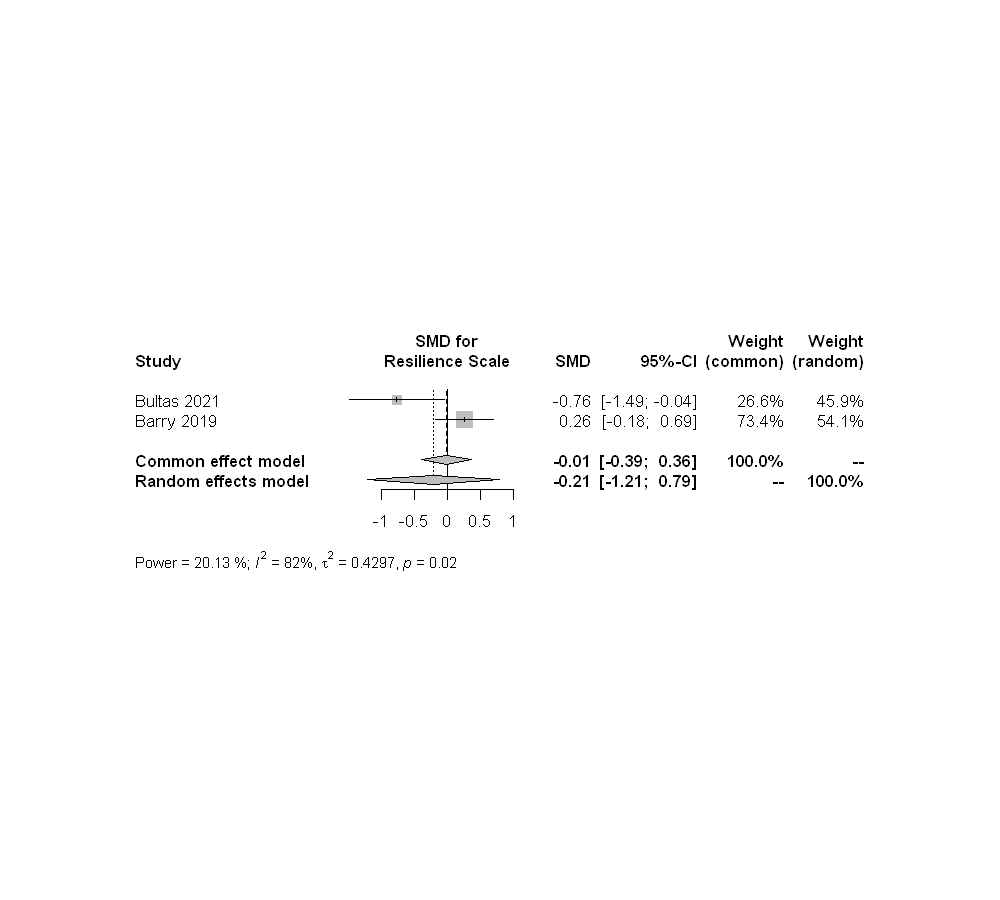

In [378]:
print.meta.results("Resilience Scale")

### Mental Health-related Outcomes

Number of studies combined: k = 3
Number of observations: o = 327

                         SMD             95%-CI     z p-value
Common effect model  -0.2380 [-0.4559; -0.0201] -2.14  0.0323
Random effects model -0.2380 [-0.4559; -0.0201] -2.14  0.0323

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.7249]; tau = 0 [0.0000; 0.8514]
 I^2 = 0.0% [0.0%; 89.6%]; H = 1.00 [1.00; 3.10]

Test of heterogeneity:
    Q d.f. p-value
 0.77    2  0.6794

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"




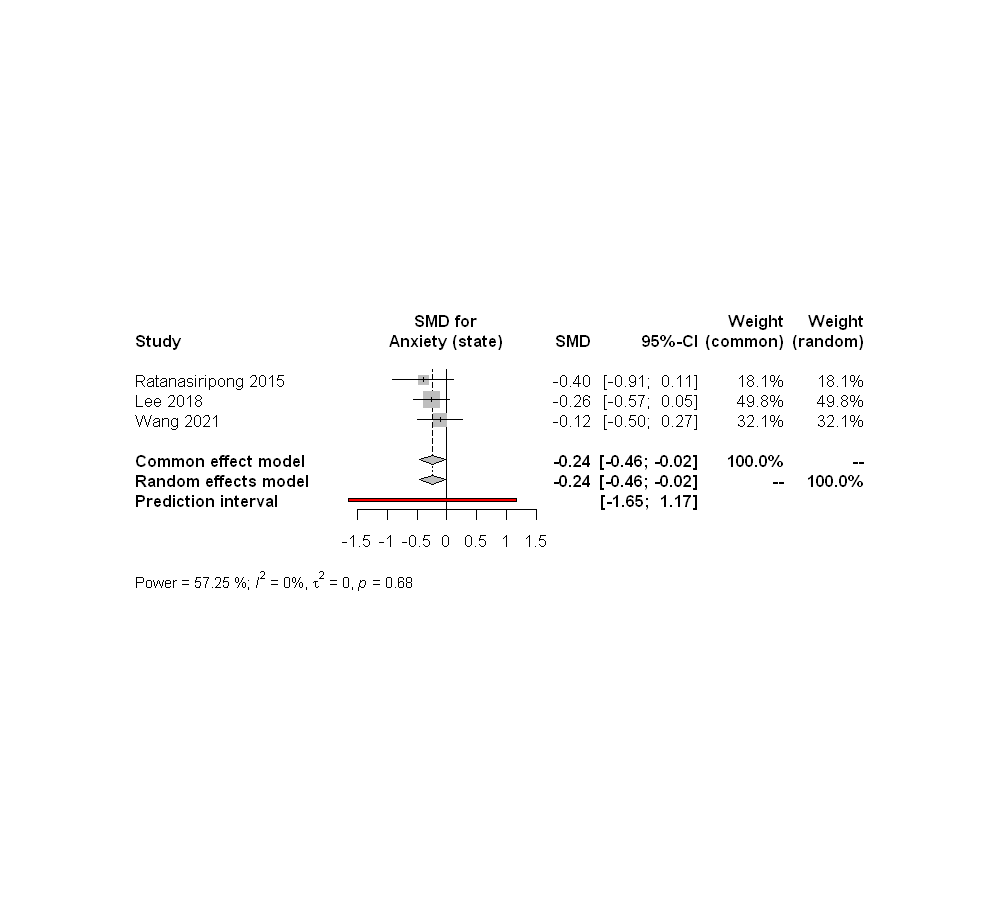

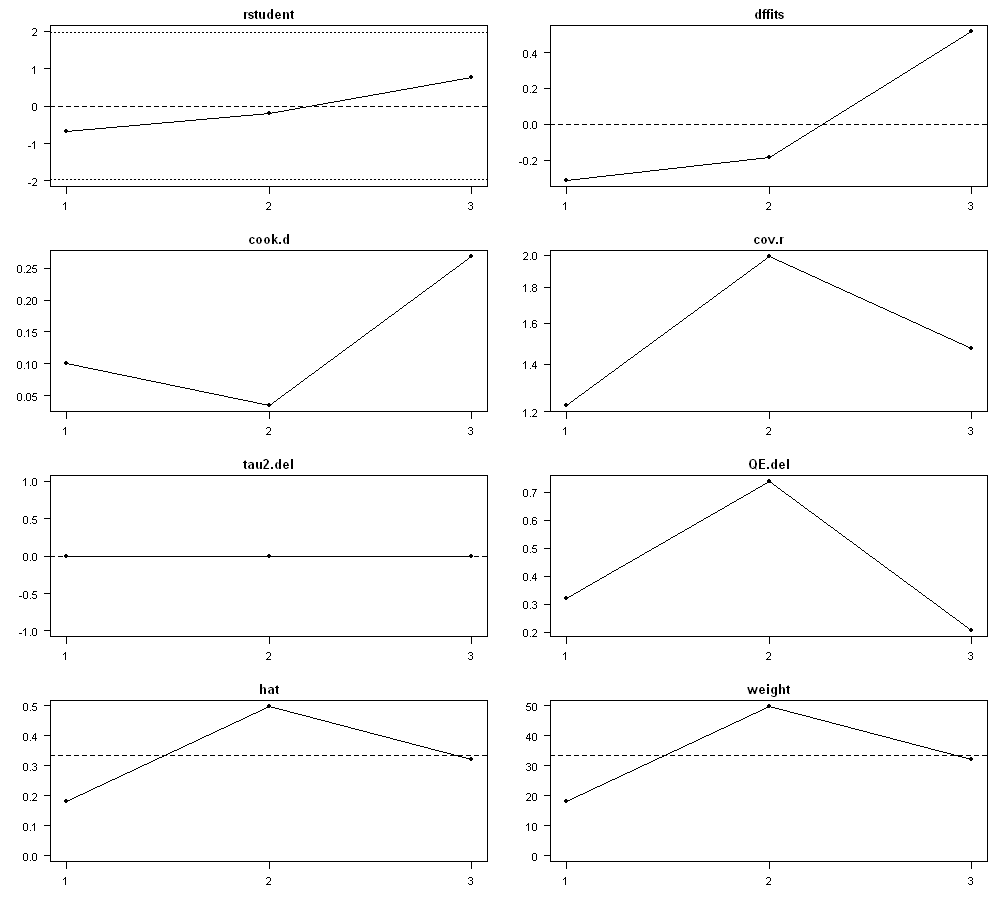

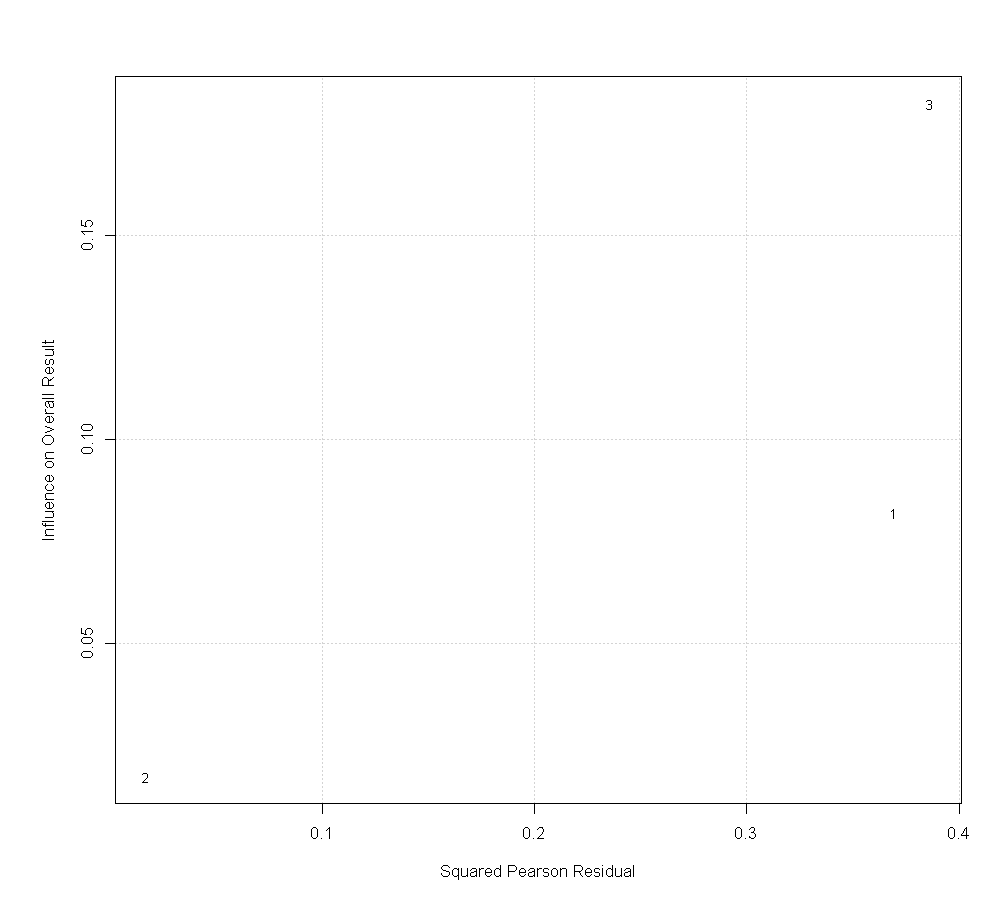

[1] "Number of included studies (2) in regression is below 3 for outcome \"Anxiety (state)\" and moderator \"sessions.duration\""

[1] "Number of included studies (2) in regression is below 3 for outcome \"Anxiety (state)\" and moderator \"sessions.frequency\""

[1] "Number of included studies (3) in regression is below 3 for outcome \"Anxiety (state)\" and moderator \"programs.duration\""

[1] "Number of included studies (3) in regression is below 3 for outcome \"Anxiety (state)\" and moderator \"follow.up.period\""

[1] "Number of included studies (3) in regression is below 3 for outcome \"Anxiety (state)\" and moderator \"delivery.mode\""

[1] "Number of included studies (3) in regression is below 3 for outcome \"Anxiety (state)\" and moderator \"meditation.type\""



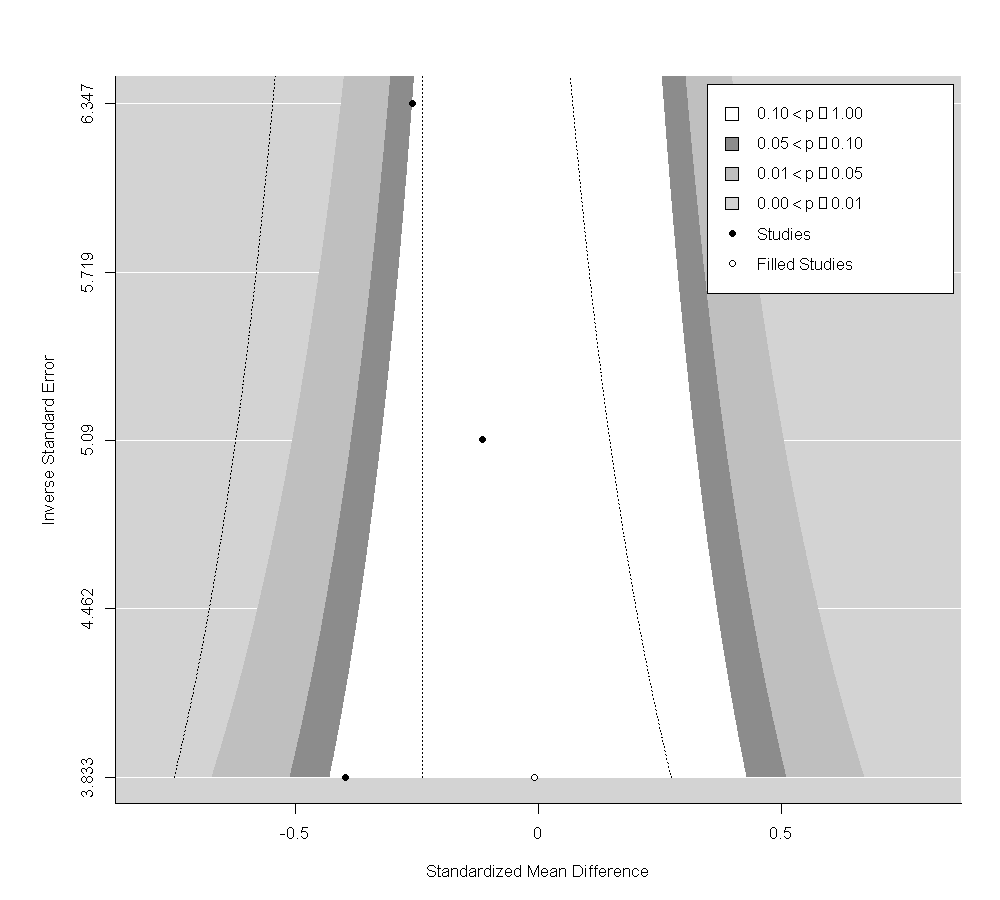

In [379]:
print.meta.results("Anxiety (state)")

Number of studies combined: k = 6
Number of observations: o = 441

                         SMD             95%-CI     z p-value
Common effect model  -0.2234 [-0.4114; -0.0355] -2.33  0.0198
Random effects model -0.2234 [-0.4114; -0.0355] -2.33  0.0198

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1494]; tau = 0 [0.0000; 0.3865]
 I^2 = 0.0% [0.0%; 74.6%]; H = 1.00 [1.00; 1.99]

Test of heterogeneity:
    Q d.f. p-value
 2.62    5  0.7589

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 6
Number of observations: o = 441

                         SMD             95%-CI     z p-value
Common effect model  -0.2234 [-0.4114; -0.0355] -2.33  0.0198
Random effects model -0.2234 [-0.4114; -0.0355] -2.33  0.0198

Quantifyi

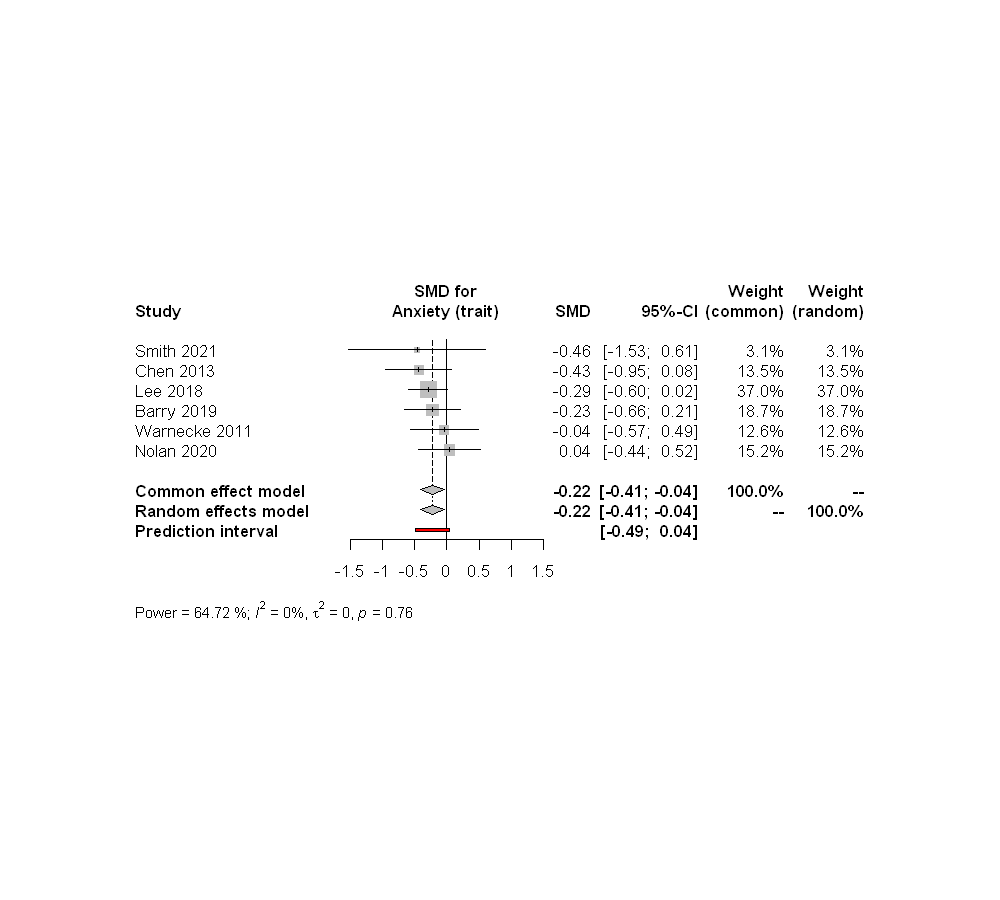


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 6
Number of observations: o = 441

                         SMD             95%-CI     z p-value
Common effect model  -0.2234 [-0.4114; -0.0355] -2.33  0.0198
Random effects model -0.2234 [-0.4114; -0.0355] -2.33  0.0198

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1494]; tau = 0 [0.0000; 0.3865]
 I^2 = 0.0% [0.0%; 74.6%]; H = 1.00 [1.00; 1.99]

Test of heterogeneity:
    Q d.f. p-value
 2.62    5  0.7589

Results for subgroups (common effect model):
                                k     SMD            95%-CI    Q  I^2
subgroup = Attentional Family   5 -0.1822 [-0.4189; 0.0546] 2.30 0.0%
subgroup = Hybrid Form          1 -0.2938 [-0.6030; 0.0154] 0.00   --

Test for subgroup differences (common effect model):
                  Q d.f. p-value
Between groups 0.32    1  0.5742
Within groups  2.30    4  0.6806

Results for subgroups (random effects model):
                                k     SMD            95%-CI

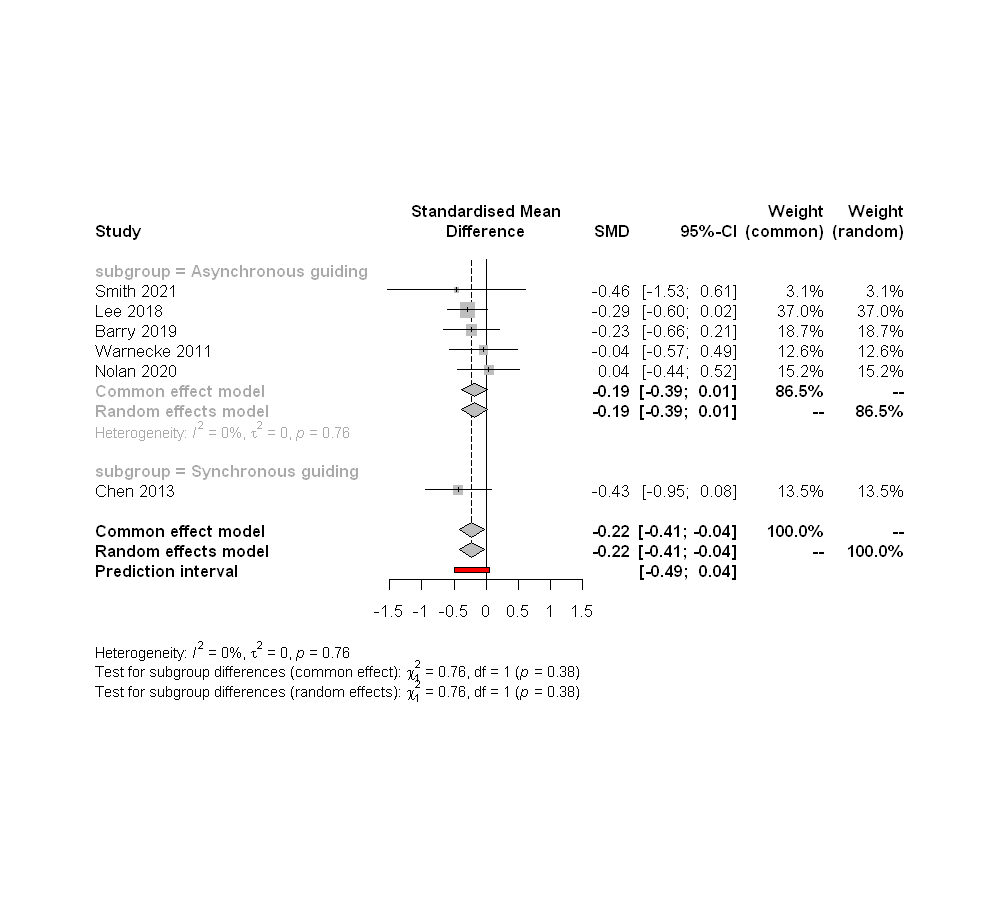

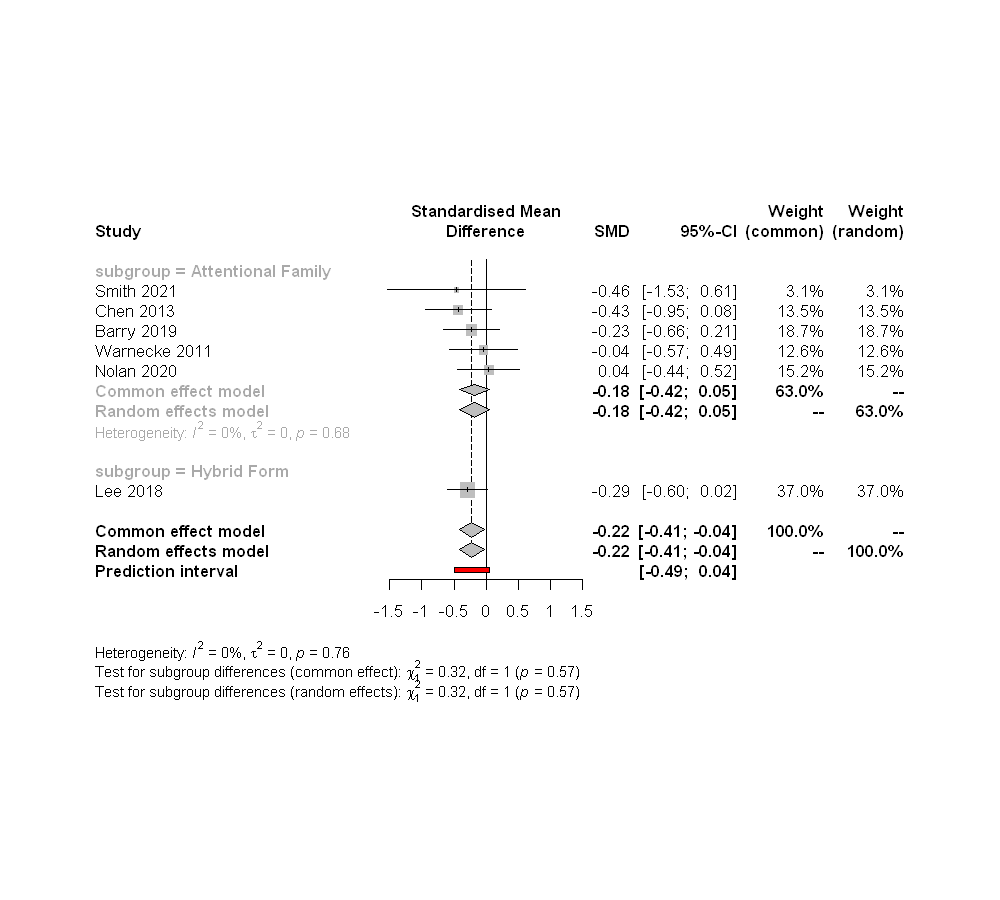

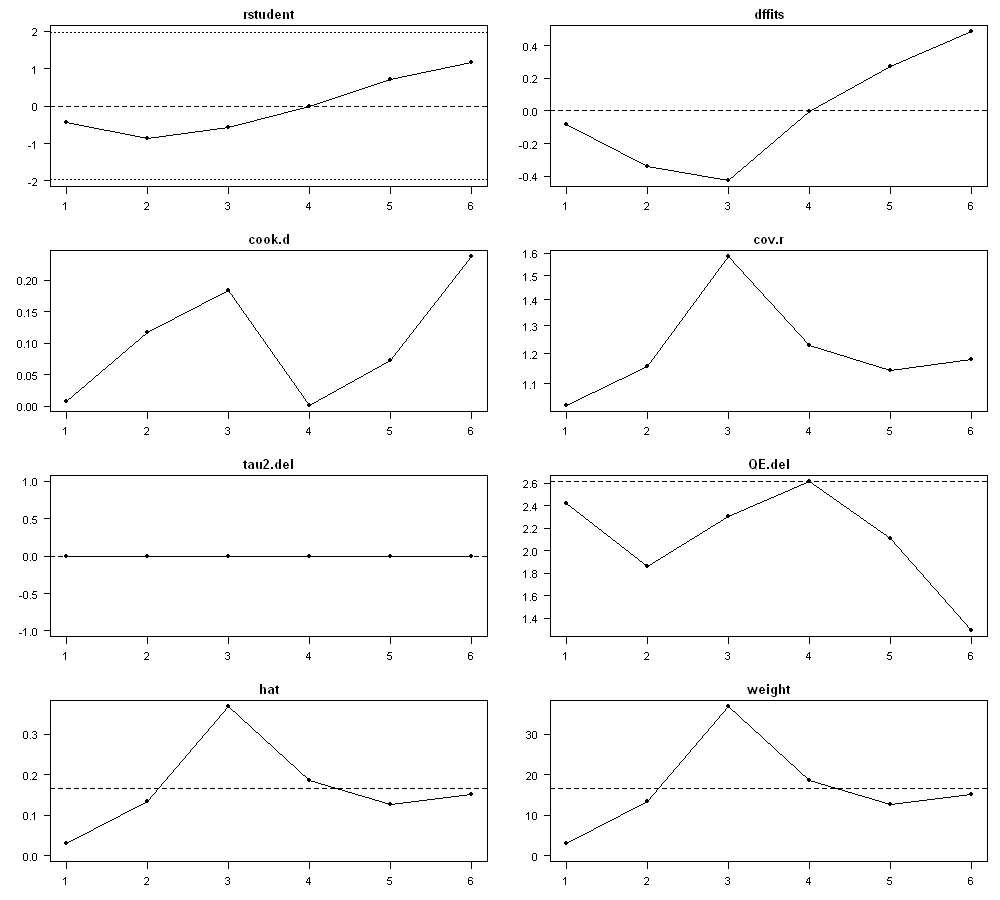

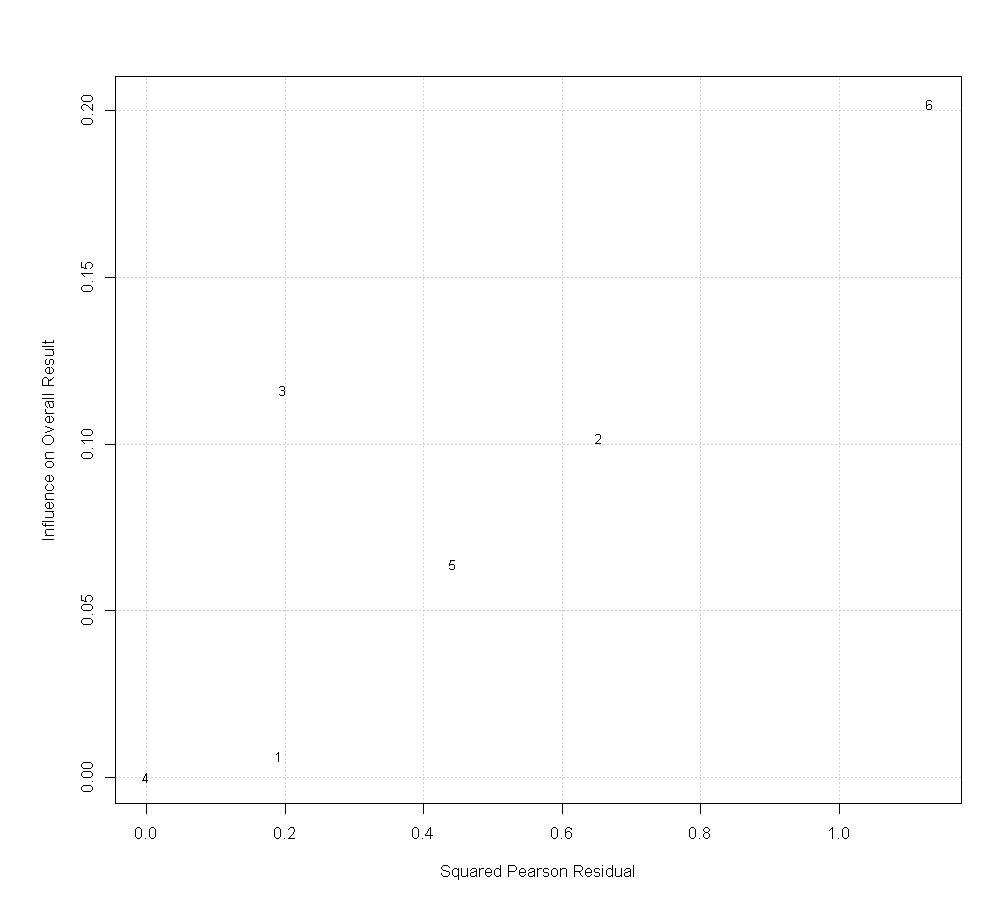

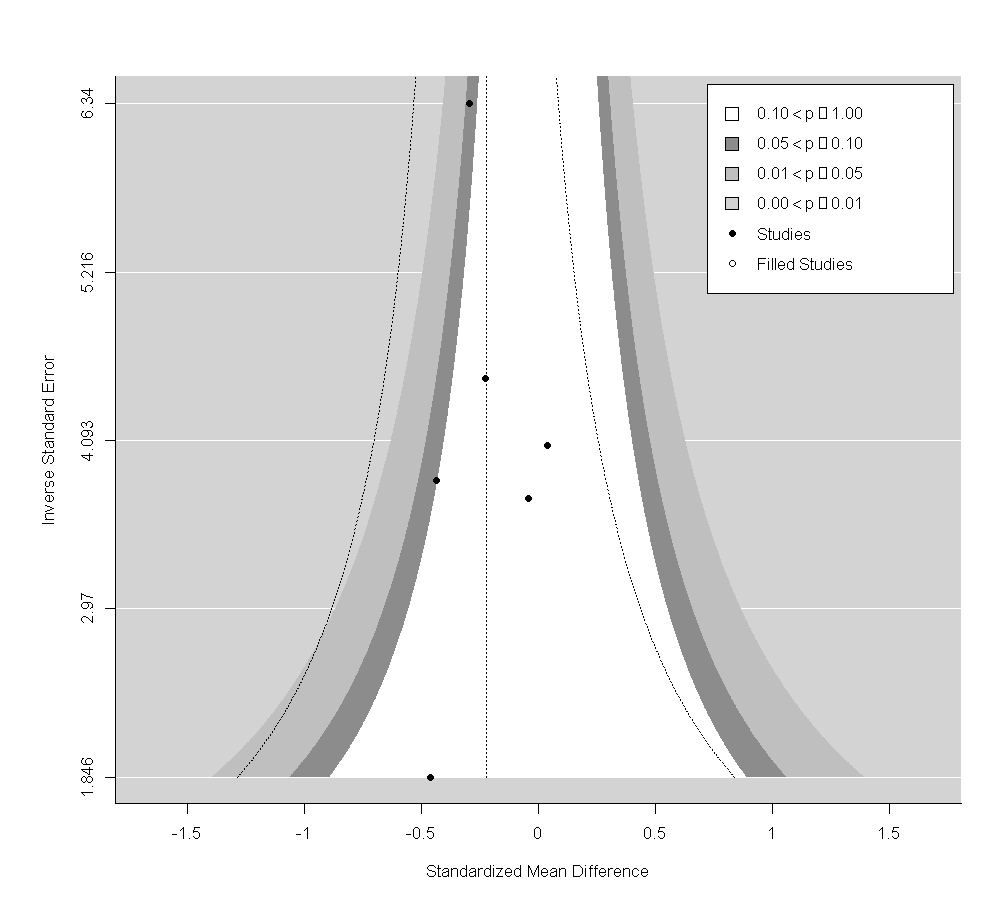

[1] "sessions.duration"

Mixed-Effects Model (k = 6; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0426)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 4) = 2.5996, p-val = 0.6269

Test of Moderators (coefficient 2):
QM(df = 1) = 0.0196, p-val = 0.8886

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt             -0.1978  0.2070  -0.9557  0.3392  -0.6036  0.2079    
sessions.duration   -0.0014  0.0097  -0.1401  0.8886  -0.0203  0.0176    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



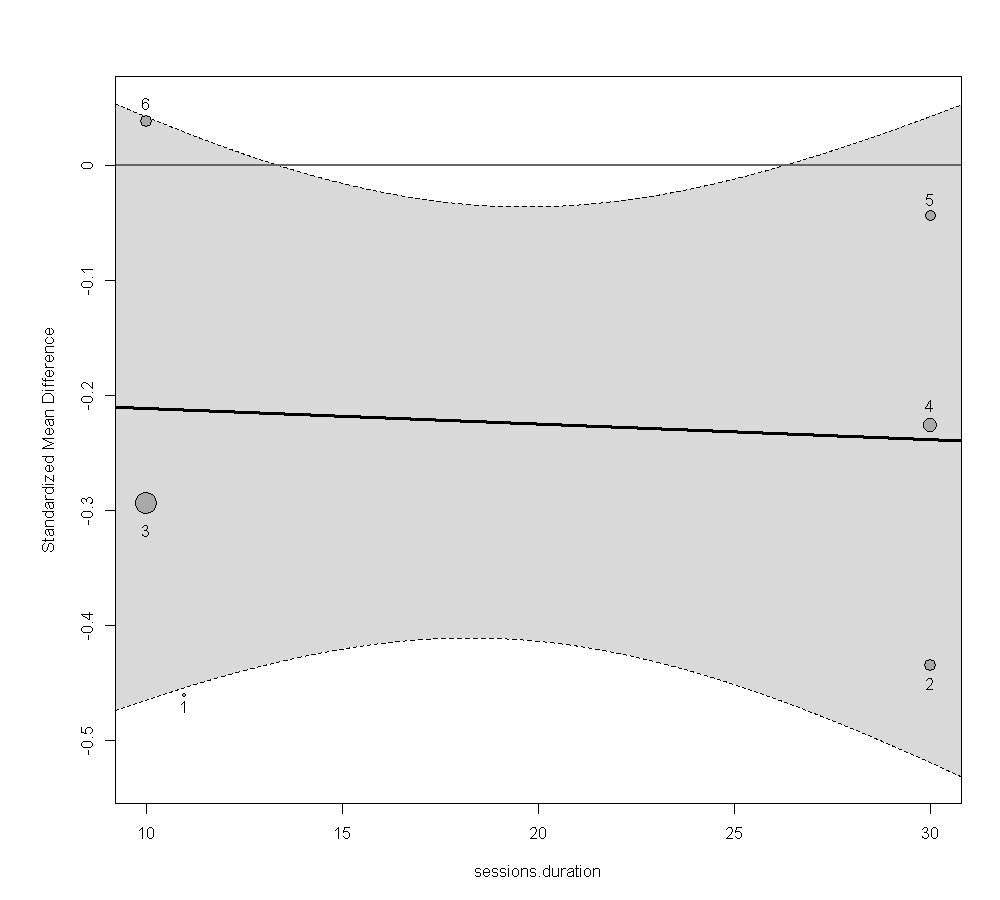

[1] "sessions.frequency"

Mixed-Effects Model (k = 6; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0338)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 4) = 1.9352, p-val = 0.7477

Test of Moderators (coefficient 2):
QM(df = 1) = 0.6841, p-val = 0.4082

Model Results:

                    estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt              -0.0905  0.1873  -0.4830  0.6291  -0.4576  0.2767    
sessions.frequency   -0.0242  0.0293  -0.8271  0.4082  -0.0816  0.0332    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



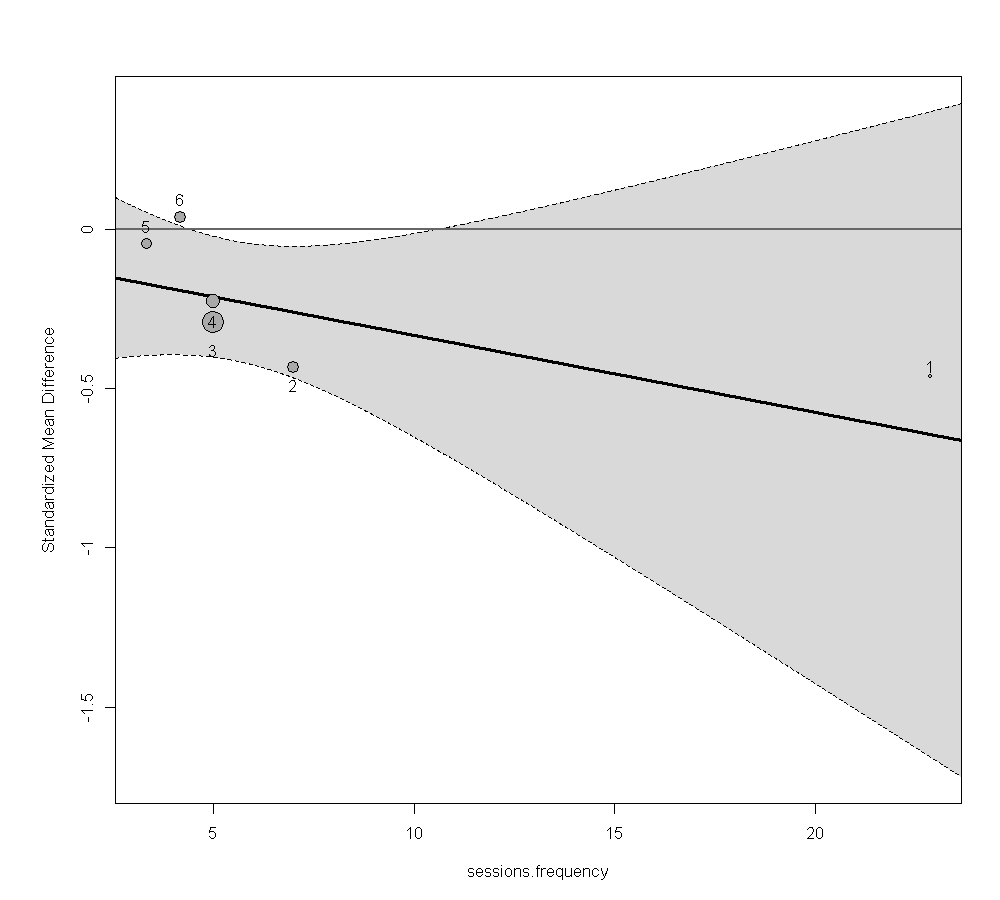

[1] "programs.duration"

Mixed-Effects Model (k = 5; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0441)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 3) = 0.5871, p-val = 0.8994

Test of Moderators (coefficient 2):
QM(df = 1) = 0.6990, p-val = 0.4031

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt             -0.4446  0.2330  -1.9084  0.0563  -0.9012  0.0120  . 
programs.duration    0.0048  0.0058   0.8360  0.4031  -0.0065  0.0162    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "Only equal moderator values present for regression of outcome:\"Anxiety (trait)\" and moderator: \"follow.up.period\""

[1] "delivery.mode"

Mixed-Effec

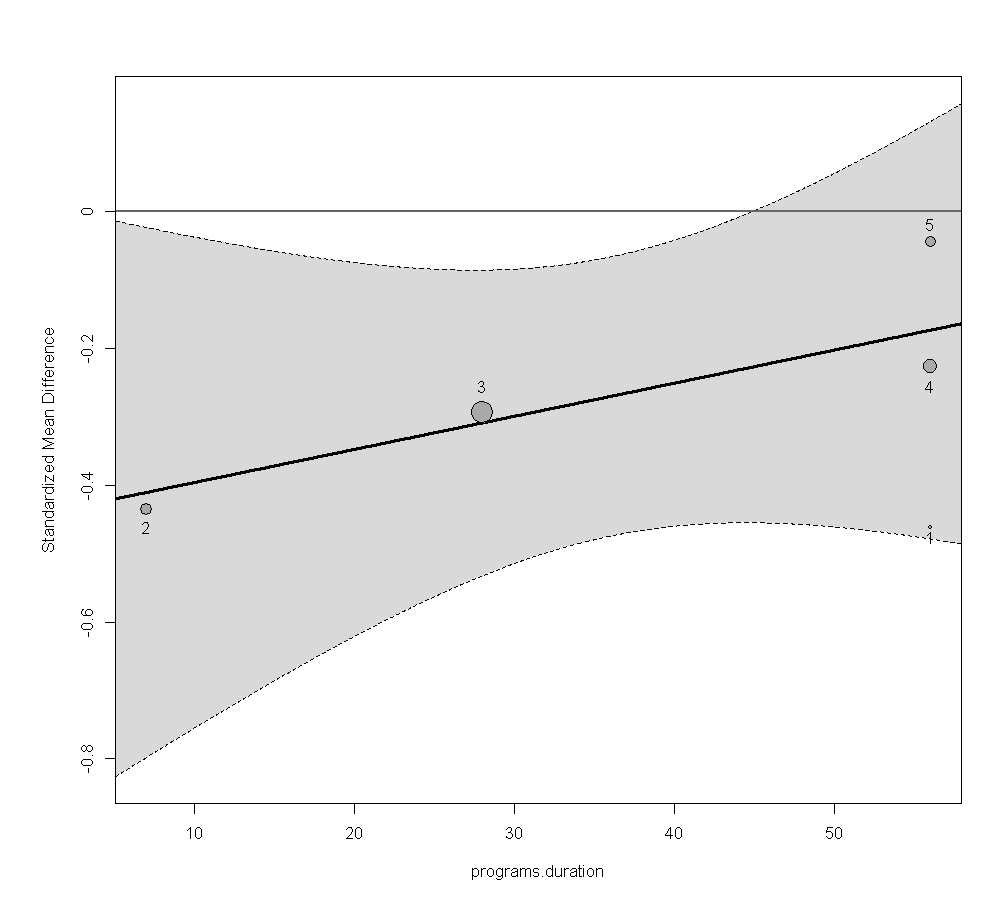

In [380]:
results.metafor.anxiety.t <- print.meta.results("Anxiety (trait)", return.data = "results.metafor")

Number of studies combined: k = 5
Number of observations: o = 375

                         SMD             95%-CI     z p-value
Common effect model  -0.2702 [-0.4743; -0.0662] -2.60  0.0095
Random effects model -0.2702 [-0.4743; -0.0662] -2.60  0.0095

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1321]; tau = 0 [0.0000; 0.3635]
 I^2 = 0.0% [0.0%; 79.2%]; H = 1.00 [1.00; 2.19]

Test of heterogeneity:
    Q d.f. p-value
 1.28    4  0.8640

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)


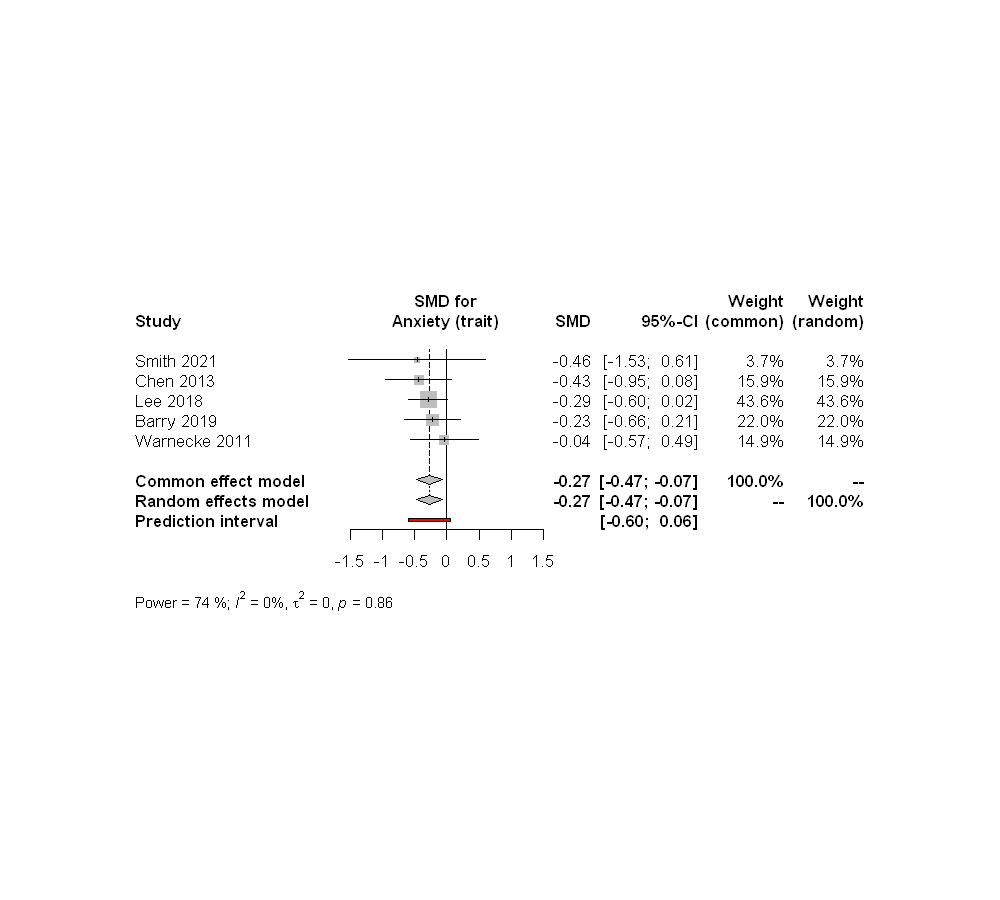

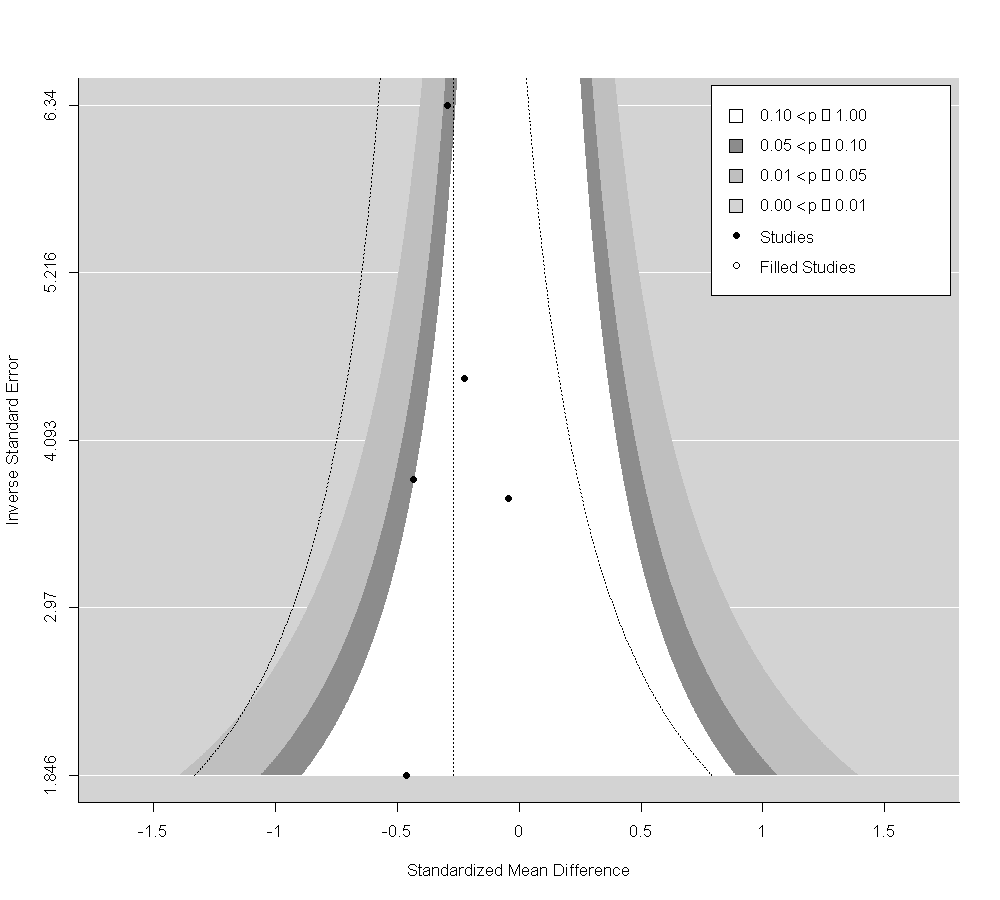

In [381]:
print.meta.results("Anxiety (trait)", filter.forest..funnel.vec = -c(6), regression = F, split.subgroups = F, print.influence = F)

Fitting 63 models (based on all possible subsets).



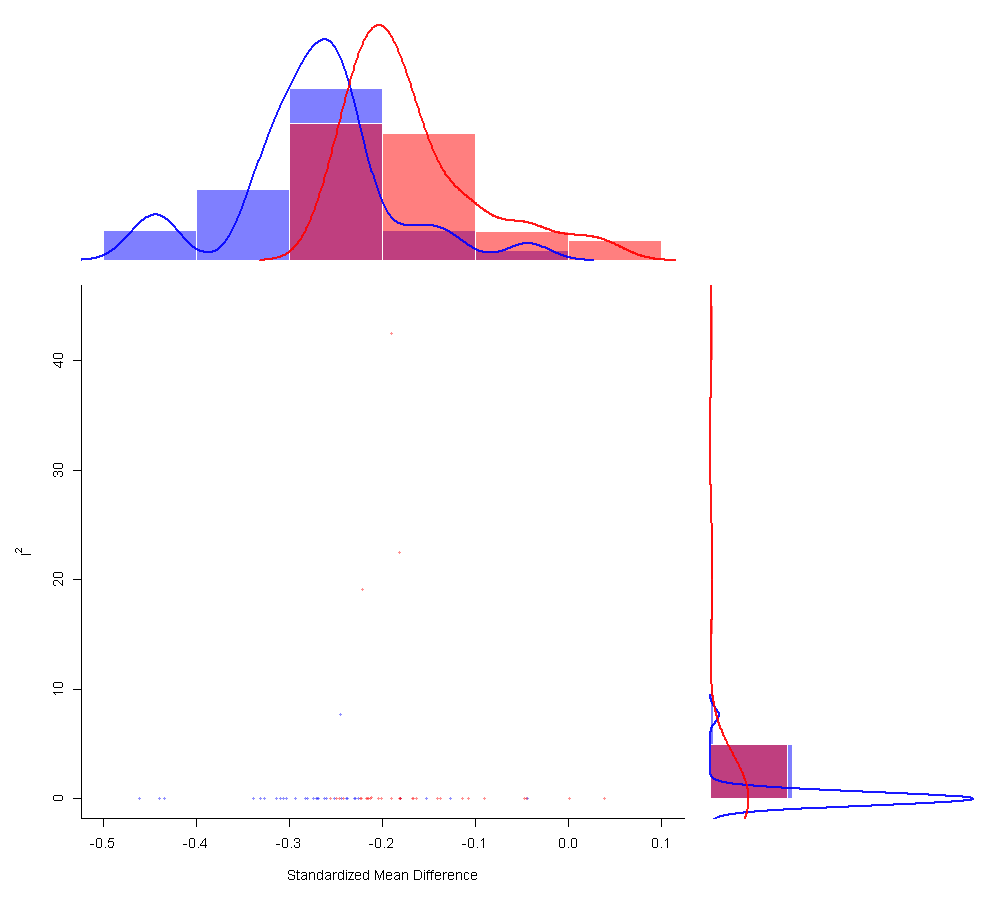

In [382]:
for (outlier in c(6)){
  sav <- gosh(results.metafor.anxiety.t)
  plot(sav, out = outlier)
}

Number of studies combined: k = 7
Number of observations: o = 518

                         SMD             95%-CI     z p-value
Common effect model  -0.3259 [-0.5005; -0.1513] -3.66  0.0003
Random effects model -0.3305 [-0.5507; -0.1104] -2.94  0.0033

Quantifying heterogeneity:
 tau^2 = 0.0269 [0.0000; 0.3296]; tau = 0.1641 [0.0000; 0.5741]
 I^2 = 27.3% [0.0%; 68.6%]; H = 1.17 [1.00; 1.78]

Test of heterogeneity:
    Q d.f. p-value
 8.26    6  0.2198

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 7
Number of observations: o = 518

                         SMD             95%-CI     z p-value
Common effect model  -0.3259 [-0.5005; -0.1513] -3.66  0.0003
Random effects model -0.3305 [-0.5507; -0.1104] -2.94  0.0033

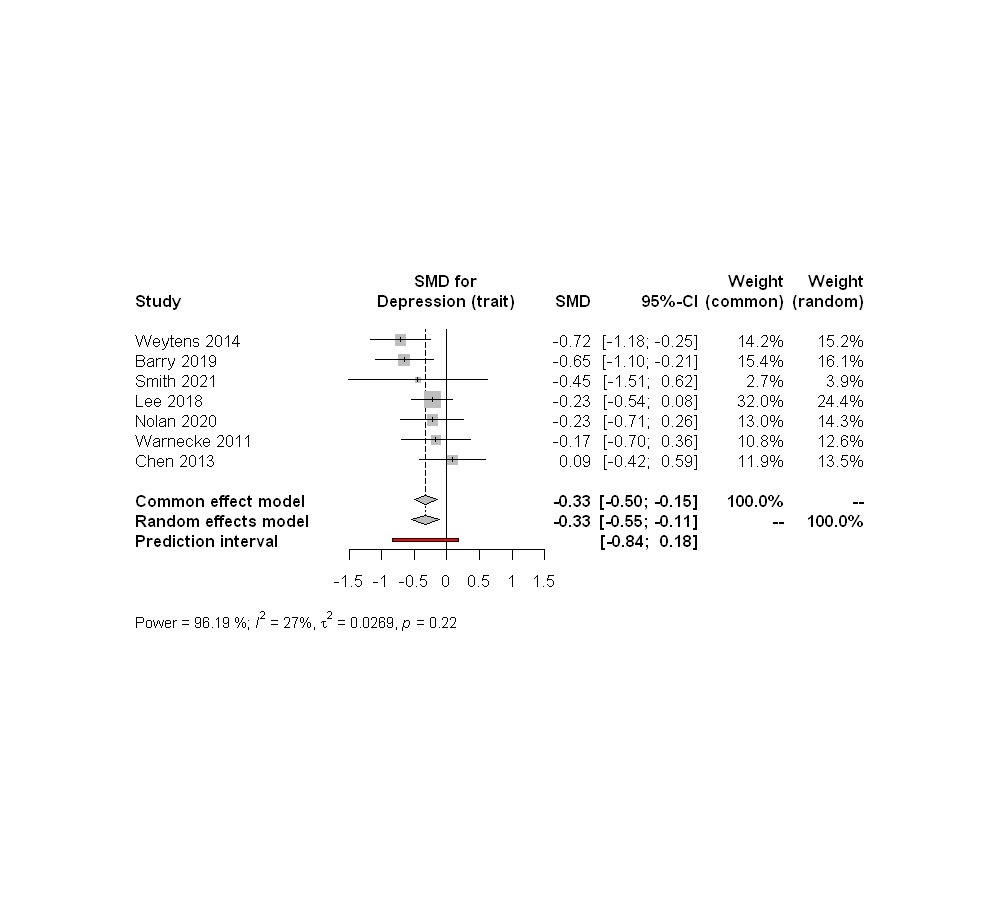


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 7
Number of observations: o = 518

                         SMD             95%-CI     z p-value
Common effect model  -0.3259 [-0.5005; -0.1513] -3.66  0.0003
Random effects model -0.3305 [-0.5507; -0.1104] -2.94  0.0033

Quantifying heterogeneity:
 tau^2 = 0.0269 [0.0000; 0.3296]; tau = 0.1641 [0.0000; 0.5741]
 I^2 = 27.3% [0.0%; 68.6%]; H = 1.17 [1.00; 1.78]

Test of heterogeneity:
    Q d.f. p-value
 8.26    6  0.2198

Results for subgroups (common effect model):
                                 k     SMD             95%-CI    Q   I^2
subgroup = Constructive Family   1 -0.7161 [-1.1794; -0.2528] 0.00    --
subgroup = Attentional Family    5 -0.2803 [-0.5184; -0.0423] 5.02 20.3%
subgroup = Hybrid Form           1 -0.2293 [-0.5378;  0.0792] 0.00    --

Test for subgroup differences (common effect model):
                  Q d.f. p-value
Between groups 3.24    2  0.1977
Within groups  5.02    4  0.2856

Results for 

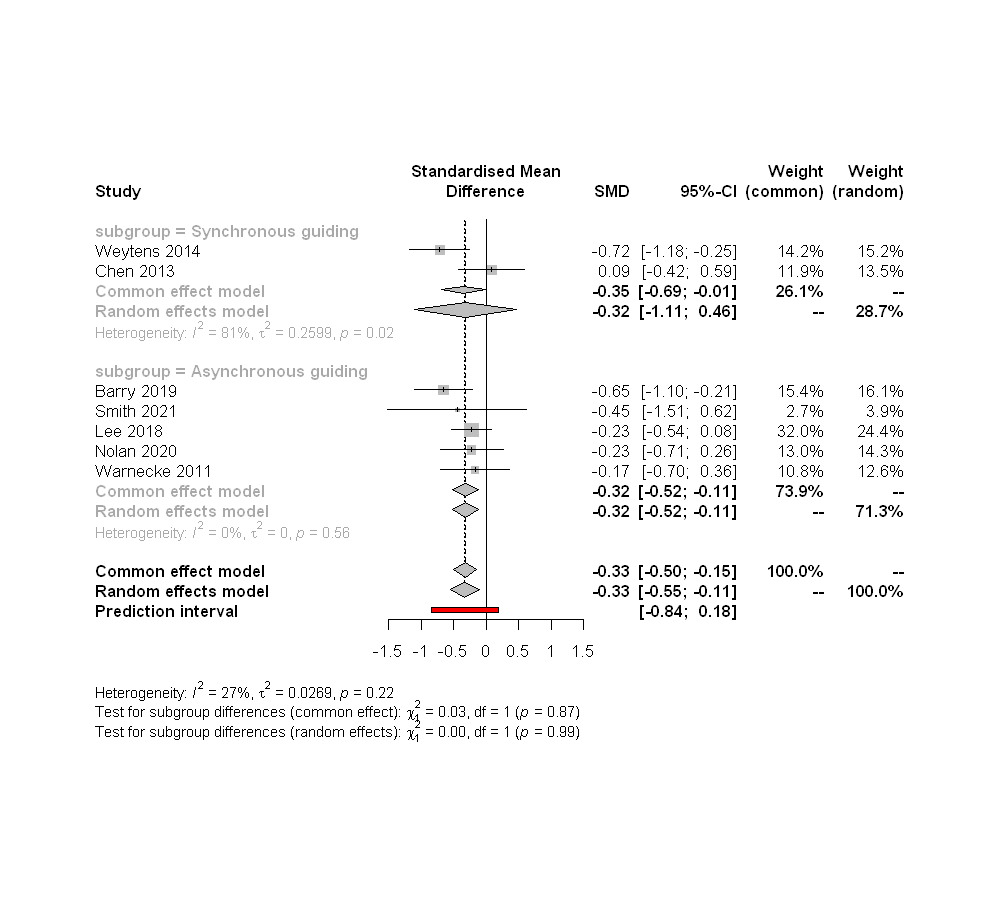

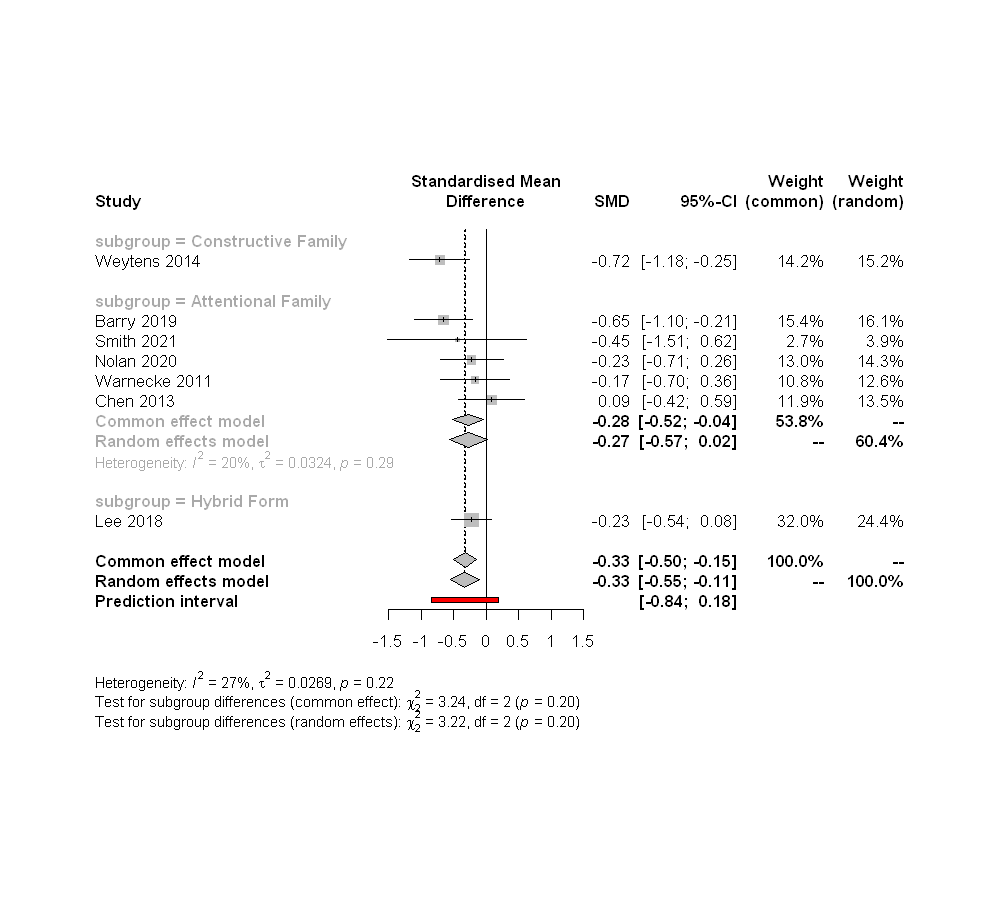

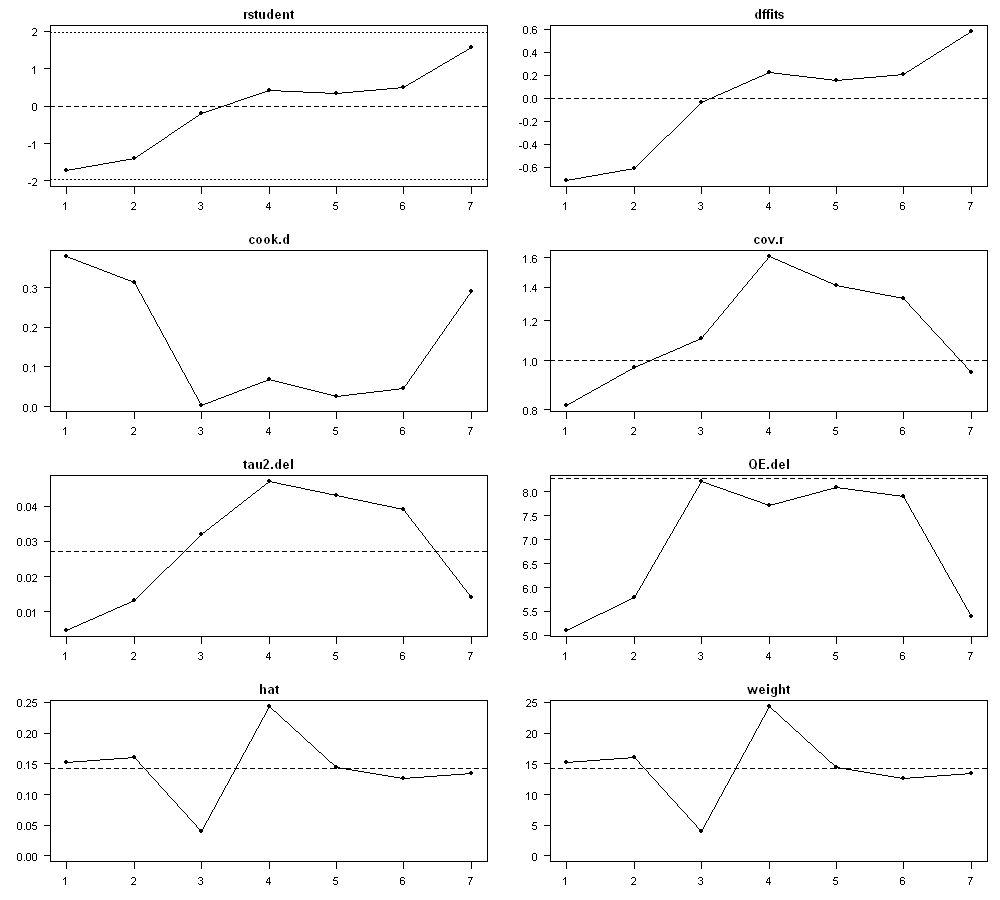

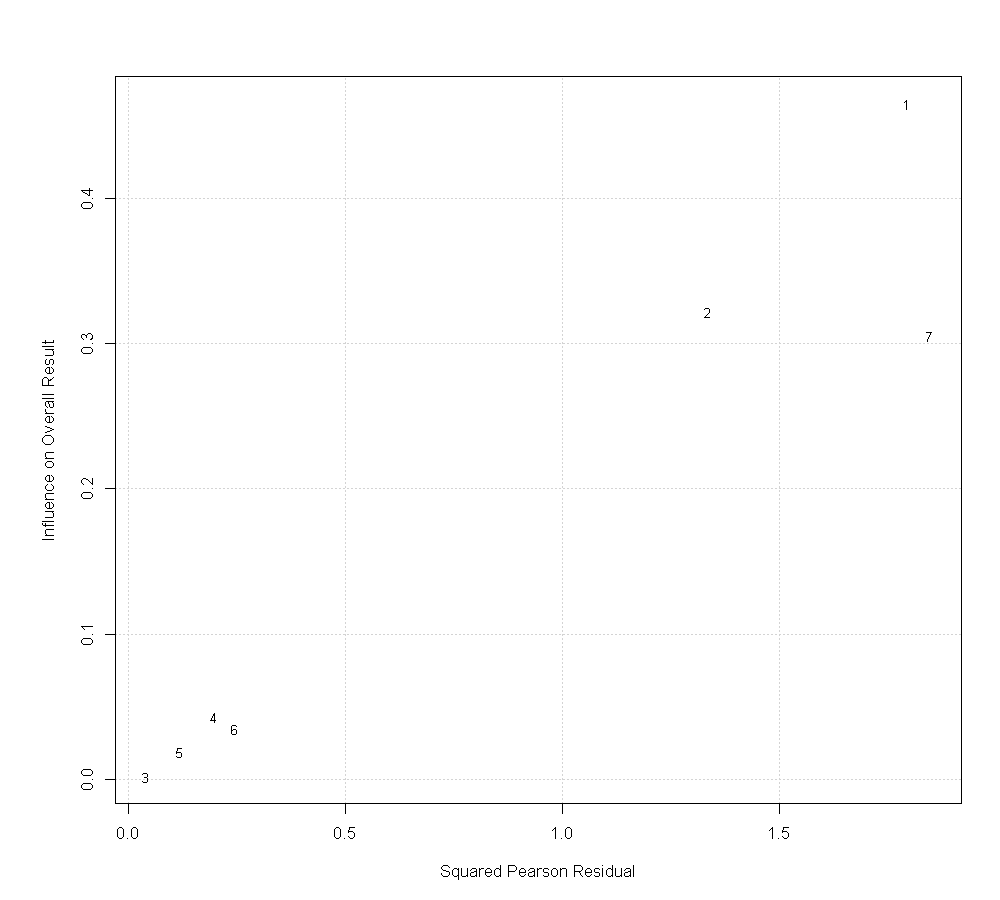

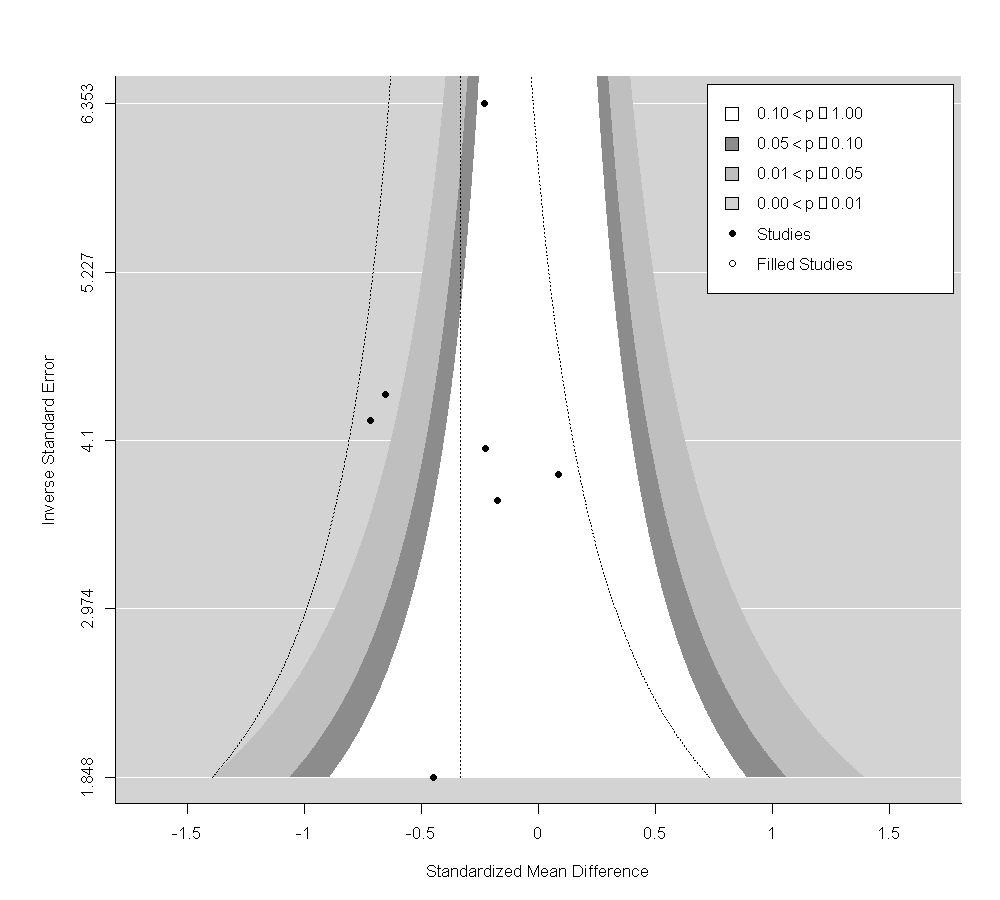

[1] "sessions.duration"

Mixed-Effects Model (k = 6; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0251 (SE = 0.0636)
tau (square root of estimated tau^2 value):             0.1584
I^2 (residual heterogeneity / unaccounted variability): 27.34%
H^2 (unaccounted variability / sampling variability):   1.38
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 4) = 5.0318, p-val = 0.2840

Test of Moderators (coefficient 2):
QM(df = 1) = 0.0138, p-val = 0.9066

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt             -0.2331  0.2696  -0.8646  0.3872  -0.7616  0.2953    
sessions.duration   -0.0014  0.0121  -0.1174  0.9066  -0.0251  0.0223    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



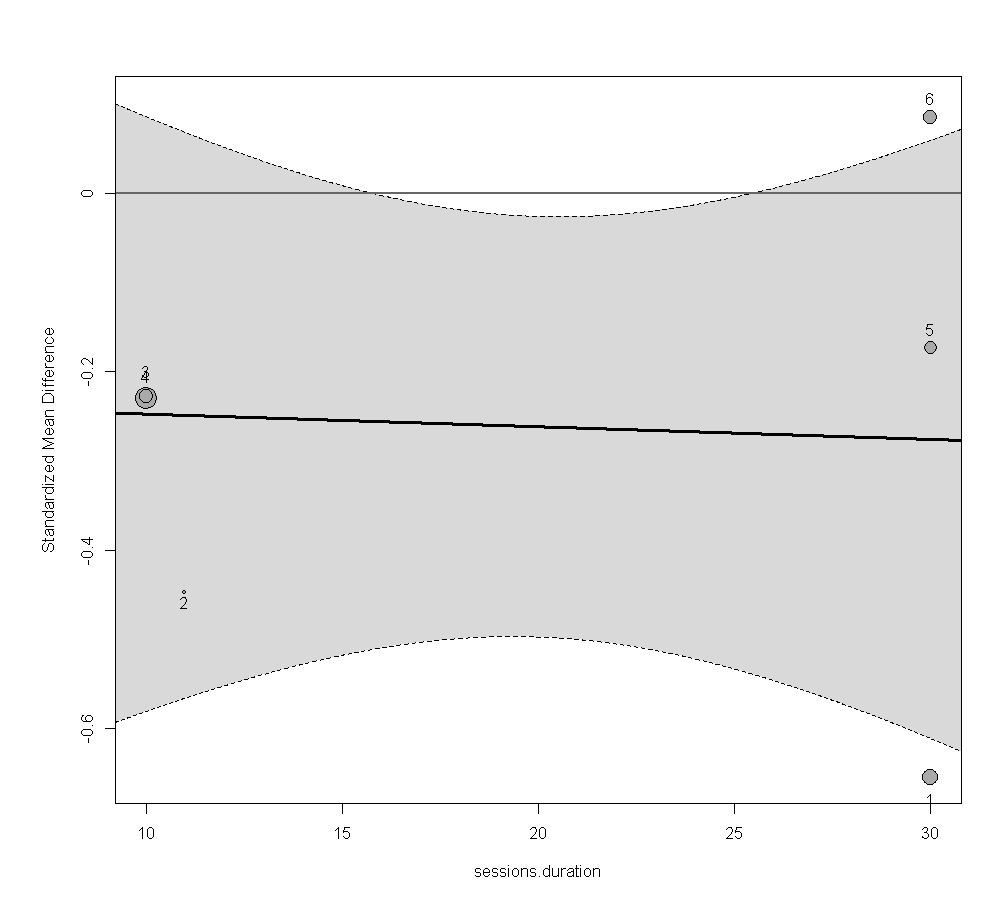

[1] "sessions.frequency"

Mixed-Effects Model (k = 7; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0328 (SE = 0.0538)
tau (square root of estimated tau^2 value):             0.1811
I^2 (residual heterogeneity / unaccounted variability): 38.90%
H^2 (unaccounted variability / sampling variability):   1.64
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 5) = 8.2330, p-val = 0.1439

Test of Moderators (coefficient 2):
QM(df = 1) = 0.0324, p-val = 0.8571

Model Results:

                    estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt              -0.2980  0.2175  -1.3701  0.1706  -0.7242  0.1283    
sessions.frequency   -0.0057  0.0315  -0.1801  0.8571  -0.0673  0.0560    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



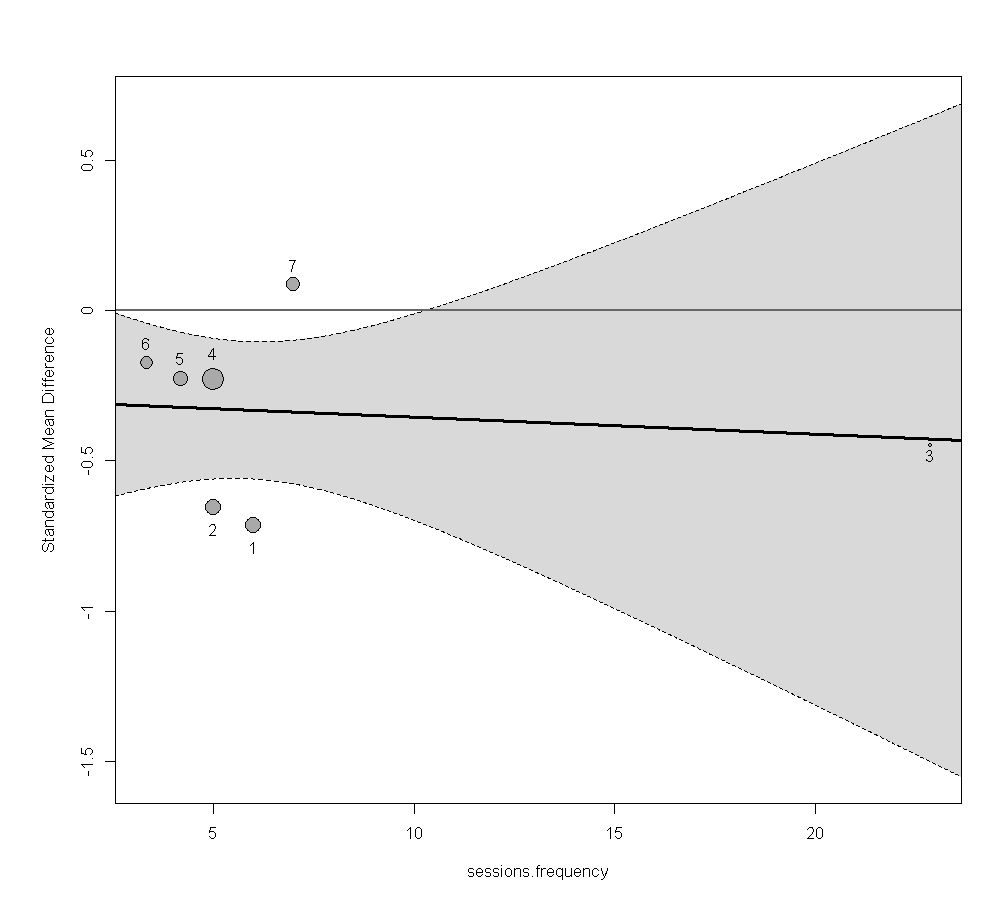

[1] "programs.duration"

Mixed-Effects Model (k = 6; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0376)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            100.00%

Test for Residual Heterogeneity:
QE(df = 4) = 4.1709, p-val = 0.3834

Test of Moderators (coefficient 2):
QM(df = 1) = 3.9178, p-val = 0.0478

Model Results:

                   estimate      se     zval    pval    ci.lb    ci.ub    
intrcpt              0.0762  0.2314   0.3295  0.7418  -0.3772   0.5297    
programs.duration   -0.0114  0.0057  -1.9793  0.0478  -0.0226  -0.0001  * 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "Only equal moderator values present for regression of outcome:\"Depression (trait)\" and moderator: \"follow.up.period\""

[1] "delivery.mode"

Mix

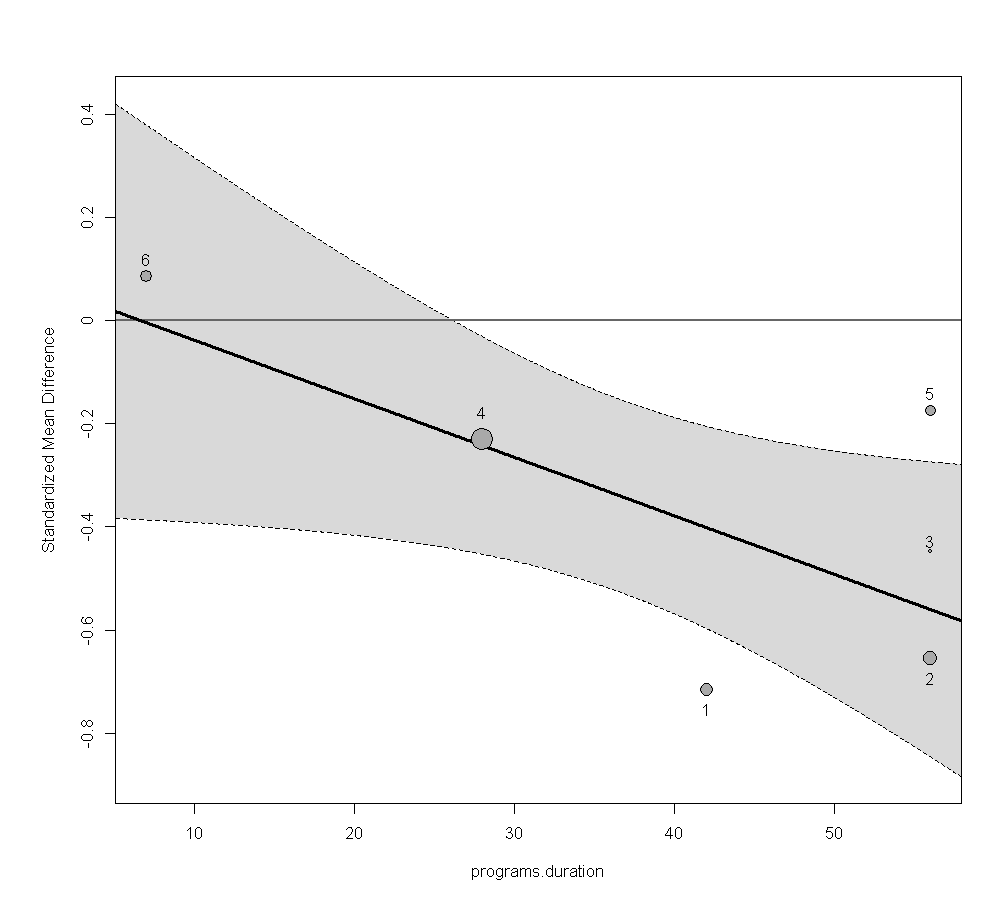

In [383]:
results.metafor.depression.t <- print.meta.results("Depression (trait)", return.data = "results.metafor")

Number of studies combined: k = 4
Number of observations: o = 299

                         SMD             95%-CI     z p-value
Common effect model  -0.2284 [-0.4566; -0.0003] -1.96  0.0497
Random effects model -0.2284 [-0.4566; -0.0003] -1.96  0.0497

Quantifying heterogeneity:
 tau^2 = 0; tau = 0; I^2 = 0.0% [0.0%; 84.7%]; H = 1.00 [1.00; 2.56]

Test of heterogeneity:
    Q d.f. p-value
 0.20    3  0.9769

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Hedges' g (bias corrected standardised mean difference; using exact formulae)


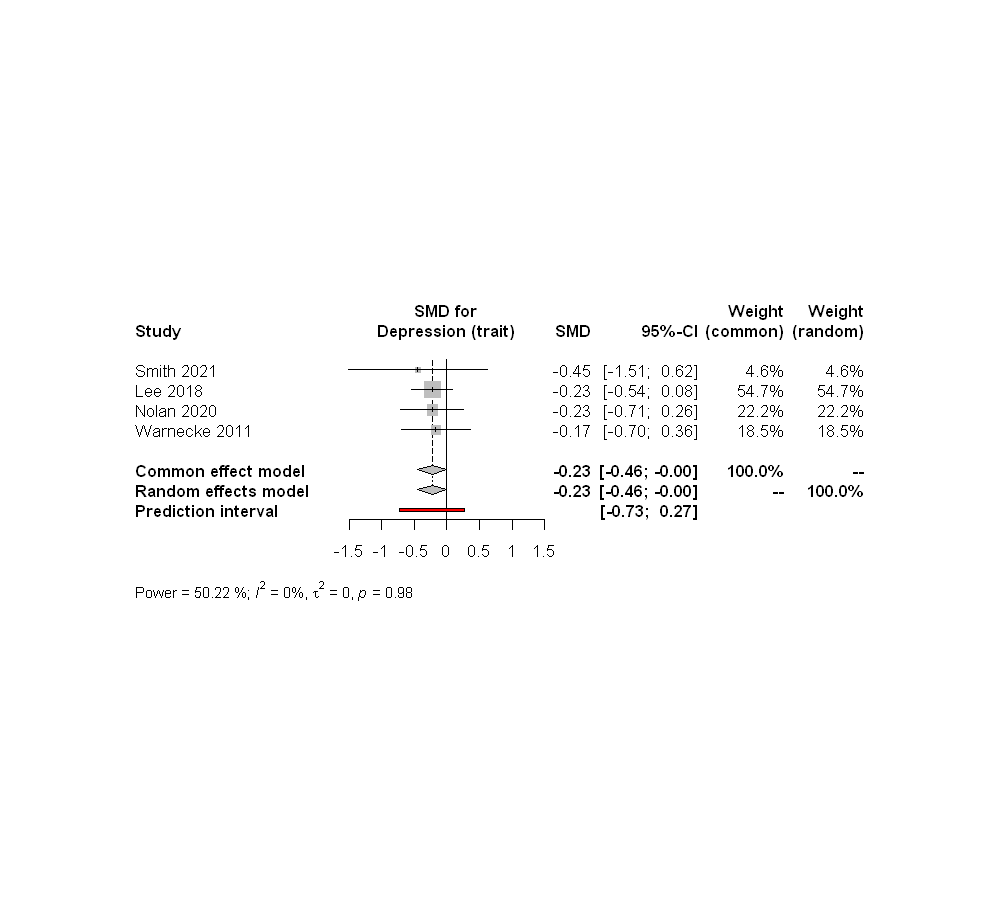

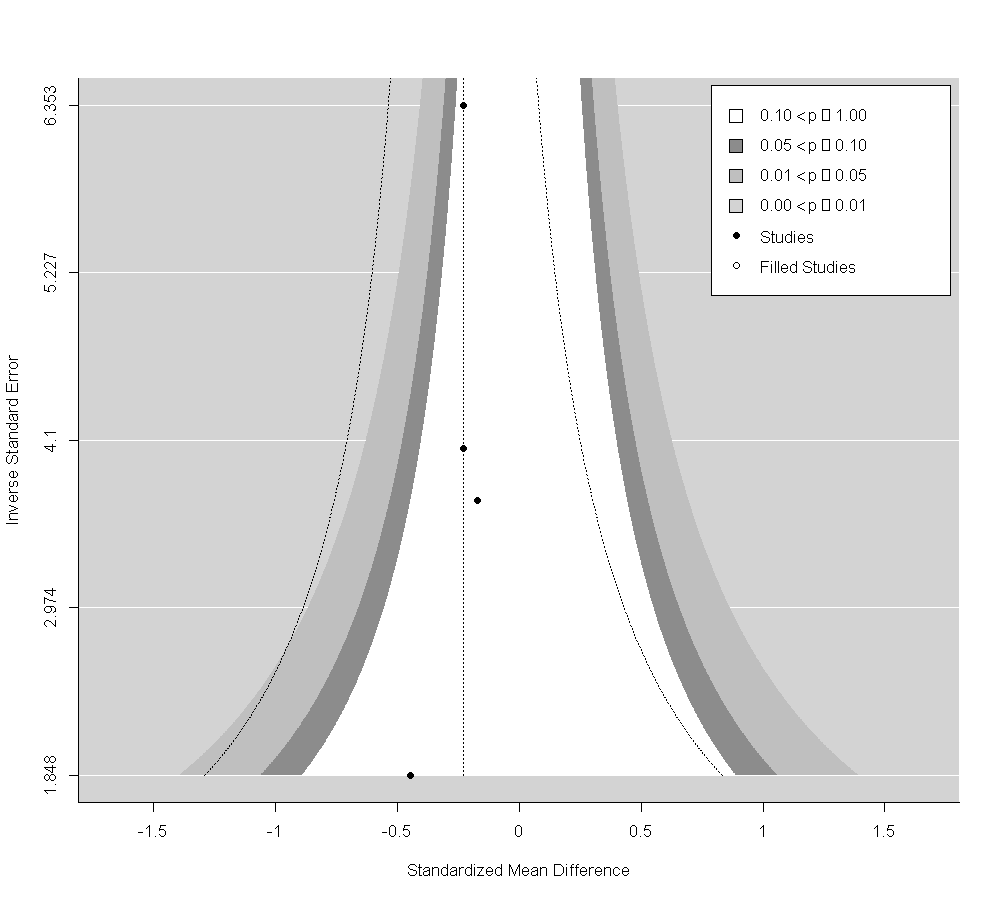

In [384]:
print.meta.results("Depression (trait)", filter.forest..funnel.vec = -c(1, 2, 7), regression = F, split.subgroups = F, print.influence = F)

Fitting 127 models (based on all possible subsets).

Fitting 127 models (based on all possible subsets).

Fitting 127 models (based on all possible subsets).



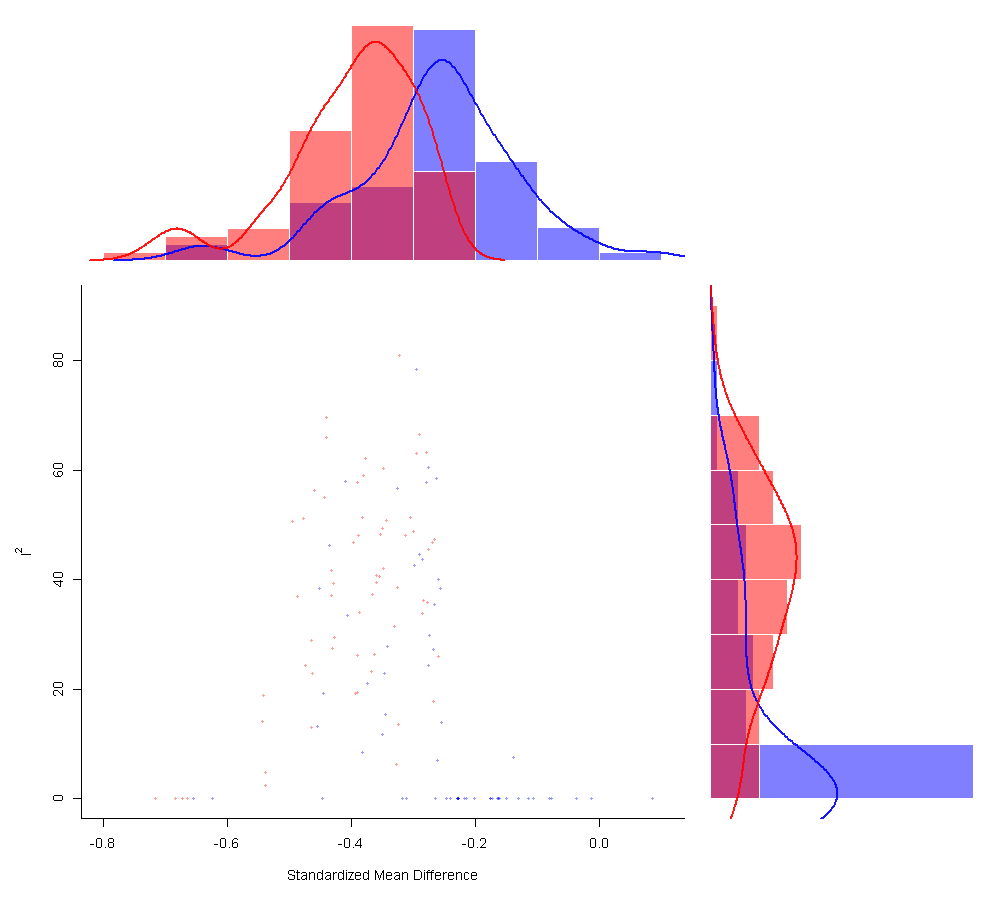

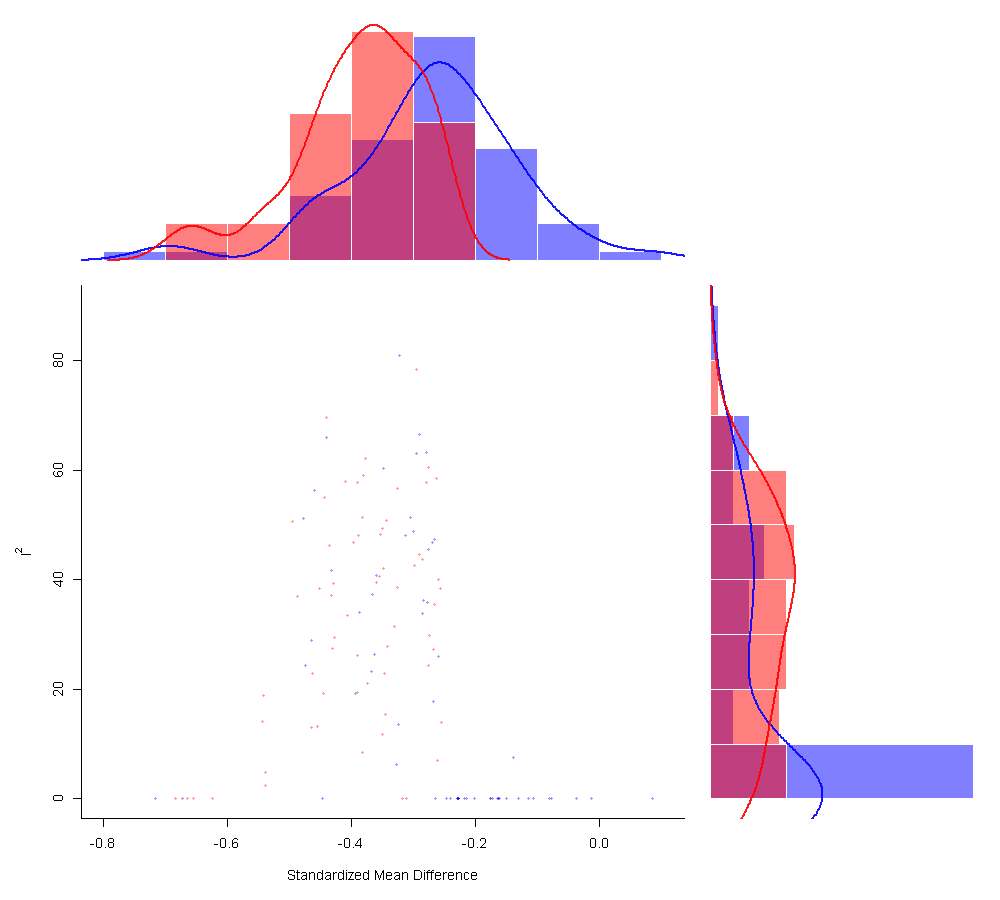

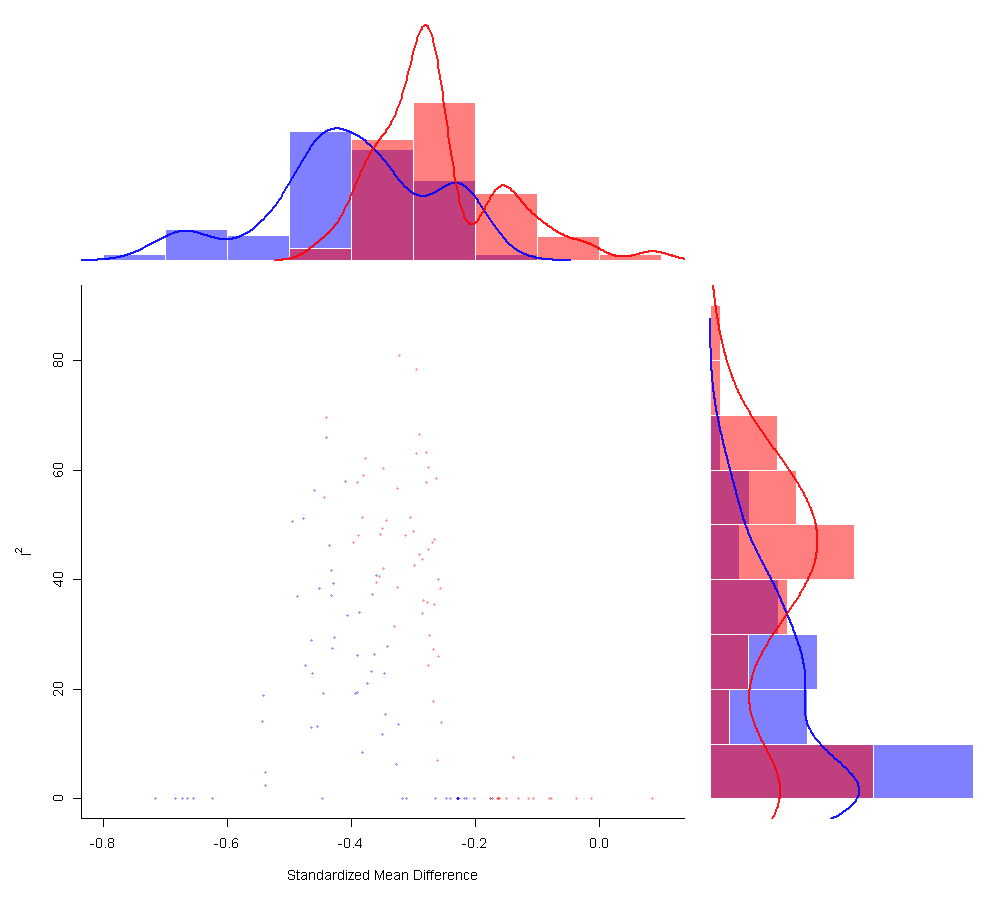

In [385]:
for (outlier in c(1, 2, 7)){
  sav <- gosh(results.metafor.depression.t)
  plot(sav, out = outlier)
}

Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.62 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0523 [0.0000; 0.3070]; tau = 0.2287 [0.0000; 0.5540]
 I^2 = 47.5% [2.4%; 71.7%]; H = 1.38 [1.01; 1.88]

Test of heterogeneity:
     Q d.f. p-value
 24.75   13  0.0249

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.6

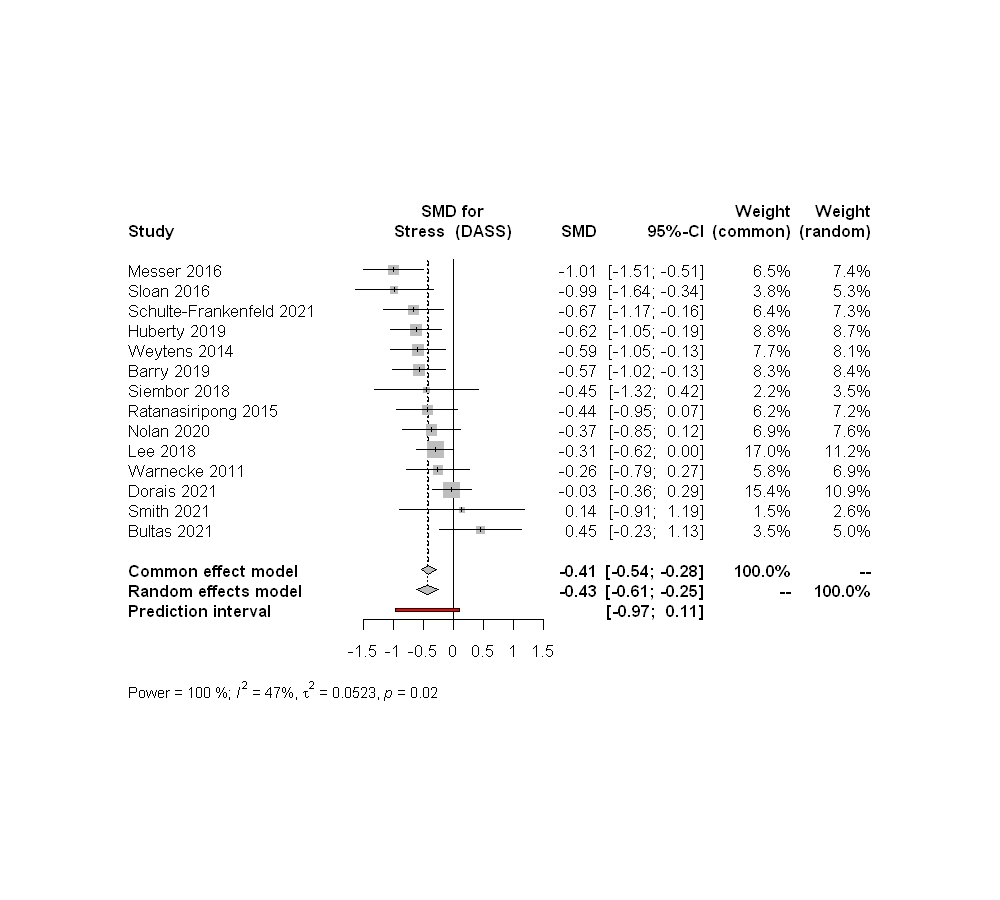


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.62 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0523 [0.0000; 0.3070]; tau = 0.2287 [0.0000; 0.5540]
 I^2 = 47.5% [2.4%; 71.7%]; H = 1.38 [1.01; 1.88]

Test of heterogeneity:
     Q d.f. p-value
 24.75   13  0.0249

Results for subgroups (common effect model):
                                   k     SMD             95%-CI     Q   I^2
subgroup = Attentional Family      9 -0.3490 [-0.5231; -0.1750] 21.30 62.4%
subgroup = Hybrid Form             3 -0.4653 [-0.6900; -0.2405]  2.13  6.0%
subgroup = Constructive Family     1 -0.5922 [-1.0510; -0.1335]  0.00    --
subgroup = Deconstructive Family   1 -0.4381 [-0.9508;  0.0747]  0.00    --

Test for subgroup differences (common effect model):
                  

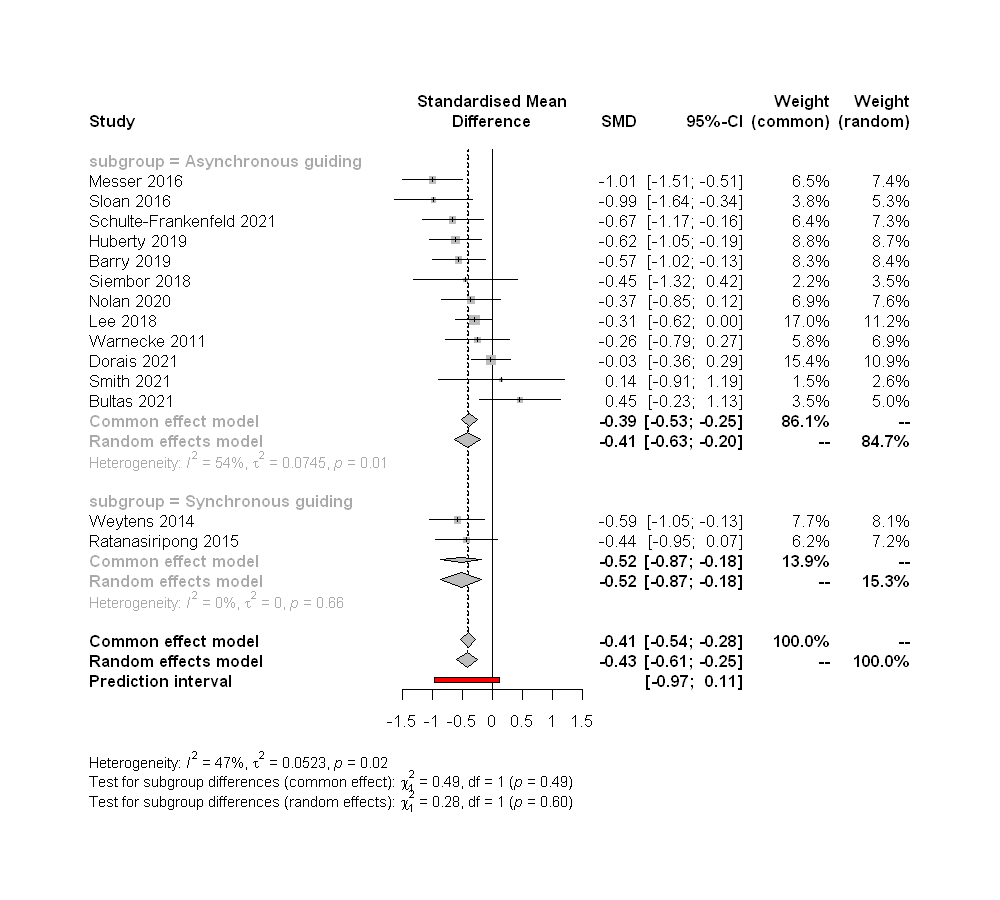

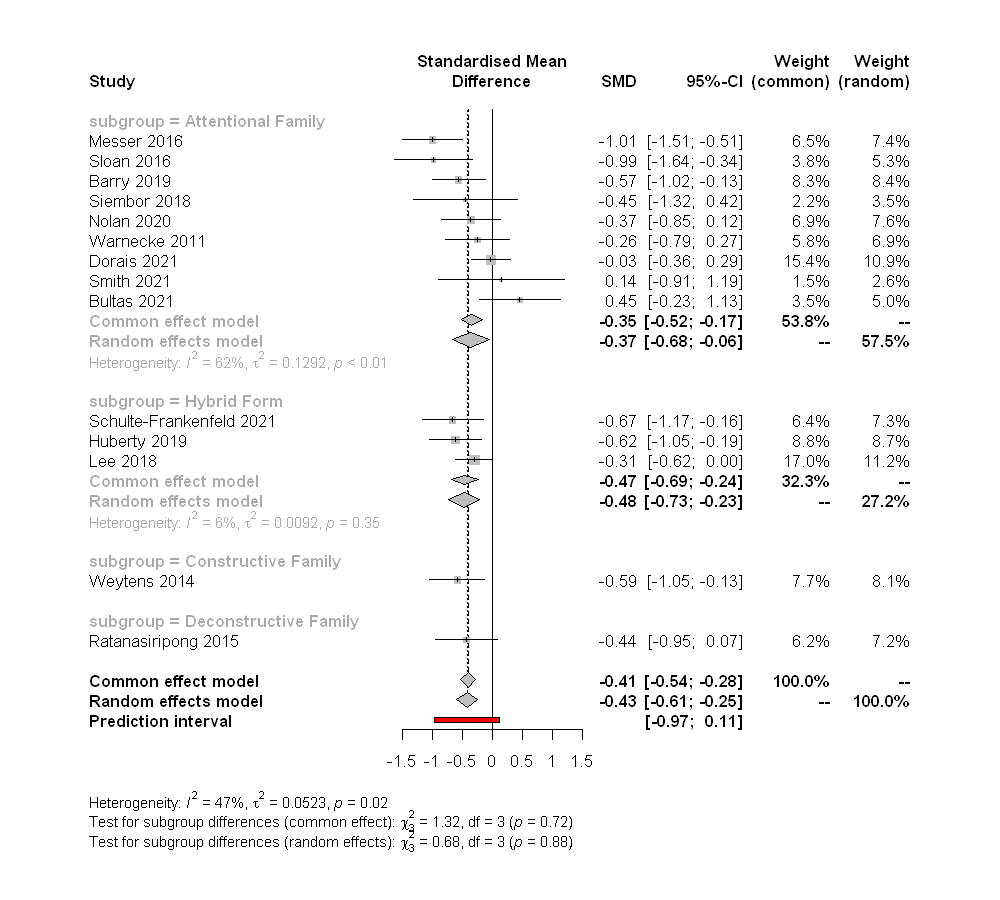

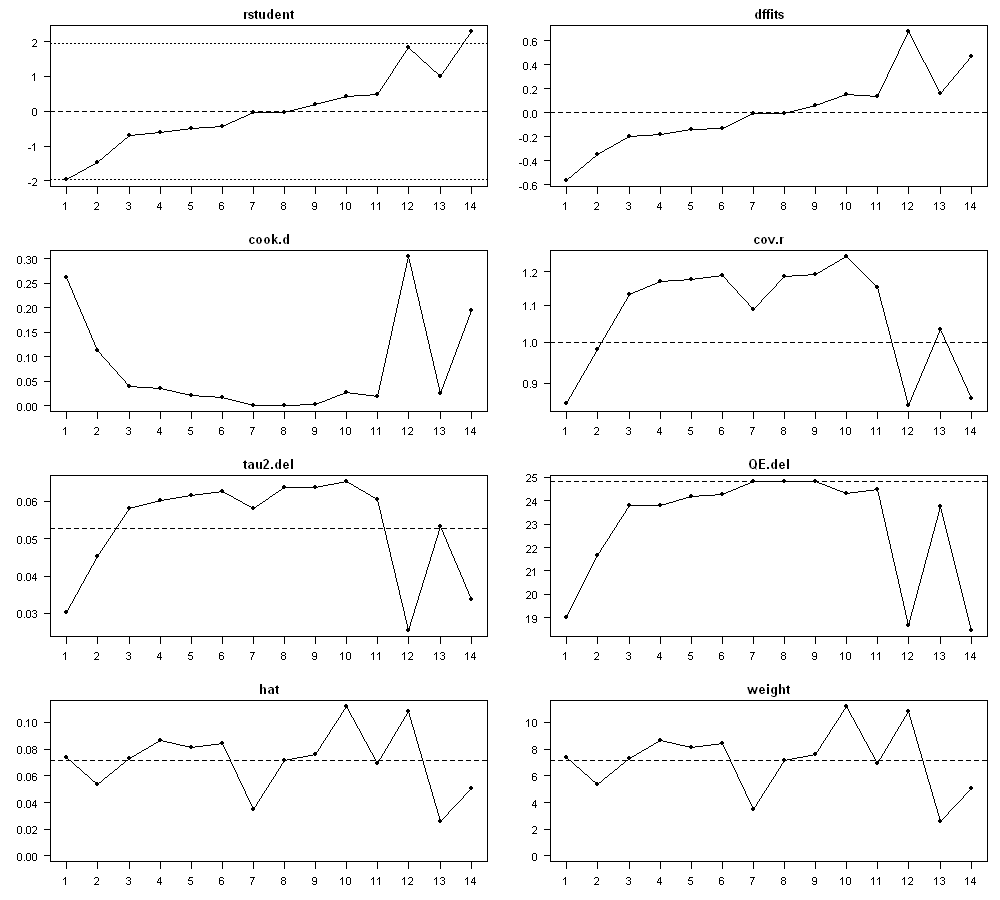

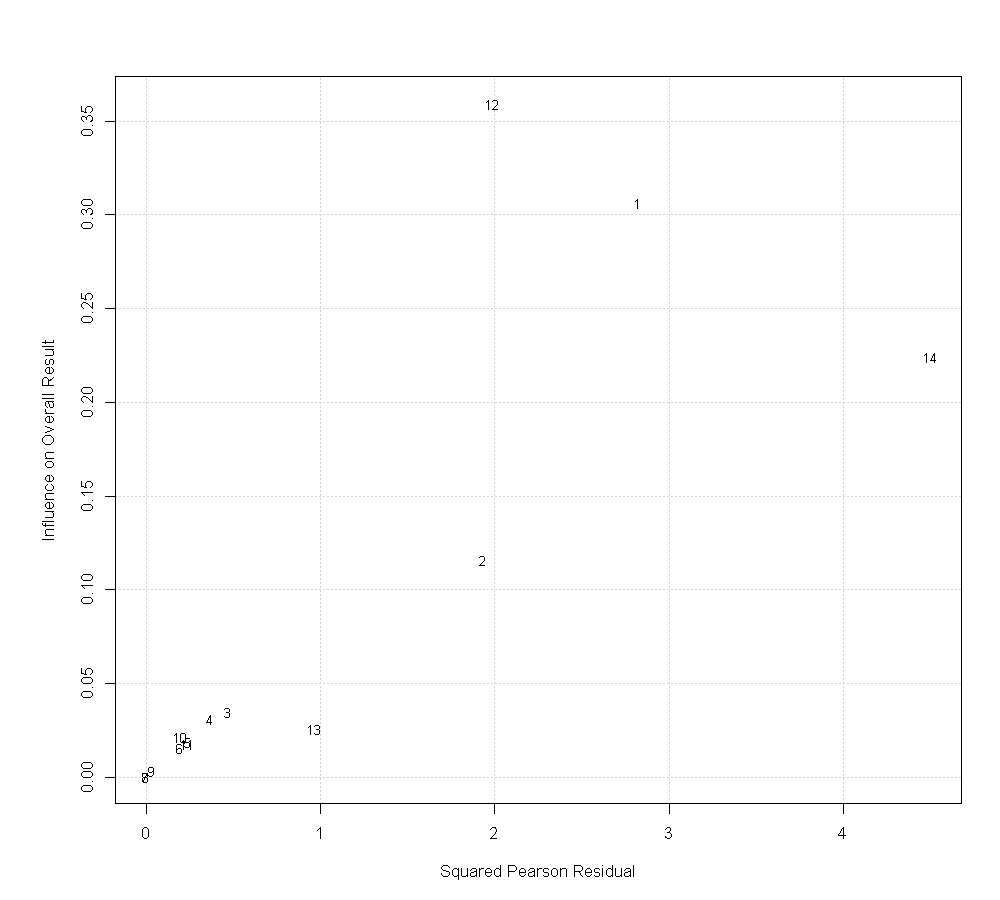

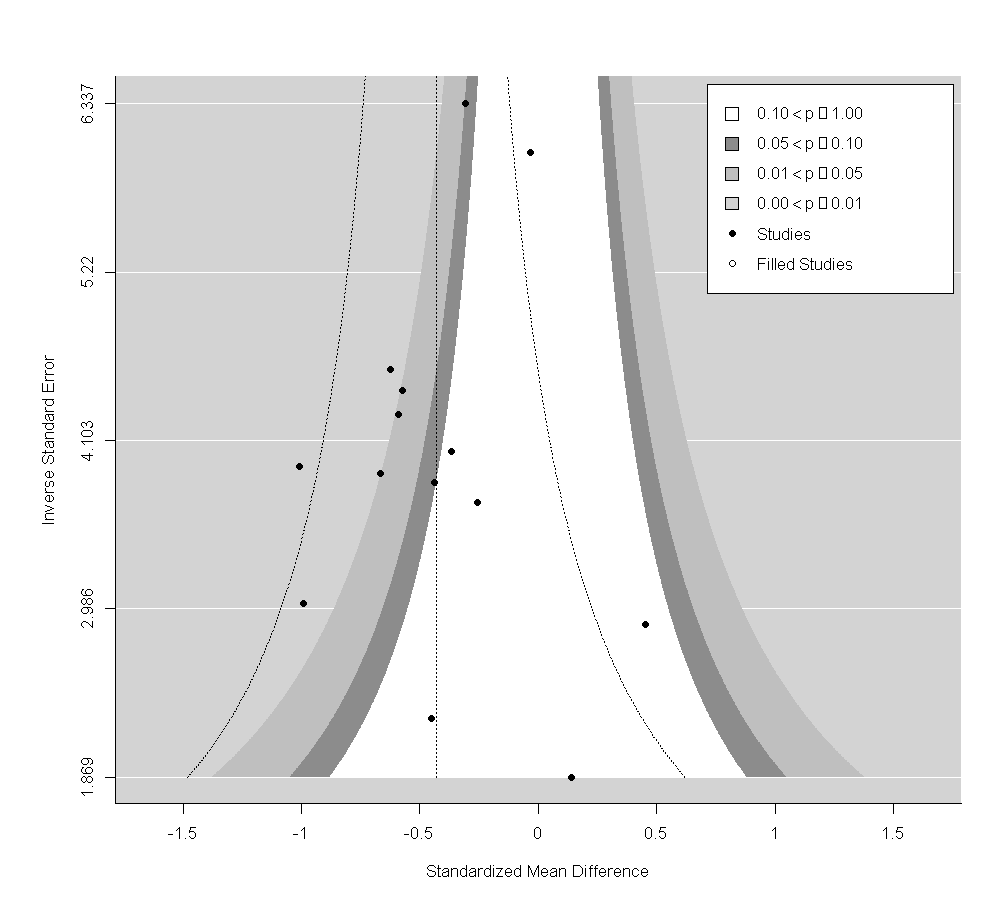

[1] "sessions.duration"

Mixed-Effects Model (k = 10; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0867 (SE = 0.0792)
tau (square root of estimated tau^2 value):             0.2944
I^2 (residual heterogeneity / unaccounted variability): 56.73%
H^2 (unaccounted variability / sampling variability):   2.31
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 8) = 18.1676, p-val = 0.0200

Test of Moderators (coefficient 2):
QM(df = 1) = 0.3280, p-val = 0.5668

Model Results:

                   estimate      se     zval    pval    ci.lb    ci.ub    
intrcpt             -0.6096  0.2797  -2.1795  0.0293  -1.1578  -0.0614  * 
sessions.duration    0.0090  0.0158   0.5727  0.5668  -0.0219   0.0399    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



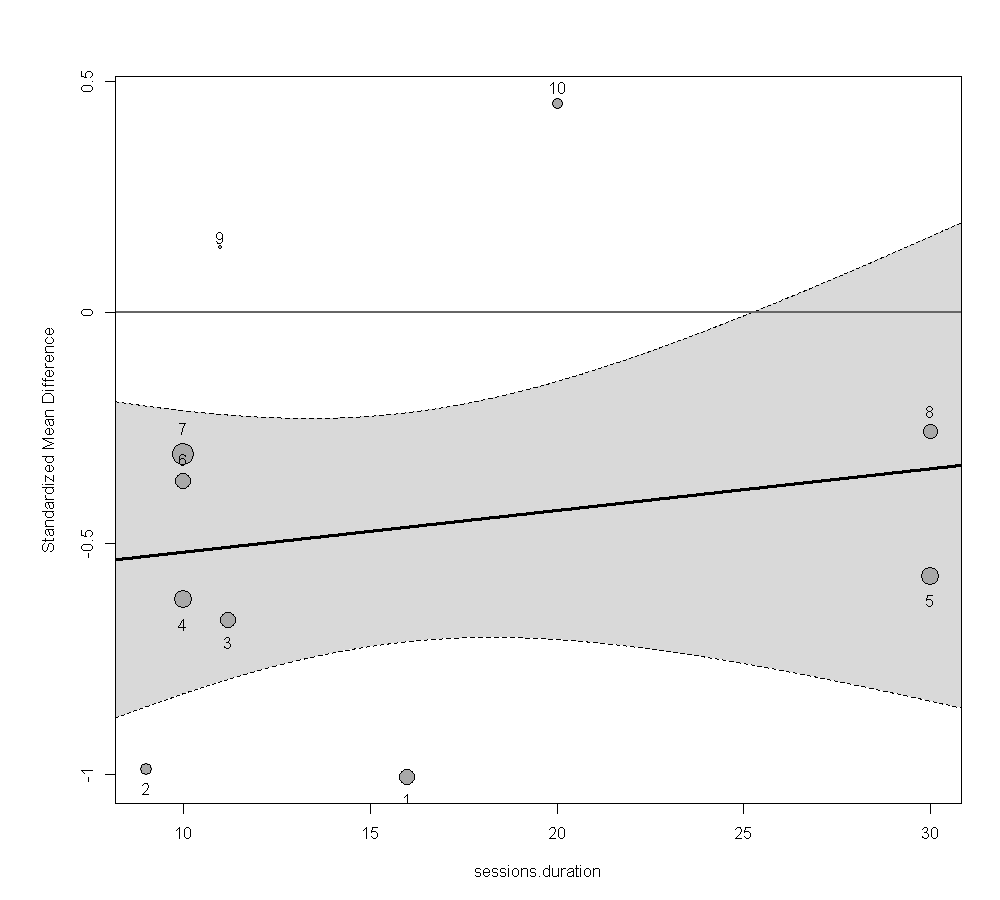

[1] "sessions.frequency"

Mixed-Effects Model (k = 11; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0553 (SE = 0.0550)
tau (square root of estimated tau^2 value):             0.2351
I^2 (residual heterogeneity / unaccounted variability): 49.04%
H^2 (unaccounted variability / sampling variability):   1.96
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 9) = 18.4186, p-val = 0.0306

Test of Moderators (coefficient 2):
QM(df = 1) = 0.1285, p-val = 0.7200

Model Results:

                    estimate      se     zval    pval    ci.lb    ci.ub     
intrcpt              -0.3467  0.1345  -2.5785  0.0099  -0.6102  -0.0832  ** 
sessions.frequency   -0.0035  0.0097  -0.3584  0.7200  -0.0225   0.0156     

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



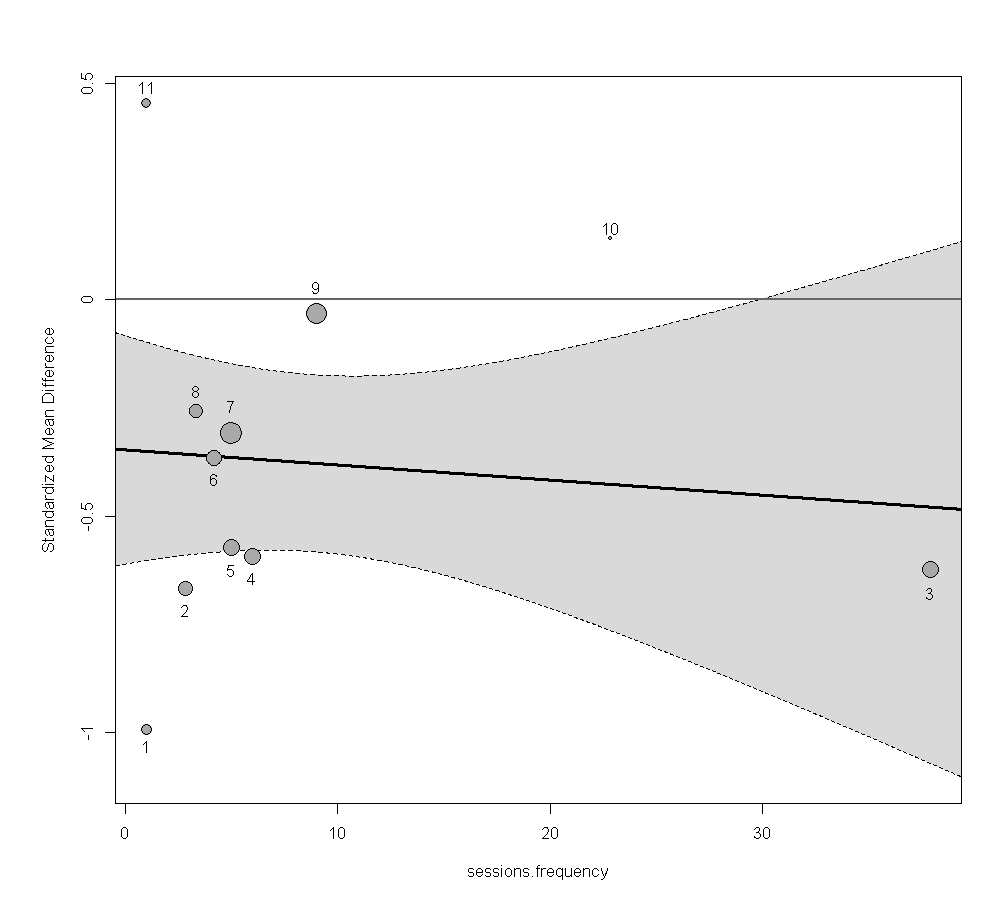

[1] "programs.duration"

Mixed-Effects Model (k = 13; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0450 (SE = 0.0463)
tau (square root of estimated tau^2 value):             0.2121
I^2 (residual heterogeneity / unaccounted variability): 42.27%
H^2 (unaccounted variability / sampling variability):   1.73
R^2 (amount of heterogeneity accounted for):            29.40%

Test for Residual Heterogeneity:
QE(df = 11) = 19.5292, p-val = 0.0522

Test of Moderators (coefficient 2):
QM(df = 1) = 2.8538, p-val = 0.0912

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt             -0.0600  0.2412  -0.2488  0.8036  -0.5327  0.4127    
programs.duration   -0.0096  0.0057  -1.6893  0.0912  -0.0207  0.0015  . 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



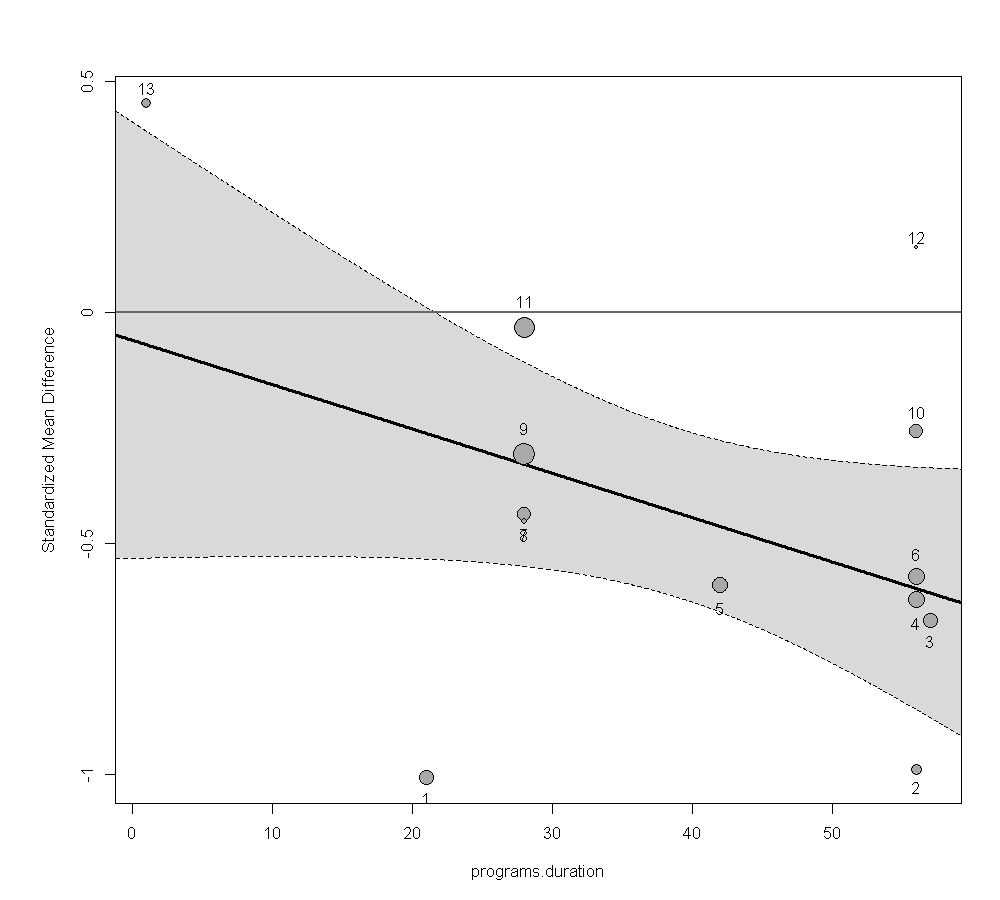

[1] "follow.up.period"

Mixed-Effects Model (k = 18; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0305 (SE = 0.0307)
tau (square root of estimated tau^2 value):             0.1746
I^2 (residual heterogeneity / unaccounted variability): 35.24%
H^2 (unaccounted variability / sampling variability):   1.54
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 16) = 26.0976, p-val = 0.0527

Test of Moderators (coefficient 2):
QM(df = 1) = 0.2406, p-val = 0.6238

Model Results:

                  estimate      se     zval    pval    ci.lb    ci.ub      
intrcpt            -0.4266  0.0773  -5.5206  <.0001  -0.5780  -0.2751  *** 
follow.up.period    0.0009  0.0019   0.4905  0.6238  -0.0027   0.0046      

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "delivery.mode"

Mixed-Effects Model (k = 14; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0621 (

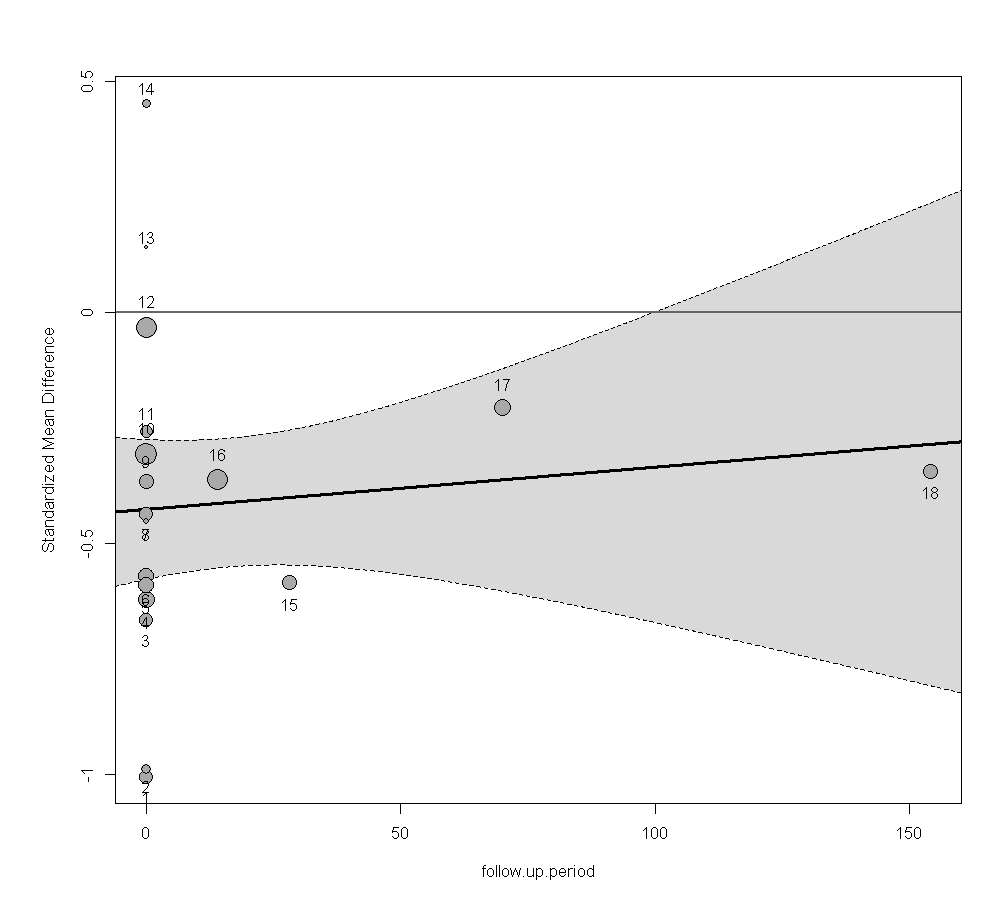

In [426]:
results.metafor.stress.dass <- print.meta.results("Stress", preferred.scale = "DASS", return.data = "results.metafor")

Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.62 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0523 [0.0000; 0.3070]; tau = 0.2287 [0.0000; 0.5540]
 I^2 = 47.5% [2.4%; 71.7%]; H = 1.38 [1.01; 1.88]

Test of heterogeneity:
     Q d.f. p-value
 24.75   13  0.0249

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.6

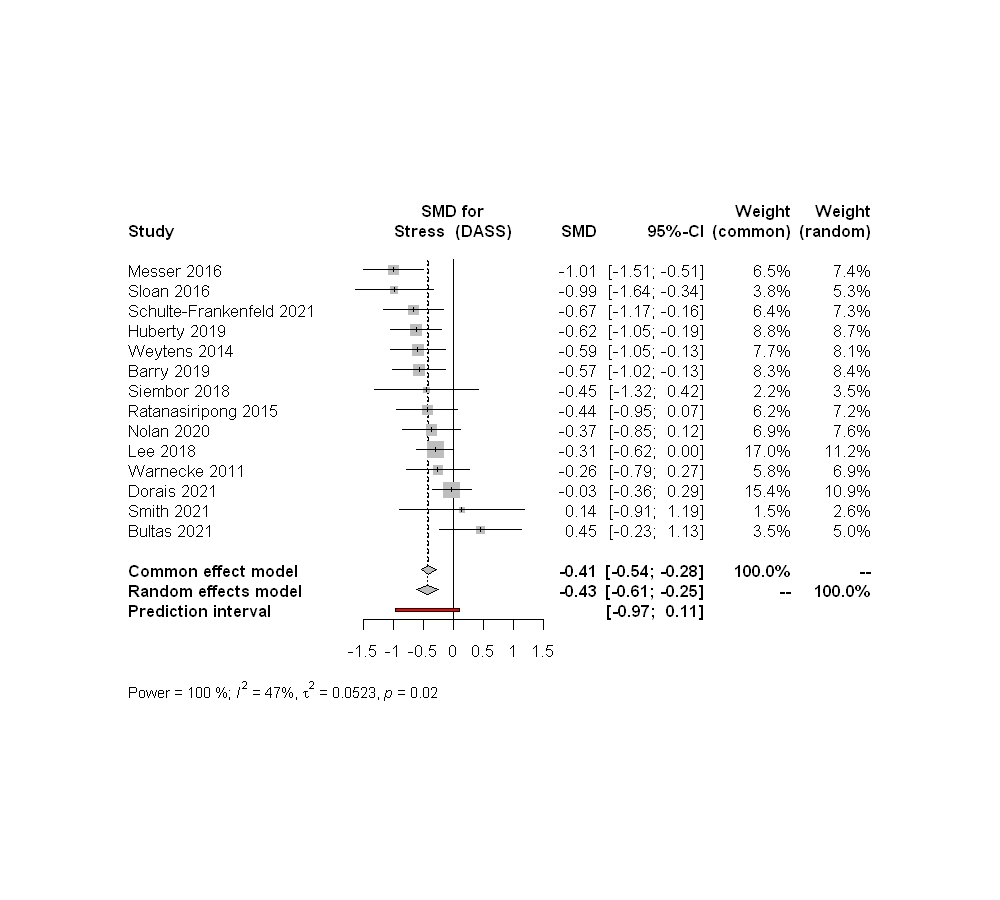


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.62 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0523 [0.0000; 0.3070]; tau = 0.2287 [0.0000; 0.5540]
 I^2 = 47.5% [2.4%; 71.7%]; H = 1.38 [1.01; 1.88]

Test of heterogeneity:
     Q d.f. p-value
 24.75   13  0.0249

Results for subgroups (common effect model):
                                   k     SMD             95%-CI     Q   I^2
subgroup = Attentional Family      9 -0.3490 [-0.5231; -0.1750] 21.30 62.4%
subgroup = Hybrid Form             3 -0.4653 [-0.6900; -0.2405]  2.13  6.0%
subgroup = Constructive Family     1 -0.5922 [-1.0510; -0.1335]  0.00    --
subgroup = Deconstructive Family   1 -0.4381 [-0.9508;  0.0747]  0.00    --

Test for subgroup differences (common effect model):
                  

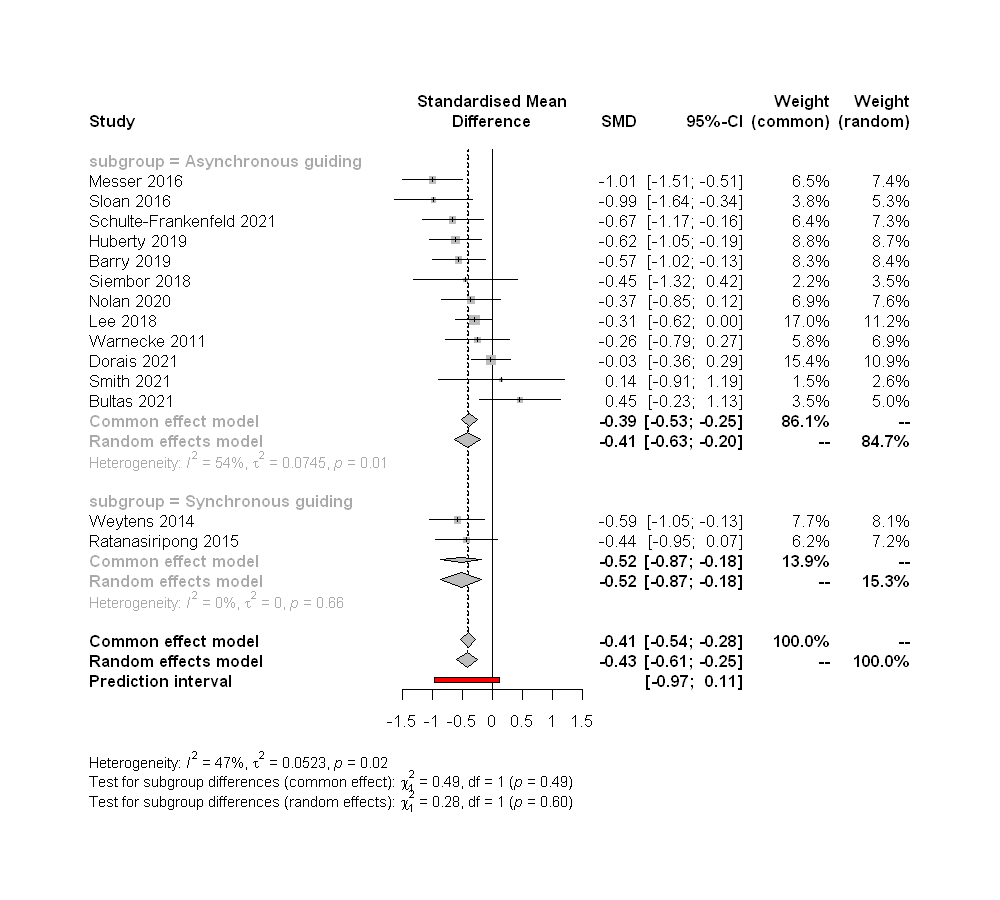

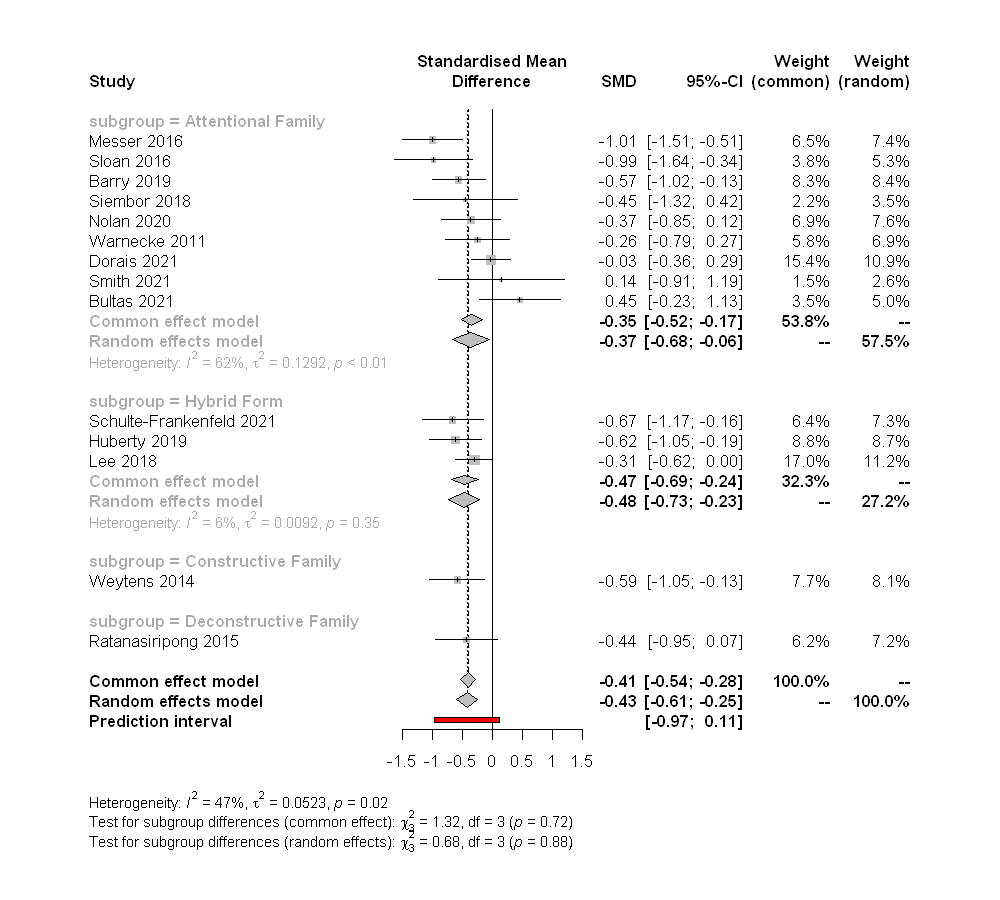

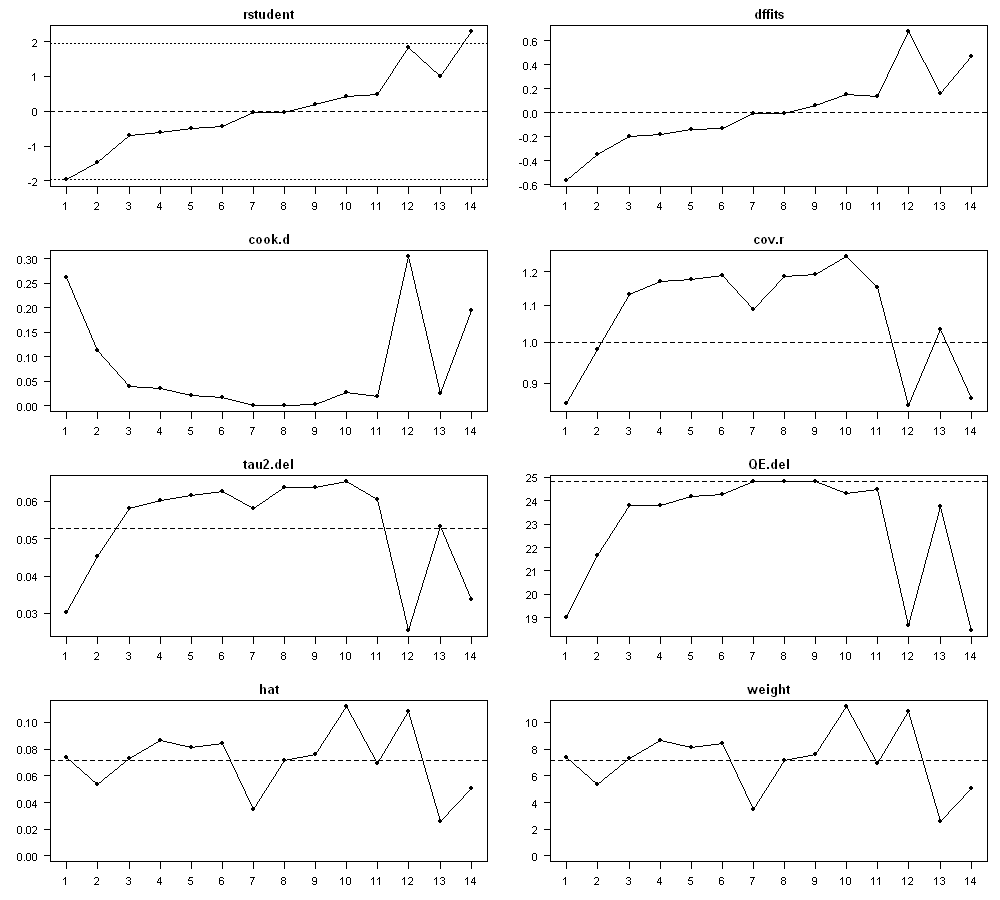

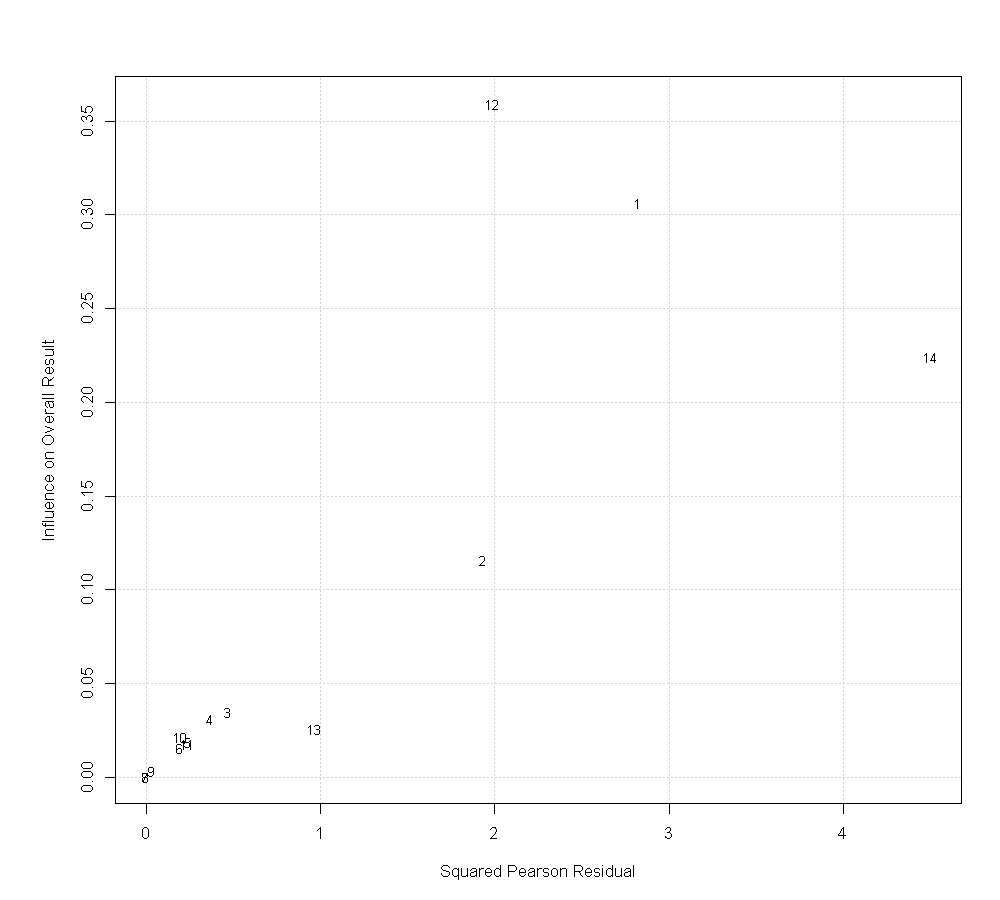

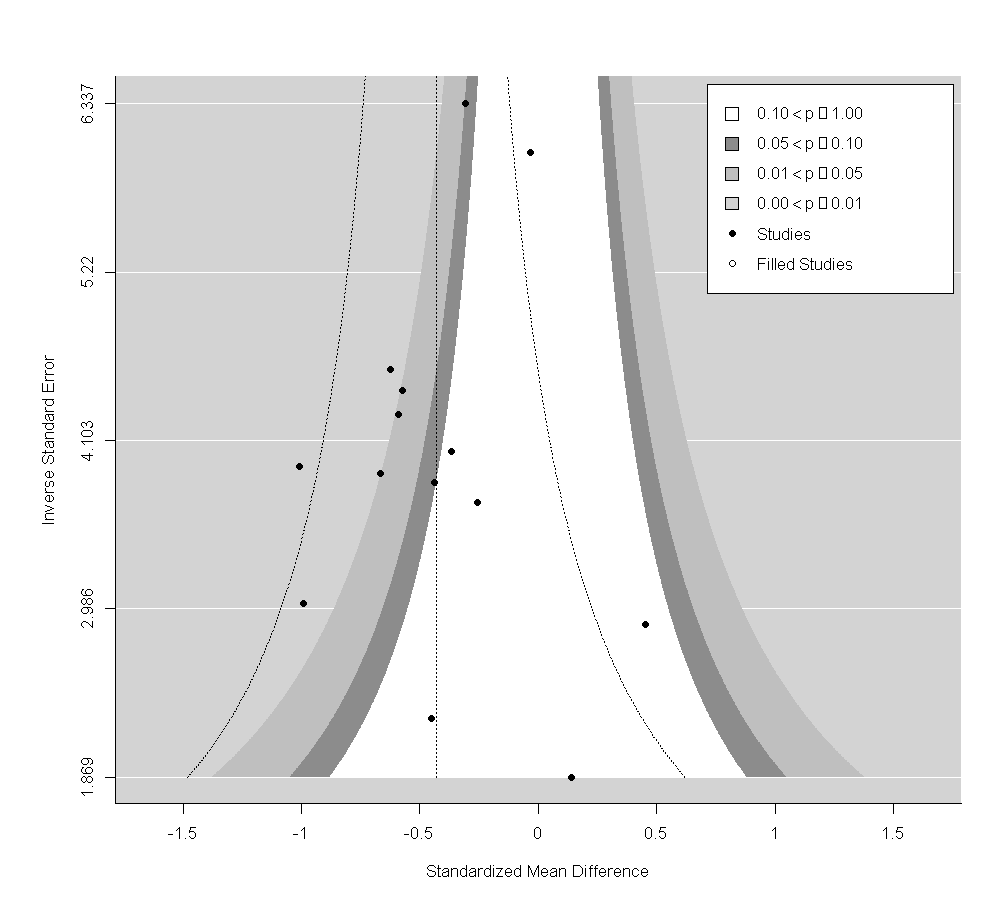

[1] "sessions.duration"

Mixed-Effects Model (k = 10; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0867 (SE = 0.0792)
tau (square root of estimated tau^2 value):             0.2944
I^2 (residual heterogeneity / unaccounted variability): 56.73%
H^2 (unaccounted variability / sampling variability):   2.31
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 8) = 18.1676, p-val = 0.0200

Test of Moderators (coefficient 2):
QM(df = 1) = 0.3280, p-val = 0.5668

Model Results:

                   estimate      se     zval    pval    ci.lb    ci.ub    
intrcpt             -0.6096  0.2797  -2.1795  0.0293  -1.1578  -0.0614  * 
sessions.duration    0.0090  0.0158   0.5727  0.5668  -0.0219   0.0399    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



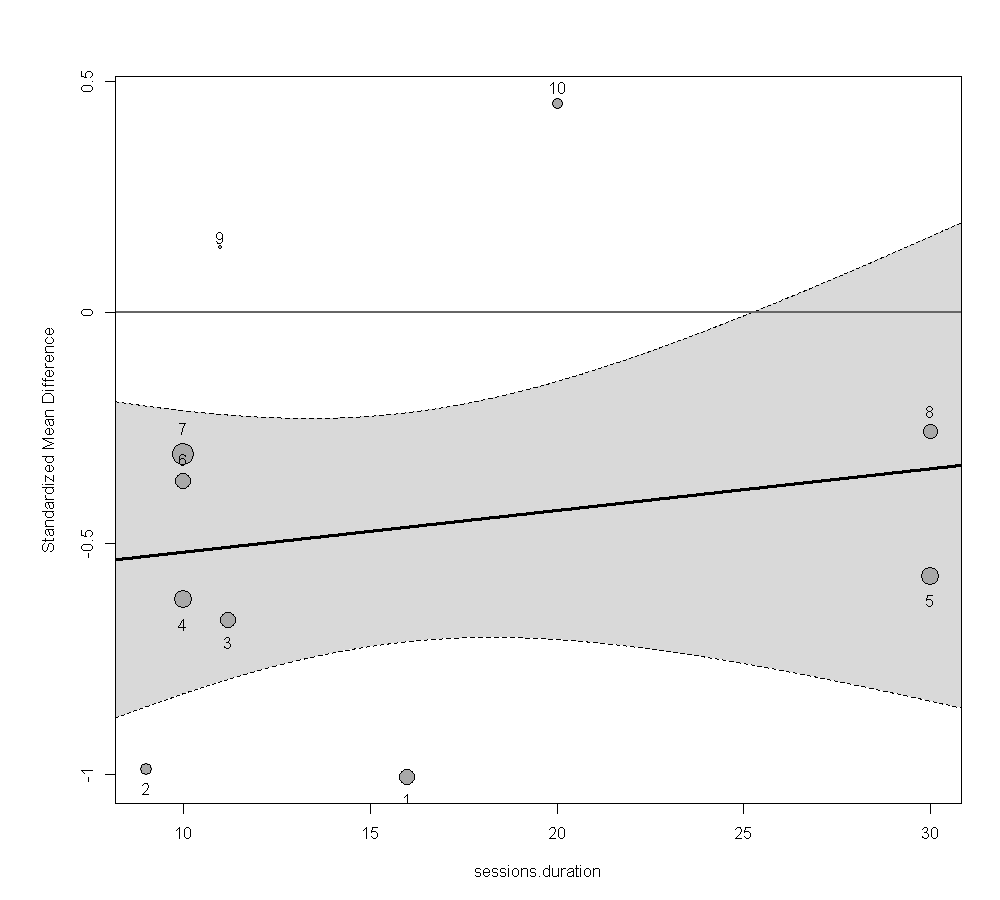

[1] "sessions.frequency"

Mixed-Effects Model (k = 11; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0553 (SE = 0.0550)
tau (square root of estimated tau^2 value):             0.2351
I^2 (residual heterogeneity / unaccounted variability): 49.04%
H^2 (unaccounted variability / sampling variability):   1.96
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 9) = 18.4186, p-val = 0.0306

Test of Moderators (coefficient 2):
QM(df = 1) = 0.1285, p-val = 0.7200

Model Results:

                    estimate      se     zval    pval    ci.lb    ci.ub     
intrcpt              -0.3467  0.1345  -2.5785  0.0099  -0.6102  -0.0832  ** 
sessions.frequency   -0.0035  0.0097  -0.3584  0.7200  -0.0225   0.0156     

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



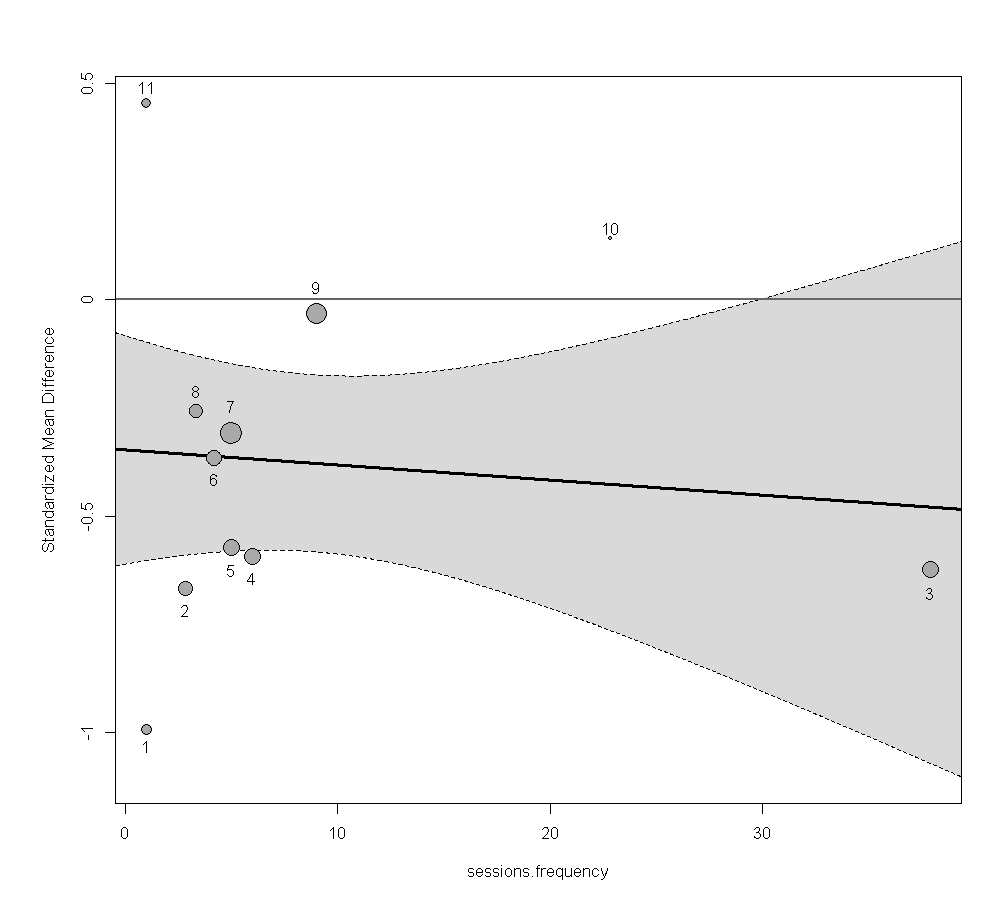

[1] "programs.duration"

Mixed-Effects Model (k = 13; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0450 (SE = 0.0463)
tau (square root of estimated tau^2 value):             0.2121
I^2 (residual heterogeneity / unaccounted variability): 42.27%
H^2 (unaccounted variability / sampling variability):   1.73
R^2 (amount of heterogeneity accounted for):            29.40%

Test for Residual Heterogeneity:
QE(df = 11) = 19.5292, p-val = 0.0522

Test of Moderators (coefficient 2):
QM(df = 1) = 2.8538, p-val = 0.0912

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt             -0.0600  0.2412  -0.2488  0.8036  -0.5327  0.4127    
programs.duration   -0.0096  0.0057  -1.6893  0.0912  -0.0207  0.0015  . 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



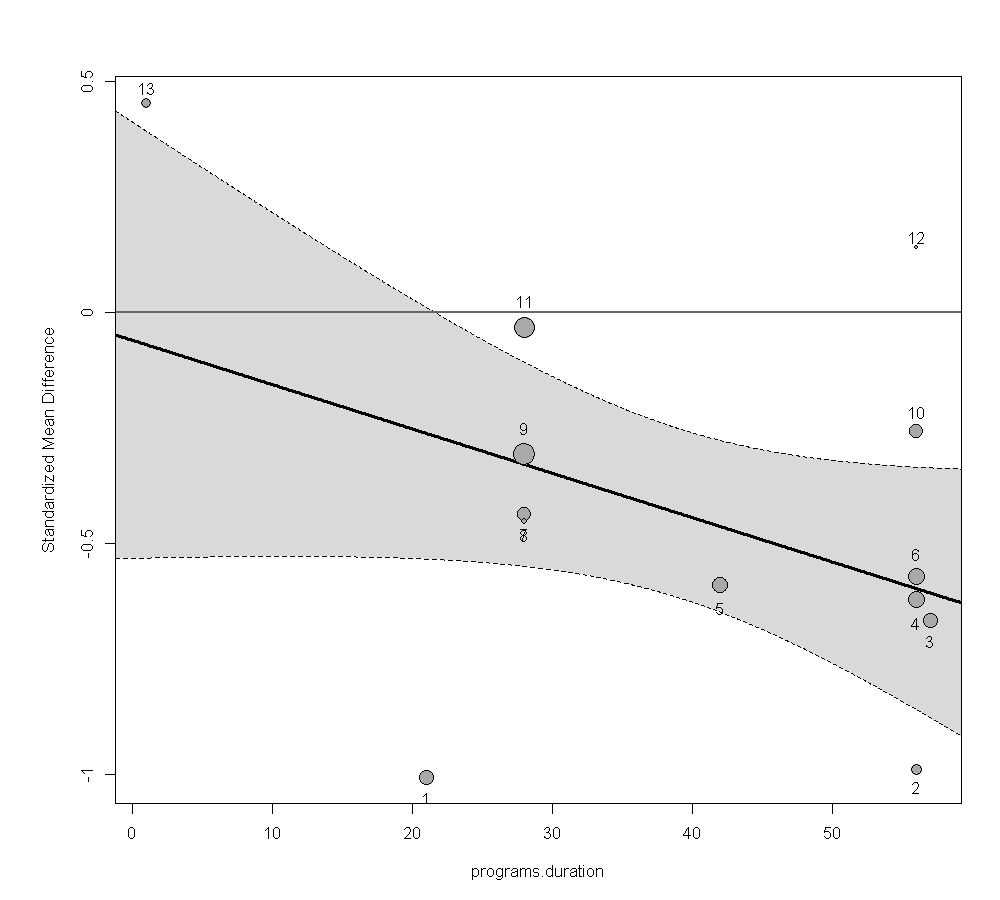

[1] "follow.up.period"

Mixed-Effects Model (k = 18; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0305 (SE = 0.0307)
tau (square root of estimated tau^2 value):             0.1746
I^2 (residual heterogeneity / unaccounted variability): 35.24%
H^2 (unaccounted variability / sampling variability):   1.54
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 16) = 26.0976, p-val = 0.0527

Test of Moderators (coefficient 2):
QM(df = 1) = 0.2406, p-val = 0.6238

Model Results:

                  estimate      se     zval    pval    ci.lb    ci.ub      
intrcpt            -0.4266  0.0773  -5.5206  <.0001  -0.5780  -0.2751  *** 
follow.up.period    0.0009  0.0019   0.4905  0.6238  -0.0027   0.0046      

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "delivery.mode"

Mixed-Effects Model (k = 14; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0621 (

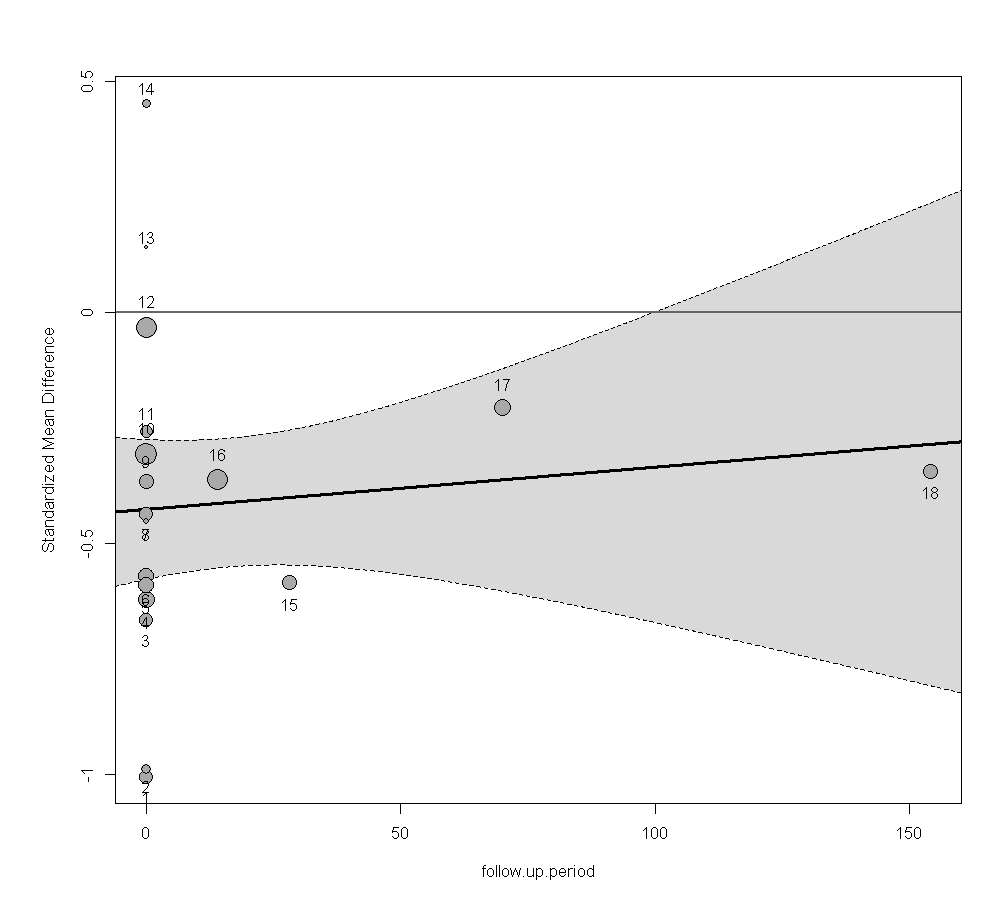

In [427]:
print.meta.results("Stress", preferred.scale = "DASS", exclude.high.rob.vec = studies.high.rob)  # is same for PSS

Number of studies combined: k = 11
Number of observations: o = 732

                         SMD             95%-CI     z  p-value
Common effect model  -0.4775 [-0.6253; -0.3297] -6.33 < 0.0001
Random effects model -0.4775 [-0.6253; -0.3297] -6.33 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1058]; tau = 0 [0.0000; 0.3252]
 I^2 = 0.0% [0.0%; 60.2%]; H = 1.00 [1.00; 1.59]

Test of heterogeneity:
    Q d.f. p-value
 7.16   10  0.7106

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)


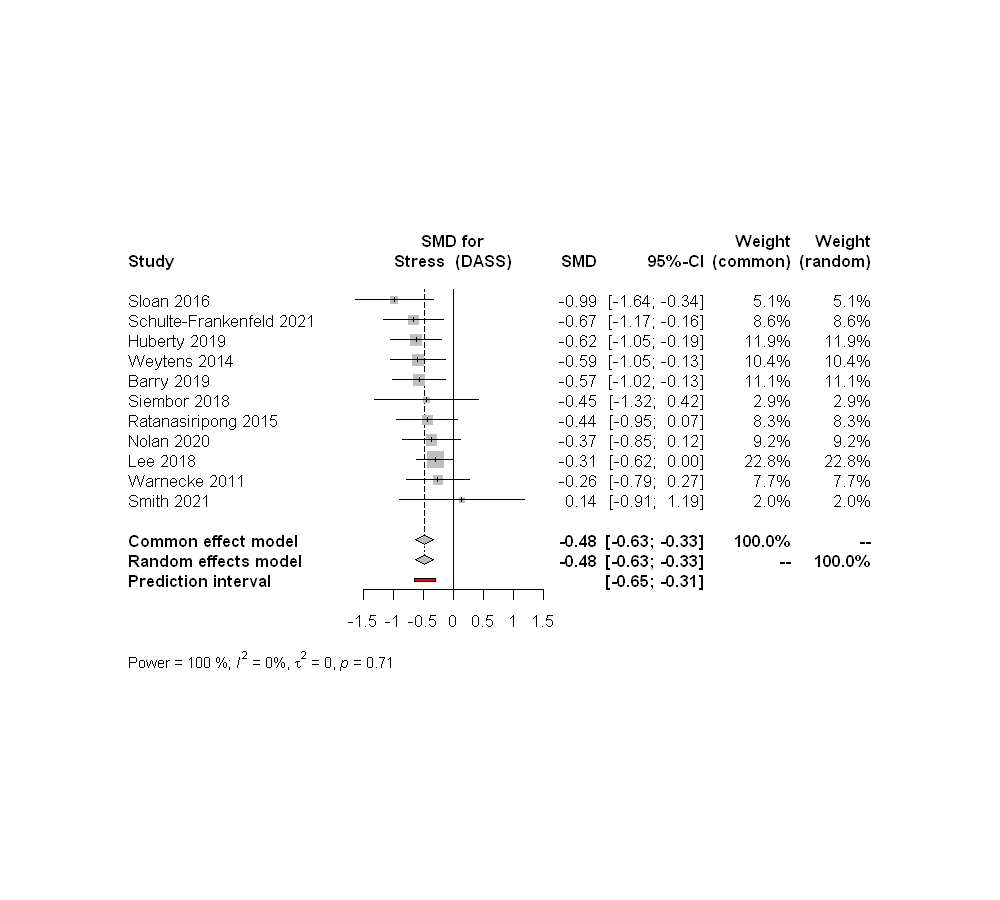

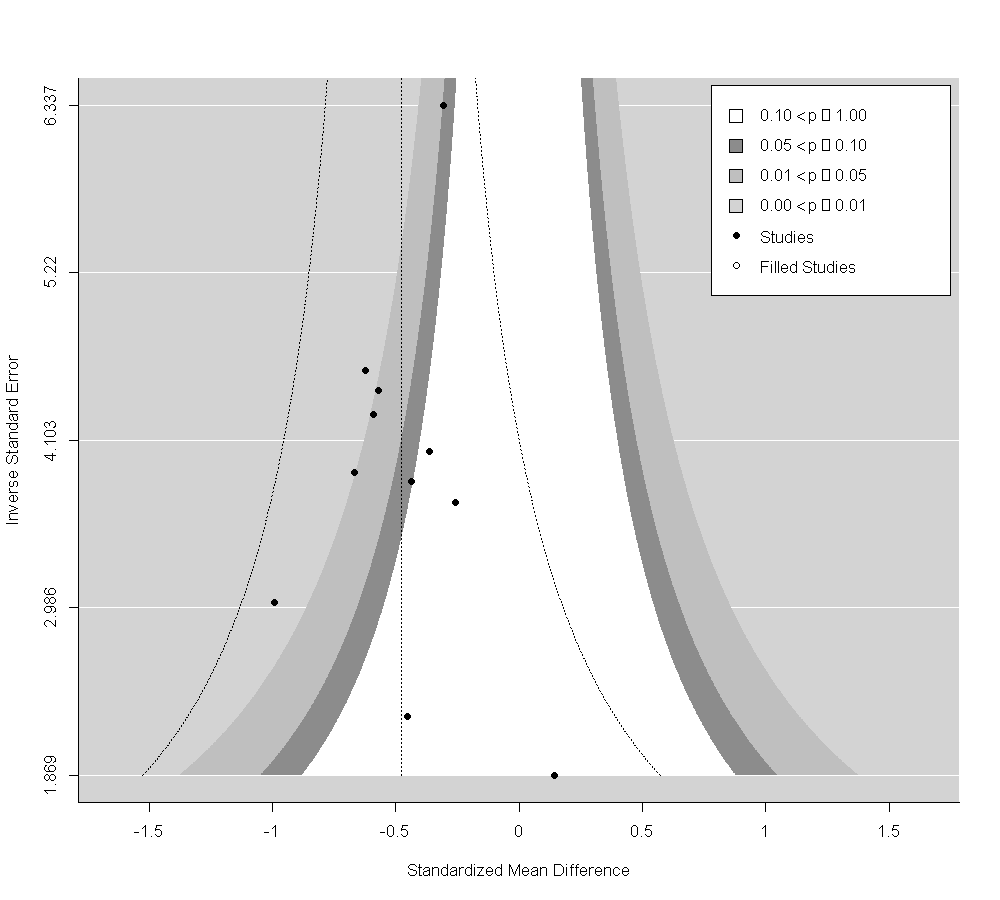

In [428]:
print.meta.results("Stress", preferred.scale = "DASS", filter.forest..funnel.vec = -c(1, 12, 14), regression = F, split.subgroups = F, print.influence = F)

Fitting 16383 models (based on all possible subsets).

Fitting 16383 models (based on all possible subsets).

Fitting 16383 models (based on all possible subsets).



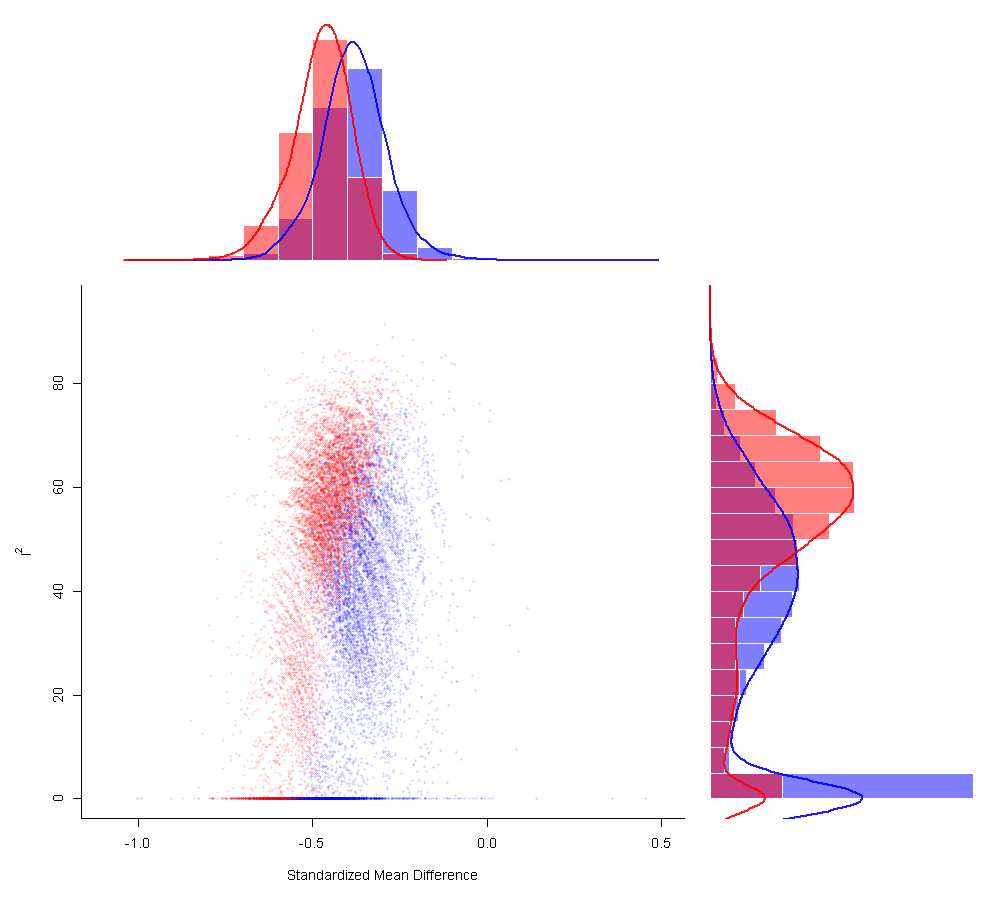

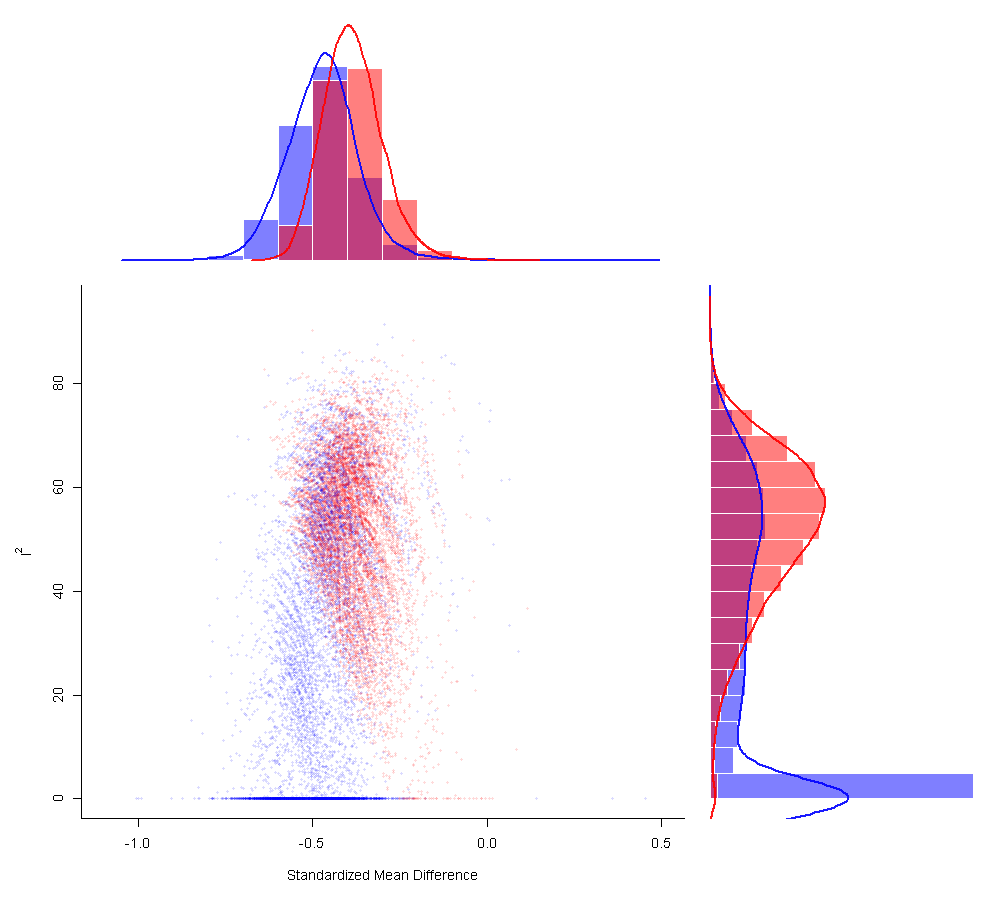

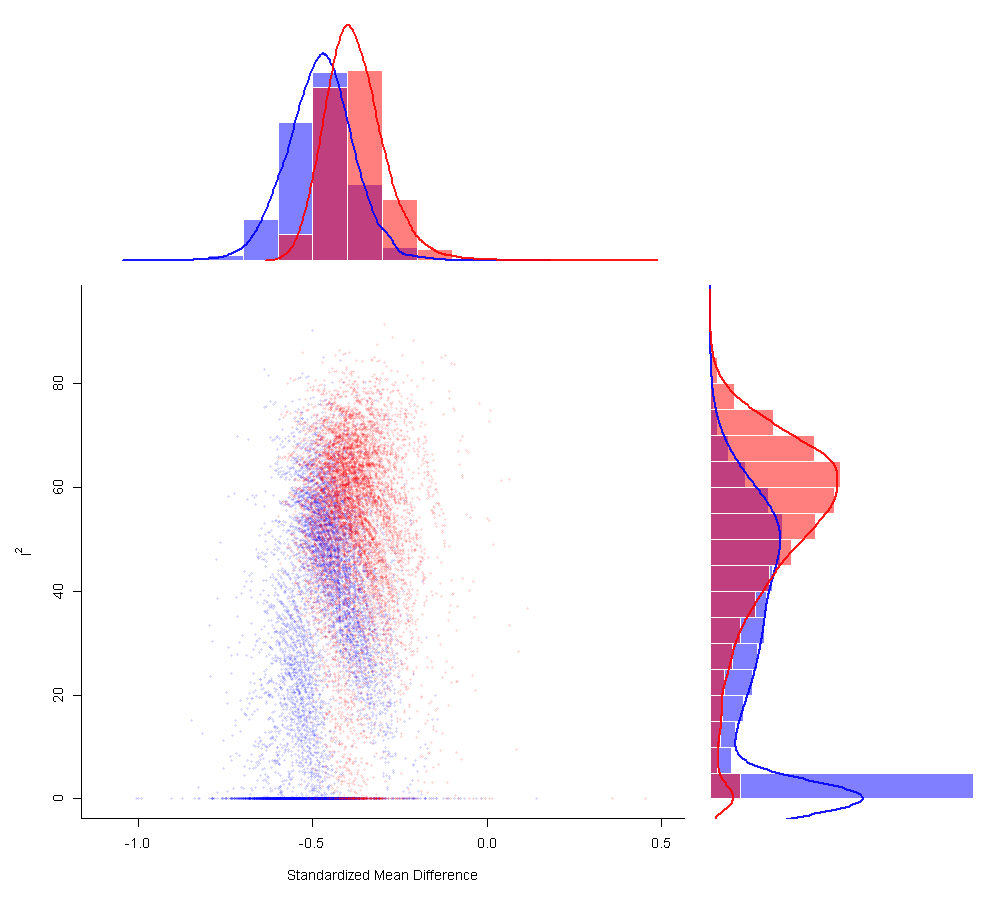

In [389]:
for (outlier in c(1, 12, 14)){
  sav <- gosh(results.metafor.stress.dass)
  plot(sav, out = outlier)
}

Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.3997 [-0.5273; -0.2721] -6.14 < 0.0001
Random effects model -0.4235 [-0.6108; -0.2362] -4.43 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0580 [0.0022; 0.3175]; tau = 0.2409 [0.0473; 0.5635]
 I^2 = 49.4% [6.3%; 72.6%]; H = 1.41 [1.03; 1.91]

Test of heterogeneity:
     Q d.f. p-value
 25.67   13  0.0188

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.3997 [-0.5273; -0.2721] -6.14 < 0.0001
Random effects model -0.4235 [-0.6108; -0.2362] -4.4

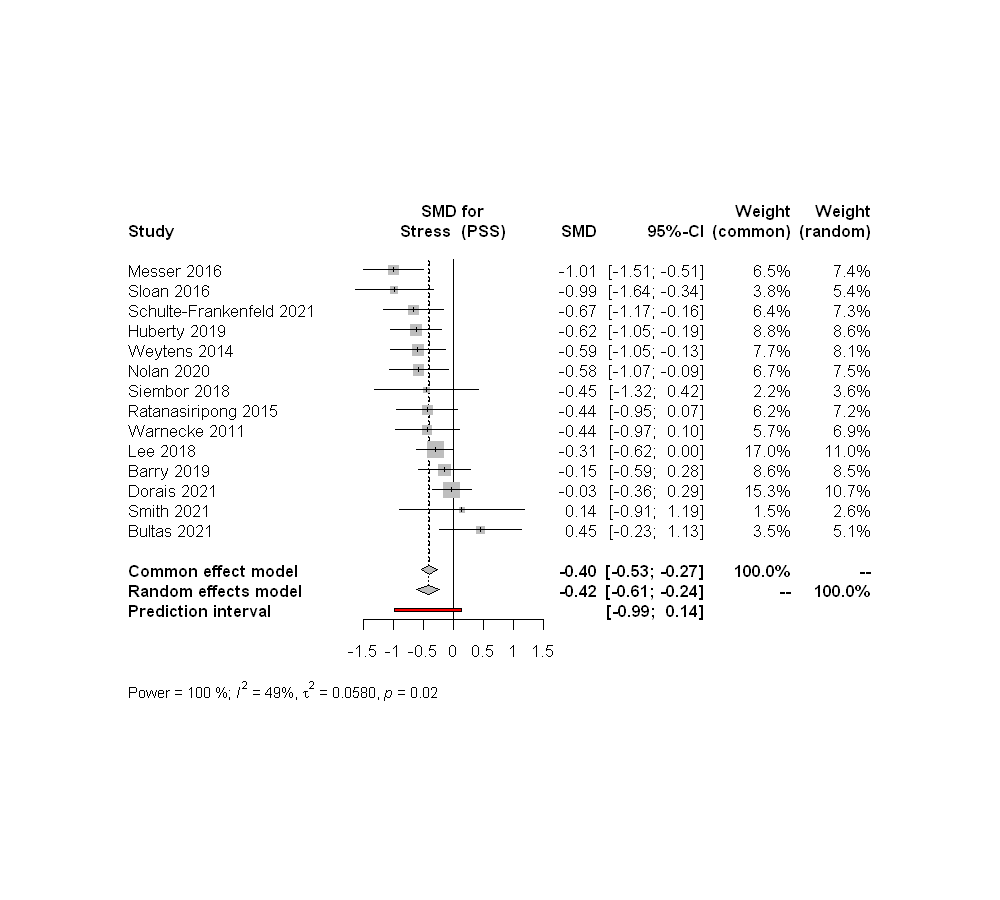


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.3997 [-0.5273; -0.2721] -6.14 < 0.0001
Random effects model -0.4235 [-0.6108; -0.2362] -4.43 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0580 [0.0022; 0.3175]; tau = 0.2409 [0.0473; 0.5635]
 I^2 = 49.4% [6.3%; 72.6%]; H = 1.41 [1.03; 1.91]

Test of heterogeneity:
     Q d.f. p-value
 25.67   13  0.0188

Results for subgroups (common effect model):
                                   k     SMD             95%-CI     Q   I^2
subgroup = Attentional Family      9 -0.3284 [-0.5023; -0.1544] 21.88 63.4%
subgroup = Hybrid Form             3 -0.4653 [-0.6900; -0.2405]  2.13  6.0%
subgroup = Constructive Family     1 -0.5922 [-1.0510; -0.1335]  0.00    --
subgroup = Deconstructive Family   1 -0.4381 [-0.9508;  0.0747]  0.00    --

Test for subgroup differences (common effect model):
                  

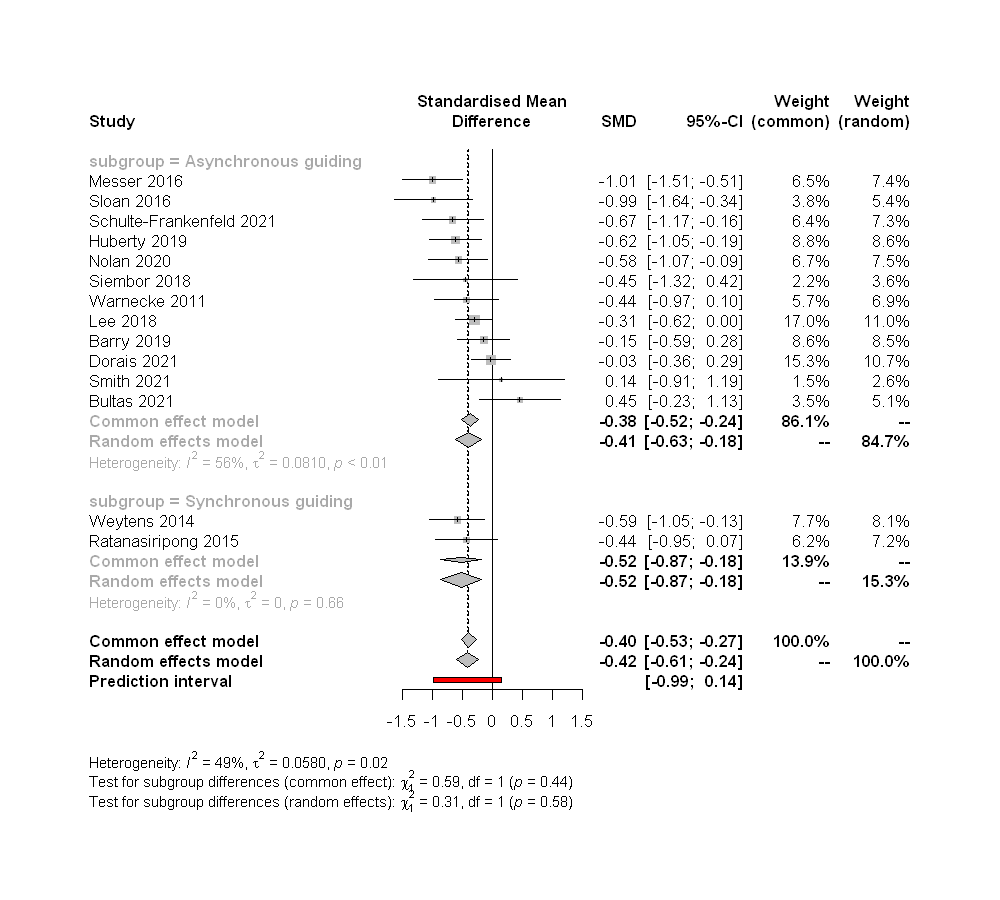

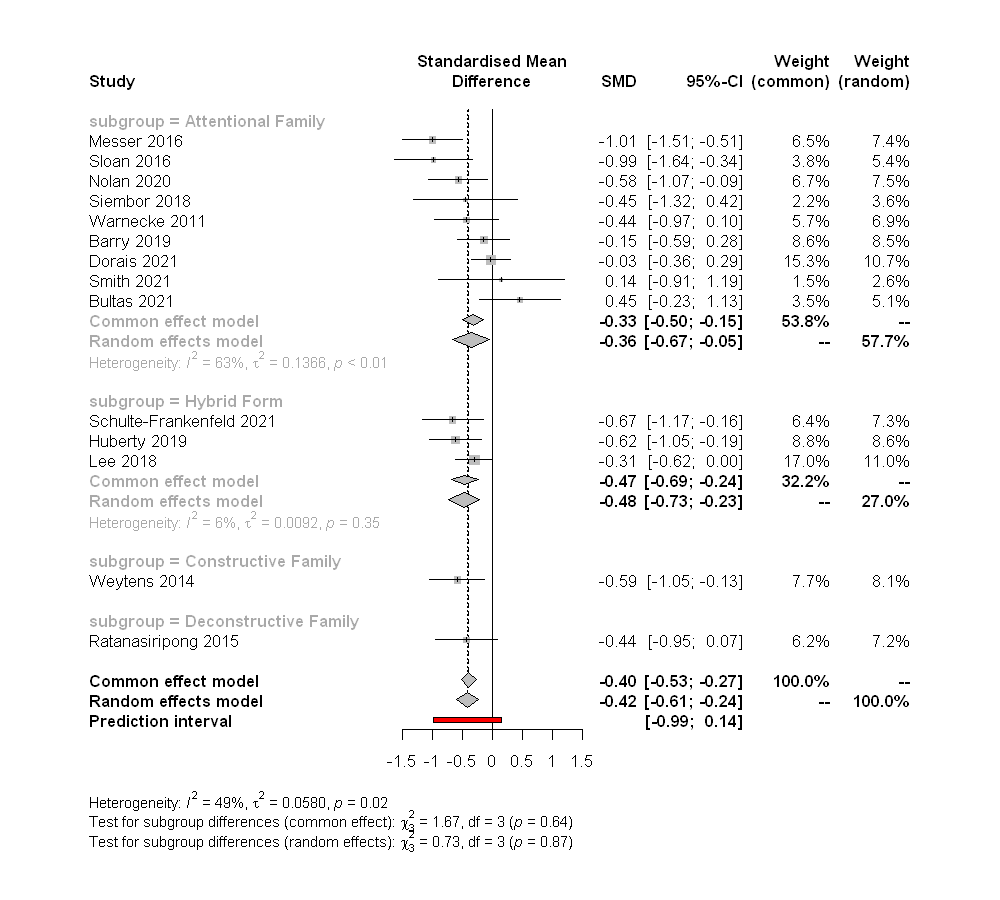

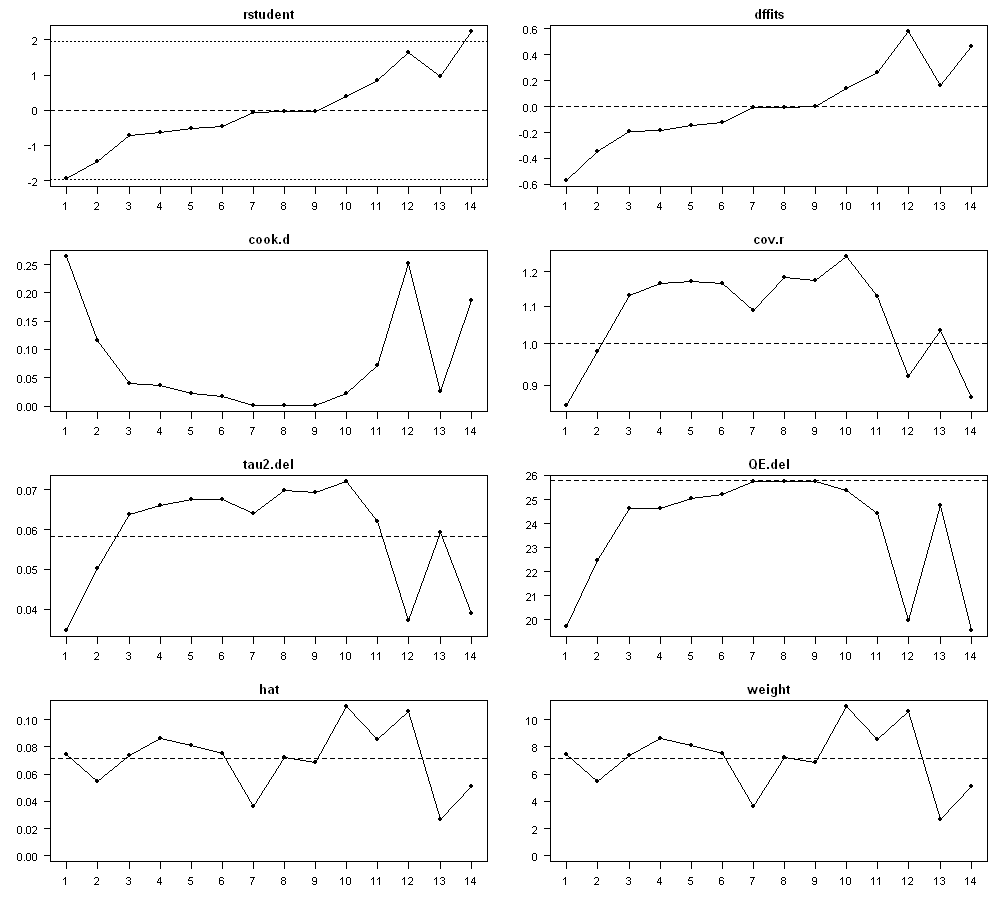

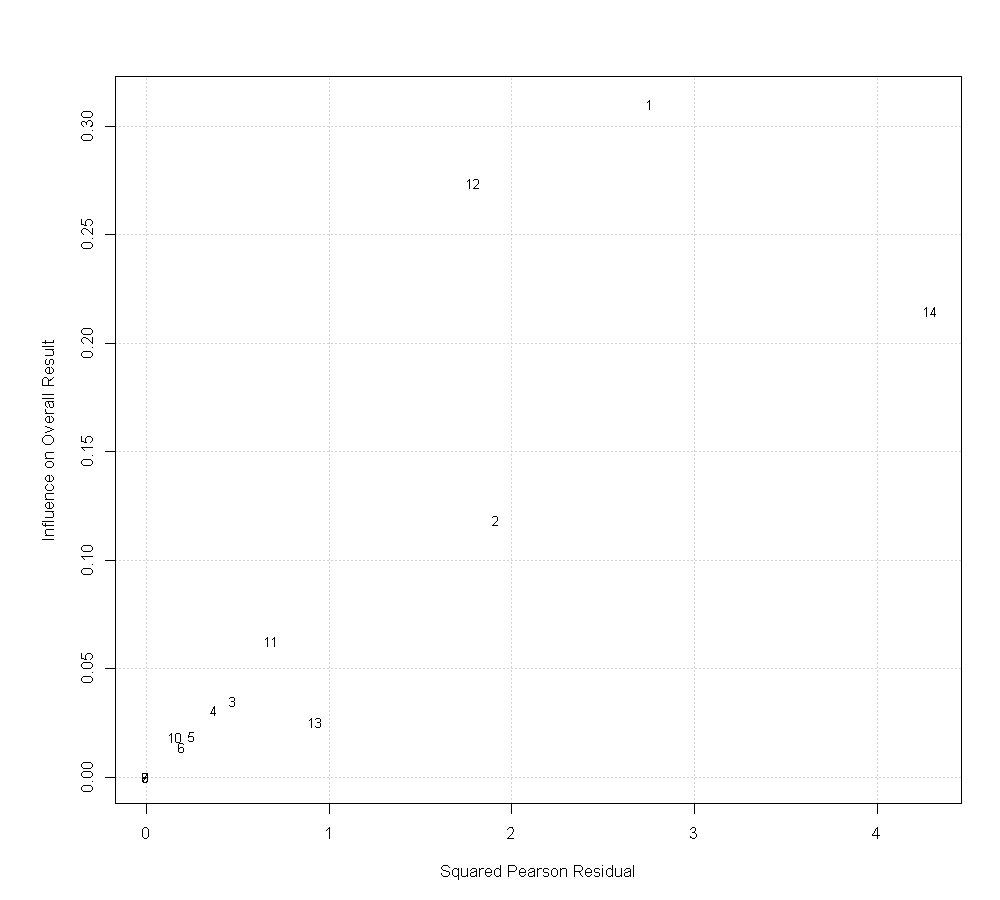

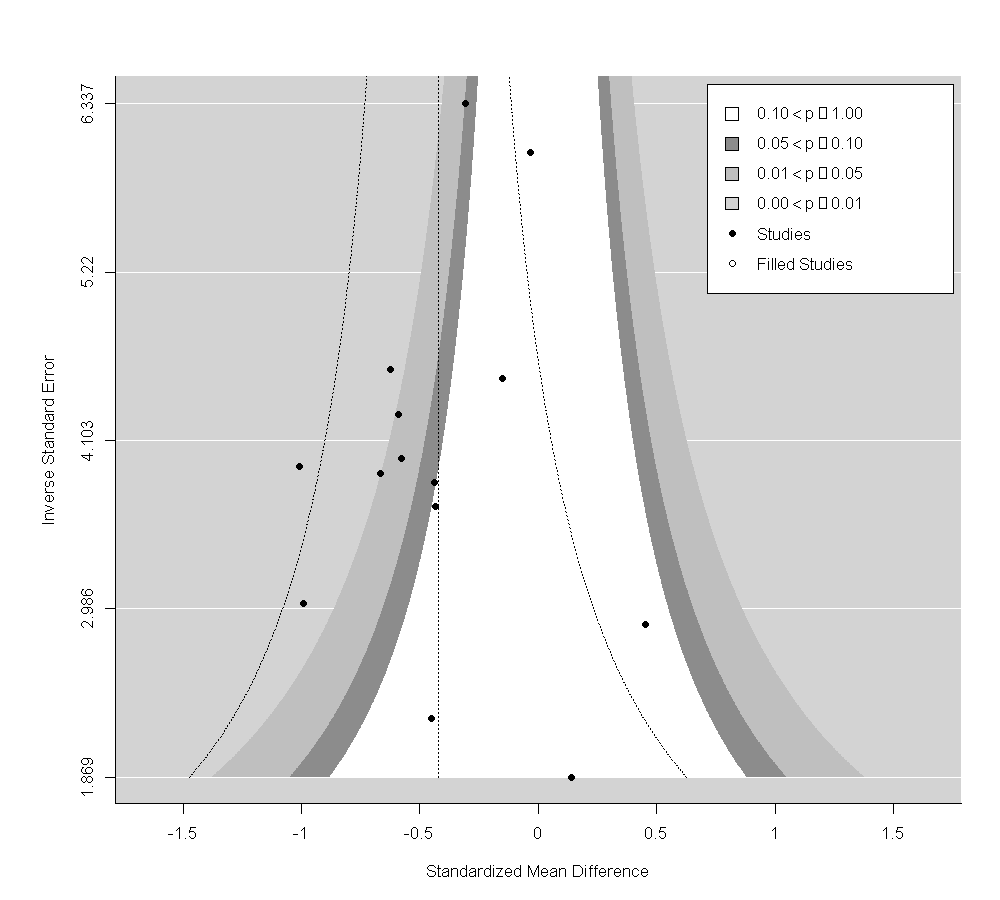

[1] "sessions.duration"

Mixed-Effects Model (k = 10; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0734 (SE = 0.0720)
tau (square root of estimated tau^2 value):             0.2709
I^2 (residual heterogeneity / unaccounted variability): 52.56%
H^2 (unaccounted variability / sampling variability):   2.11
R^2 (amount of heterogeneity accounted for):            5.62%

Test for Residual Heterogeneity:
QE(df = 8) = 17.2690, p-val = 0.0274

Test of Moderators (coefficient 2):
QM(df = 1) = 1.4191, p-val = 0.2335

Model Results:

                   estimate      se     zval    pval    ci.lb    ci.ub     
intrcpt             -0.7425  0.2666  -2.7848  0.0054  -1.2651  -0.2199  ** 
sessions.duration    0.0179  0.0150   1.1913  0.2335  -0.0115   0.0473     

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



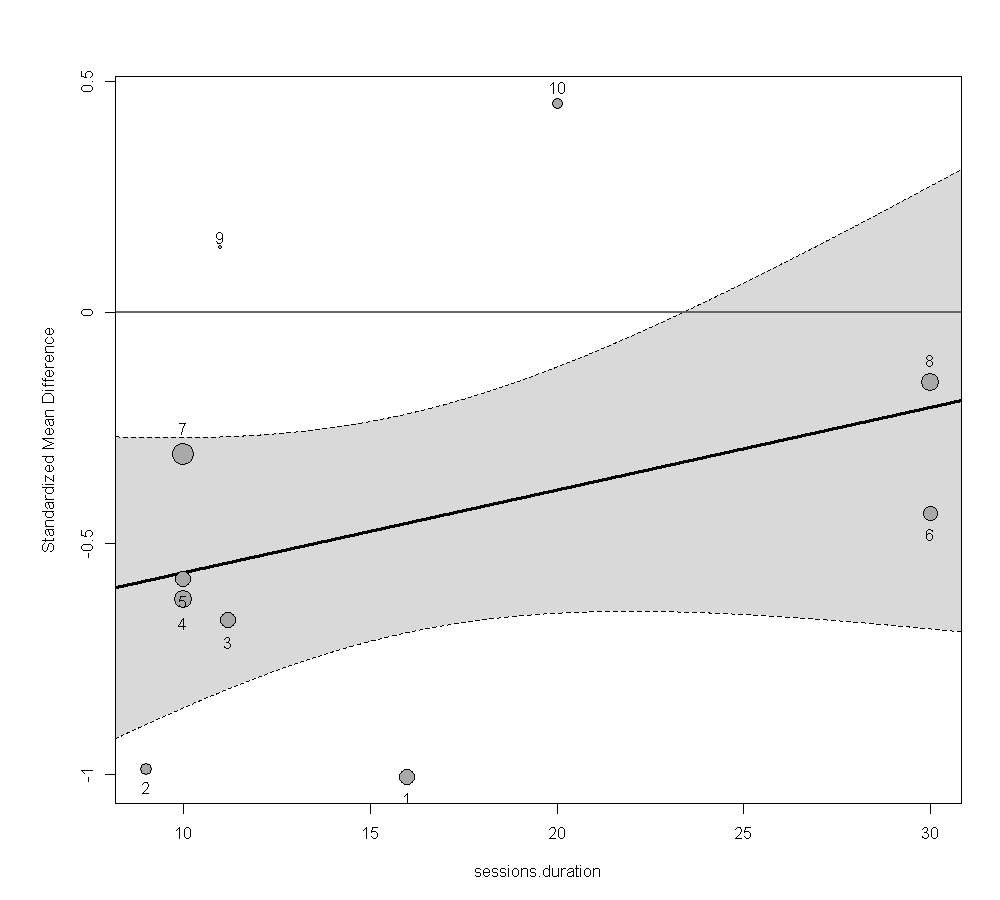

[1] "sessions.frequency"

Mixed-Effects Model (k = 11; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0619 (SE = 0.0584)
tau (square root of estimated tau^2 value):             0.2488
I^2 (residual heterogeneity / unaccounted variability): 51.87%
H^2 (unaccounted variability / sampling variability):   2.08
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 9) = 19.0558, p-val = 0.0247

Test of Moderators (coefficient 2):
QM(df = 1) = 0.1096, p-val = 0.7406

Model Results:

                    estimate      se     zval    pval    ci.lb    ci.ub    
intrcpt              -0.3396  0.1384  -2.4545  0.0141  -0.6109  -0.0684  * 
sessions.frequency   -0.0033  0.0100  -0.3311  0.7406  -0.0229   0.0163    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



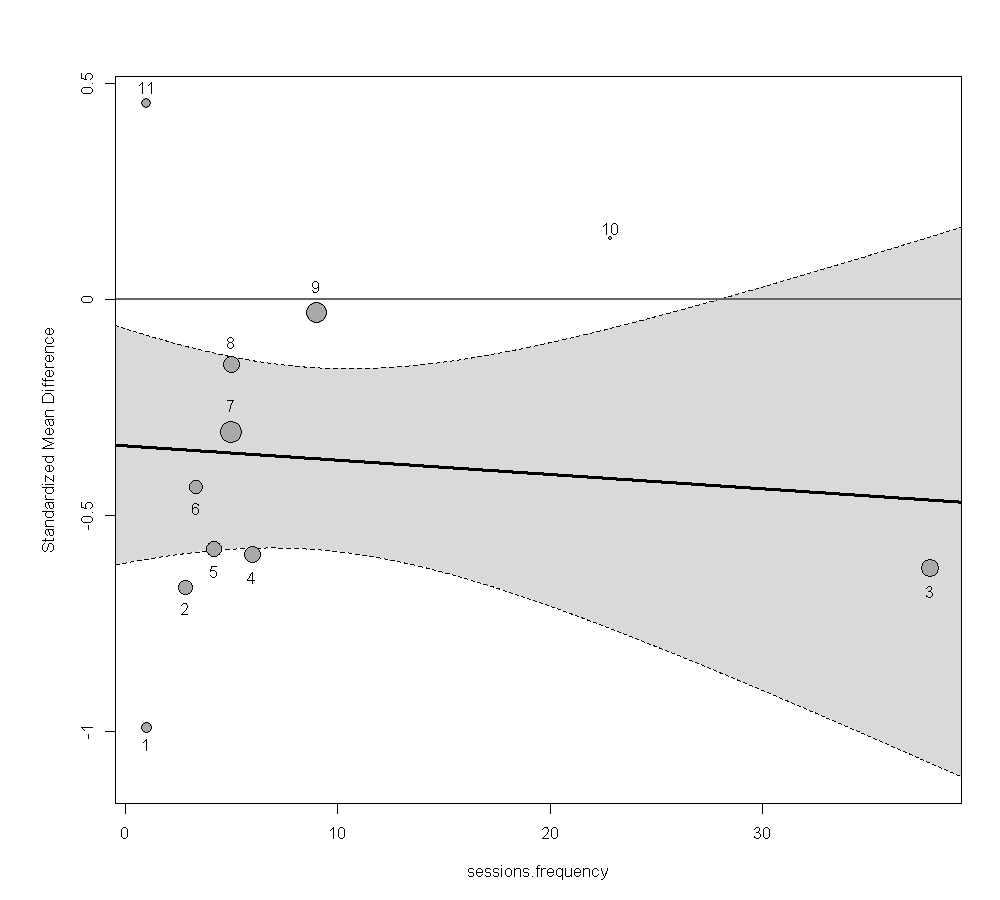

[1] "programs.duration"

Mixed-Effects Model (k = 13; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0614 (SE = 0.0541)
tau (square root of estimated tau^2 value):             0.2477
I^2 (residual heterogeneity / unaccounted variability): 50.02%
H^2 (unaccounted variability / sampling variability):   2.00
R^2 (amount of heterogeneity accounted for):            9.21%

Test for Residual Heterogeneity:
QE(df = 11) = 21.8936, p-val = 0.0252

Test of Moderators (coefficient 2):
QM(df = 1) = 1.7641, p-val = 0.1841

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt             -0.0957  0.2582  -0.3705  0.7110  -0.6017  0.4104    
programs.duration   -0.0081  0.0061  -1.3282  0.1841  -0.0199  0.0038    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



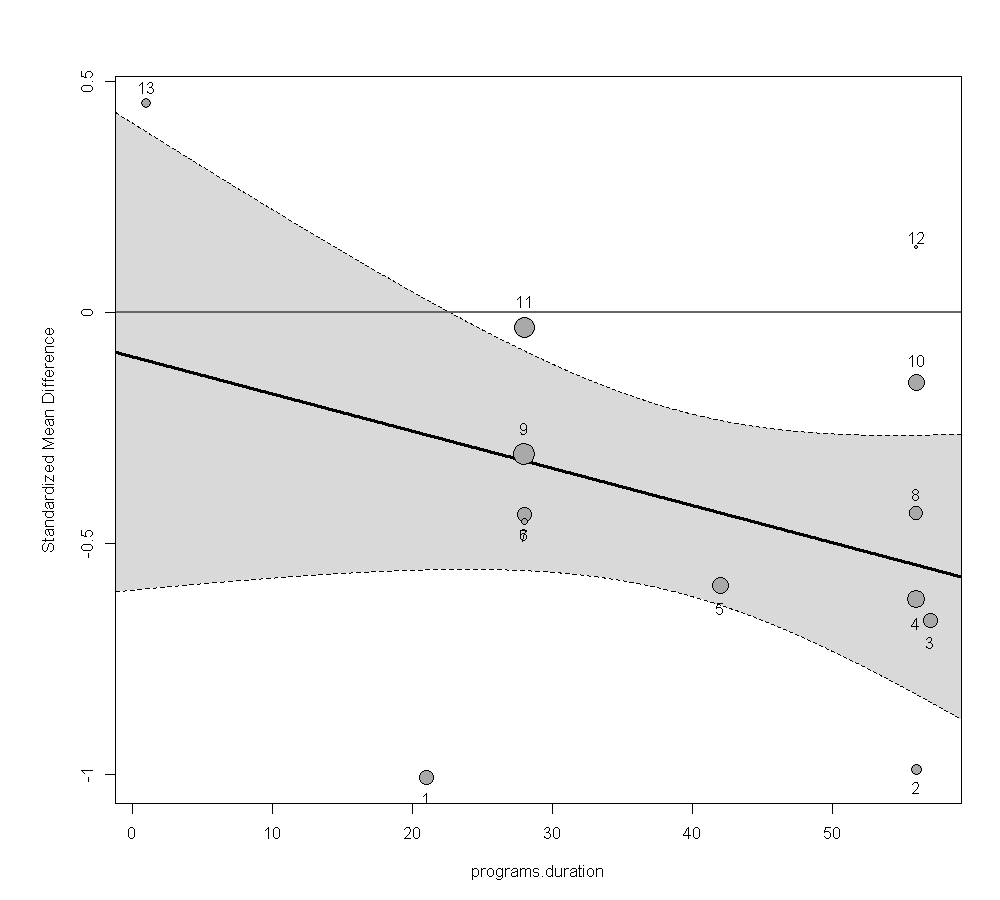

[1] "follow.up.period"

Mixed-Effects Model (k = 18; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0346 (SE = 0.0323)
tau (square root of estimated tau^2 value):             0.1860
I^2 (residual heterogeneity / unaccounted variability): 38.20%
H^2 (unaccounted variability / sampling variability):   1.62
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 16) = 27.0262, p-val = 0.0412

Test of Moderators (coefficient 2):
QM(df = 1) = 0.1985, p-val = 0.6559

Model Results:

                  estimate      se     zval    pval    ci.lb    ci.ub      
intrcpt            -0.4201  0.0792  -5.3054  <.0001  -0.5754  -0.2649  *** 
follow.up.period    0.0009  0.0019   0.4455  0.6559  -0.0029   0.0046      

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "delivery.mode"

Mixed-Effects Model (k = 14; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0680 (

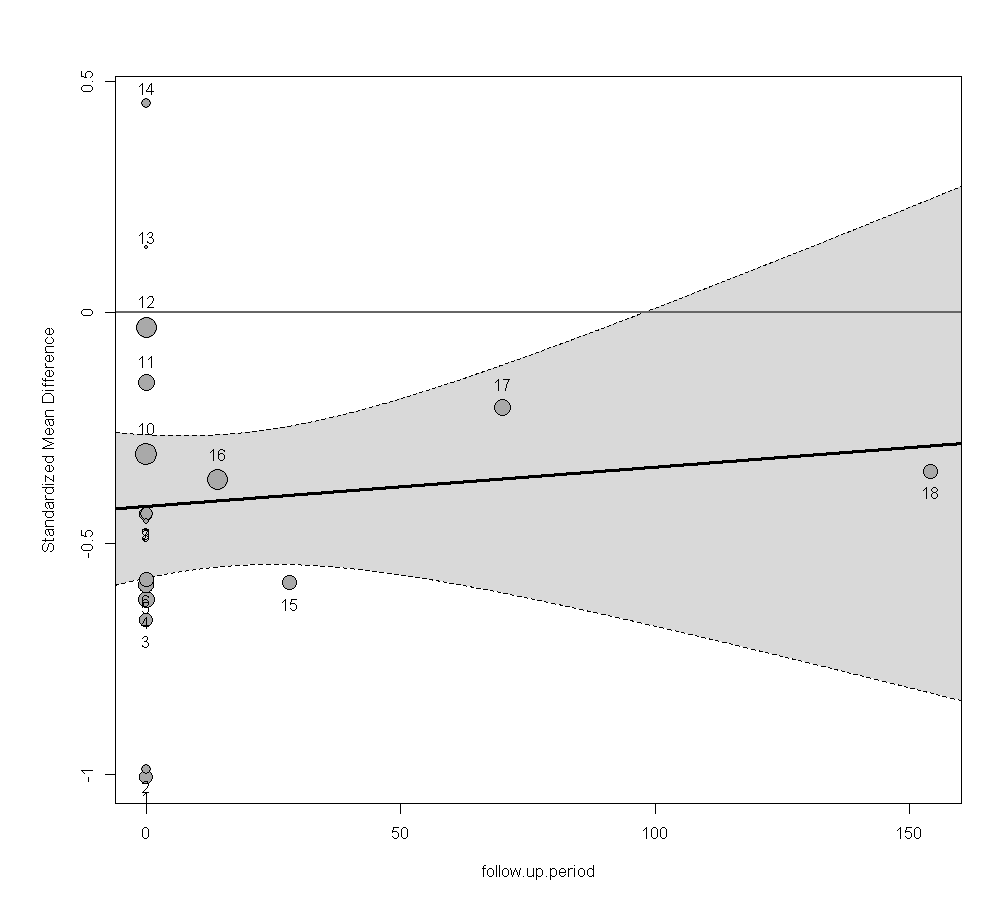

In [429]:
results.metafor.stress.pss <- print.meta.results("Stress", preferred.scale = "PSS", return.data = "results.metafor")

Number of studies combined: k = 11
Number of observations: o = 732

                         SMD             95%-CI     z  p-value
Common effect model  -0.4625 [-0.6102; -0.3148] -6.14 < 0.0001
Random effects model -0.4625 [-0.6102; -0.3148] -6.14 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1291]; tau = 0 [0.0000; 0.3593]
 I^2 = 0.0% [0.0%; 60.2%]; H = 1.00 [1.00; 1.59]

Test of heterogeneity:
    Q d.f. p-value
 8.42   10  0.5875

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)


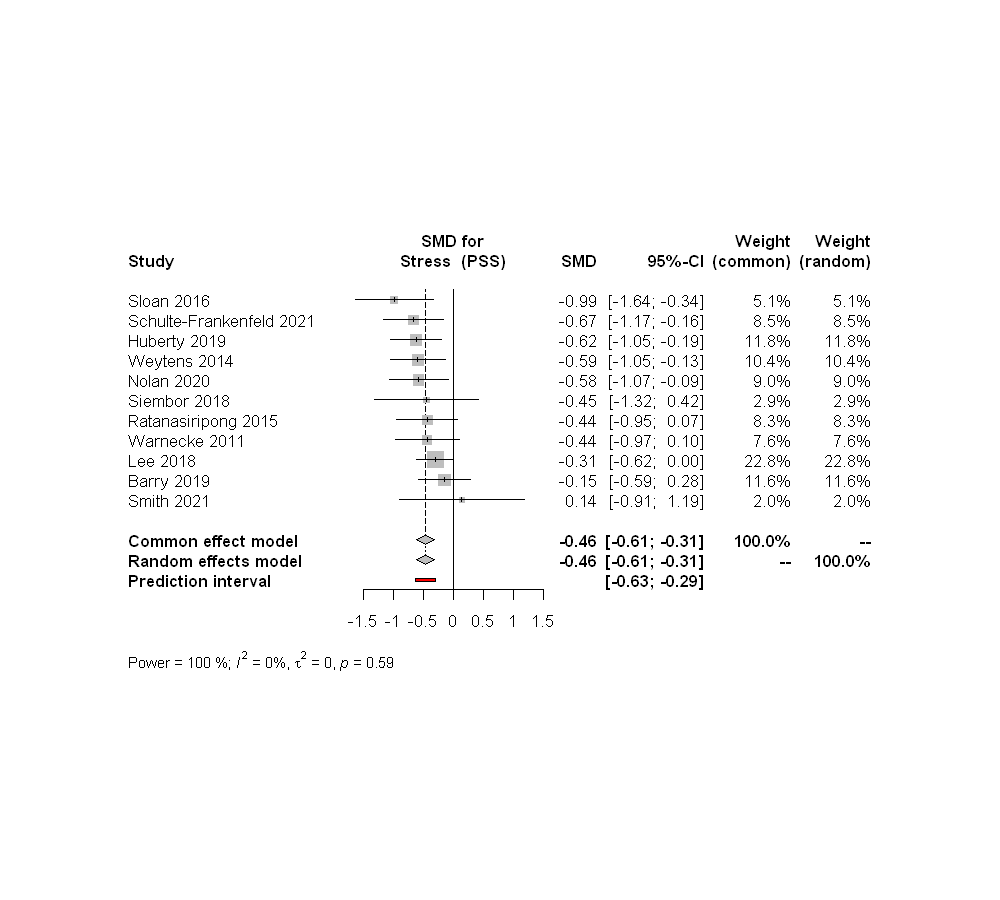

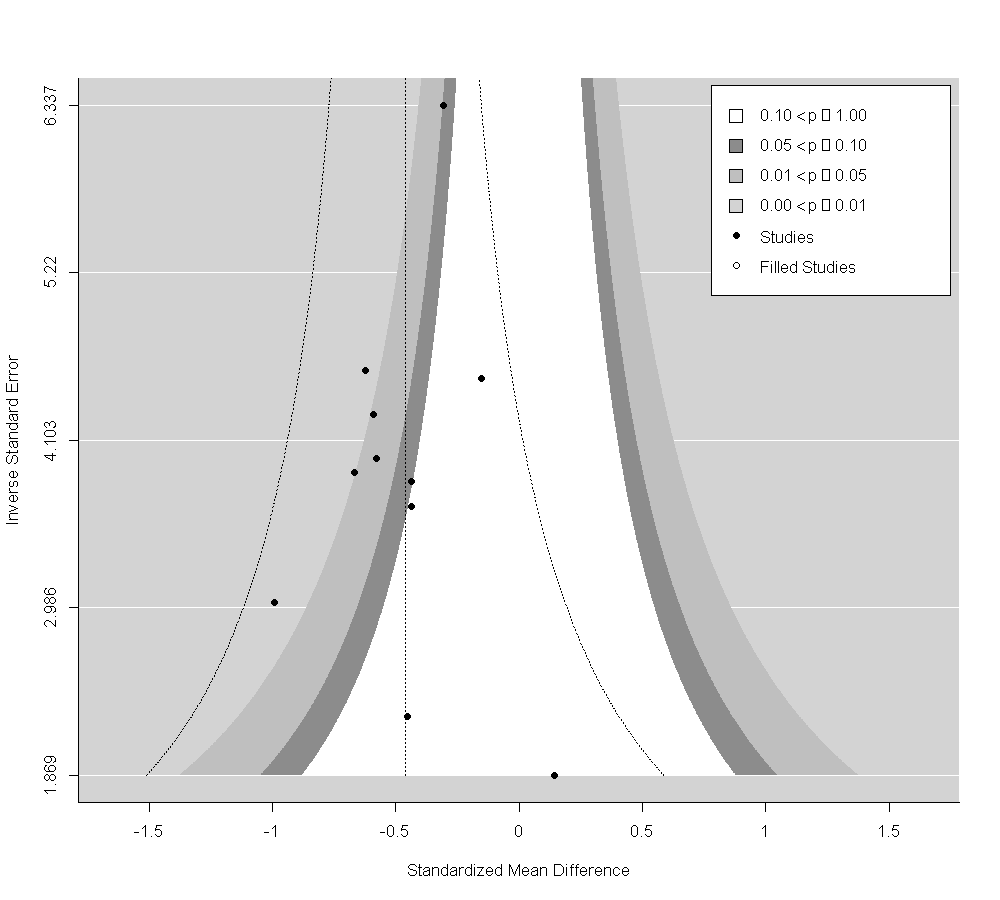

In [430]:
print.meta.results("Stress", preferred.scale = "PSS", filter.forest..funnel.vec = -c(1, 12, 14), regression = F, split.subgroups = F, print.influence = F)

Fitting 16383 models (based on all possible subsets).

Fitting 16383 models (based on all possible subsets).

Fitting 16383 models (based on all possible subsets).



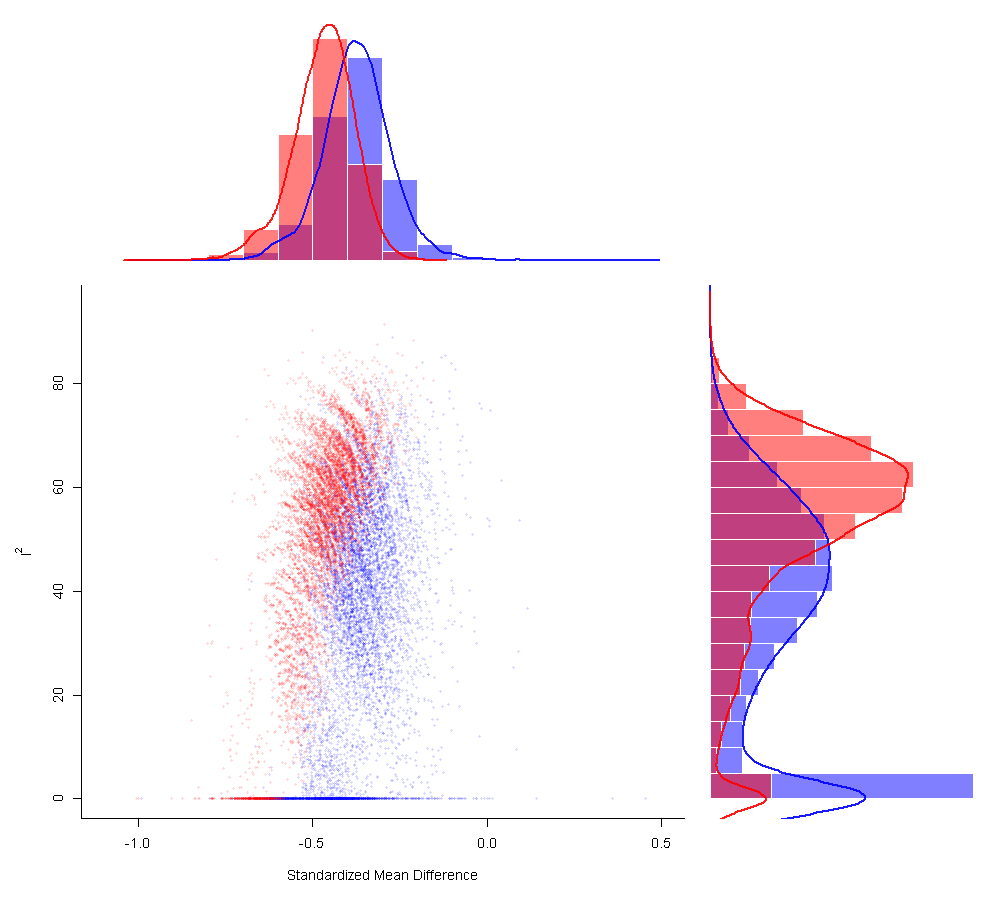

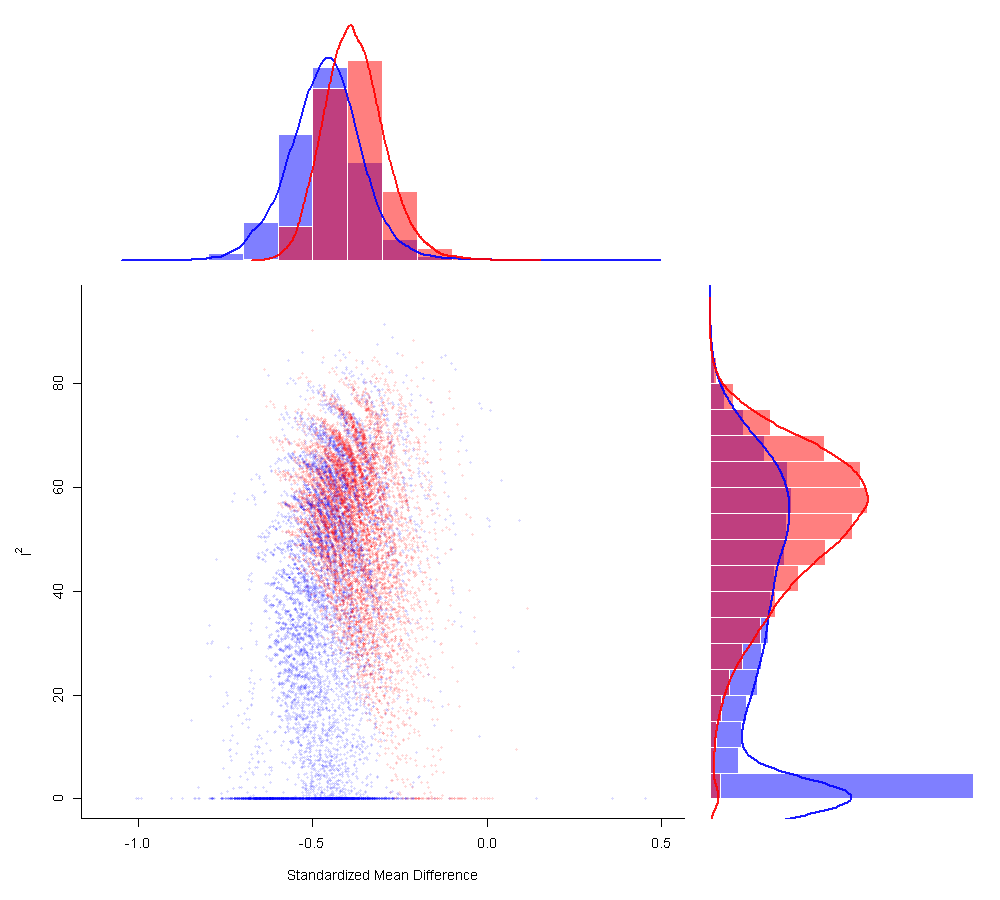

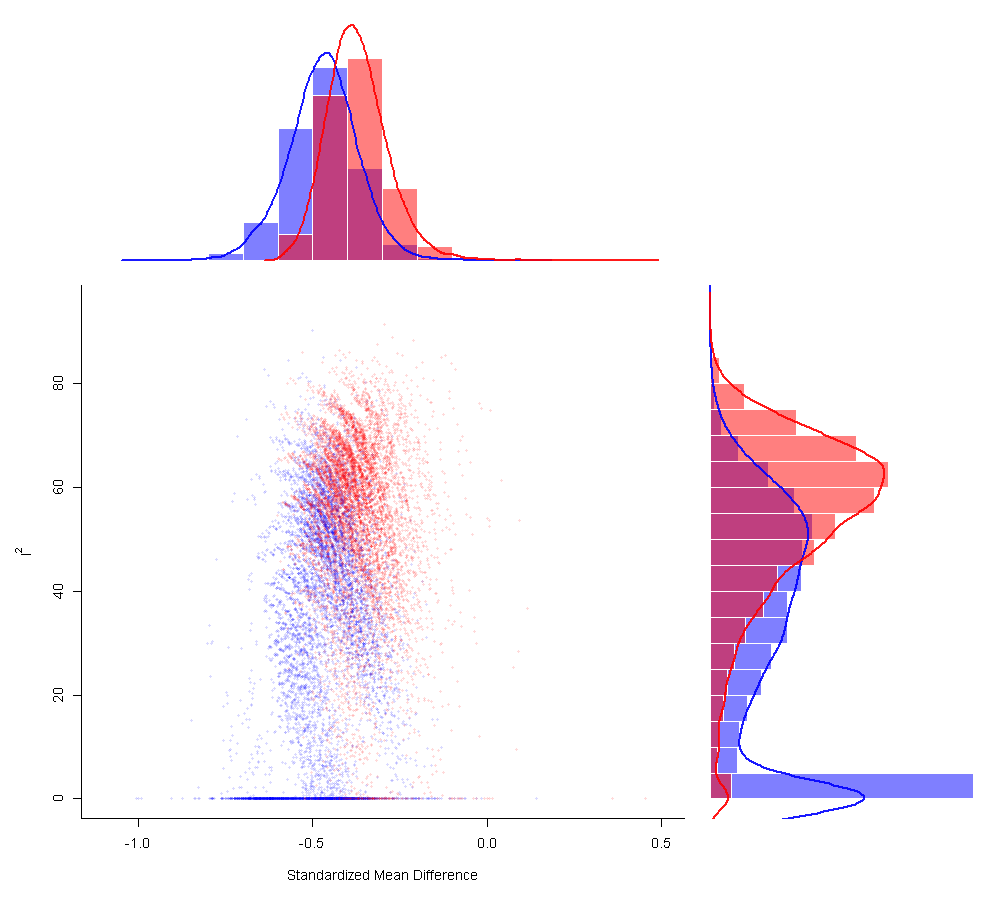

In [392]:
for (outlier in c(1, 12, 14)){
  sav <- gosh(results.metafor.stress.pss)
  plot(sav, out = outlier)
}

Number of studies combined: k = 5
Number of observations: o = 393

                        SMD           95%-CI    z p-value
Common effect model  0.3662 [0.1658; 0.5665] 3.58  0.0003
Random effects model 0.3662 [0.1658; 0.5666] 3.58  0.0003

Quantifying heterogeneity:
 tau^2 < 0.0001 [0.0000; 0.4972]; tau = 0.0019 [0.0000; 0.7051]
 I^2 = 0.0% [0.0%; 79.2%]; H = 1.00 [1.00; 2.19]

Test of heterogeneity:
    Q d.f. p-value
 2.31    4  0.6784

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
                  study.id        delivery.mode
1             deGrace 1976                 <NA>
2               Nolan 2020 Asynchronous guiding
3                 Lee 2018 Asynchronous guiding
4 Schulte-Frankenfeld 2021 Asynchronous guiding
5             Weytens 201

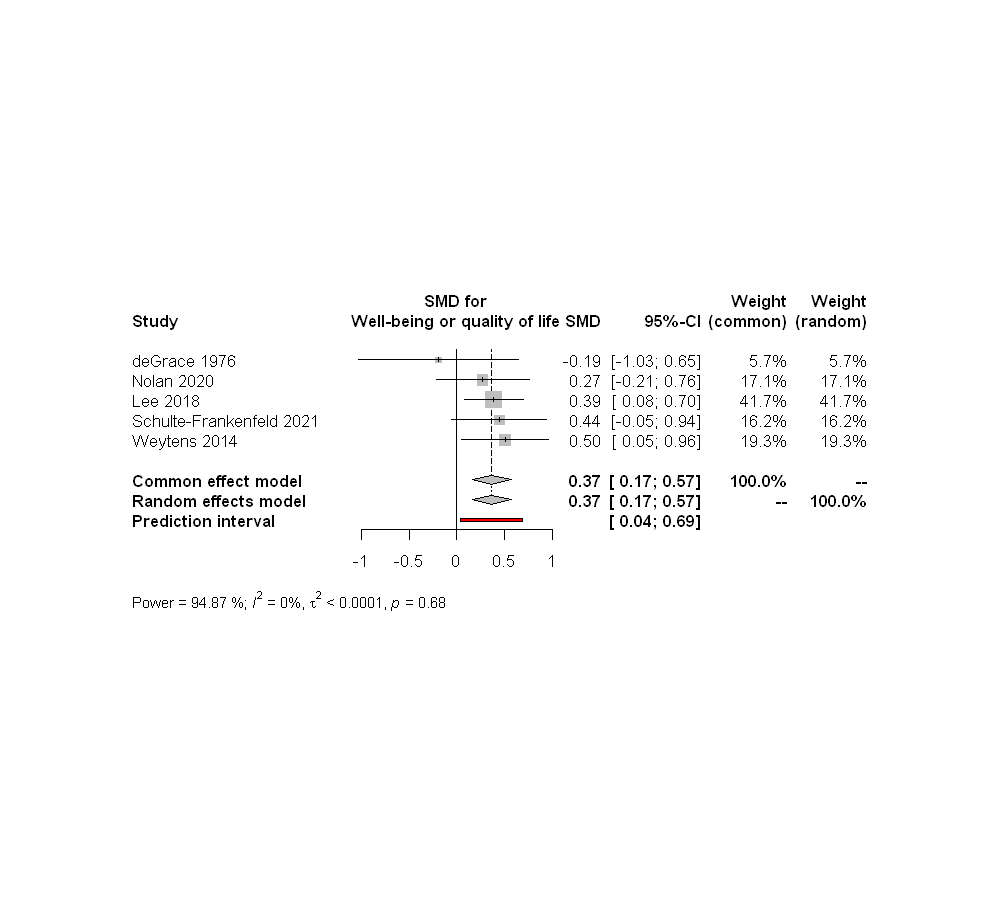

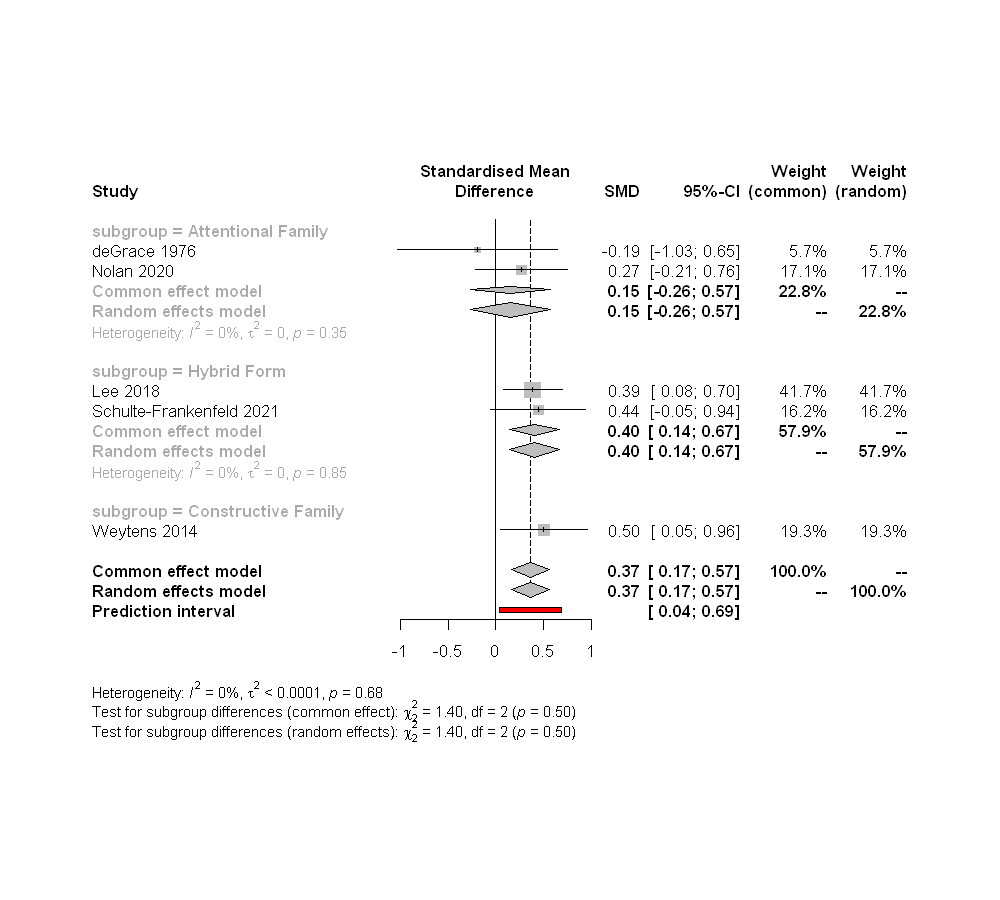

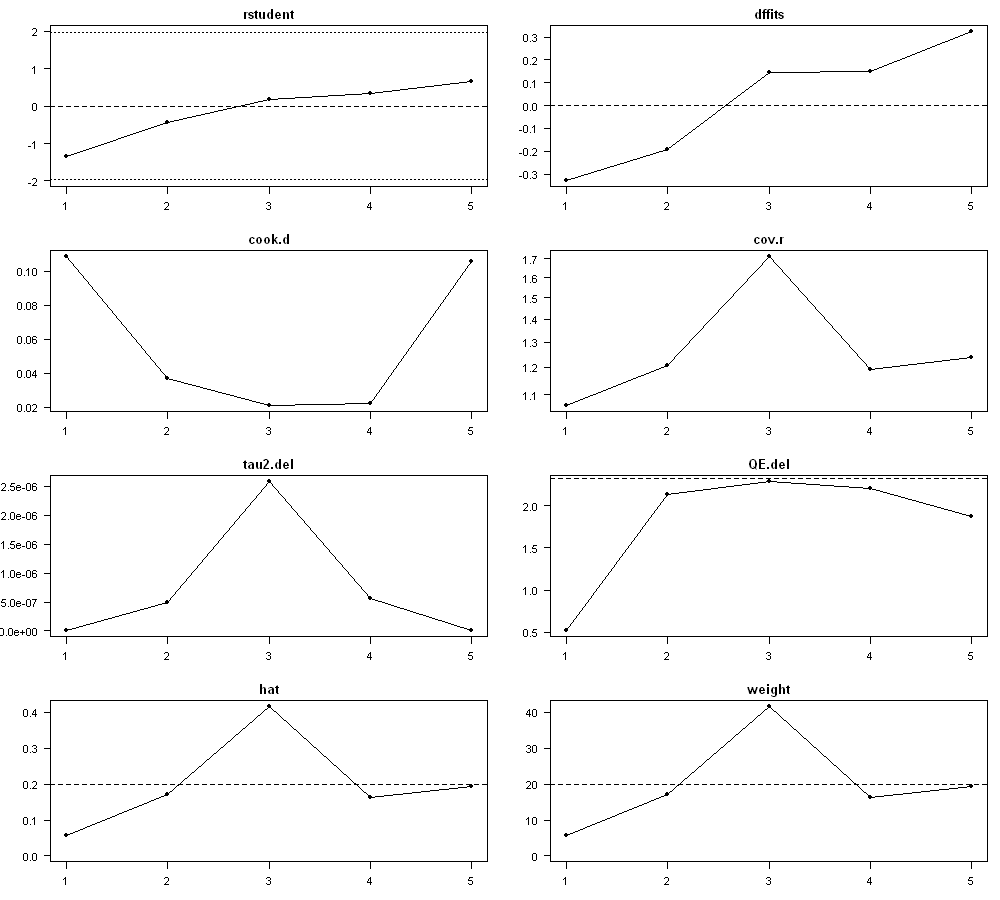

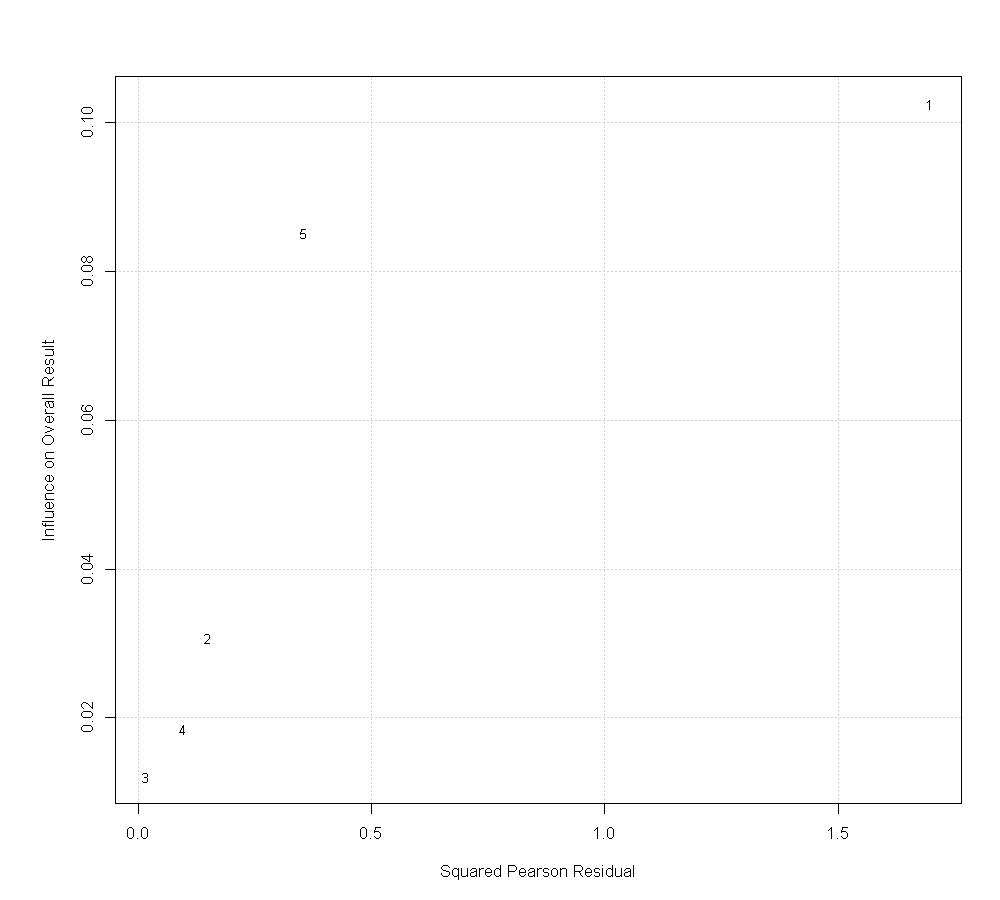

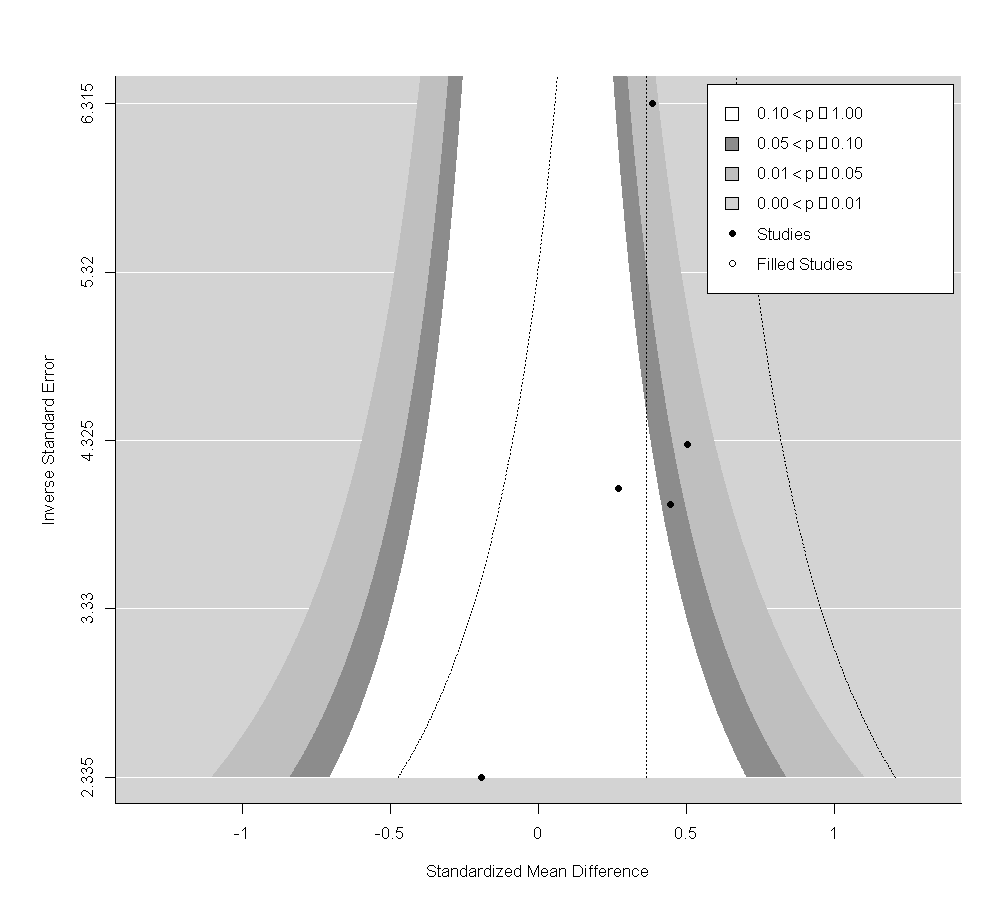

[1] "sessions.duration"

Mixed-Effects Model (k = 4; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0469)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 2) = 0.4599, p-val = 0.7946

Test of Moderators (coefficient 2):
QM(df = 1) = 1.4145, p-val = 0.2343

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt              0.9161  0.5033   1.8201  0.0687  -0.0704  1.9026  . 
sessions.duration   -0.0533  0.0448  -1.1893  0.2343  -0.1411  0.0345    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



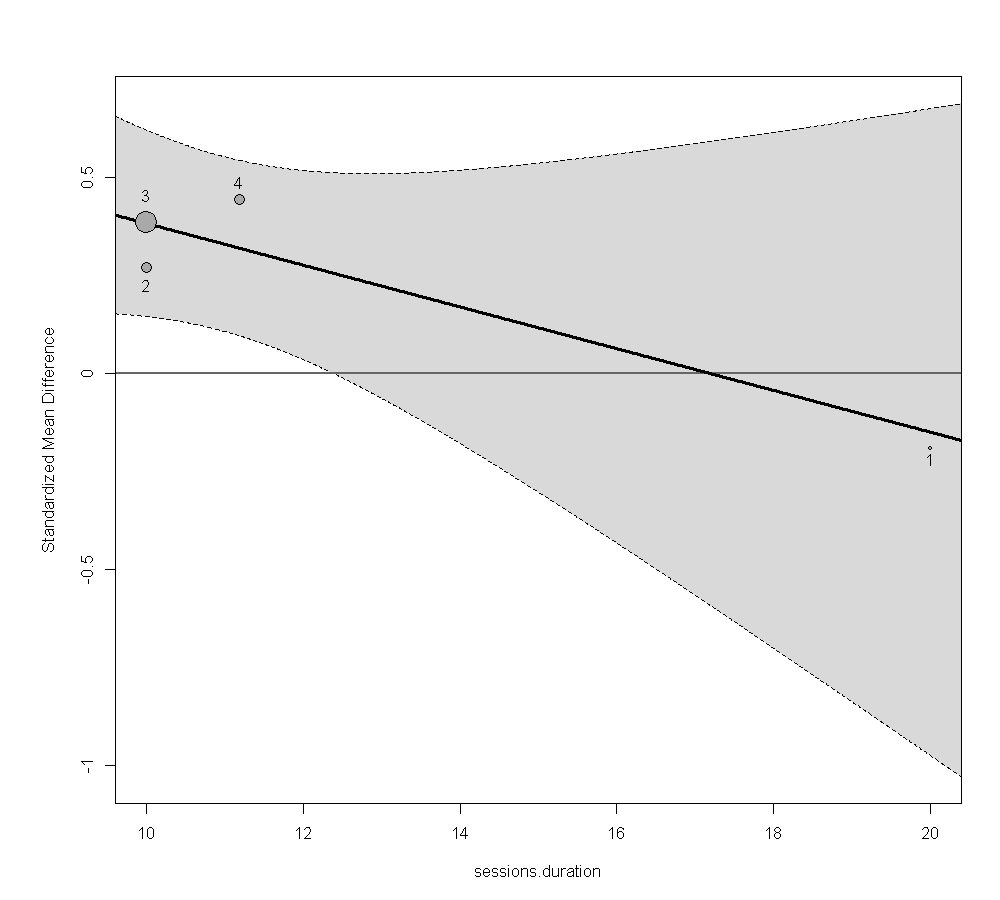

[1] "sessions.frequency"

Mixed-Effects Model (k = 5; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0376)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            100.00%

Test for Residual Heterogeneity:
QE(df = 3) = 1.0438, p-val = 0.7907

Test of Moderators (coefficient 2):
QM(df = 1) = 1.2713, p-val = 0.2595

Model Results:

                    estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt               0.6190  0.2464   2.5120  0.0120   0.1360  1.1020  * 
sessions.frequency   -0.0485  0.0430  -1.1275  0.2595  -0.1328  0.0358    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



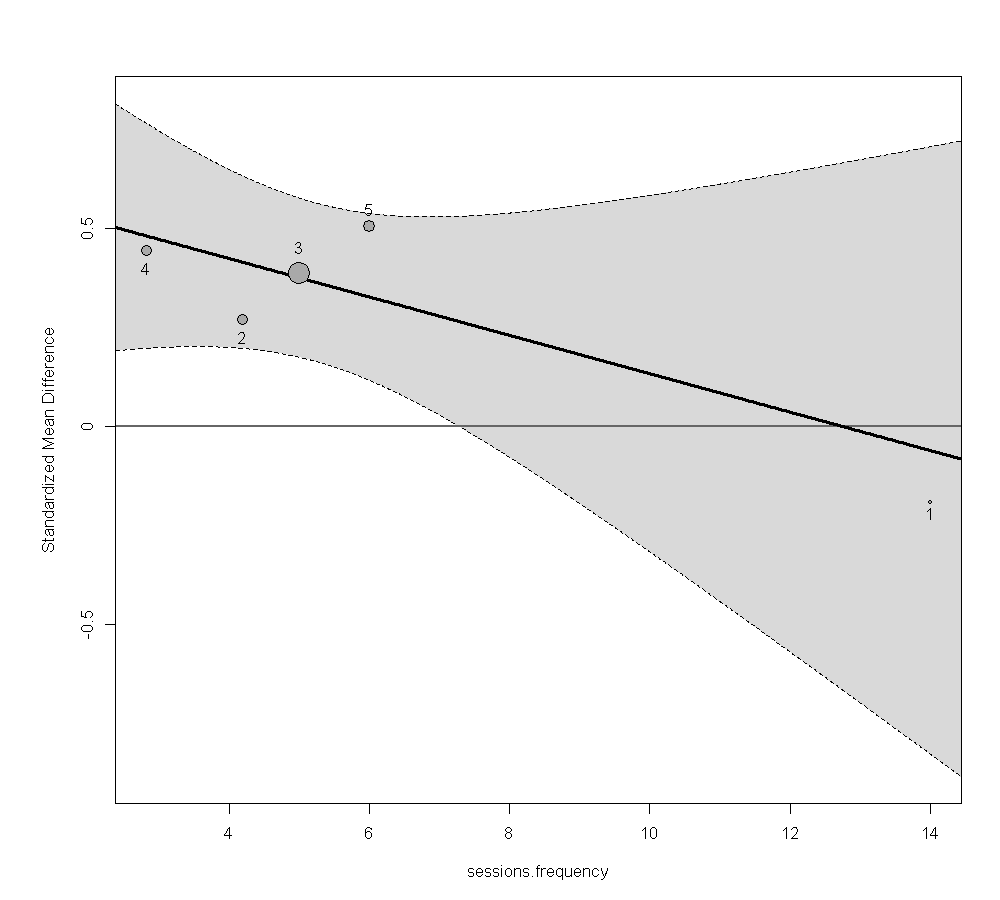

[1] "programs.duration"

Mixed-Effects Model (k = 4; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0485)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            100.00%

Test for Residual Heterogeneity:
QE(df = 2) = 0.6801, p-val = 0.7117

Test of Moderators (coefficient 2):
QM(df = 1) = 1.4548, p-val = 0.2278

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub     
intrcpt              0.5843  0.1992   2.9340  0.0033   0.1940  0.9746  ** 
programs.duration   -0.0044  0.0036  -1.2062  0.2278  -0.0115  0.0027     

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "Only equal moderator values present for regression of outcome:\"Well-being or quality of life\" and moderator: \"follow.up.period\""

[1] "delivery

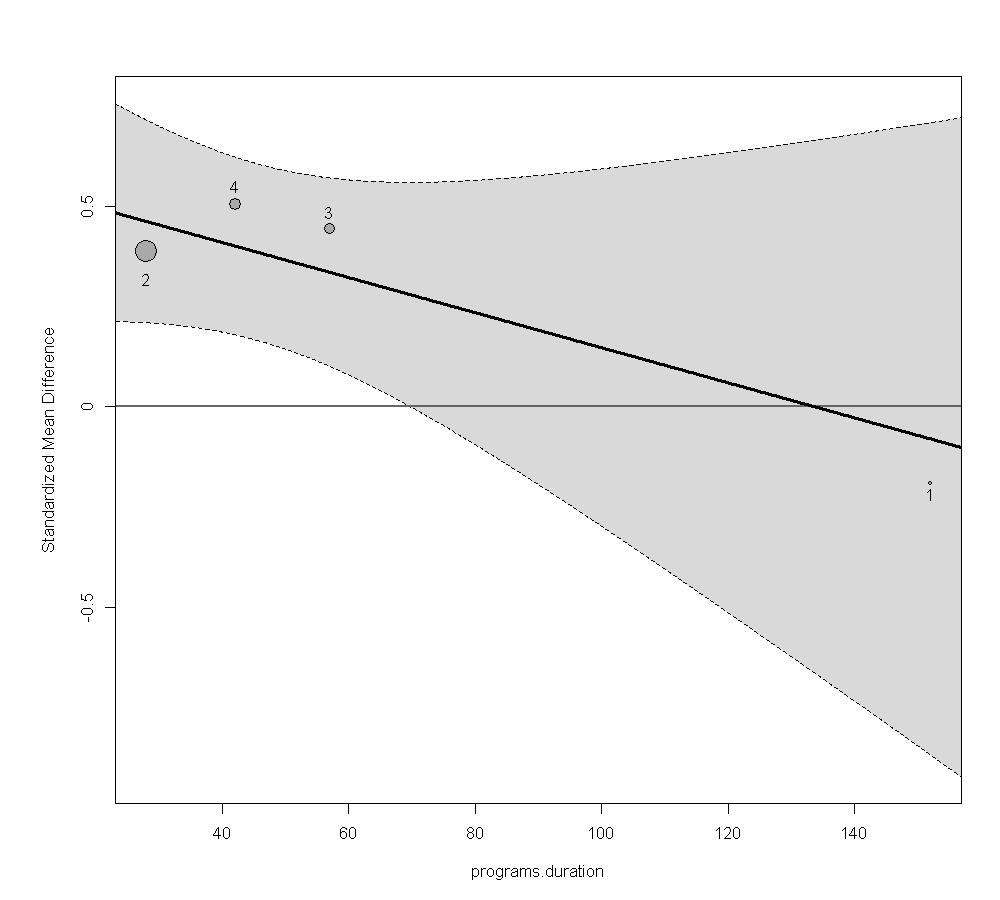

In [393]:
print.meta.results("Well-being or quality of life")

### Resilience Factors

In [394]:
print.meta.results("Acceptance")

no studies included for outcome: Acceptance 

[1] "Number of included studies (0) for the funnel plot is below 3 for outcome: Acceptance"

no studies included for outcome: Acceptance 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Acceptance\" and moderator \"sessions.duration\""

no studies included for outcome: Acceptance 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Acceptance\" and moderator \"sessions.frequency\""

no studies included for outcome: Acceptance 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Acceptance\" and moderator \"programs.duration\""

no studies included for outcome: Acceptance 

[1] "Number of included studies (2) in regression is below 3 for outcome \"Acceptance\" and moderator \"follow.up.period\""

no studies included for outcome: Acceptance 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Acceptance\" and moderator \"delivery.mode\""

no st

Number of observations: o = 21

                SMD            95%-CI    z p-value
Siembor 2018 0.2331 [-0.6268; 1.0930] 0.53  0.5952

Details:
- Inverse variance method
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (1) for the funnel plot is below 3 for outcome: Coping flexibility"

[1] "Number of included studies (0) in regression is below 3 for outcome \"Coping flexibility\" and moderator \"sessions.duration\""

[1] "Number of included studies (0) in regression is below 3 for outcome \"Coping flexibility\" and moderator \"sessions.frequency\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Coping flexibility\" and moderator \"programs.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Coping flexibility\" and moderator \"follow.up.period\""

[1]

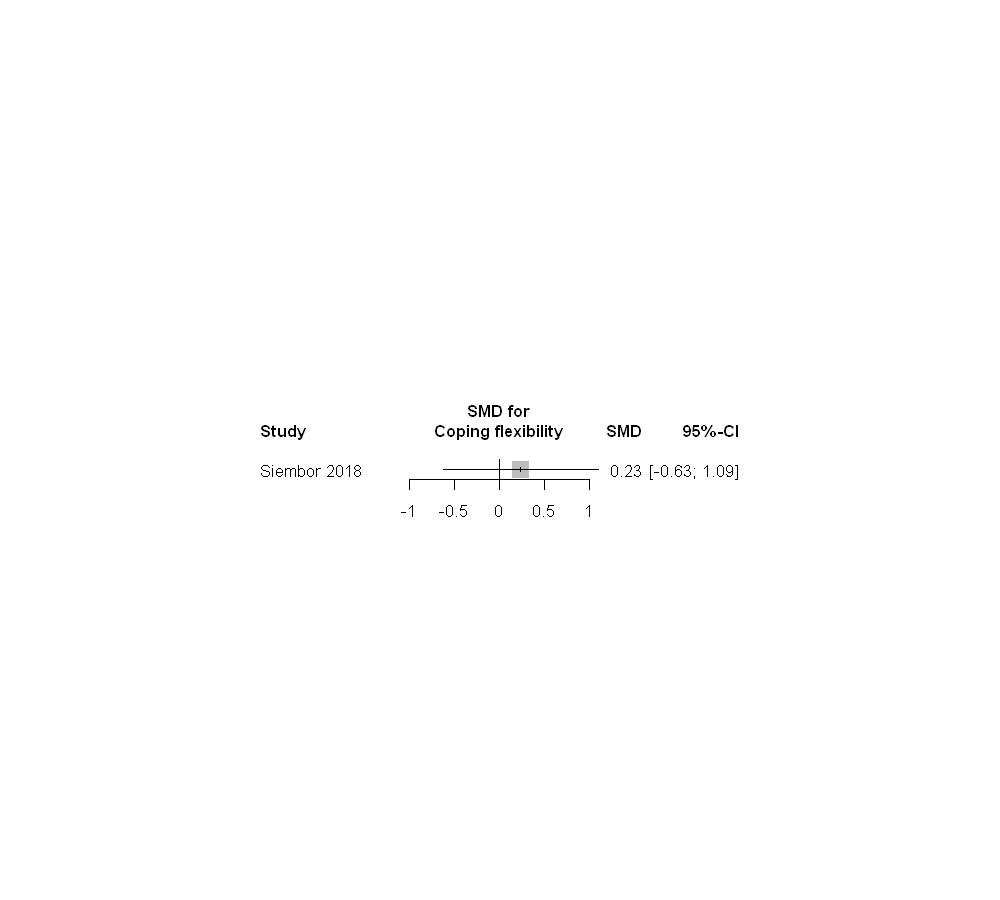

In [395]:
print.meta.results("Coping flexibility")

Number of studies combined: k = 2
Number of observations: o = 470

                        SMD            95%-CI    z p-value
Common effect model  0.1339 [-0.0480; 0.3158] 1.44  0.1491
Random effects model 0.1340 [-0.0873; 0.3554] 1.19  0.2353

Quantifying heterogeneity:
 tau^2 = 0.0083; tau = 0.0910; I^2 = 32.5%; H = 1.22

Test of heterogeneity:
    Q d.f. p-value
 1.48    1  0.2236

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (2) for the funnel plot is below 3 for outcome: Empathy"

[1] "Number of included studies (0) in regression is below 3 for outcome \"Empathy\" and moderator \"sessions.duration\""

[1] "Number of included studies (0) in regression is below 3 for outcome \"Empathy\" and moderat

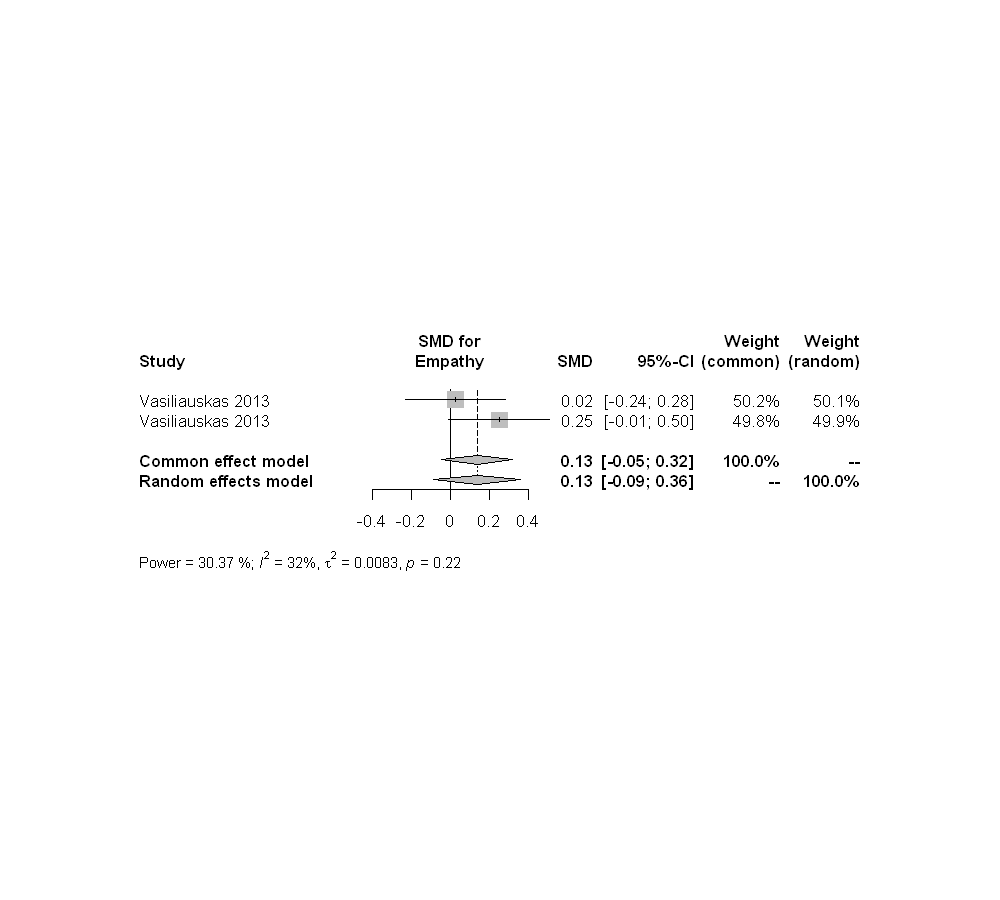

In [396]:
print.meta.results("Empathy")

Number of observations: o = 82

              SMD           95%-CI    z p-value
Barry 2019 0.7271 [0.2790; 1.1752] 3.18  0.0015

Details:
- Inverse variance method
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (1) for the funnel plot is below 3 for outcome: Hope"

[1] "Number of included studies (1) in regression is below 3 for outcome \"Hope\" and moderator \"sessions.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Hope\" and moderator \"sessions.frequency\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Hope\" and moderator \"programs.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Hope\" and moderator \"follow.up.period\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Hope

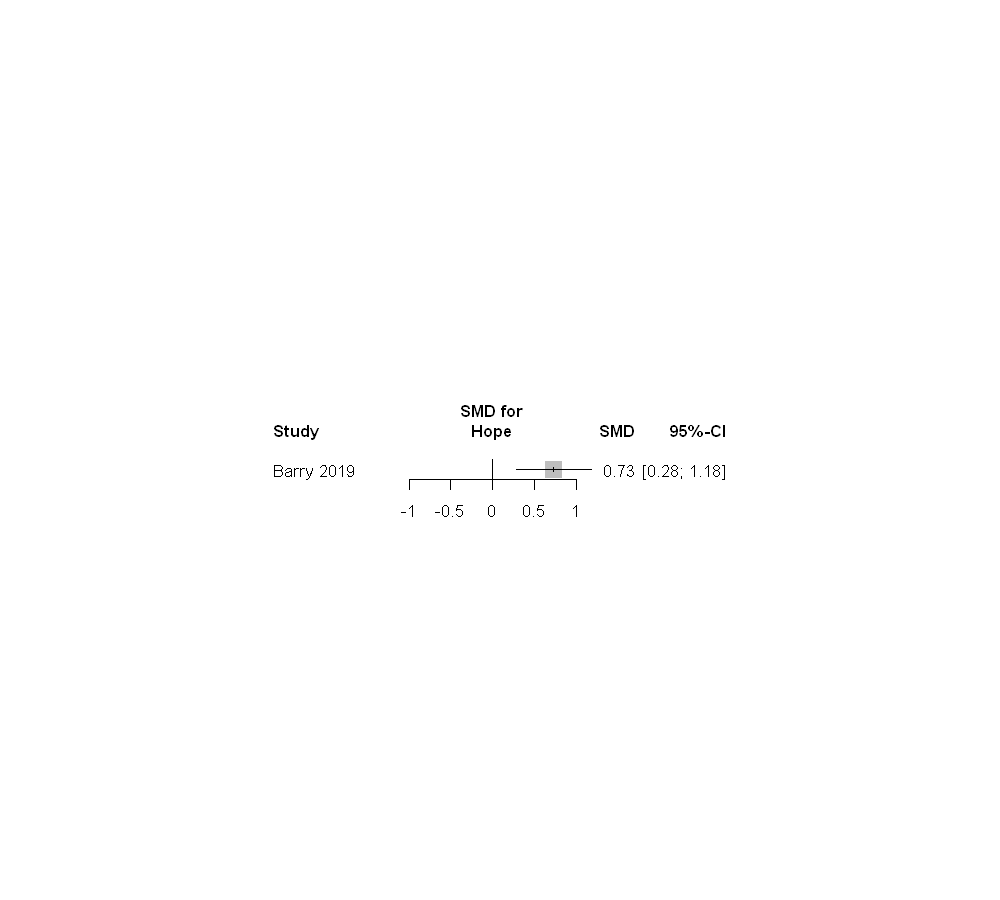

In [397]:
print.meta.results("Hope")

Number of studies combined: k = 2
Number of observations: o = 174

                        SMD           95%-CI     z  p-value
Common effect model  2.8052 [2.3789; 3.2316] 12.90 < 0.0001
Random effects model 2.8438 [2.1223; 3.5654]  7.72 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.1748; tau = 0.4181; I^2 = 64.3% [0.0%; 91.8%]; H = 1.67 [1.00; 3.50]

Test of heterogeneity:
    Q d.f. p-value
 2.80    1  0.0944

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (2) for the funnel plot is below 3 for outcome: Mindfulness (state)"

[1] "Number of included studies (2) in regression is below 3 for outcome \"Mindfulness (state)\" and moderator \"sessions.duration\""

[1] "Number of included studies (2) in reg

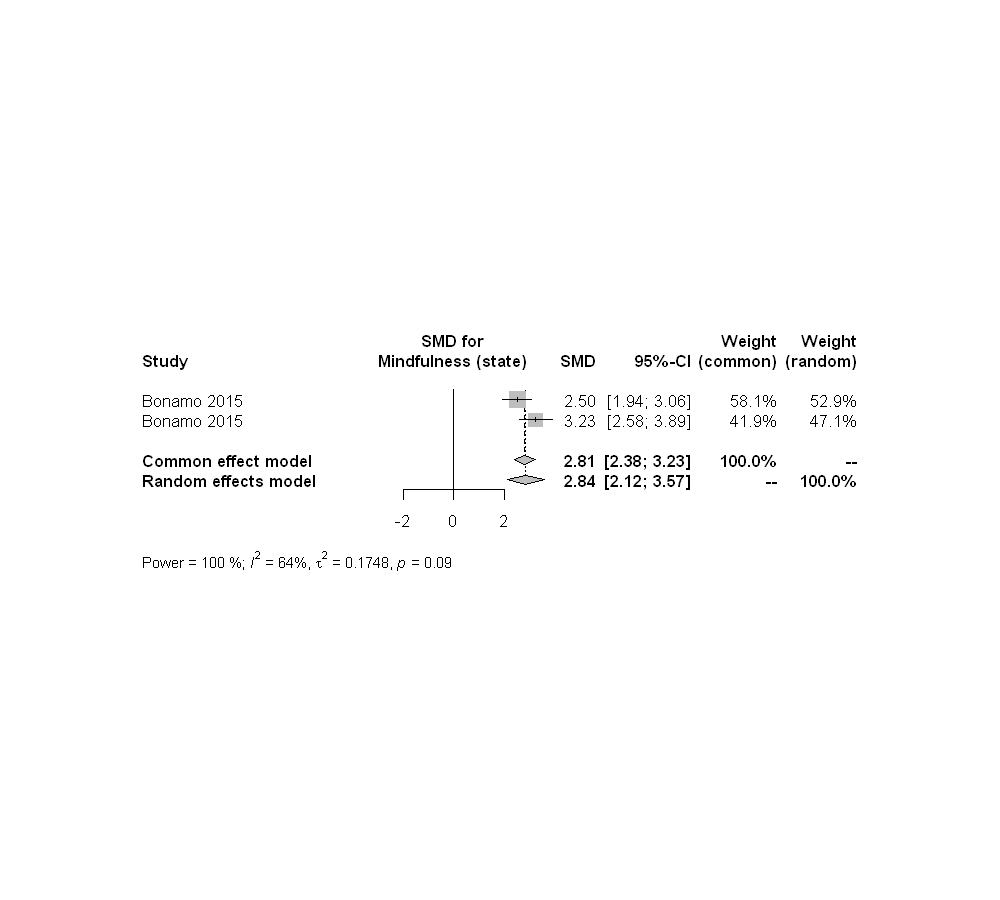

In [398]:
print.meta.results("Mindfulness (state)")

Number of studies combined: k = 9
Number of observations: o = 742

                        SMD           95%-CI    z  p-value
Common effect model  0.3257 [0.1786; 0.4729] 4.34 < 0.0001
Random effects model 0.3348 [0.1289; 0.5407] 3.19   0.0014

Quantifying heterogeneity:
 tau^2 = 0.0396 [0.0000; 0.3228]; tau = 0.1991 [0.0000; 0.5682]
 I^2 = 41.2% [0.0%; 72.9%]; H = 1.30 [1.00; 1.92]

Test of heterogeneity:
     Q d.f. p-value
 13.61    8  0.0925

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 9
Number of observations: o = 742

                        SMD           95%-CI    z  p-value
Common effect model  0.3257 [0.1786; 0.4729] 4.34 < 0.0001
Random effects model 0.3348 [0.1289; 0.5407] 3.19   0.0014

Quantifying he

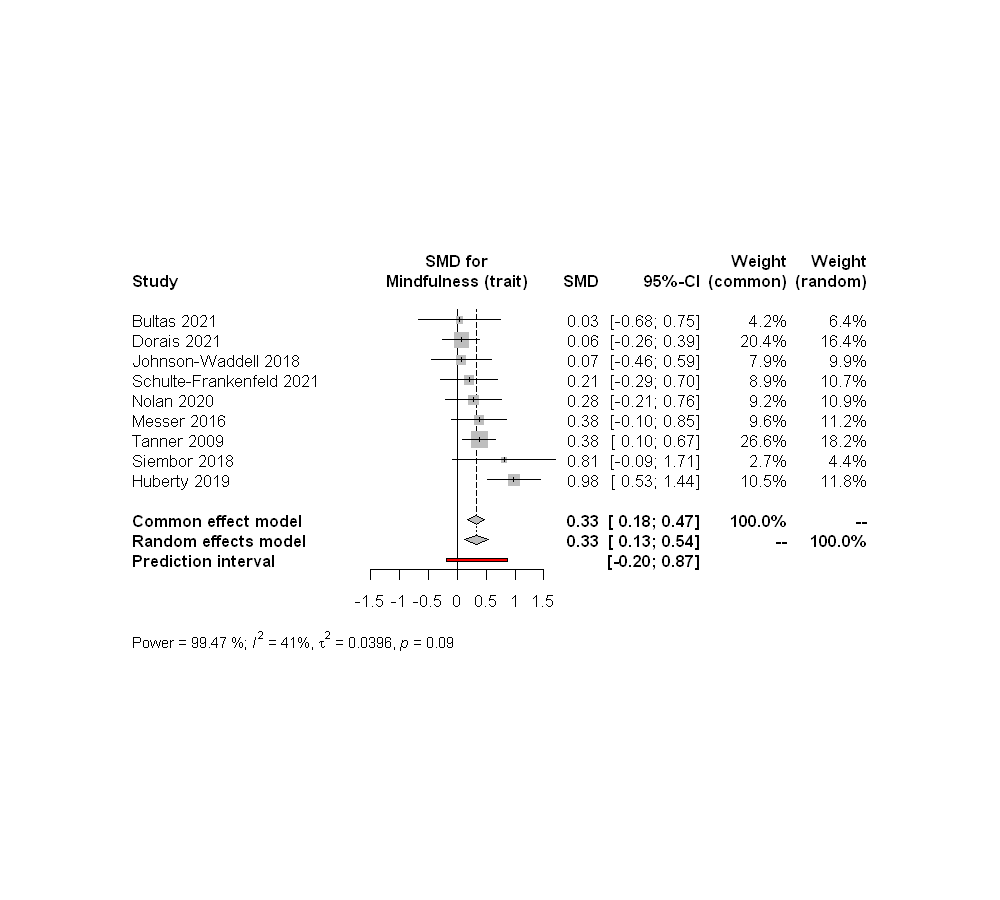


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 9
Number of observations: o = 742

                        SMD           95%-CI    z  p-value
Common effect model  0.3257 [0.1786; 0.4729] 4.34 < 0.0001
Random effects model 0.3348 [0.1289; 0.5407] 3.19   0.0014

Quantifying heterogeneity:
 tau^2 = 0.0396 [0.0000; 0.3228]; tau = 0.1991 [0.0000; 0.5682]
 I^2 = 41.2% [0.0%; 72.9%]; H = 1.30 [1.00; 1.92]

Test of heterogeneity:
     Q d.f. p-value
 13.61    8  0.0925

Results for subgroups (common effect model):
                                k    SMD           95%-CI    Q   I^2
subgroup = Attentional Family   7 0.2536 [0.0896; 0.4175] 4.65  0.0%
subgroup = Hybrid Form          2 0.6250 [0.2911; 0.9588] 5.13 80.5%

Test for subgroup differences (common effect model):
                  Q d.f. p-value
Between groups 3.83    1  0.0503
Within groups  9.78    7  0.2015

Results for subgroups (random effects model):
                                k    SMD            95%-CI

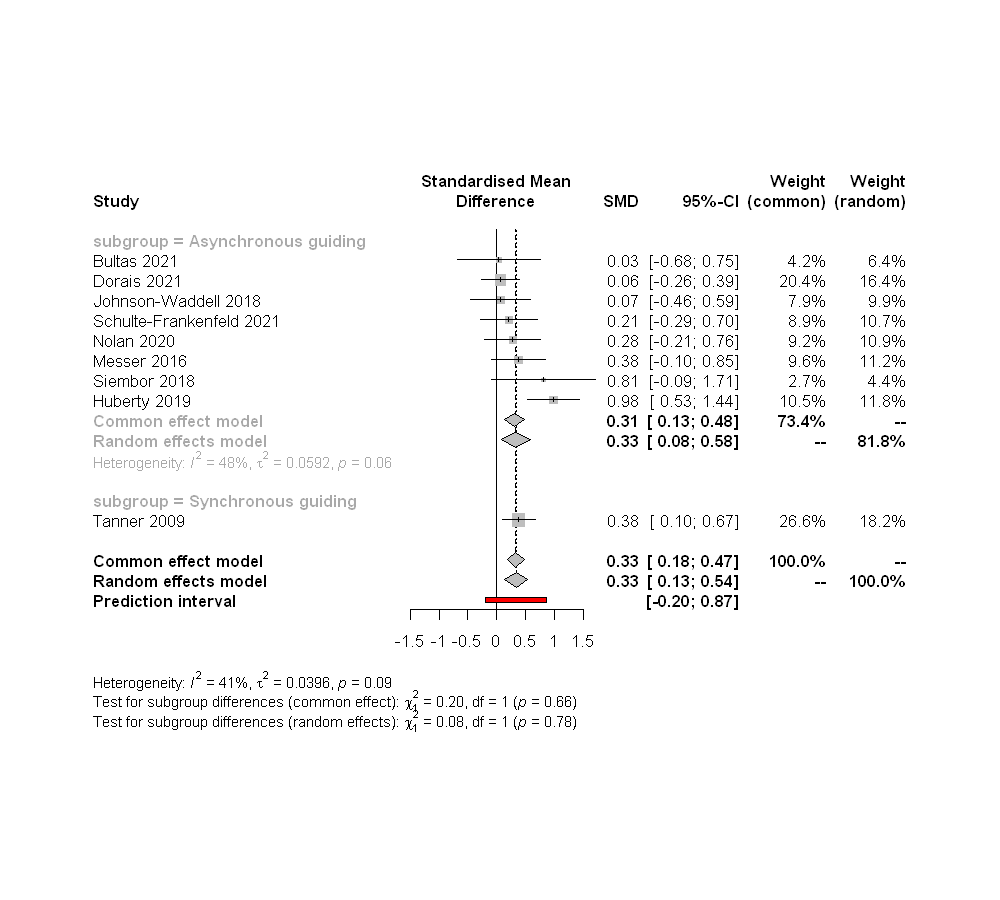

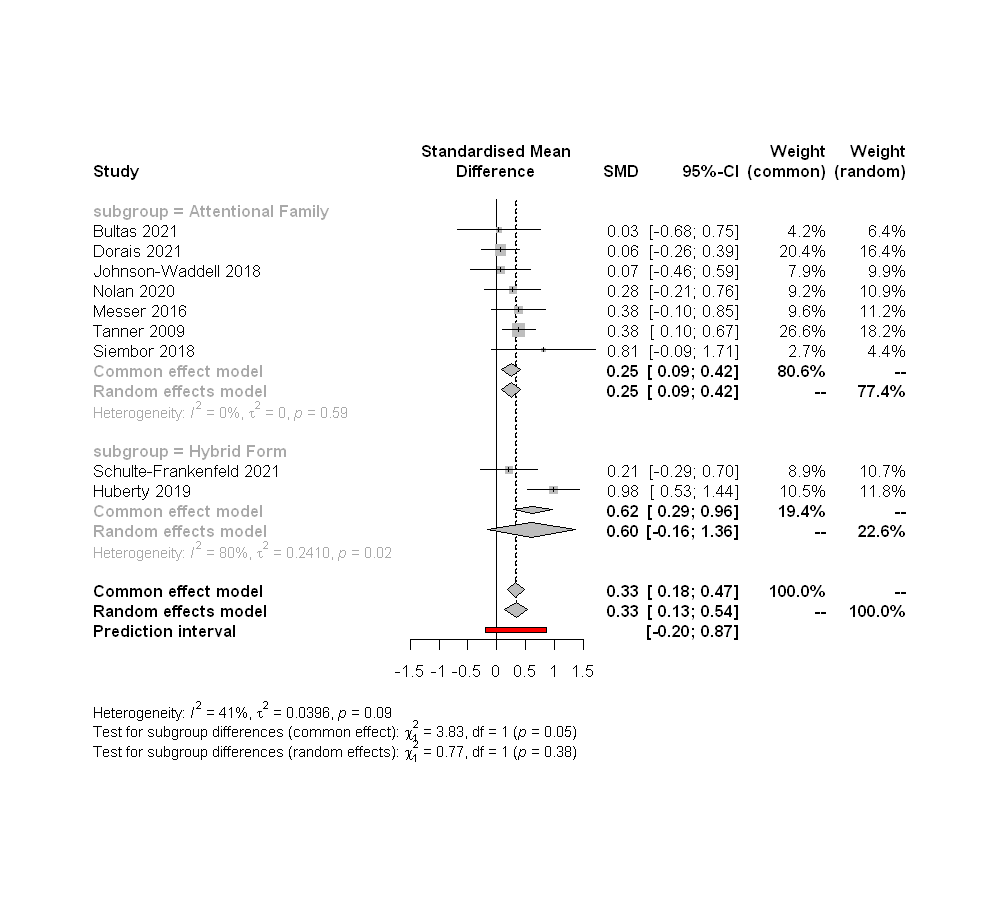

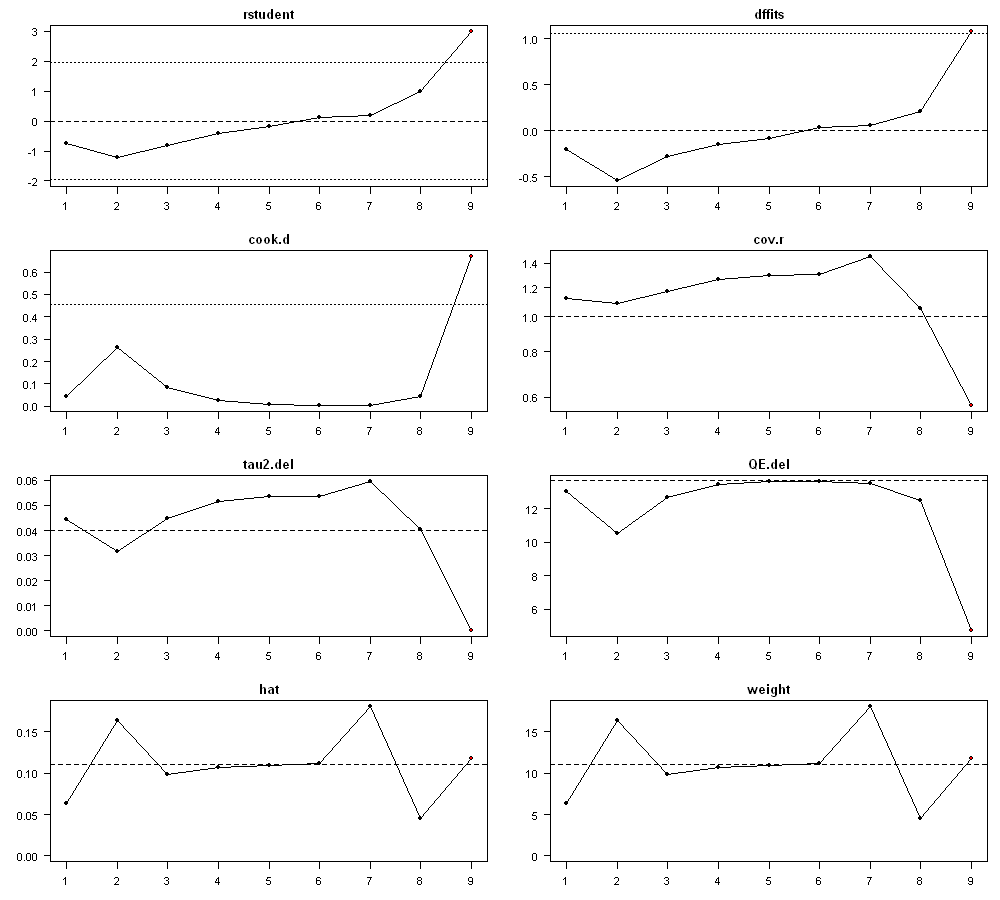

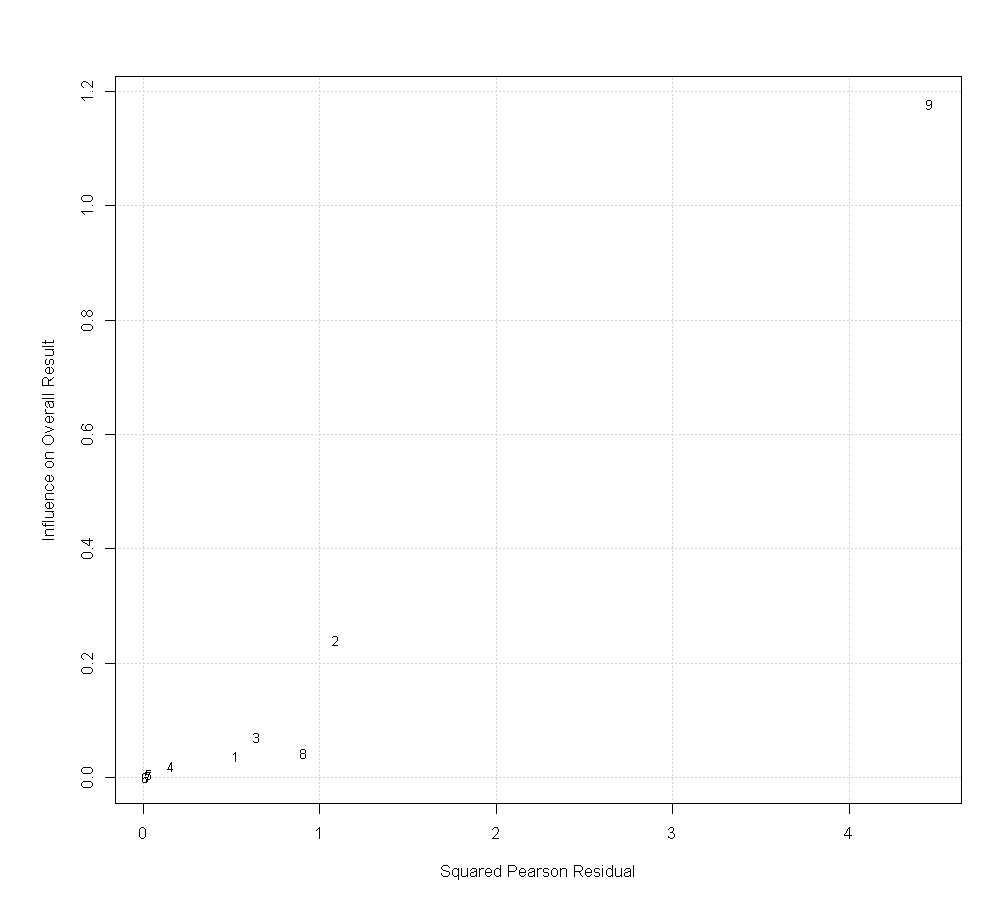

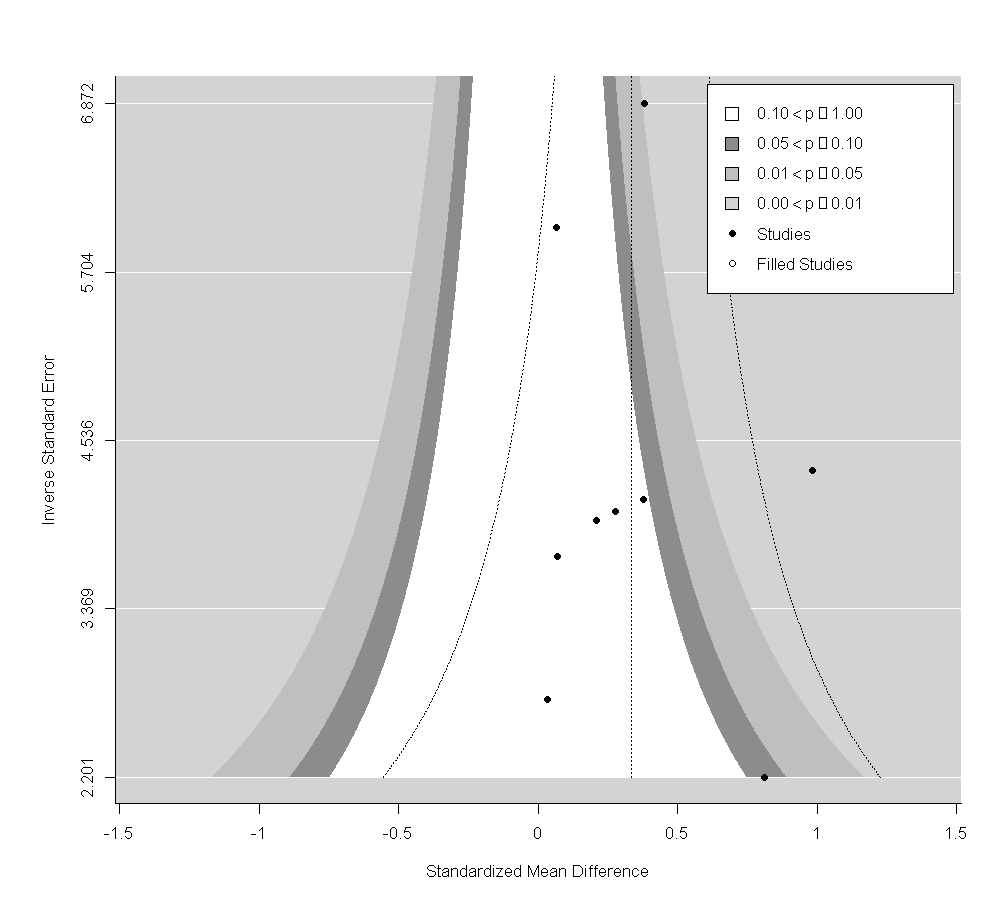

[1] "sessions.duration"

Mixed-Effects Model (k = 7; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0619 (SE = 0.0817)
tau (square root of estimated tau^2 value):             0.2489
I^2 (residual heterogeneity / unaccounted variability): 48.22%
H^2 (unaccounted variability / sampling variability):   1.93
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 5) = 9.5979, p-val = 0.0875

Test of Moderators (coefficient 2):
QM(df = 1) = 0.0433, p-val = 0.8351

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt              0.4166  0.3021   1.3789  0.1679  -0.1756  1.0088    
sessions.duration   -0.0035  0.0169  -0.2081  0.8351  -0.0367  0.0296    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



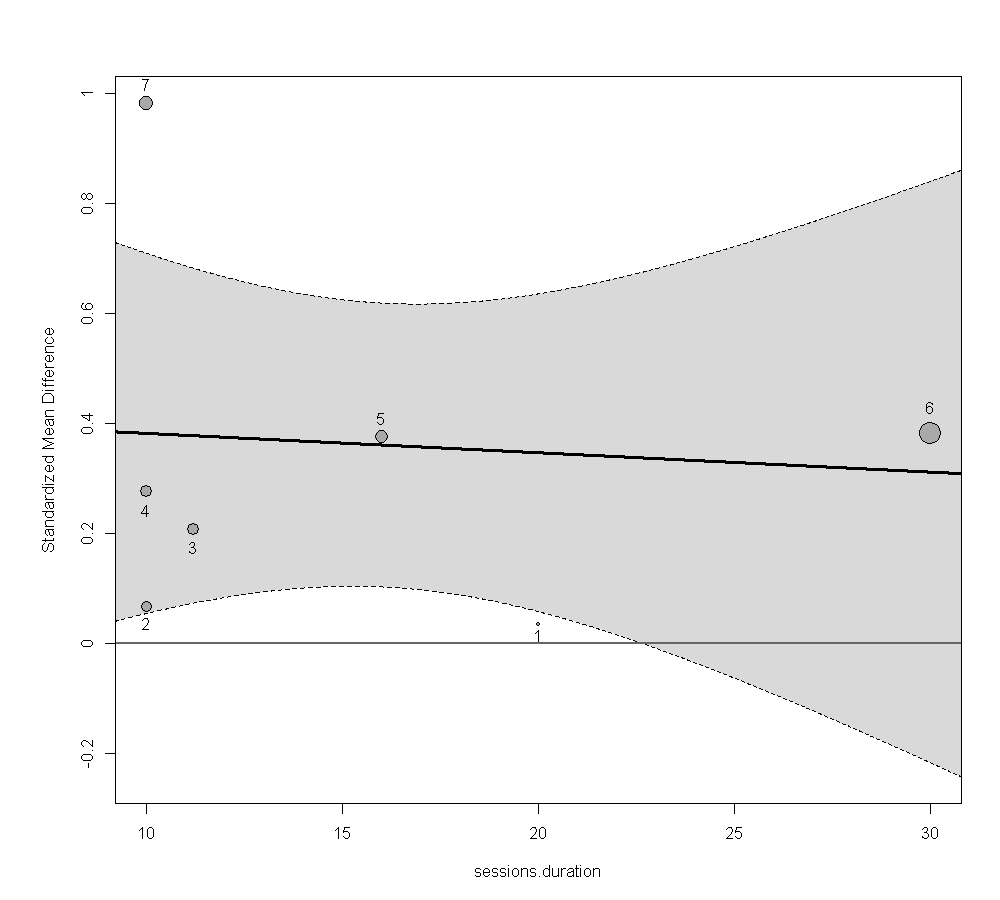

[1] "sessions.frequency"

Mixed-Effects Model (k = 5; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0424)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            100.00%

Test for Residual Heterogeneity:
QE(df = 3) = 1.7349, p-val = 0.6292

Test of Moderators (coefficient 2):
QM(df = 1) = 9.6362, p-val = 0.0019

Model Results:

                    estimate      se    zval    pval    ci.lb   ci.ub     
intrcpt               0.0047  0.1408  0.0332  0.9735  -0.2714  0.2807     
sessions.frequency    0.0245  0.0079  3.1042  0.0019   0.0090  0.0399  ** 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



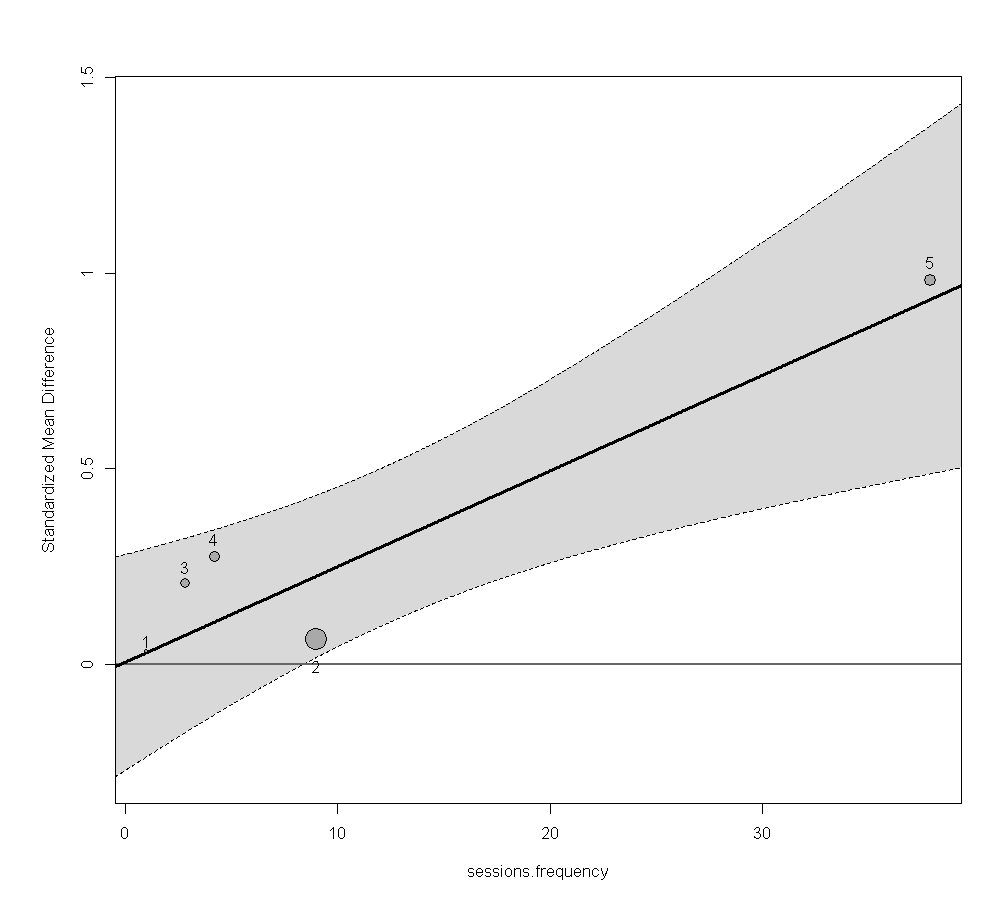

[1] "programs.duration"

Mixed-Effects Model (k = 7; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0644 (SE = 0.0839)
tau (square root of estimated tau^2 value):             0.2537
I^2 (residual heterogeneity / unaccounted variability): 49.75%
H^2 (unaccounted variability / sampling variability):   1.99
R^2 (amount of heterogeneity accounted for):            18.93%

Test for Residual Heterogeneity:
QE(df = 5) = 9.8651, p-val = 0.0791

Test of Moderators (coefficient 2):
QM(df = 1) = 1.4109, p-val = 0.2349

Model Results:

                   estimate      se    zval    pval    ci.lb   ci.ub    
intrcpt              0.0119  0.3074  0.0388  0.9690  -0.5905  0.6143    
programs.duration    0.0095  0.0080  1.1878  0.2349  -0.0062  0.0251    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



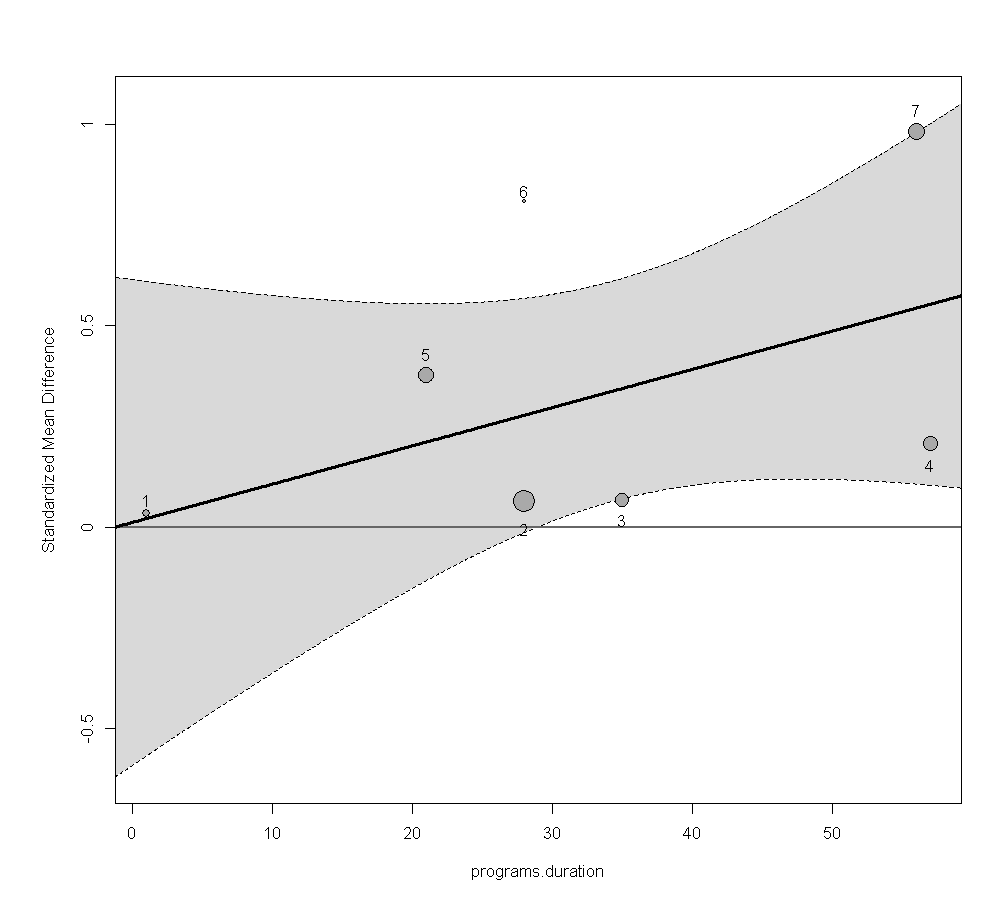

[1] "follow.up.period"

Mixed-Effects Model (k = 13; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0317 (SE = 0.0351)
tau (square root of estimated tau^2 value):             0.1780
I^2 (residual heterogeneity / unaccounted variability): 38.99%
H^2 (unaccounted variability / sampling variability):   1.64
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 11) = 17.9180, p-val = 0.0835

Test of Moderators (coefficient 2):
QM(df = 1) = 0.2635, p-val = 0.6077

Model Results:

                  estimate      se    zval    pval    ci.lb   ci.ub      
intrcpt             0.3561  0.0905  3.9323  <.0001   0.1786  0.5335  *** 
follow.up.period    0.0010  0.0019  0.5133  0.6077  -0.0028  0.0048      

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "delivery.mode"

Mixed-Effects Model (k = 9; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0596 (SE = 0.

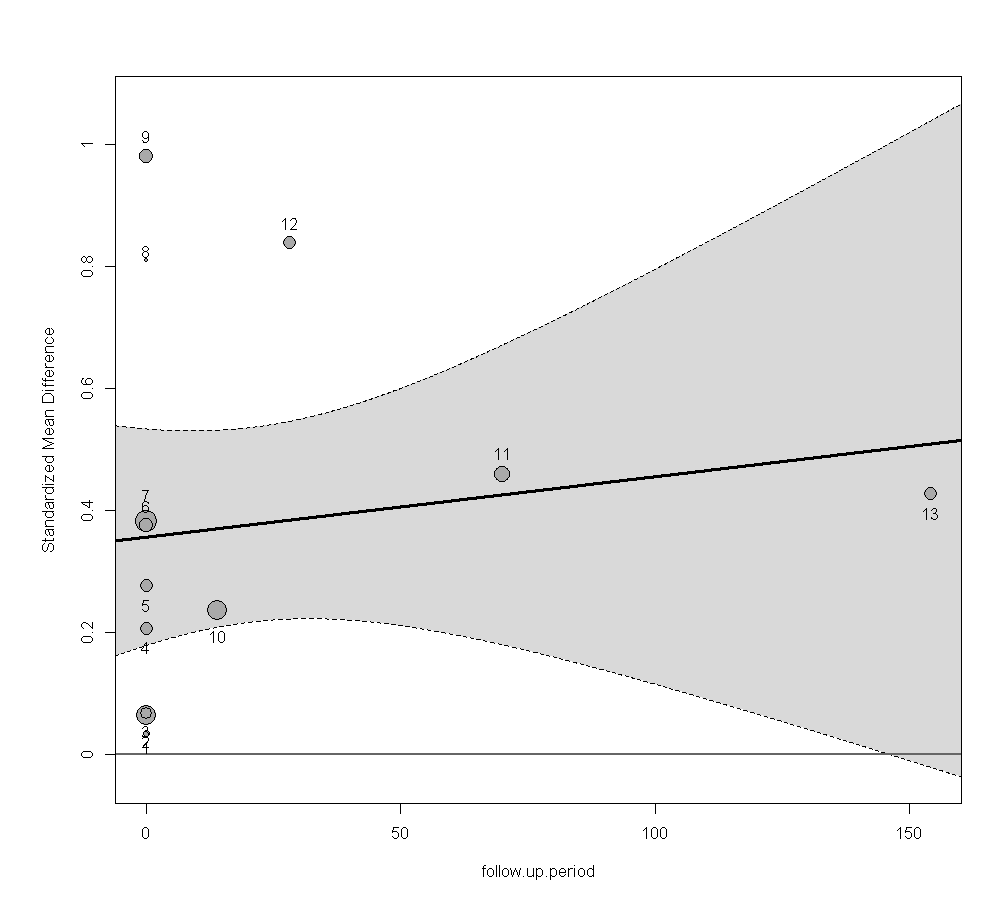

In [399]:
results.metfor.mindfulness.t <- print.meta.results("Mindfulness (trait)", return.data = "results.metafor")

Number of studies combined: k = 8
Number of observations: o = 682

                        SMD           95%-CI    z  p-value
Common effect model  0.3477 [0.1944; 0.5010] 4.45 < 0.0001
Random effects model 0.3652 [0.1424; 0.5880] 3.21   0.0013

Quantifying heterogeneity:
 tau^2 = 0.0443 [0.0000; 0.3870]; tau = 0.2106 [0.0000; 0.6221]
 I^2 = 44.4% [0.0%; 75.4%]; H = 1.34 [1.00; 2.02]

Test of heterogeneity:
     Q d.f. p-value
 12.60    7  0.0825

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 8
Number of observations: o = 682

                        SMD           95%-CI    z  p-value
Common effect model  0.3477 [0.1944; 0.5010] 4.45 < 0.0001
Random effects model 0.3652 [0.1424; 0.5880] 3.21   0.0013

Quantifying he

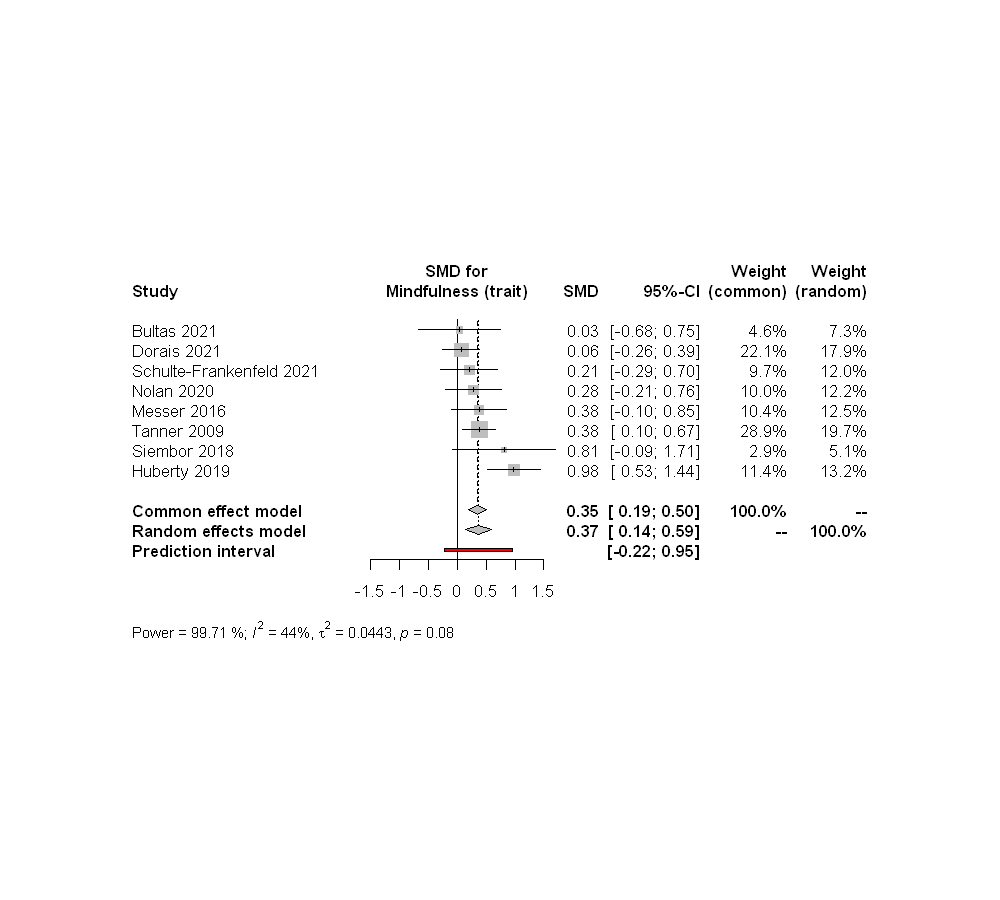


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 8
Number of observations: o = 682

                        SMD           95%-CI    z  p-value
Common effect model  0.3477 [0.1944; 0.5010] 4.45 < 0.0001
Random effects model 0.3652 [0.1424; 0.5880] 3.21   0.0013

Quantifying heterogeneity:
 tau^2 = 0.0443 [0.0000; 0.3870]; tau = 0.2106 [0.0000; 0.6221]
 I^2 = 44.4% [0.0%; 75.4%]; H = 1.34 [1.00; 2.02]

Test of heterogeneity:
     Q d.f. p-value
 12.60    7  0.0825

Results for subgroups (common effect model):
                                k    SMD           95%-CI    Q   I^2
subgroup = Attentional Family   6 0.2737 [0.1011; 0.4462] 4.12  0.0%
subgroup = Hybrid Form          2 0.6250 [0.2911; 0.9588] 5.13 80.5%

Test for subgroup differences (common effect model):
                  Q d.f. p-value
Between groups 3.36    1  0.0670
Within groups  9.24    6  0.1604

Results for subgroups (random effects model):
                                k    SMD            95%-CI

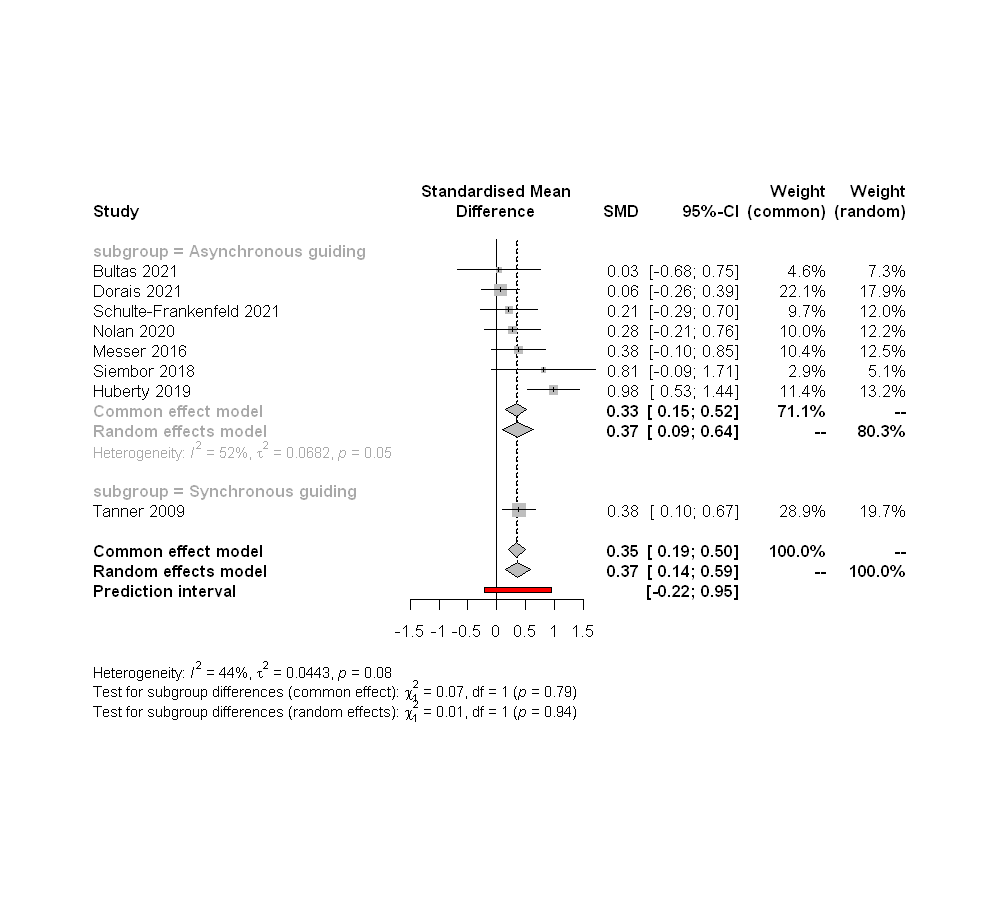

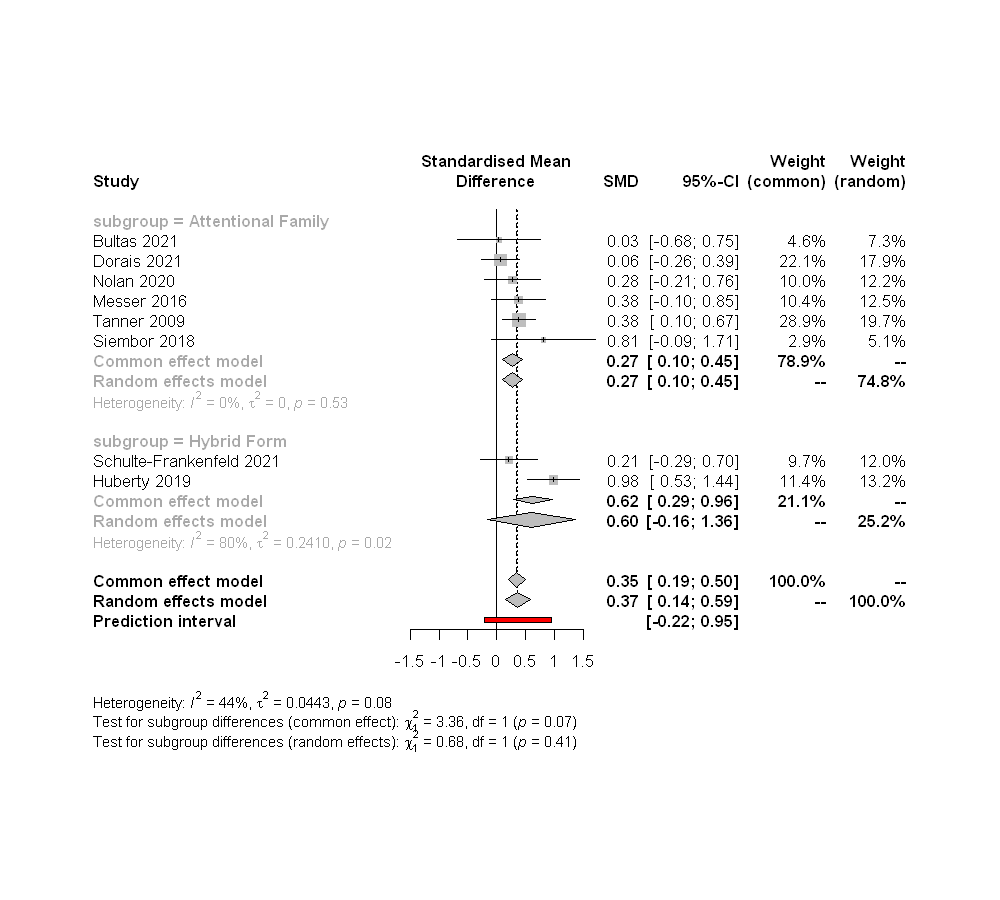

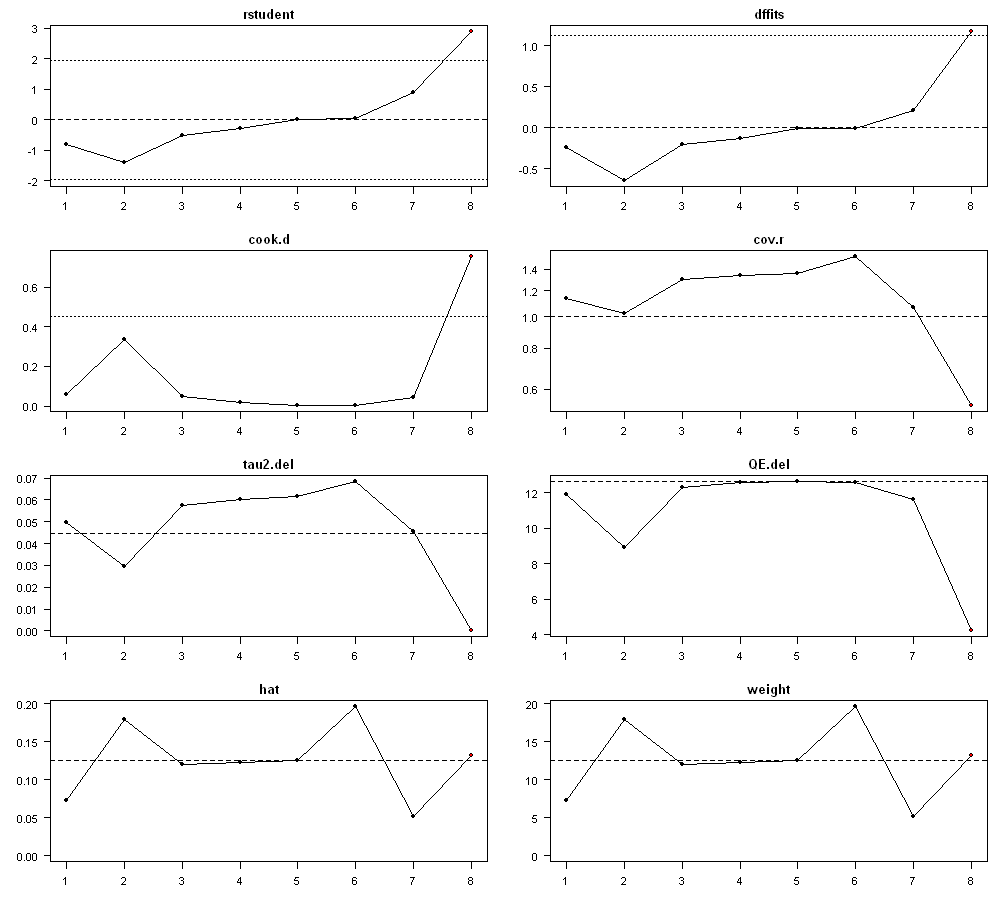

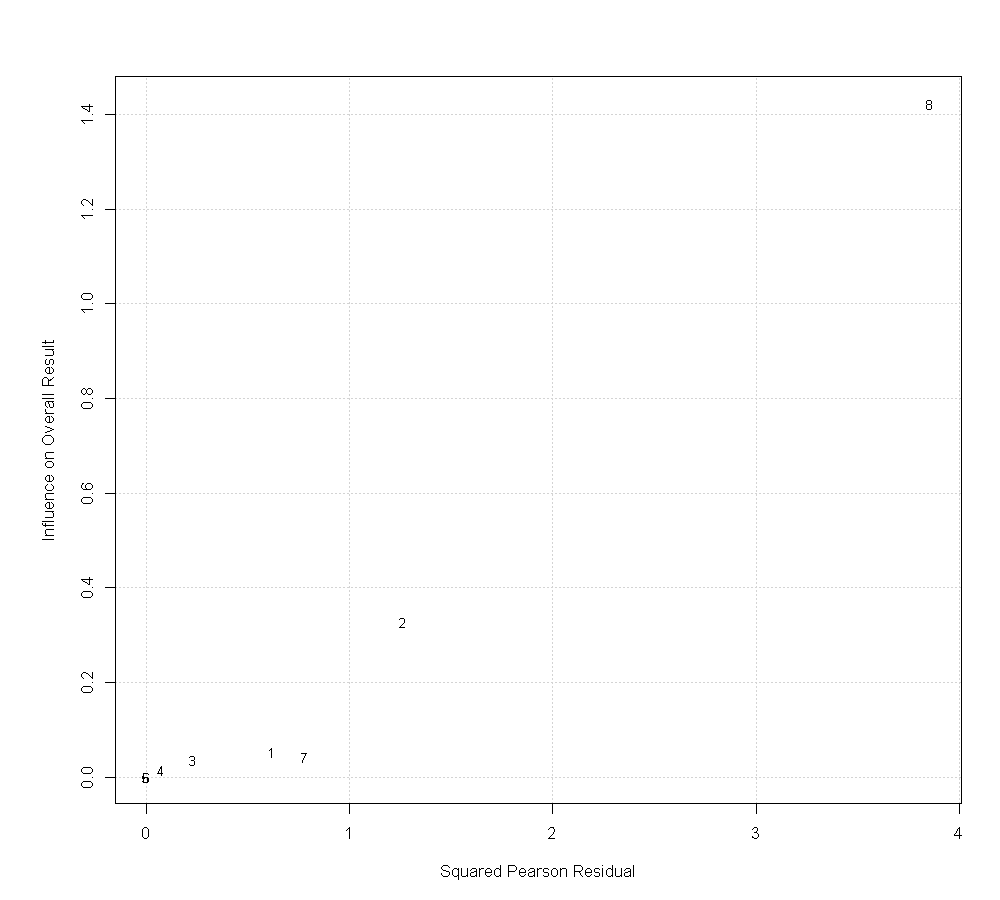

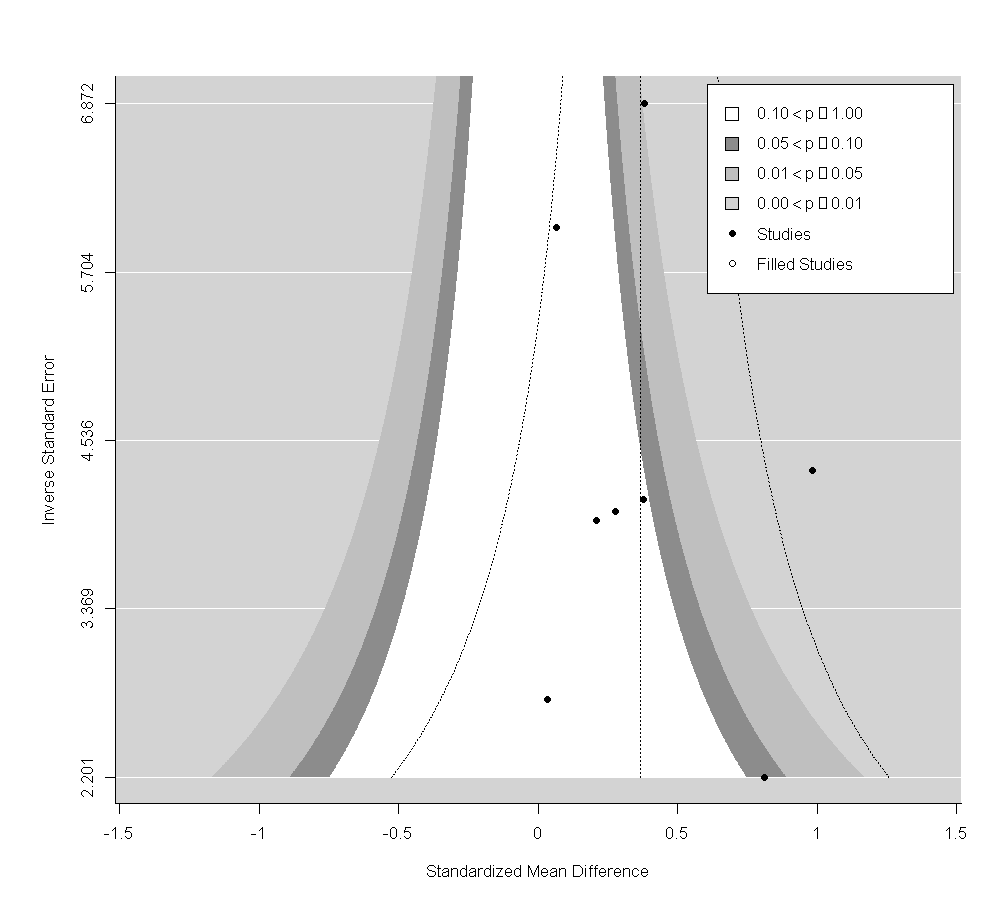

[1] "sessions.duration"

Mixed-Effects Model (k = 7; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0619 (SE = 0.0817)
tau (square root of estimated tau^2 value):             0.2489
I^2 (residual heterogeneity / unaccounted variability): 48.22%
H^2 (unaccounted variability / sampling variability):   1.93
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 5) = 9.5979, p-val = 0.0875

Test of Moderators (coefficient 2):
QM(df = 1) = 0.0433, p-val = 0.8351

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt              0.4166  0.3021   1.3789  0.1679  -0.1756  1.0088    
sessions.duration   -0.0035  0.0169  -0.2081  0.8351  -0.0367  0.0296    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



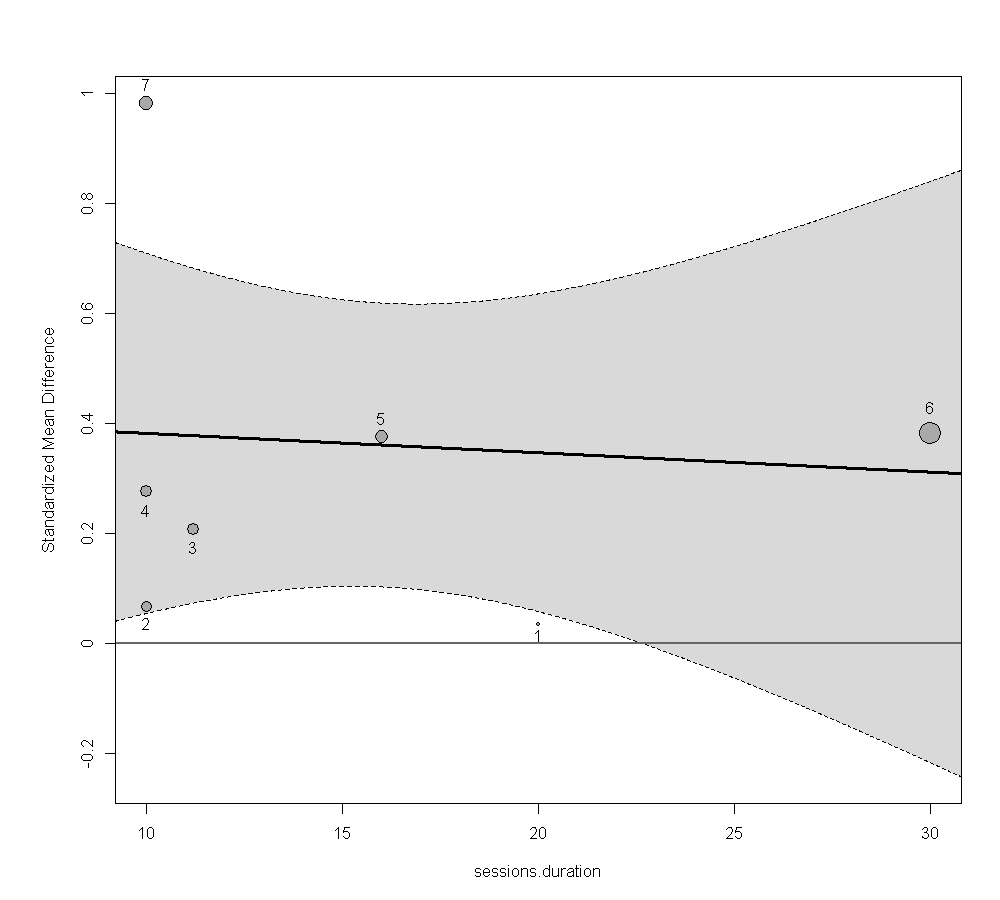

[1] "sessions.frequency"

Mixed-Effects Model (k = 5; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0 (SE = 0.0424)
tau (square root of estimated tau^2 value):             0
I^2 (residual heterogeneity / unaccounted variability): 0.00%
H^2 (unaccounted variability / sampling variability):   1.00
R^2 (amount of heterogeneity accounted for):            100.00%

Test for Residual Heterogeneity:
QE(df = 3) = 1.7349, p-val = 0.6292

Test of Moderators (coefficient 2):
QM(df = 1) = 9.6362, p-val = 0.0019

Model Results:

                    estimate      se    zval    pval    ci.lb   ci.ub     
intrcpt               0.0047  0.1408  0.0332  0.9735  -0.2714  0.2807     
sessions.frequency    0.0245  0.0079  3.1042  0.0019   0.0090  0.0399  ** 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



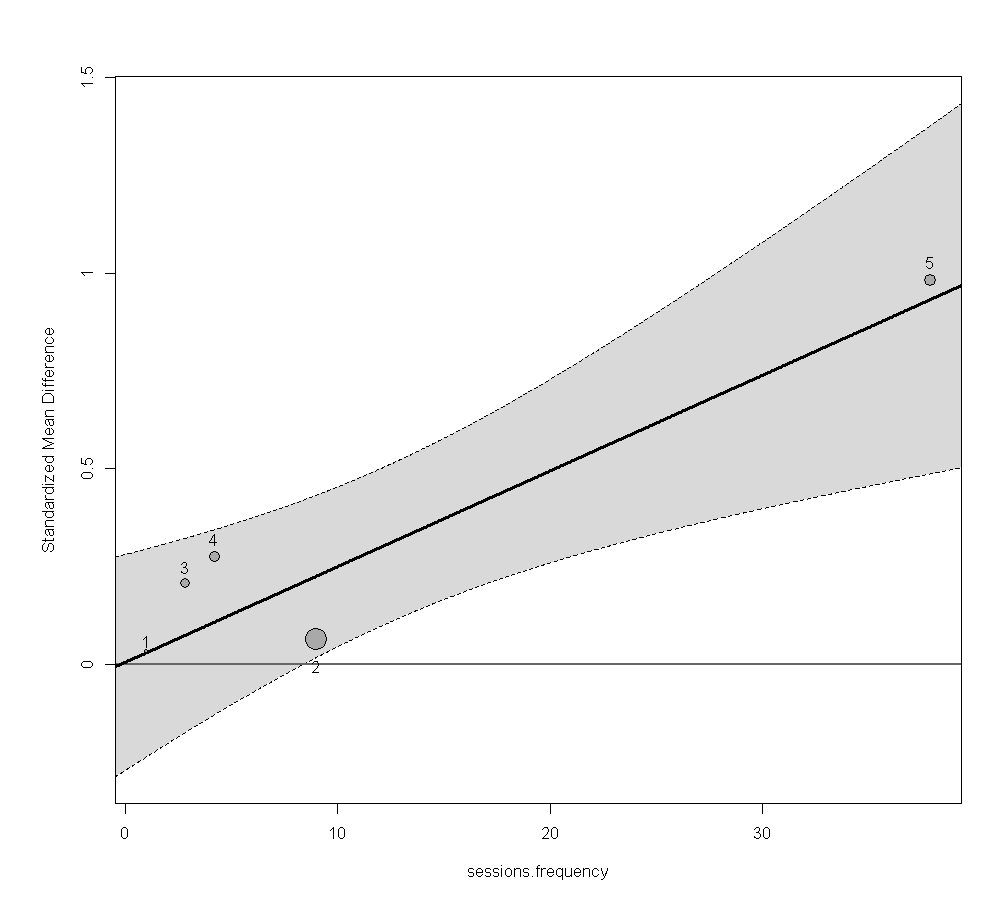

[1] "programs.duration"

Mixed-Effects Model (k = 7; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0644 (SE = 0.0839)
tau (square root of estimated tau^2 value):             0.2537
I^2 (residual heterogeneity / unaccounted variability): 49.75%
H^2 (unaccounted variability / sampling variability):   1.99
R^2 (amount of heterogeneity accounted for):            18.93%

Test for Residual Heterogeneity:
QE(df = 5) = 9.8651, p-val = 0.0791

Test of Moderators (coefficient 2):
QM(df = 1) = 1.4109, p-val = 0.2349

Model Results:

                   estimate      se    zval    pval    ci.lb   ci.ub    
intrcpt              0.0119  0.3074  0.0388  0.9690  -0.5905  0.6143    
programs.duration    0.0095  0.0080  1.1878  0.2349  -0.0062  0.0251    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



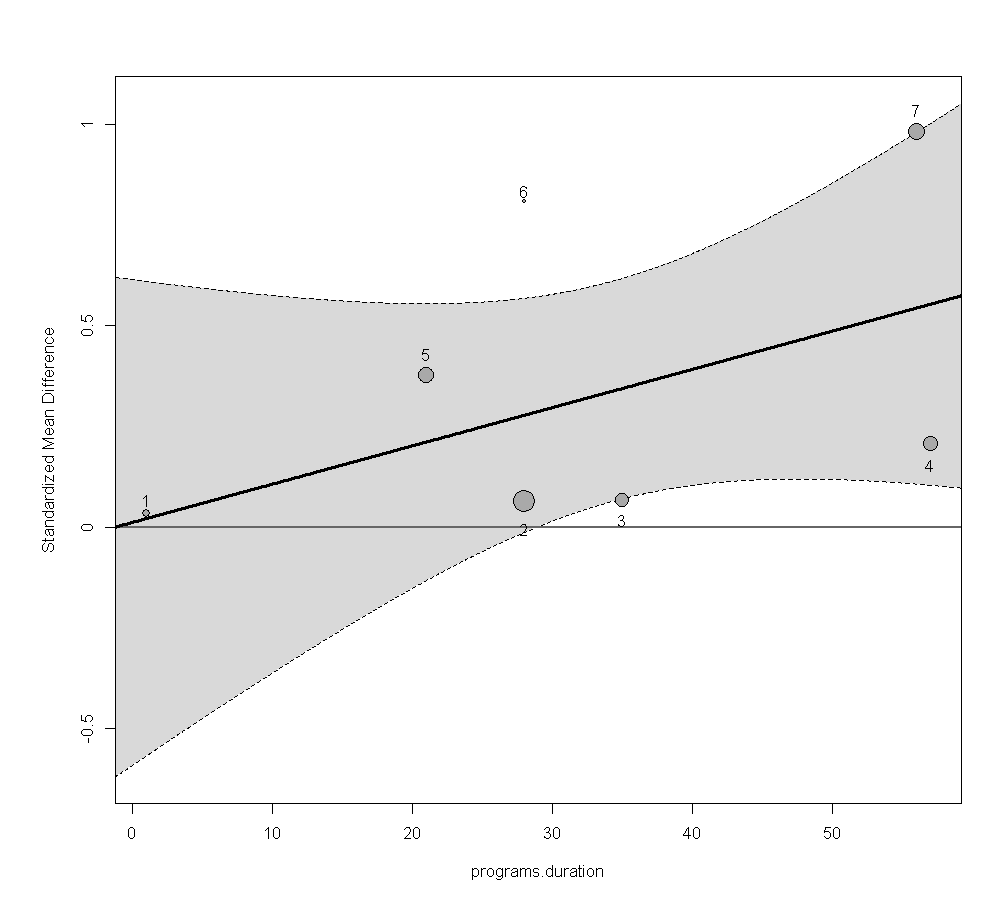

[1] "follow.up.period"

Mixed-Effects Model (k = 13; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0317 (SE = 0.0351)
tau (square root of estimated tau^2 value):             0.1780
I^2 (residual heterogeneity / unaccounted variability): 38.99%
H^2 (unaccounted variability / sampling variability):   1.64
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 11) = 17.9180, p-val = 0.0835

Test of Moderators (coefficient 2):
QM(df = 1) = 0.2635, p-val = 0.6077

Model Results:

                  estimate      se    zval    pval    ci.lb   ci.ub      
intrcpt             0.3561  0.0905  3.9323  <.0001   0.1786  0.5335  *** 
follow.up.period    0.0010  0.0019  0.5133  0.6077  -0.0028  0.0048      

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "delivery.mode"

Mixed-Effects Model (k = 9; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0596 (SE = 0.

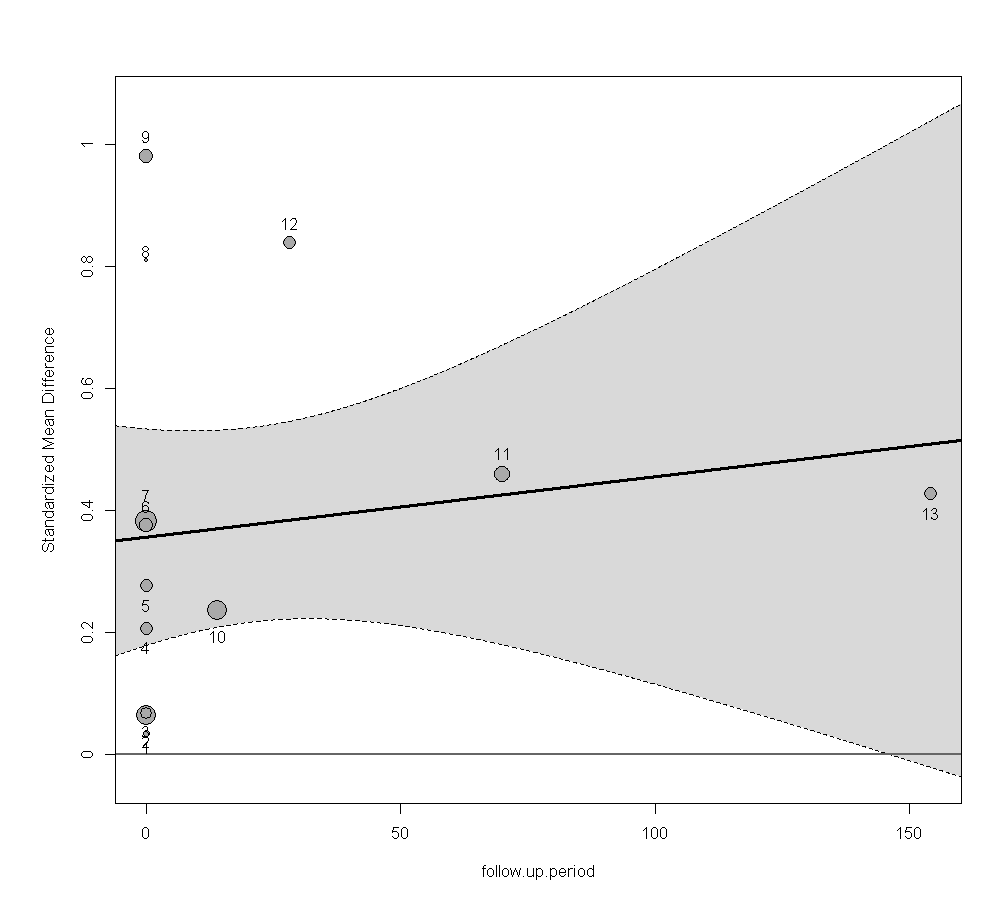

In [400]:
print.meta.results("Mindfulness (trait)", exclude.high.rob.vec = studies.high.rob)  # exclude Johnson-Waddell 2018 (No. 3)

Number of studies combined: k = 8
Number of observations: o = 658

                        SMD           95%-CI    z p-value
Common effect model  0.2489 [0.0934; 0.4044] 3.14  0.0017
Random effects model 0.2489 [0.0934; 0.4044] 3.14  0.0017

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1305]; tau = 0 [0.0000; 0.3612]
 I^2 = 0.0% [0.0%; 67.6%]; H = 1.00 [1.00; 1.76]

Test of heterogeneity:
    Q d.f. p-value
 4.68    7  0.6985

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)


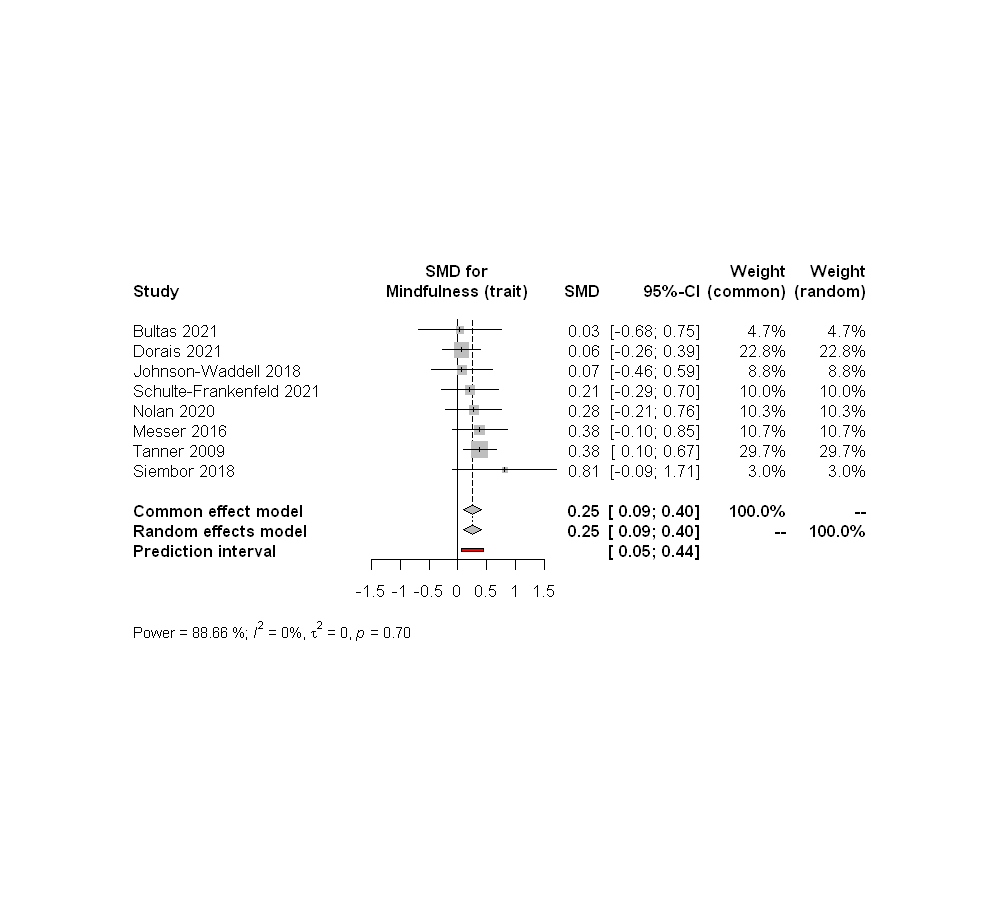

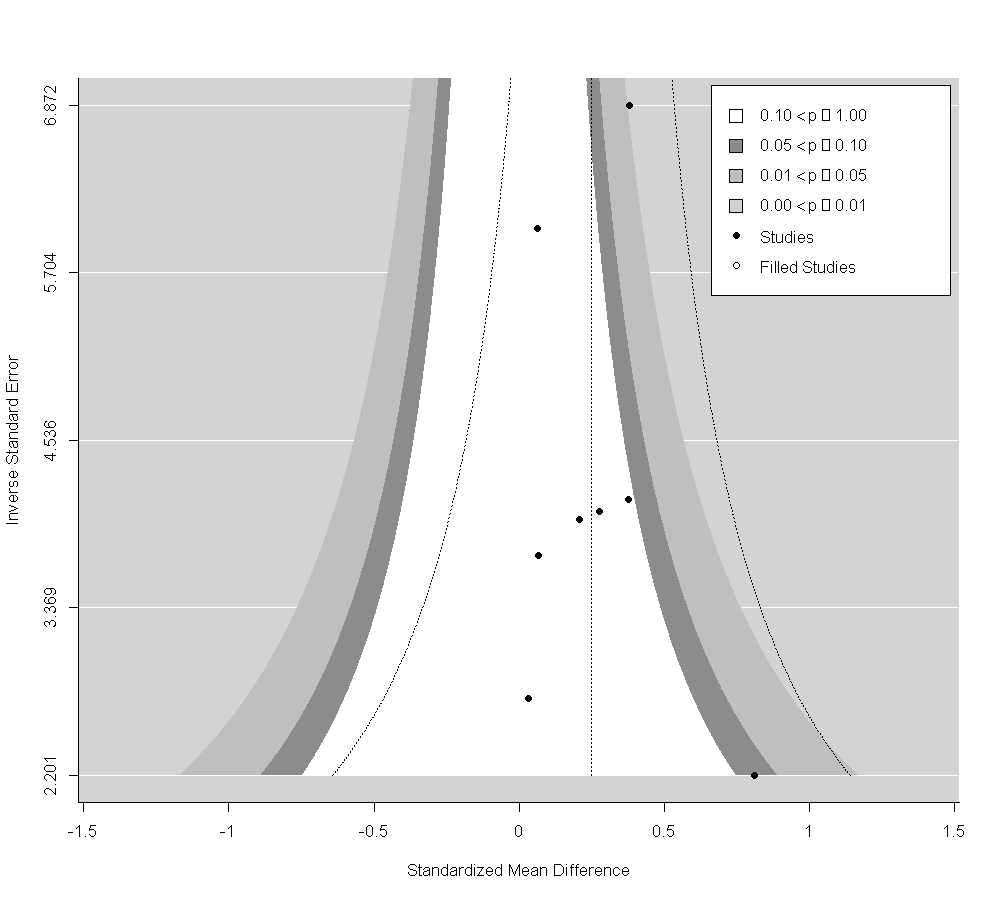

In [401]:
# exclude outlier
print.meta.results("Mindfulness (trait)", filter.forest..funnel.vec = -c(9), regression = F, split.subgroups = F, print.influence = F)

Number of studies combined: k = 8
Number of observations: o = 682

                        SMD           95%-CI    z  p-value
Common effect model  0.3477 [0.1944; 0.5010] 4.45 < 0.0001
Random effects model 0.3652 [0.1424; 0.5880] 3.21   0.0013

Quantifying heterogeneity:
 tau^2 = 0.0443 [0.0000; 0.3870]; tau = 0.2106 [0.0000; 0.6221]
 I^2 = 44.4% [0.0%; 75.4%]; H = 1.34 [1.00; 2.02]

Test of heterogeneity:
     Q d.f. p-value
 12.60    7  0.0825

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)


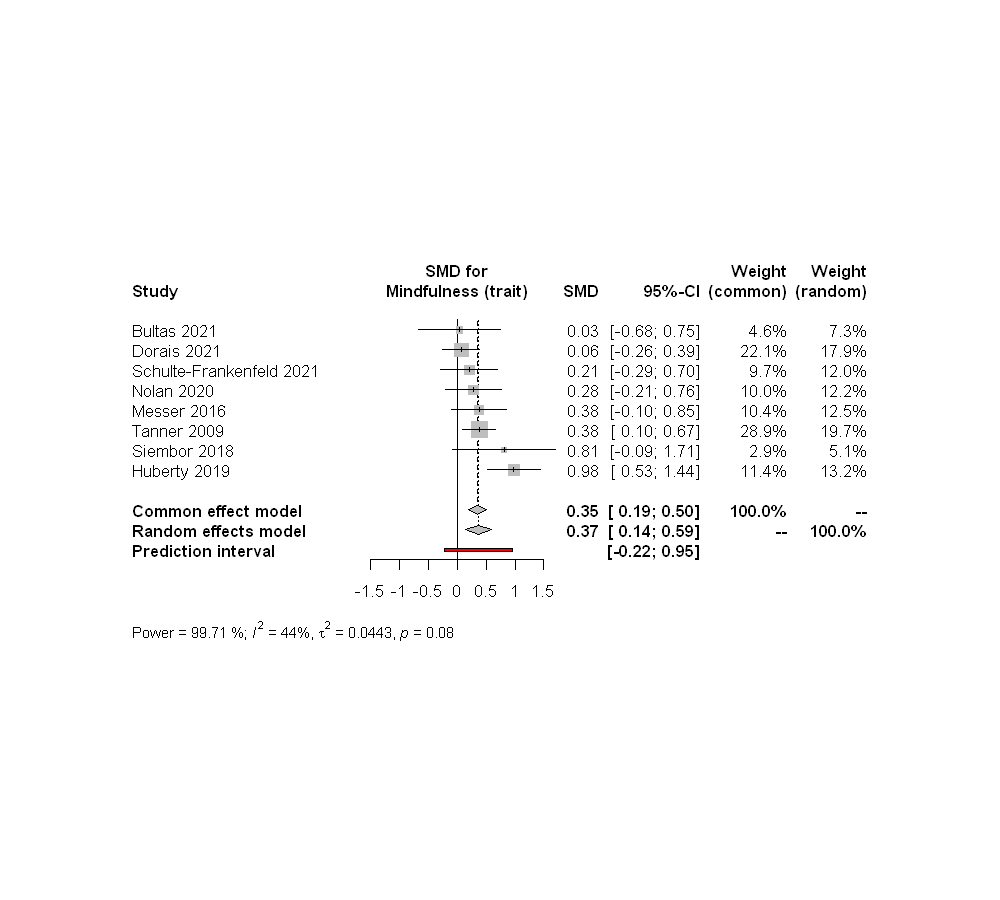

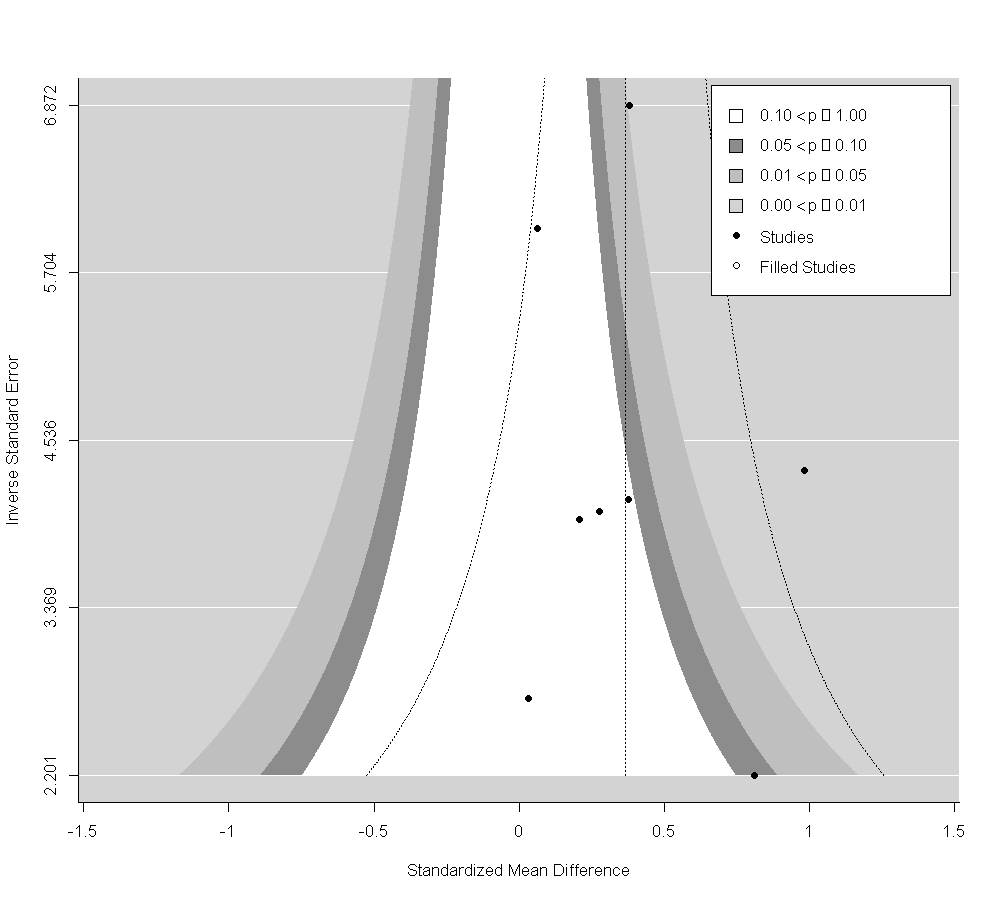

In [402]:
# exclude high rob study
print.meta.results("Mindfulness (trait)", filter.forest..funnel.vec = -c(3), regression = F, split.subgroups = F, print.influence = F)

Number of studies combined: k = 7
Number of observations: o = 598

                        SMD           95%-CI    z p-value
Common effect model  0.2664 [0.1035; 0.4292] 3.21  0.0013
Random effects model 0.2664 [0.1035; 0.4292] 3.21  0.0013

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1826]; tau = 0 [0.0000; 0.4273]
 I^2 = 0.0% [0.0%; 70.8%]; H = 1.00 [1.00; 1.85]

Test of heterogeneity:
    Q d.f. p-value
 4.18    6  0.6524

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)


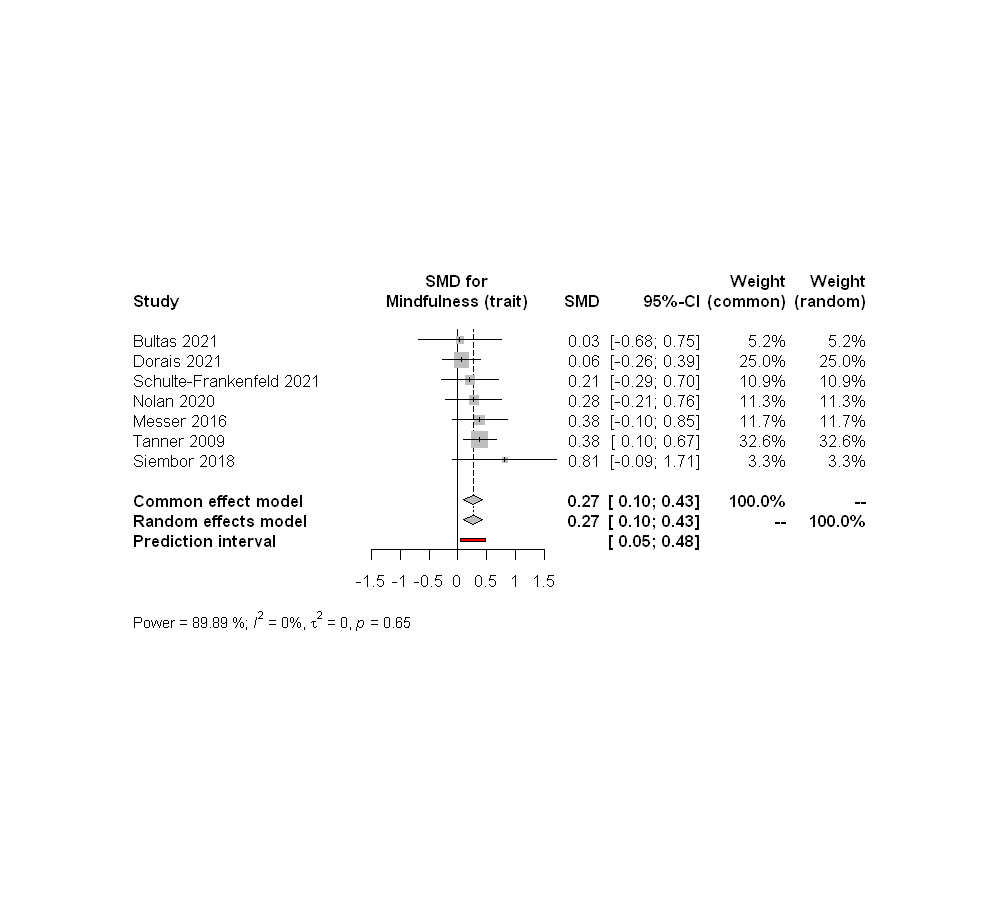

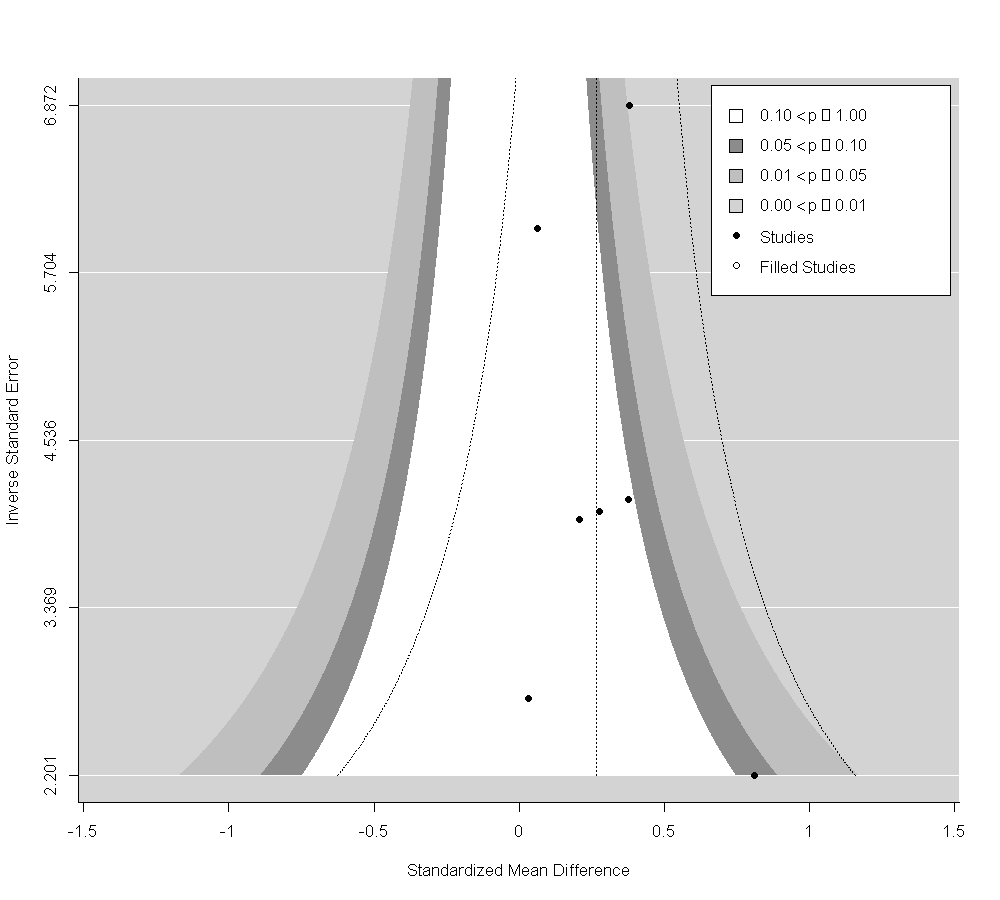

In [403]:
# exclude both
print.meta.results("Mindfulness (trait)", filter.forest..funnel.vec = -c(3, 9), regression = F, split.subgroups = F, print.influence = F)

Fitting 511 models (based on all possible subsets).

Fitting 511 models (based on all possible subsets).



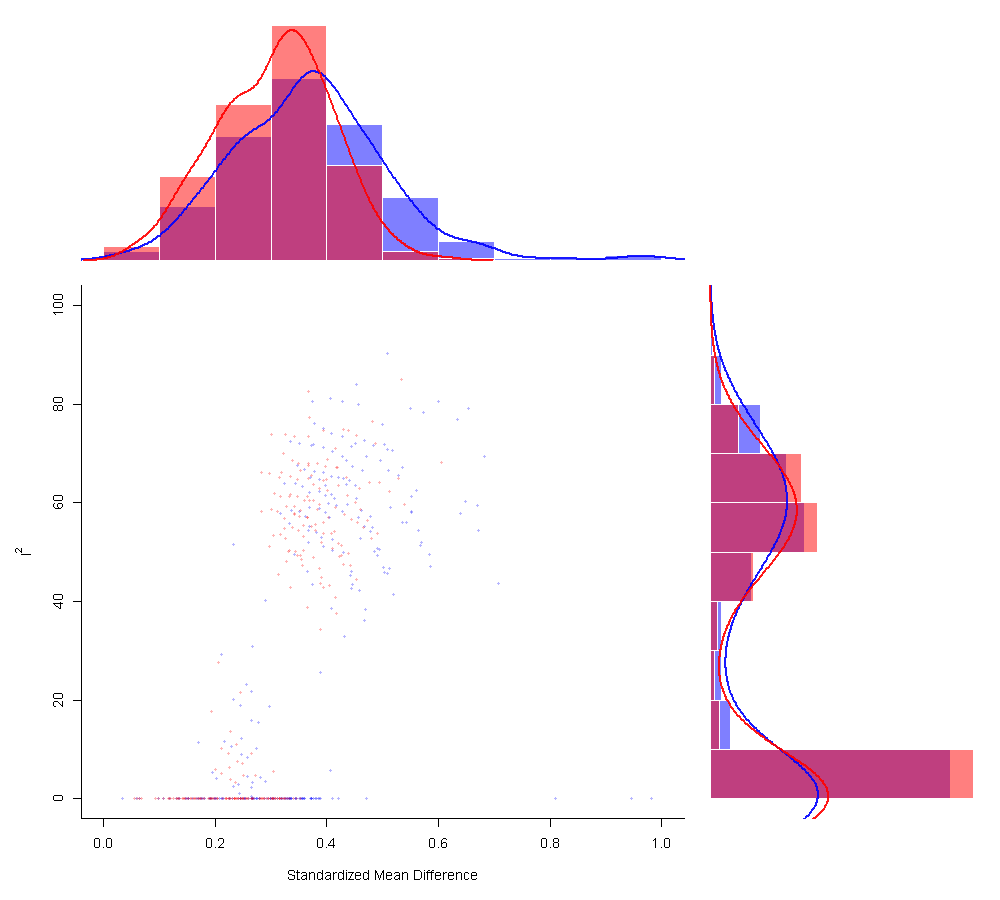

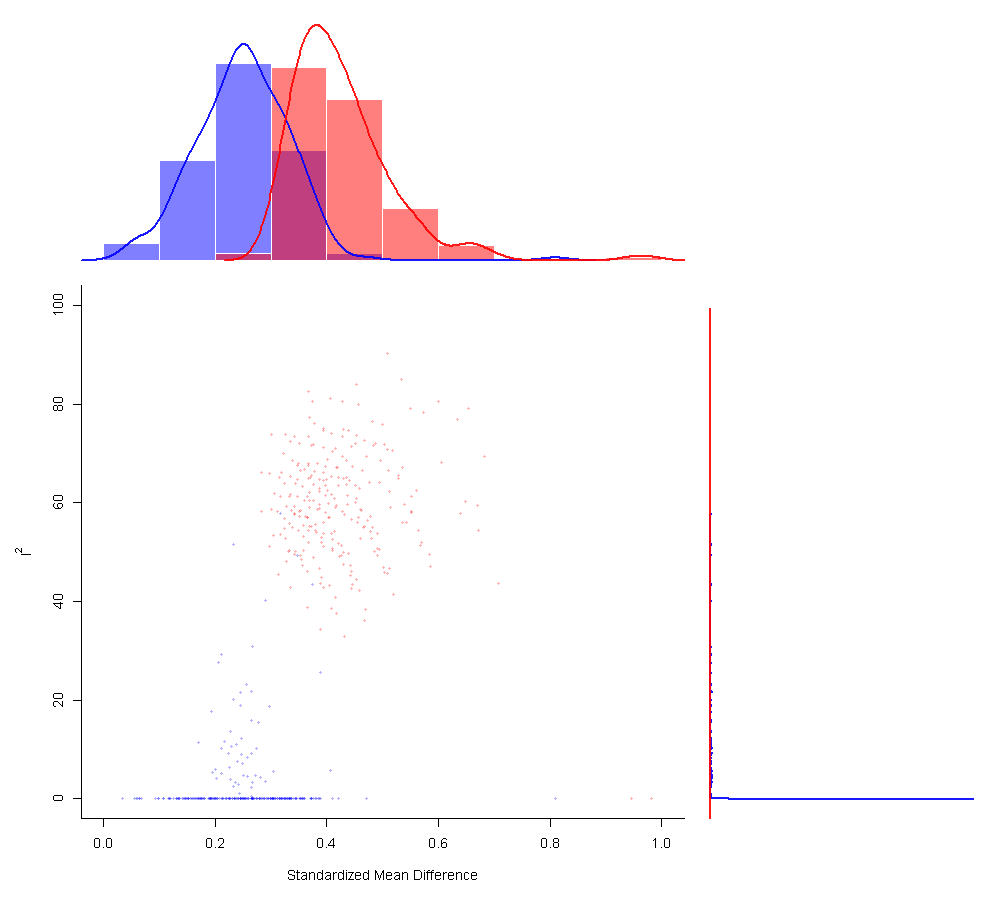

In [404]:
for (outlier in c(3, 9)){
  sav <- gosh(results.metfor.mindfulness.t)
  plot(sav, out = outlier)
}

Number of observations: o = 82

              SMD            95%-CI    z p-value
Barry 2019 0.1488 [-0.2853; 0.5828] 0.67  0.5017

Details:
- Inverse variance method
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (1) for the funnel plot is below 3 for outcome: Optimism or positive attributional style"

[1] "Number of included studies (1) in regression is below 3 for outcome \"Optimism or positive attributional style\" and moderator \"sessions.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Optimism or positive attributional style\" and moderator \"sessions.frequency\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Optimism or positive attributional style\" and moderator \"programs.duration\""

[1] "Number of included studies (1) in regression is

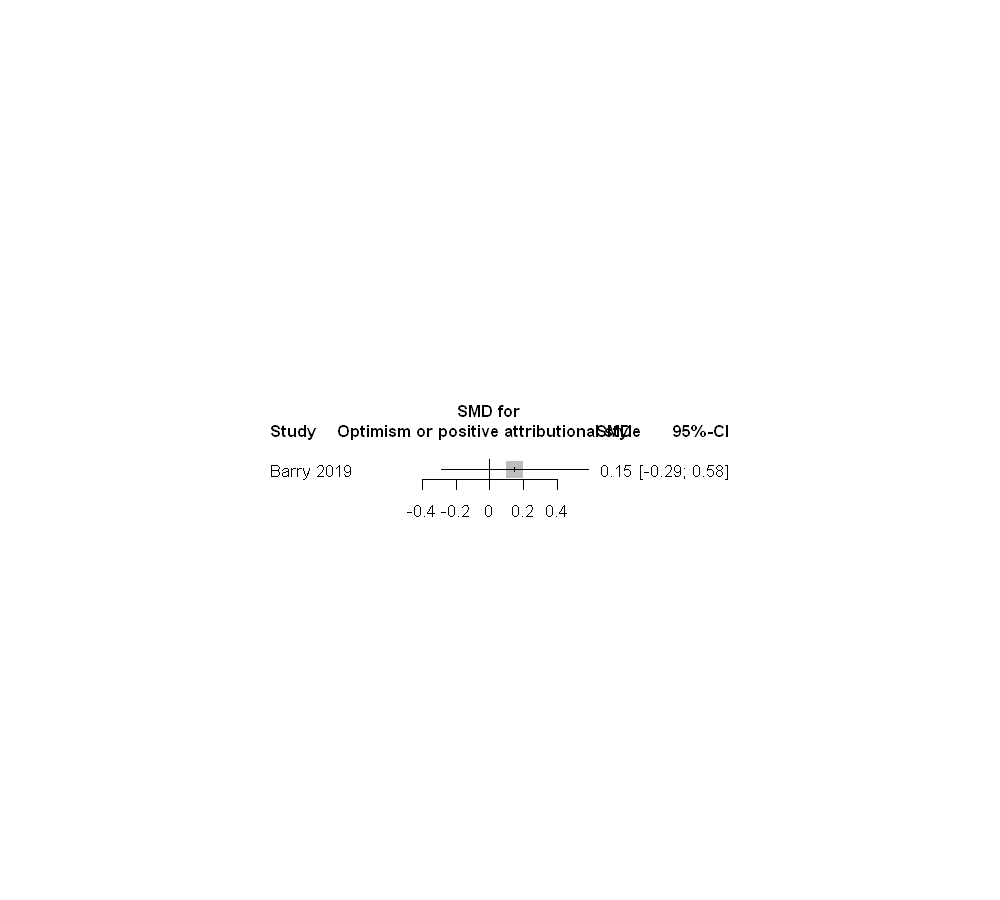

In [405]:
print.meta.results("Optimism or positive attributional style")

Number of observations: o = 77

                SMD           95%-CI    z p-value
Weytens 2014 0.6872 [0.2250; 1.1493] 2.91  0.0036

Details:
- Inverse variance method
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (1) for the funnel plot is below 3 for outcome: Positive emotion"

[1] "Number of included studies (0) in regression is below 3 for outcome \"Positive emotion\" and moderator \"sessions.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Positive emotion\" and moderator \"sessions.frequency\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Positive emotion\" and moderator \"programs.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Positive emotion\" and moderator \"follow.up.period\""

[1] "Number of 

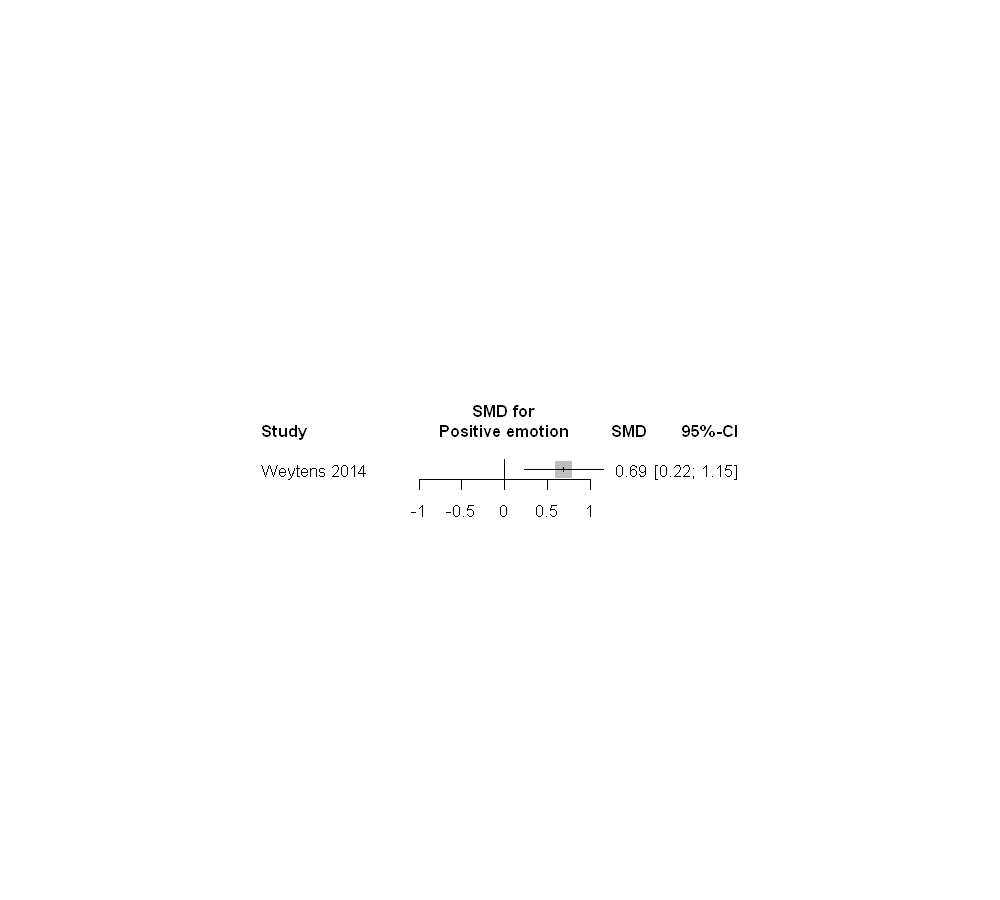

In [406]:
print.meta.results("Positive emotion")

In [407]:
print.meta.results("Religiosity or spirituality or religious coping")

no studies included for outcome: Religiosity or spirituality or religious coping 

[1] "Number of included studies (0) for the funnel plot is below 3 for outcome: Religiosity or spirituality or religious coping"

no studies included for outcome: Religiosity or spirituality or religious coping 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Religiosity or spirituality or religious coping\" and moderator \"sessions.duration\""

no studies included for outcome: Religiosity or spirituality or religious coping 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Religiosity or spirituality or religious coping\" and moderator \"sessions.frequency\""

no studies included for outcome: Religiosity or spirituality or religious coping 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Religiosity or spirituality or religious coping\" and moderator \"programs.duration\""

no studies included for outcome: Religiosity or 

Number of observations: o = 23

                 SMD            95%-CI     z p-value
deGrace 1976 -0.6025 [-1.4613; 0.2562] -1.38  0.1691

Details:
- Inverse variance method
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (1) for the funnel plot is below 3 for outcome: Self-acceptance"

[1] "Number of included studies (1) in regression is below 3 for outcome \"Self-acceptance\" and moderator \"sessions.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Self-acceptance\" and moderator \"sessions.frequency\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Self-acceptance\" and moderator \"programs.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Self-acceptance\" and moderator \"follow.up.period\""

[1] "Number of

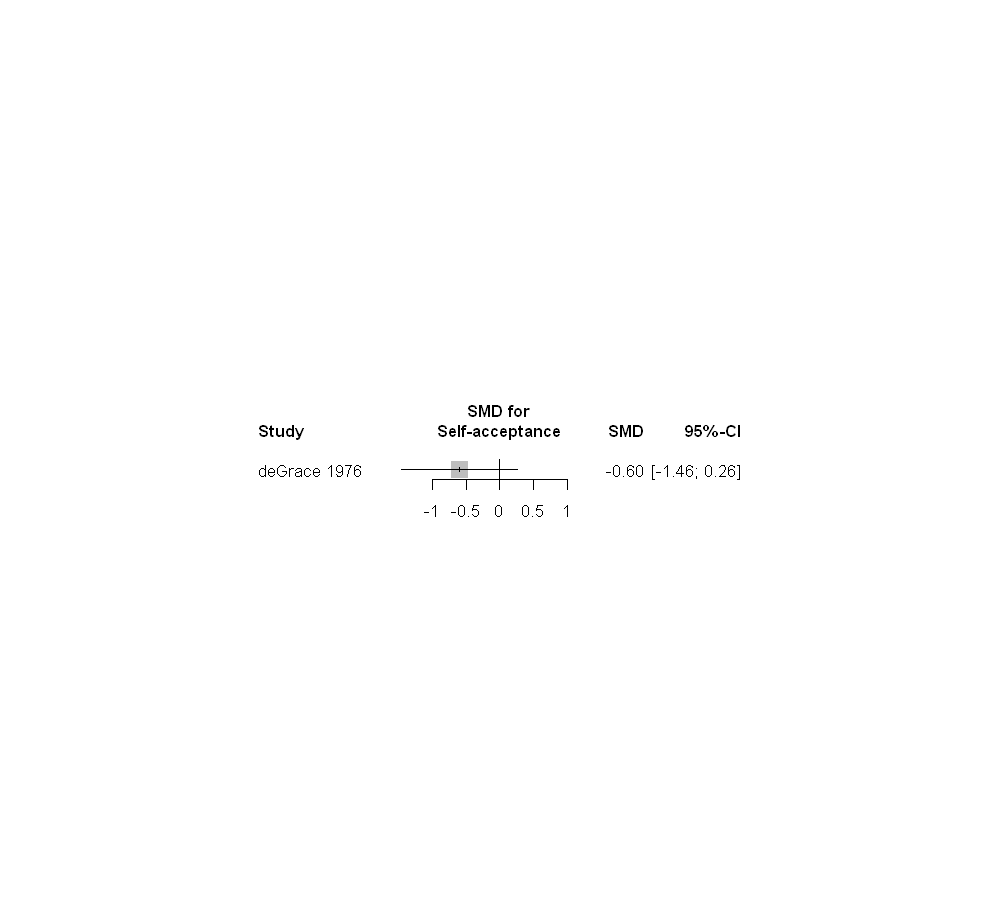

In [408]:
print.meta.results("Self-acceptance")

Number of studies combined: k = 2
Number of observations: o = 167

                        SMD           95%-CI    z p-value
Common effect model  0.4110 [0.1033; 0.7186] 2.62  0.0088
Random effects model 0.4107 [0.0934; 0.7280] 2.54  0.0112

Quantifying heterogeneity:
 tau^2 = 0.0031; tau = 0.0559; I^2 = 6.0%; H = 1.03

Test of heterogeneity:
    Q d.f. p-value
 1.06    1  0.3024

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (2) for the funnel plot is below 3 for outcome: Self-compassion"

[1] "Number of included studies (2) in regression is below 3 for outcome \"Self-compassion\" and moderator \"sessions.duration\""

[1] "Number of included studies (2) in regression is below 3 for outcome \"Self-comp

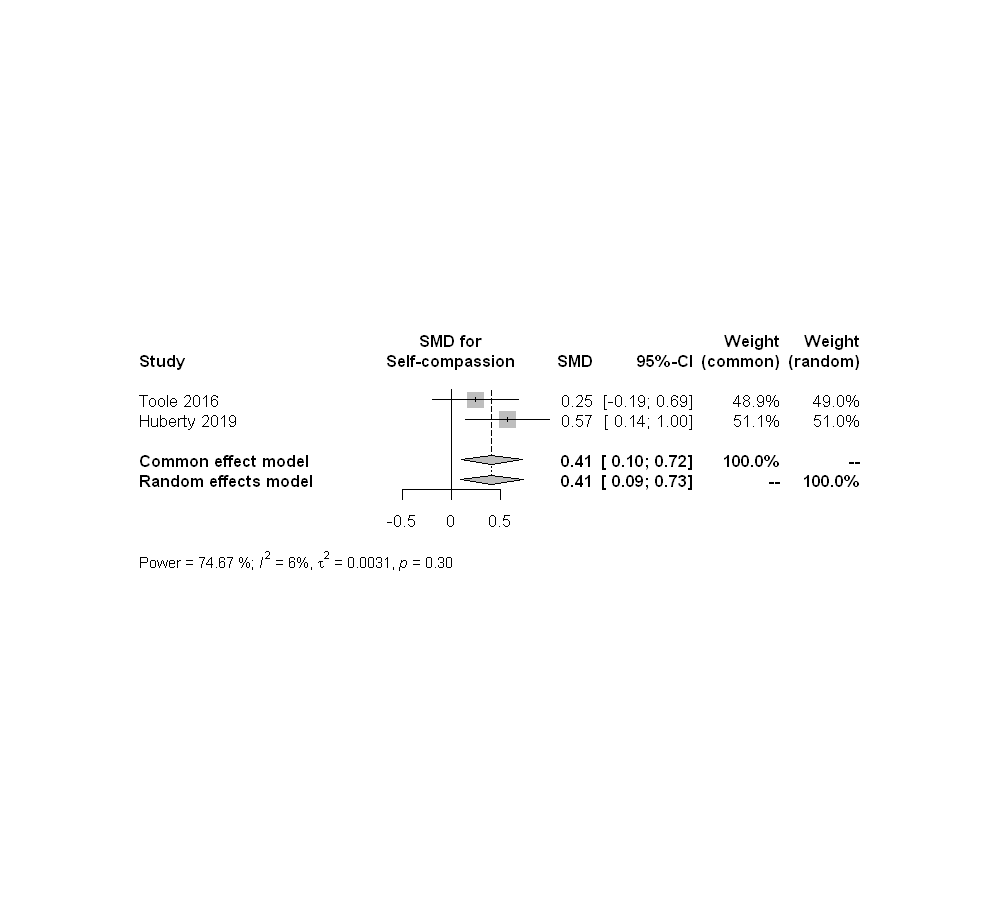

In [409]:
print.meta.results("Self-compassion")

Number of observations: o = 82

              SMD            95%-CI    z p-value
Barry 2019 0.4103 [-0.0278; 0.8485] 1.84  0.0664

Details:
- Inverse variance method
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

[1] "k < 4 => no Subgroup Analysis"


[1] "number of included studies is below 3 --> now influence analysis"
[1] "Number of included studies (1) for the funnel plot is below 3 for outcome: Self-efficacy"

[1] "Number of included studies (1) in regression is below 3 for outcome \"Self-efficacy\" and moderator \"sessions.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Self-efficacy\" and moderator \"sessions.frequency\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Self-efficacy\" and moderator \"programs.duration\""

[1] "Number of included studies (1) in regression is below 3 for outcome \"Self-efficacy\" and moderator \"follow.up.period\""

[1] "Number of included studies 

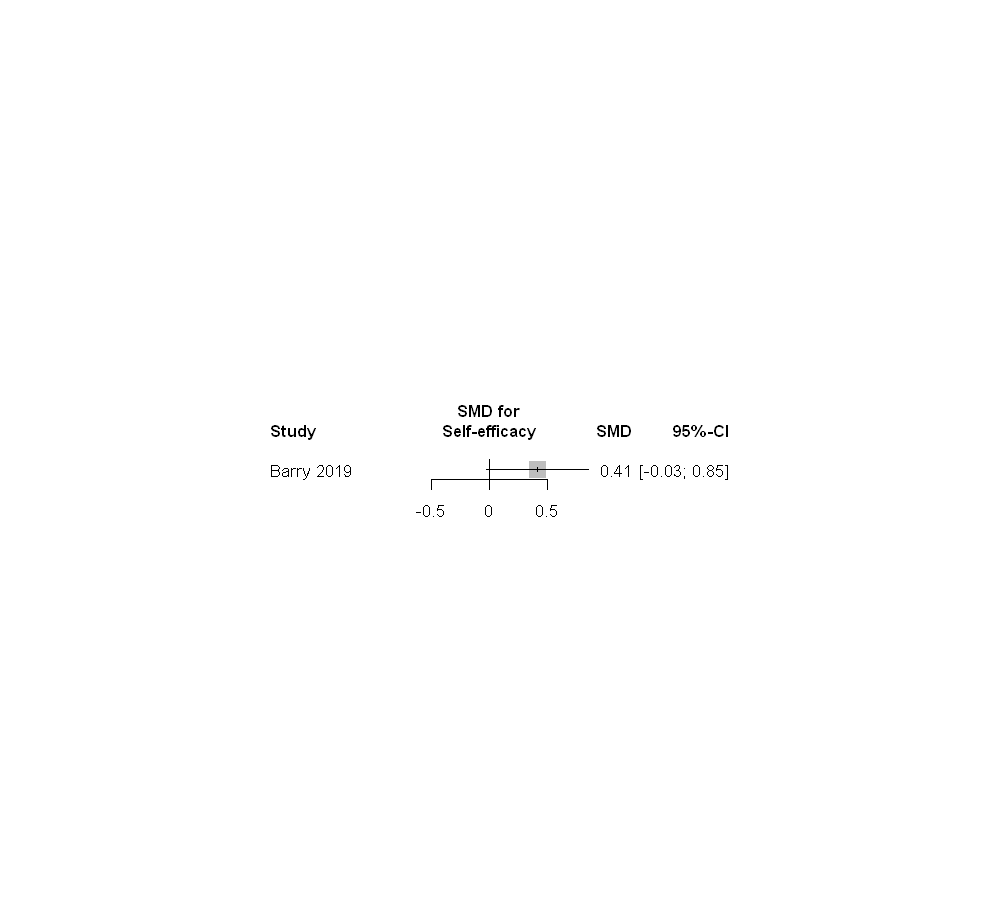

In [410]:
print.meta.results("Self-efficacy")

In [411]:
print.meta.results("Self-esteem")

no studies included for outcome: Self-esteem 

[1] "Number of included studies (0) for the funnel plot is below 3 for outcome: Self-esteem"

no studies included for outcome: Self-esteem 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Self-esteem\" and moderator \"sessions.duration\""

no studies included for outcome: Self-esteem 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Self-esteem\" and moderator \"sessions.frequency\""

no studies included for outcome: Self-esteem 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Self-esteem\" and moderator \"programs.duration\""

no studies included for outcome: Self-esteem 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Self-esteem\" and moderator \"follow.up.period\""

no studies included for outcome: Self-esteem 

[1] "Number of included studies (0) in regression is below 3 for outcome \"Self-esteem\" and moderator \"delivery.mo

### All Outcomes (Summary)

In [412]:
# install.packages("tidyr")
# install.packages("gridExtra")
# install.packages("forcats")
# install.packages("tidyr")

In [413]:
library(ggplot2)
library(gridExtra)

In [414]:
# get total effect sizes and confidence intervals of all outcomes
outcomes <- c()
k <- c()
o <- c()  # total observations
te <- c()
ci.l <- c()
ci.u <- c()
I2 <- c()
pow <- c()

for (outcome in present.outcomes){
  if (outcome == "Stress"){
    preferred.scale <- "PSS"
  } else {
    preferred.scale <- FALSE
  }
  results.meta <- meta.analyze(
    outcome = outcome, meditation.types = meditation.type.all, m.data.list = m.data.list,
    return.data = "results.meta", preferred.scale = preferred.scale, split.subgroups = FALSE
  )
  if (results.meta$k > 0){
    outcomes <- append(outcomes, outcome)
    k <- append(k, results.meta$k)
    o <- append(
      o, sum(results.meta$data[, "n.int"]) + sum(results.meta$data[, "n.control"])
    )
    te  <- append(te, results.meta$TE.common)
    ci.l  <- append(ci.l, results.meta$lower.common)
    ci.u <- append(ci.u, results.meta$upper.common)
    I2 <- append(I2, results.meta$I2)
    pow <- append(pow, results.meta$power)
  }
}

df.sum <- data.frame(
  outcomes = outcomes,
  k = k,
  o = o,
  te = te,
  ci.l = ci.l,
  ci.u = ci.u,
  I2 = I2,
  pow = pow
)

# correct scale  directions
for (outcome in df.sum[,"outcomes"]){
  if (outcome.direction.df[outcome.direction.df[,"Outcome"] == outcome, "High.or.low.means.resilient"] == "v"){
    df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.l", "ci.u")] <- -1 * df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.l", "ci.u")]
  }
}

# sort by te
df.sum <- arrange(df.sum, te)

# create col with I^2 is 0 instead of NA
df.sum$I2.trans <- df.sum$I2

df.sum[is.na(df.sum$I2.trans), "I2.trans"] <- 0

# roud values
df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")] <- round(df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")], 2)

# create col of strings with te an ci vaulues
df.sum$te.ci <- paste(
  as.character(df.sum$te), " (",
  as.character(df.sum$ci.l), ", ",
  as.character(df.sum$ci.u), ")",
  sep = ""
)

# create col of strings with observation and no. of studies
df.sum$o.k <- paste(
  as.character(df.sum$o), " (",
  as.character(df.sum$k), ")",
  sep = ""
)

# set band colours for table
df.sum$colour <- rep(c("white", "gray95"), nrow(df.sum) / 2)

# correct differece of order due to rounding in band coulor
df.sum[df.sum[,"outcomes"] == "Self-efficacy", "colour"] <- "white"
df.sum[df.sum[,"outcomes"] == "Self-compassion", "colour"] <- "gray95"
df.sum[df.sum[,"outcomes"] == "Mindfulness (trait)", "colour"] <- "white"
df.sum[df.sum[,"outcomes"] == "Depression (trait)", "colour"] <- "gray95"

df.sum

no studies included for outcome: Acceptance 

no studies included for outcome: Religiosity or spirituality or religious coping 

no studies included for outcome: Self-esteem 



outcomes                                 k  o   te    ci.l  ci.u I2   pow   
1  Self-acceptance                           1  23 -0.60 -1.46 0.26   NA  28.16
2  Resilience Scale                          2 114 -0.01 -0.39 0.36 0.82  20.13
3  Empathy                                   2 470  0.13 -0.05 0.32 0.32  30.37
4  Optimism or positive attributional style  1  82  0.15 -0.29 0.58   NA  10.31
5  Anxiety (trait)                           6 441  0.22  0.41 0.04 0.00  64.72
6  Coping flexibility                        1  21  0.23 -0.63 1.09   NA   8.30
7  Anxiety (state)                           3 327  0.24  0.46 0.02 0.00  57.25
8  Mindfulness (trait)                       9 742  0.33  0.18 0.47 0.41  99.47
9  Depression (trait)                        7 518  0.33  0.50 0.15 0.27  96.19
10 Well-being or quality of life             5 393  0.37  0.17 0.57 0.00  94.87
11 Stress                                   14 988  0.40  0.53 0.27 0.49 100.00
12 Self-efficacy                             1  82  0.41 -0.03 0.85   NA  45.09
13 Self-compassion                           2 167  0.41  0.10 0.72 0.06  74.67
14 Positive emotion                          1  77  0.69  0.22 1.15   NA  83.10
15 Hope                                      1  82  0.73  0.28 1.18   NA  88.97
16 Mindfulness (state)                       2 174  2.81  2.38 3.23 0.64 100.00
   I2.trans te.ci               o.k      colour
1  0.00     -0.6 (-1.46, 0.26)  23 (1)   white 
2  0.82     -0.01 (-0.39, 0.36) 114 (2)  gray95
3  0.32     0.13 (-0.05, 0.32)  470 (2)  white 
4  0.00     0.15 (-0.29, 0.58)  82 (1)   gray95
5  0.00     0.22 (0.41, 0.04)   441 (6)  white 
6  0.00     0.23 (-0.63, 1.09)  21 (1)   gray95
7  0.00     0.24 (0.46, 0.02)   327 (3)  white 
8  0.41     0.33 (0.18, 0.47)   742 (9)  white 
9  0.27     0.33 (0.5, 0.15)    518 (7)  gray95
10 0.00     0.37 (0.17, 0.57)   393 (5)  gray95
11 0.49     0.4 (0.53, 0.27)    988 (14) white 
12 0.00     0.41 (-0.03, 0.85)  82 (1)   white 
13 0.06     0.41 (0.1, 0.72)    167 (2)  gray95
14 0.00     0.69 (0.22, 1.15)   77 (1)   gray95
15 0.00     0.73 (0.28, 1.18)   82 (1)   white 
16 0.64     2.81 (2.38, 3.23)   174 (2)  gray95

In [415]:
fun_color_range <- colorRampPalette(c("chartreuse4", "gold", "red"))  # Create color generating function
my_colors <- fun_color_range(20)
my_colors           

[1] "#458B00" "#589300" "#6C9B00" "#7FA300" "#93AB00" "#A6B300" "#BABB00"
 [8] "#CEC300" "#E1CB00" "#F5D300" "#FFCB00" "#FFB500" "#FF9E00" "#FF8700"
[15] "#FF7100" "#FF5A00" "#FF4300" "#FF2D00" "#FF1600" "#FF0000"

In [416]:
# found order of band colours in forest plot
correct.order <- c(
  which(df.sum$outcomes == "Stress"),
  which(df.sum$outcomes == "Anxiety (state)"),
  which(df.sum$outcomes == "Anxiety (trait)"),
  which(df.sum$outcomes == "Depression (trait)"),
  which(df.sum$outcomes == "Self-efficacy"),
  which(df.sum$outcomes == "Resilience Scale"),
  which(df.sum$outcomes == "Hope"),
  which(df.sum$outcomes == "Optimism or positive attributional style"),
  which(df.sum$outcomes == "Mindfulness (trait)"),
  which(df.sum$outcomes == "Well-being or quality of life"),
  which(df.sum$outcomes == "Positive emotion"),
  which(df.sum$outcomes == "Mindfulness (state)"),
  which(df.sum$outcomes == "Coping flexibility"),
  which(df.sum$outcomes == "Self-compassion"),
  which(df.sum$outcomes == "Self-acceptance"),
  which(df.sum$outcomes == "Empathy")
)
correct.order

[1] 11  7  5  9 12  2 15  4  8 10 14 16  6 13  1  3

In [417]:
# set plot size
options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 100)

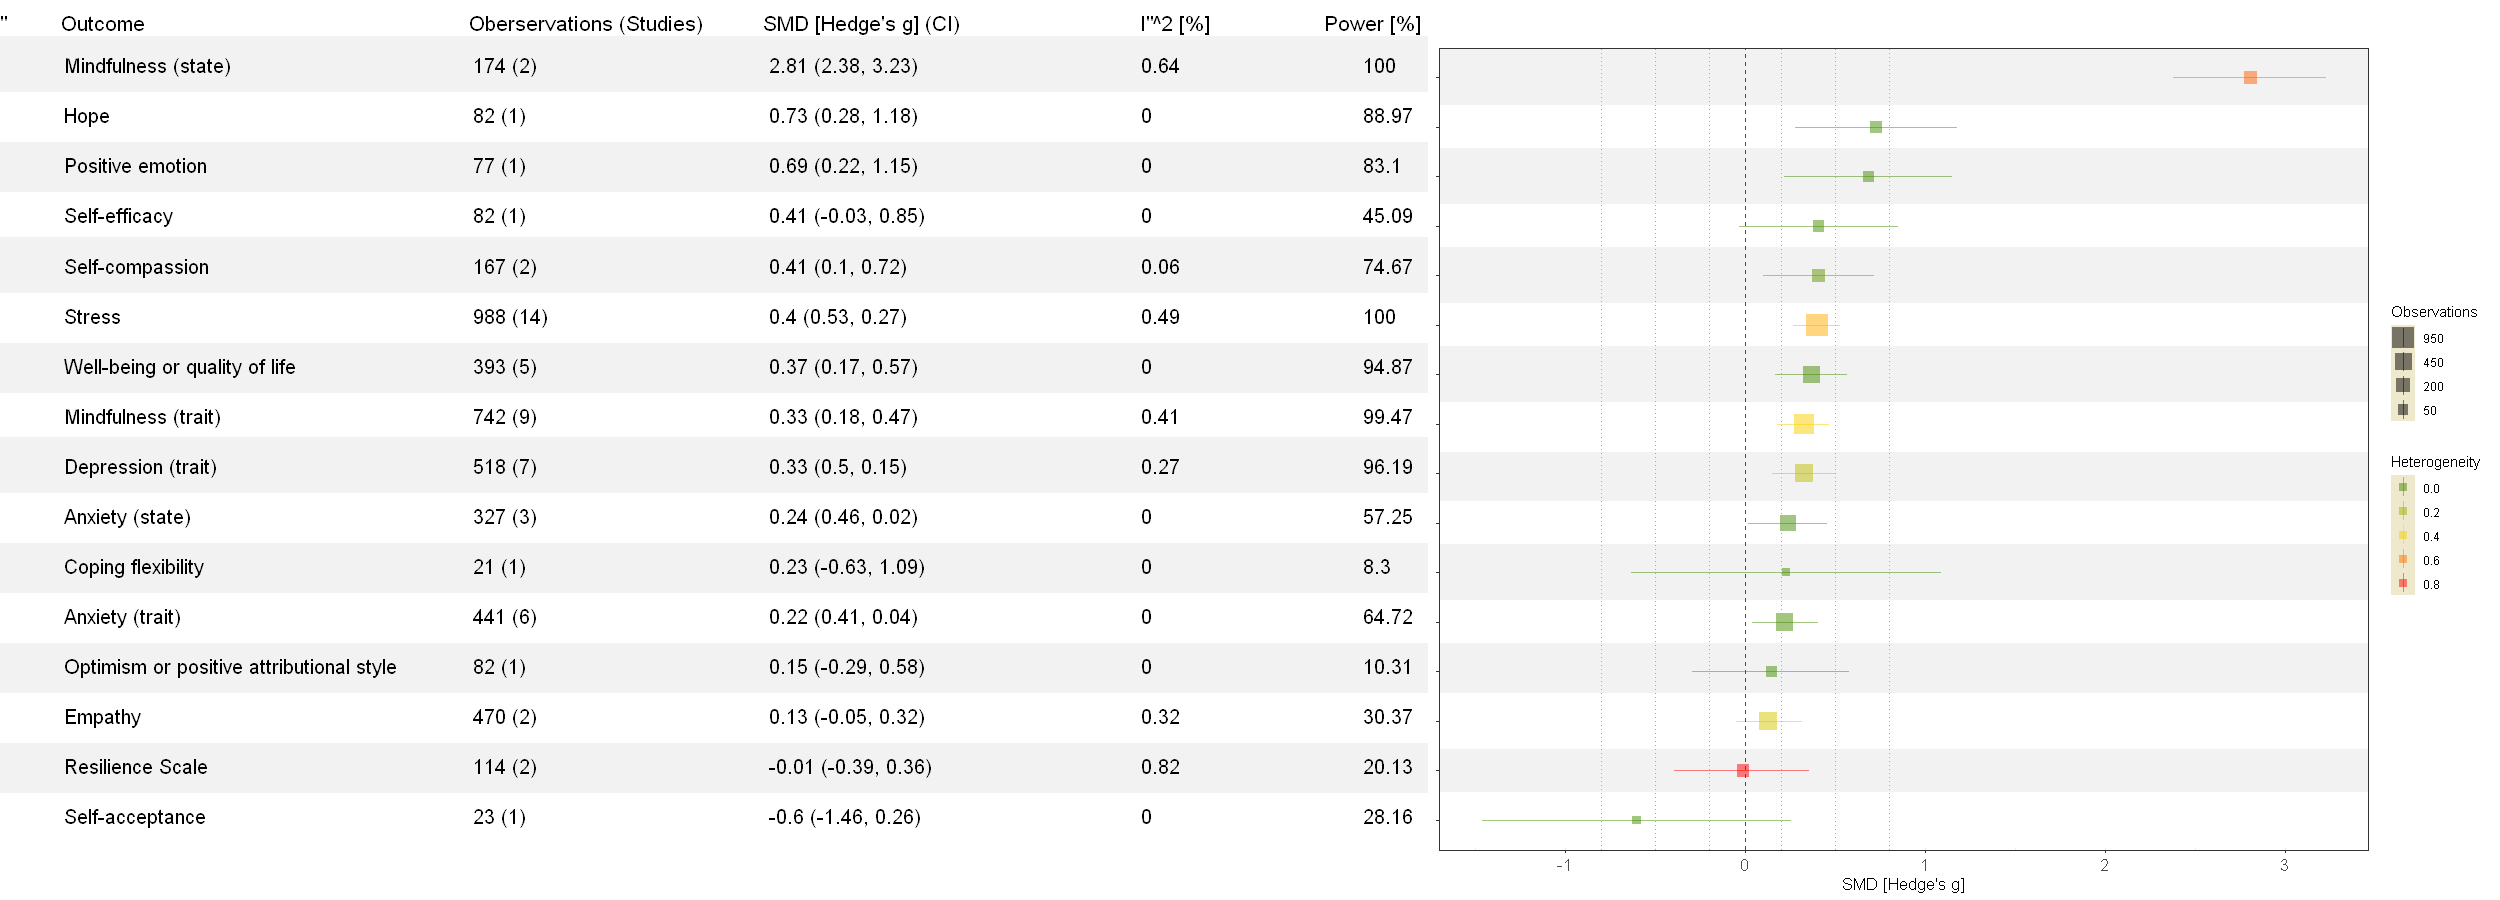

In [418]:
# forest plot
correct.color.order.forest <- c('white','white','white','gray95','white','gray95','white','gray95','white','gray95','gray95','gray95','gray95','gray95','white','white')

p <- ggplot(df.sum, aes(y = te, x = reorder(outcomes, te))) + 
  geom_vline(xintercept = outcomes, colour = correct.color.order.forest, size = 19) +
  geom_pointrange(
    aes(
      ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
    ),
    alpha = 0.5, shape = 15
  ) +
  coord_flip() +
  guides(colour = guide_legend(override.aes = list(size=0.5)), reverse=TRUE) +
  scale_colour_gradientn(colors = my_colors, name="Heterogeneity") + 
  scale_size_continuous(
    name = "Observations", range = c(0.5, 1.7),
    breaks = c(
      950, 450, 200, 50
    )
  ) +
  geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
  geom_hline(aes(yintercept=0.2), colour = 'darkgray', lty=3) +
  geom_hline(aes(yintercept=0.5), colour = 'darkgray', lty=3) +
  geom_hline(aes(yintercept=0.8), colour = 'darkgray', lty=3) +
  geom_hline(aes(yintercept=-0.2), colour = 'darkgray', lty=3) +
  geom_hline(aes(yintercept=-0.5), colour = 'darkgray', lty=3) +
  geom_hline(aes(yintercept=-0.8), colour = 'darkgray', lty=3) +
  theme_bw() +
  theme(
    legend.key=element_rect(fill='cornsilk2'),
    axis.text.y = element_blank(), axis.title.y = element_blank(),
    axis.text=element_text(size=12), #change font size of axis text
    axis.title=element_text(size=12), #change font size of axis titles
    plot.title=element_text(size=25)
  ) +
  ggtitle("") + ylab("SMD [Hedge's g]")

# table
font.size <- 5

data_table <- ggplot(data = df.sum, aes(y = reorder(outcomes, te))) +
  geom_hline(aes(yintercept = outcomes, colour = colour), size = 19) +

  geom_text(aes(x = 0, label = outcomes), hjust = 0, size = font.size) +
  geom_text(aes(x = 1, label = o.k), nudge_x = 0.1, hjust = 0, size = font.size) +
  geom_text(aes(x = 2, label = te.ci), hjust = 0, nudge_x = - 0.1, size = font.size) +
  geom_text(aes(x = 3, label = I2.trans), hjust = 0, nudge_x = - 0.1, size = font.size) +
  geom_text(aes(x = 4, label = pow), hjust = 0, nudge_x = - 0.5, size = font.size) +

  scale_colour_identity() +
  theme_void() +
  ggtitle(paste(expression("         Outcome                                                      Oberservations (Studies)          SMD [Hedge's g] (CI)                              I"^2), "[%]                   Power [%]")) +
  theme(
    plot.margin = margin(5, 0, 39, 0),
    plot.title=element_text(size=15)
  )

# combine plots
grid.arrange(
  data_table, p, ncol = 2,
  widths = c(4/7, 3/7)
)

# Risk of Bias Assessment

In [419]:
options(repr.plot.width = 5, repr.plot.height = 9, repr.plot.res = 100)

In [421]:
# install.packages("robvis")
library("robvis")

Installing package into 'C:/Users/anonymous/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

also installing the dependencies 'cpp11', 'tidyr'




package 'cpp11' successfully unpacked and MD5 sums checked
package 'tidyr' successfully unpacked and MD5 sums checked
package 'robvis' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\anonymous\AppData\Local\Temp\RtmpO40crd\downloaded_packages


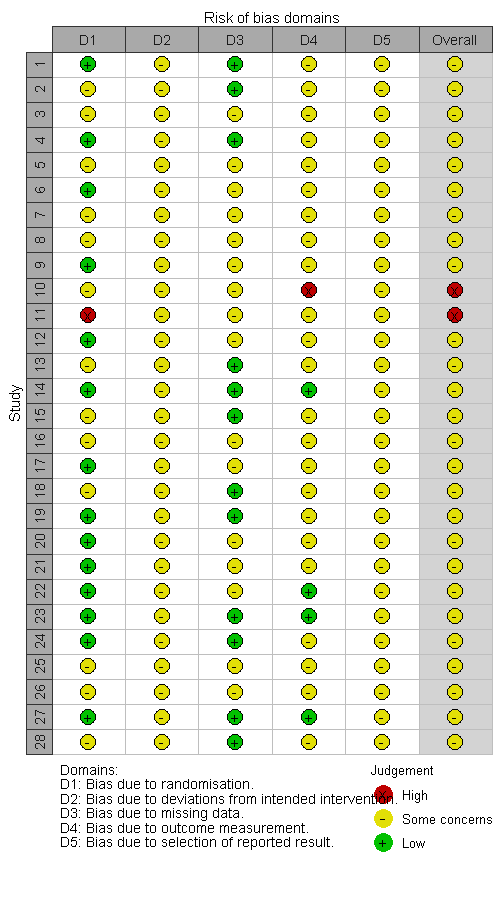

In [422]:
rob_traffic_light(
  data = rob.df,
  tool = "ROB2",
  psize = 5
)

# Old Code

In [ ]:
# # check if all entries (meditation techniques) are mentioned
# med.tech.missed <- FALSE
# for (intervention in 1:ncol(meditation.techniques.df)){
#   for (study in 1:nrow(meditation.techniques.df)){
#     if (
#       !is.na(meditation.techniques.df[study, intervention]) &
#       !(
#         meditation.techniques.df[study, intervention] %in% c(
#           "NA", nm.placeholder, as.character(nm.placeholder), "None", "No Intervention",
#           "Wait-List Control"
#         )
#       ) &
#       !(meditation.techniques.df[study, intervention] %in% meditation.type.all)
#     ){
#       cat(
#         study.names[study], "Intervention", intervention,
#         "| not in meditation.type.all:\n",
#         meditation.techniques.df[study, intervention], "\n\n"
#       )
#       med.tech.missed <- TRUE
#     }
#   }
# }

# if (!med.tech.missed){
#   cat("all meditation techniques mentioned")
# }

In [ ]:
# for (outcome in present.outcomes){
#   print(outcome)
#   if (outcome == "Stress"){
#     print.meta.results(
#       outcome, preferred.scale = "Depression Anxiety and Stress Scale (DASS)", regression = FALSE, print.regression.results =F, print.meta.results = F
#     )
    
#     print.meta.results(
#       outcome, preferred.scale = "Perceived Stress Scale (PSS)", regression = FALSE, print.regression.results =F, print.meta.results = F
#     )
#   } else {
#     print.meta.results(outcome, print.regression.results =F, print.meta.results = F)
#   }
    
#   cat("######################################################\n\n")
# }
# print("FINAAAL <3")

In [ ]:
# get.heterogeneity <- function(meta.results){
#   I2.found <- FALSE
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl("I\\^2", line) &
#       !grepl("%", substring(sub(".*I\\^2 = ", "", line), 1, 4)) &
#       is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4))))
#         # substring(sub(".*I\\^2 = ", "", line), 1, 4) returns 1st four characters after I^2
#     ){
#       # for values >= 10 % (e.g., "15.5" = 4 characters)
#       I2.found <- TRUE
#       return(
#         as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4))
#       )
#     } else if (
#       grepl("I\\^2", line) &
#       is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))))
#     ){
#       # for falues < 10 %
#       I2.found <- TRUE
#       return(
#         as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))
#       )
#     } else if (
#       grepl("I\\^2", line) &
#       !is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4)))) &
#       !is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))))
#     ){
#       cat(
#         "unknown heterogeneity values:", "\n",
#         substring(sub(".*I\\^2 = ", "", line), 1, 4), "\n\n"
#       )
#     }
#   }
#   if (!I2.found){
#     print("no heterogeneity found")
#   }
# }


In [ ]:
# # regression without weights being considered!!!!!!!!!!!!!!!!!
# plot.meta.regression <- function(regression.df, regression.factor){
#   ggplot(
#     # set axis
#     data=regression.df,
#     aes(
#       x = !!sym(regression.factor),  # !!sym() makes it possible to pass string as argument
#       y = hedges.g,
#       size = weights
#     )
#   ) +
  
#   # add scatter plot
#   geom_point(
#     alpha = .5,
#     colour = "blue"
#   ) +
  
#   # label points
#   geom_text(aes(
#     label=study.id,
#     hjust=1,
#     vjust=-0.8,
#     size=0.45
#   )) +
  
#   # add vertical paddings to ensure labels are displayed completely
#   scale_x_continuous(expand = expansion(mult = 0.2)) +
  
#   # add regression line with confidence interval
#   geom_smooth(
#     method = lm,
#     se = TRUE,
#     size = 1,
#     alpha = .15,
#     fill = "#33638DFF") +
  
#   # add dashed line on 0 effect level  
#   geom_hline(
#     yintercept=0,
#     linetype="dashed",
#     color = "red",
#     size =0.5
#   ) +
  
#   # hide legend
#   theme(
#     legend.position = "none"
#   )
# }

In [ ]:
# # regression without weights being considered!!!!!!!!!!!!!!!!!
# print(1)
# regs <- c("sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode")

# i <- 1
# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1


# print(2)

In [ ]:
# library('readxl')
# # import csv file into R
# # data <- read_excel('review_47966_20220515233722.xlsx')
# # write.csv(data, file = 'review_47966_20220515233722.csv')
# data <- read.csv('review_47966_20220515233722.csv')

# # create df of all Meditation 1 studies
# data.med1 =  data[data$Practiced.Techniques.in.Intervention.1 == 'Meditation 1', ] # select only rows with meditation 1 as intervetion 1


# # pooled.sd <- sqrt(((n1-1)*s1^2 + (n2-1)*s2^2) / (n1+n1-2))
# # mean.diff <- mean.1 - mean.2
# # cohens'd <- mean.diff/pooled.sd
# # calculate hedges g out of cohens d with hedges_g()

# # create df for meta analysis with Meditation 1
# library('esc')
# df.meta <- data.frame(
#   study.id =	data.med1[, 'Study.ID'],
#   number.meditation =	data.med1[, 'Sample.size.Intervention.1.T1'],  # number of participants in meditation condition
#   mean.meditation =	data.med1[, 'Intervention.1.Mean.T2'],
#   sd.meditation =	data.med1[, 'Intervention.1.SD.T2'],
#   number.control =	data.med1[, 'Sample.size.Intervention.2.T1'],
#   mean.conttrol	= data.med1[, 'Intervention.2.Mean.T2'],
#   sd.control	= data.med1[, 'Intervention.2.SD.T2'],
#   med.frequency = data.med1[, 'Frequency'],
#   pooled.sd = sqrt((data.med1[, 'Sample.size.Intervention.1.T1']-1)*data.med1[, 'Intervention.1.SD.T2']^2 + (data.med1[, 'Sample.size.Intervention.2.T1']-1)*data.med1[, 'Intervention.2.SD.T2']^2) / (data.med1[, 'Sample.size.Intervention.1.T1']+data.med1[, 'Sample.size.Intervention.1.T1']-2),
#   mean.diff.T2 = data.med1[, 'Intervention.1.Mean.T2']-data.med1[, 'Intervention.2.Mean.T2']
# )

# df.meta$hedges.g <- (df.meta[, "pooled.sd"] / df.meta[, "mean.diff.T2"])

# library('meta')
# res.df_meta =  metacont(number.meditation, mean.meditation, sd.meditation, 
#                         number.control, mean.conttrol, sd.control,
#                         fixed = T, random = T, studlab = study.id,
#                         data = df.meta, sm = "SMD")

# # plot forest plot
# forest(res.df_meta, leftcols = c('studlab'))

# # plot funnel plot
# funnel(res.df_meta)

# # metabias: Test for funnel plot asymmetry, based on rank correlation or linear regression method.
# metabias(res.df_meta, method.bias = 'linreg', k.min = , plotit = T)
# # The p-value is 0.973 which implies no publication bias. However, this meta-analysis contains k=5 studies. Egger’s test may lack the statistical power to detect bias when the number of studies is small (i.e., k<10).

# # conduct meta-regression, see: https://cjvanlissa.github.io/Doing-Meta-Analysis-in-R/plotting-regressions.html
# library('metafor')
# random.effects.model <- rma(
#   df.meta[, "hedges.g"],
#   df.meta[, "pooled.sd"]
# )
#   # second paramenter in rma-function = sampling variance = pooled standard deviation?

# install.packages('ggplot2')
# library(ggplot2)

# df.meta$weights <- 1/sqrt(df.meta$pooled.sd)
# # Specify basic plot, mapping med.frequency to the x-axis, effect size 'hedges.g' to the y-axis,
# # and 'weights' to the weight parameter.
# ggplot(df.meta, aes(x = med.frequency, y = hedges.g, size = weights)) +
#   geom_point(shape = 1) + # Add scatter
#   geom_abline(intercept = random.effects.model$b[1], slope = random.effects.model$b[2]) + # Add regression line
#   theme_bw() + # Apply black and white theme
#   theme(legend.position = "none") # Remove legend
#   # see link for beatiful meta-regression with convidence intervals: https://bookdown.org/robcrystalornelas/meta-analysis_of_ecological_data/meta-regression.html#meta-regression-with-continuous-variable

# # plot traffic light plot for RoB
# ## use {robvis} via the rob_traffic_light function
# ## see: https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/risk-of-bias-plots.html#traffic-light-plots

# # plot Summary Plots
# ## use use {robvis} via the rob_summary function

## meta.analyze, fill.meta.df(), 

In [ ]:
# # for meta.analyze without descr..reg.data.list
# fill.meta.df <- function(
#   scale, time.point, intervention.no, outcome.no, study,
#   m.data.list, nm.placeholder, int.per.study
#   ){
# # Descriptive Results
# ## for control group
#   if (intervention.no == 4){
#     for (i in 1:int.per.study){
#       # if n interventions are included, these refer to the control n times
#       study.id <<- append(
#         study.id,
#         m.data.list[["one.D.info.df"]][study,"Study.ID"]
#       )

#       n.control <<- append(
#         n.control,
#         results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#       )
#       mean.control <<- append(
#         mean.control,
#         results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#       )
#       sd.control <<- append(
#         sd.control,
#         results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#       )
#     }

# ## for intervention
#   } else {
#     # add descriptive results to respective vector
#     n.int <<- append(
#       n.int,
#       results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#     )
#     mean.int <<- append(
#       mean.int,
#       results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#     )
#     sd.int <<- append(
#       sd.int,
#       results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#     )

#     int.per.study <<- int.per.study + 1

# # Results for meta-regression
#     sessions.duration <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#     )

#     sessions.frequency <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#     )

#     programs.duration <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#     )

#     delivery.mode <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#     )
#   }
# }

In [ ]:
# # without fill.meta.df()
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
  
#   follow.up.period.t1.t2 <- c()
#   follow.up.period.t1.t3 <- c()

# ## create list of all meta data vectors to pass it to fill.meta.df()
#   # arrays or data frames are not used to be able to append values to vectors separately 
#   descr..reg.data.list.t1 <- list(
#     study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
#     sessions.duration, sessions.frequency, programs.duration, delivery.mode,
#     follow.up.period.t1.t2, follow.up.period.t1.t3
#   )
  
#   names(descr..reg.data.list.t1) <- c(
#     "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
#     "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
#     "follow.up.period.t1.t2", "follow.up.period.t1.t3"
#   )
  
#   descr..reg.data.list.t2 <- descr..reg.data.list.t1
  
#   descr..reg.data.list.t3 <- descr..reg.data.list.t1
  
#   descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

#   names(descr..reg.data.list) <- c("t1", "t2", "t3")
  
# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (time.point in 2:4){
#         for (scale in 1:2){
#           for (outcome.no in 1:7){
#             for (intervention.no in 1:4){
#               results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#               if (
#                 m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#                 !(
#                   is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                     as.character(nm.placeholder)
#                 ) &
#                 (
#                   m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                   ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#                 )
#               ){

#   # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#                 scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                   "Measures.Name"]
#                 if (multiple.commas.present(scale.name)){
#                   cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                   next
#                 } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                   if (scale == 1){
#                     scale.name.substring <- sub(",.*", "", scale.name)
#                       # extracts substring before comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                       next
#                     }
#                   } else if (scale == 2){
#                     scale.name.substring <- sub(".*,", "", scale.name)
#                       # extracts substring after comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       next
#                     }
#                   }
#                 }

#   # Descriptive Results
#   ## for control group
#                 if (intervention.no == 4){
#                   for (i in 1:int.per.study){
#                     # if n interventions are included, these refer to the control n times
#                     descr..reg.data.list[[time.point - 1]][["study.id"]] <- append(
#                       # time.point - 1 because descr..reg.data.list starts at t1
#                       descr..reg.data.list[[time.point - 1]][["study.id"]],
#                       m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                     )

#                     descr..reg.data.list[[time.point - 1]][["n.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["n.control"]],
#                       results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                     )
#                     descr..reg.data.list[[time.point - 1]][["mean.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["mean.control"]],
#                       results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                     )
#                     descr..reg.data.list[[time.point - 1]][["sd.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["sd.control"]],
#                       results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                     )
#                   }

#   ## for intervention
#                 } else {
#                   # add descriptive results to respective vector
#                   descr..reg.data.list[[time.point - 1]][["n.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["n.int"]],
#                     results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                   )
#                   descr..reg.data.list[[time.point - 1]][["mean.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["mean.int"]],
#                     results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                   )
#                   descr..reg.data.list[[time.point - 1]][["sd.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sd.int"]],
#                     results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                   )

#                   int.per.study <- int.per.study + 1

#   # Results for meta-regression
#                   descr..reg.data.list[[time.point - 1]][["sessions.duration"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sessions.duration"]],
#                     get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["sessions.frequency"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sessions.duration"]],
#                     get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["programs.duration"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["programs.duration"]],
#                     get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["delivery.mode"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["delivery.mode"]],
#                     get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#                   )
#                 }
#               }
#             }
#           }
#         }
#       }
#     }
#   }

#   meta.df.list <- list()
  
#   for (time.point in 1:3){  # here 1 is post-test
    
#     n.control <- descr..reg.data.list[[time.point]][["n.control"]]
#     mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
#     sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
#     n.int <- descr..reg.data.list[[time.point]][["n.int"]]
#     mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
#     sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

#     sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
#     sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
#     programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
#     delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]
    
#     pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#     mean.diff <- mean.int - mean.control
#     hedges.g <- mean.diff / pooled.sd 
#     weights <- 1/sqrt(pooled.sd)

#     # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#     if (length(sessions.frequency) == length(sessions.duration) + 1){
#       sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#     }
#     if (length(programs.duration) == length(sessions.duration) + 1){
#       programs.duration <- programs.duration[2:length(programs.duration)]
#     }
#     if (length(delivery.mode) == length(sessions.duration) + 1){
#       delivery.mode <- delivery.mode[2:length(delivery.mode)]
#     }
    
#     meta.df.list <- append(
#       meta.df.list,
#       list(data.frame(  # data frame as to be in a list to append it to a list
#         study.id = descr..reg.data.list[[time.point]][["study.id"]],
#         n.control = descr..reg.data.list[[time.point]][["n.control"]],
#         mean.control = descr..reg.data.list[[time.point]][["mean.control"]],
#         sd.control = descr..reg.data.list[[time.point]][["sd.control"]],
#         n.int = descr..reg.data.list[[time.point]][["n.int"]],
#         mean.int = descr..reg.data.list[[time.point]][["mean.int"]],
#         sd.int = descr..reg.data.list[[time.point]][["sd.int"]],
#         pooled.sd = pooled.sd,
#         mean.diff = mean.diff,
#         hedges.g = hedges.g,
#         weights = weights,
#         sessions.duration = descr..reg.data.list[[time.point]][["sessions.duration"]],
#         sessions.frequency = descr..reg.data.list[[time.point]][["sessions.frequency"]],
#         programs.duration = descr..reg.data.list[[time.point]][["programs.duration"]],
#         delivery.mode = descr..reg.data.list[[time.point]][["delivery.mode"]]
#       ))
      
#     # sort studies
#       if (sort.by == "hedges.g"){
#         meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], hedges.g)
#       } else if (sort.by == "name"){
#         meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], study.id)
#       } else if (sort.by != FALSE){
#         cat('\n\nsort by "hedges.g" or "name"\n\n')
#       }

#     # filter for studies for clustering
#       if (!FALSE %in% filter.forest..funnel.vec){
#         meta.df.list[[time.point]] <- meta.df.list[[time.point]][filter.forest..funnel.vec,]
#       }
#     )
#   }
  
#   names(meta.df.list) <- c("t1", "t2", "t3")
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df.list[[1]], sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df.list[[1]])
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df.list[[1]])
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df.list[[1]] %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df.list[[1]])
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df.list[[1]][, "hedges.g"])
#   }
# }


In [ ]:
# # without descr..reg.data.list
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, time.point, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <<- c()

# # Set Variables
# ## Descriptive Results
#   n.int <<- c()
#   n.control <<- c()
#   mean.int <<- c()
#   mean.control <<- c()
#   sd.int <<- c()
#   sd.control <<- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <<- c()
#   sessions.frequency <<- c()
#   programs.duration <<- c()
#   delivery.mode <<- c()
  
#   follow.up.period.t1.t2 <<- c()
#   follow.up.period.t1.t3 <<- c()

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <<- 0
#       for (scale in 1:2){
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#               )
#             ){

# # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#               scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                 "Measures.Name"]
#               if (multiple.commas.present(scale.name)){
#                 cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                 next
#               } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                 if (scale == 1){
#                   scale.name.substring <- sub(",.*", "", scale.name)
#                     # extracts substring before comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                     next
#                   }
#                 } else if (scale == 2){
#                   scale.name.substring <- sub(".*,", "", scale.name)
#                     # extracts substring after comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     next
#                   }
#                 }
#               }
#               fill.meta.df(
#                 scale, time.point, intervention.no, outcome.no, study,
#                 m.data.list, nm.placeholder, int.per.study
#               )
#             }
#           }
#         }
#       }
#     }
#   }

#   pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#   mean.diff <- mean.int - mean.control
#   hedges.g <- mean.diff / pooled.sd 
#   weights <- 1/sqrt(pooled.sd)
  
#   # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#   if (length(sessions.frequency) == length(sessions.duration) + 1){
#     sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#   }
#   if (length(programs.duration) == length(sessions.duration) + 1){
#     programs.duration <- programs.duration[2:length(programs.duration)]
#   }
#   if (length(delivery.mode) == length(sessions.duration) + 1){
#     delivery.mode <- delivery.mode[2:length(delivery.mode)]
#   }
  
#   meta.df <- data.frame(
#     study.id =	study.id,
#     n.control =	n.control,
#     mean.control =	mean.control,
#     sd.control =	sd.control,
#     n.int =	n.int,
#     mean.int	= mean.int,
#     sd.int	= sd.int,
#     pooled.sd = pooled.sd,
#     mean.diff = mean.diff,
#     hedges.g = hedges.g,
#     weights = weights,
#     sessions.duration = sessions.duration,
#     sessions.frequency = sessions.frequency,
#     programs.duration = programs.duration,
#     delivery.mode = delivery.mode
#   )

# # sort studies
#   if (sort.by == "hedges.g"){
#     meta.df <- arrange(meta.df, hedges.g)
#   } else if (sort.by == "name"){
#     meta.df <- arrange(meta.df, study.id)
#   } else if (sort.by != FALSE){
#     cat('\n\nsort by "hedges.g" or "name"\n\n')
#   }

# # filter for studies for clustering
#   if (!FALSE %in% filter.forest..funnel.vec){
#     meta.df <- meta.df[filter.forest..funnel.vec,]
#   }
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df, sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df)
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df)
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df)
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df[, "hedges.g"])
#   }
# }


In [ ]:
# # old working
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, time.point, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
  
#   follow.up.period.t1.t2 <- c()
#   follow.up.period.t1.t3 <- c()

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.frequency,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 programs.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 delivery.mode,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (scale in 1:2){
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#               )
#             ){

# # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#               scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                 "Measures.Name"]
#               if (multiple.commas.present(scale.name)){
#                 cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                 next
#               } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                 if (scale == 1){
#                   scale.name.substring <- sub(",.*", "", scale.name)
#                     # extracts substring before comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                     next
#                   }
#                 } else if (scale == 2){
#                   scale.name.substring <- sub(".*,", "", scale.name)
#                     # extracts substring after comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     next
#                   }
#                 }
#               }

# # Descriptive Results
# ## for control group
#               if (intervention.no == 4){
#                 for (i in 1:int.per.study){
#                   # if n interventions are included, these refer to the control n times
#                   study.id <- append(
#                     study.id,
#                     m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                   )
                  
#                   n.control <- append(
#                     n.control,
#                     results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                   )
#                   mean.control <- append(
#                     mean.control,
#                     results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                   )
#                   sd.control <- append(
#                     sd.control,
#                     results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                   )
#                 }
              
# ## for intervention
#               } else {
#                 # add descriptive results to respective vector
#                 n.int <- append(
#                   n.int,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                 )
#                 mean.int <- append(
#                   mean.int,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                 )
#                 sd.int <- append(
#                   sd.int,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                 )
                
#                 int.per.study <- int.per.study + 1
              
# # Results for meta-regression
#                 sessions.duration <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#                 )
                
#                 sessions.frequency <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#                 )
                
#                 programs.duration <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#                 )
                
#                 delivery.mode <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#                 )
#               }
#             }
#           }
#         }
#       }
#     }
#   }

#   pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#   mean.diff <- mean.int - mean.control
#   hedges.g <- mean.diff / pooled.sd 
#   weights <- 1/sqrt(pooled.sd)
  
#   # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#   if (length(sessions.frequency) == length(sessions.duration) + 1){
#     sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#   }
#   if (length(programs.duration) == length(sessions.duration) + 1){
#     programs.duration <- programs.duration[2:length(programs.duration)]
#   }
#   if (length(delivery.mode) == length(sessions.duration) + 1){
#     delivery.mode <- delivery.mode[2:length(delivery.mode)]
#   }
  
#   meta.df <- data.frame(
#     study.id =	study.id,
#     n.control =	n.control,
#     mean.control =	mean.control,
#     sd.control =	sd.control,
#     n.int =	n.int,
#     mean.int	= mean.int,
#     sd.int	= sd.int,
#     pooled.sd = pooled.sd,
#     mean.diff = mean.diff,
#     hedges.g = hedges.g,
#     weights = weights,
#     sessions.duration = sessions.duration,
#     sessions.frequency = sessions.frequency,
#     programs.duration = programs.duration,
#     delivery.mode = delivery.mode
#   )

# # sort studies
#   if (sort.by == "hedges.g"){
#     meta.df <- arrange(meta.df, hedges.g)
#   } else if (sort.by == "name"){
#     meta.df <- arrange(meta.df, study.id)
#   } else if (sort.by != FALSE){
#     cat('\n\nsort by "hedges.g" or "name"\n\n')
#   }

# # filter for studies for clustering
#   if (!FALSE %in% filter.forest..funnel.vec){
#     meta.df <- meta.df[filter.forest..funnel.vec,]
#   }
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df, sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df)
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df)
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df)
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df[, "hedges.g"])
#   }
# }


In [ ]:
# # for meta.analyze() without descr..reg.data.list
# print.meta.results <- function(
#   outcome,
#   moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration"),
#   preferred.scale = FALSE
# ){
#   meta.analyze(
#     outcome, meditation.type.all, m.data.list, time.point = 2, print.forest = TRUE,
#     print.funnel = TRUE,  preferred.scale = preferred.scale,  sort.by = "hedges.g",
#     print.descriptive = TRUE
#   )
#   for (moderator in moderator.vec){
    
#     regression.df <- meta.analyze(
#       outcome, meditation.type.all, m.data.list, time.point = 2, preferred.scale = preferred.scale,
#       moderator = moderator
#     )
    
#     results.regression <- get.funnel..regression.results(
#       regression.df, moderator = moderator
#     )

#     regplot(
#       results.regression,
#       refline=0,
#       # xlim = c(0,60), predlim = c(0,60),
#       label=TRUE
#     )

#     print(results.regression)
#   }
# }

### Get no of included studies from meta results

In [ ]:
# # returns values of meta.results after search.term from start to end as double
# get.studies.no <- function(meta.results){
#   k.found <- FALSE
#   search.term <- "Number of studies combined: k = "
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl(search.term, line) &
#       is.double(suppressWarnings(as.double(sub(sprintf(".*%s", search.term), "", line))))
#         # sub(sprintf(".*%s", search.term), "", line) returns characters after search.term
#     ){
#       k.found <- TRUE
#       return(
#         as.double(sub(sprintf(".*%s", search.term), "", line))
#       )
#       break
#     }
#   }
#   if (!k.found){
#     print("no k found")
#   }
# }


### Get effect size from meta results

In [ ]:
# # returns values of meta.results after search.term from start to end as double
# get.effect.size <- function(meta.results){
#   g.found <- FALSE
#   search.term <- "Random effects model "
#   start <- 1
#   end.1 <- 7
#   end.2 <- 6
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl(search.term, line) &
#       substring(sub(sprintf(".*%s", search.term), "", line), start, start) == "-" &
#       is.double(suppressWarnings(as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.1))))
#         # substring(sub(sprintf(".*%s", search.term), "", line), start, end.1) returns characters from start to end after search.term
#     ){
#       g.found <- TRUE
#       return(
#         as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.1))
#       )
#       break
#     } else if (
#       grepl(search.term, line) &
#       !substring(sub(sprintf(".*%s", search.term), "", line), start, start) == "-" &
#       is.double(suppressWarnings(as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.2))))
#     ){
#       g.found <- TRUE
#       return(
#         as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.2))
#       )
#       break
#     }
#   }
#   if (!g.found){
#     print("no effect size found")
#   }
# }


## Summary Plot

In [ ]:
# ###dataframe


# forestdf <- structure(list(labels = structure(1:36, .Label = c("Age*", "Sex – male vs. female", 
#                                                                "Body-mass index*,1 ", "Systolic blood pressure*", "Race - vs. white", 
#                                                                "Asian", "Black", "Townsend deprivation index", "Social habit", 
#                                                                "Smoking - vs. never", "Previous", "Current", "Alcohol use - vs. never", 
#                                                                "Once or twice a week", "Three or four times a week", "Daily or almost daily", 
#                                                                "Comorbidity", "Cancer", "Diabetes", "Chronic obstructive pulmonary disease2", 
#                                                                "Asthma", "Ischemic heart disease3", "Hypothyroidism", "Hypercholesterolemia", 
#                                                                "Allergic rhinitis", "Depression", "Serology", "White blood cell count", 
#                                                                "Red blood cell count", "Hemoglobin concentration", "Mean corpuscular volume", 
#                                                                "Mean corpuscular hemoglobin concentration", "Platelet count", 
#                                                                "Lymphocyte count", "Monocyte count", "Neutrophil count"), class = "factor"), 
#                            rr = c(1.18, 1.45, 1.76, 0.98, NA, 2.16, 2.65, 1.09, NA, 
#                                   NA, 1.35, 1.15, NA, 0.73, 0.63, 0.63, NA, 1.23, 1.34, 1.51, 
#                                   1.12, 1.46, 0.96, 1.1, 1.18, 1.38, NA, 1.03, 0.87, 0.93, 
#                                   1, 0.94, 1, 1.03, 1.17, 1.06), rrhigh = c(1.08, 1.28, 1.57, 
#                                                                             0.95, NA, 1.63, 2.03, 1.07, NA, NA, 1.18, 0.94, NA, 0.58, 
#                                                                             0.49, 0.5, NA, 0.99, 1.08, 1.09, 0.93, 1.15, 0.71, 0.92, 
#                                                                             0.91, 1.1, NA, 1.02, 0.73, 0.87, 0.99, 0.88, 1, 1.01, 1.03, 
#                                                                             1.01), rrlow = c(1.28, 1.64, 1.97, 1.02, NA, 2.86, 3.44, 
#                                                                                              1.11, NA, NA, 1.55, 1.42, NA, 0.9, 0.79, 0.81, NA, 1.53, 
#                                                                                              1.66, 2.09, 1.34, 1.85, 1.3, 1.31, 1.52, 1.74, NA, 1.04, 
#                                                                                              1.03, 0.98, 1.01, 1.01, 1, 1.05, 1.32, 1.1)), class = "data.frame", row.names = c(NA, 
#                                                                                                                                                                                -36L))


# forestdf$labels <- factor(forestdf$labels,levels = forestdf$labels)
# levels(forestdf$labels)

In [ ]:
# # summary fores plot without table
# ggplot(df.sum, aes(y = te, x = reorder(outcomes, te))) + 
#   geom_pointrange(
#     aes(
#       ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
#     ),
#     alpha = 0.5, shape = 15
#   ) +
#   coord_flip() +
#   guides(colour = guide_legend(override.aes = list(size=0.5)), reverse=TRUE) +
#   scale_colour_gradientn(colors = my_colors, name="Heterogeneity") + 
#   scale_size_continuous(
#     name = "Observations", range = c(0.5, 1.7),
#     breaks = c(
#       950, 500, 50
#     )
#   ) +
#   geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
#   theme_bw() +
#   theme(legend.key=element_rect(fill='cornsilk2')) +
#   ylab("Hedge's g") + xlab('Outcome') + ggtitle('Summary Forest Plot')

In [ ]:
# #

# fplottable <- structure(list(labels = structure(c(1L, 30L, 7L, 33L, 27L, 4L, 
# 6L, 35L, 32L, 31L, 26L, 11L, 2L, 24L, 34L, 12L, 10L, 8L, 14L, 
# 9L, 5L, 18L, 17L, 16L, 3L, 13L, 29L, 36L, 28L, 15L, 21L, 20L, 
# 25L, 19L, 22L, 23L), .Label = c("Age*", "Alcohol use - vs. never", 
# "Allergic rhinitis", "Asian", "Asthma", "Black", "Body-mass index*,1 ", 
# "Cancer", "Chronic obstructive pulmonary disease2", "Comorbidity", 
# "Current", "Daily or almost daily", "Depression", "Diabetes", 
# "Hemoglobin concentration", "Hypercholesterolemia", "Hypothyroidism", 
# "Ischemic heart disease3", "Lymphocyte count", "Mean corpuscular hemoglobin concentration", 
# "Mean corpuscular volume", "Monocyte count", "Neutrophil count", 
# "Once or twice a week", "Platelet count", "Previous", "Race - vs. white", 
# "Red blood cell count", "Serology", "Sex – male vs. female", 
# "Smoking - vs. never", "Social habit", "Systolic blood pressure*", 
# "Three or four times a week", "Townsend deprivation index", "White blood cell count"
# ), class = "factor"), No..of.Events = c(1073L, 581L, 1061L, 1031L, 
# NA, 57L, 68L, 1072L, NA, NA, 442L, 117L, NA, 262L, 191L, 172L, 
# NA, 96L, 107L, 41L, 146L, 86L, 52L, 170L, 66L, 84L, NA, 1009L, 
# 1009L, 1009L, 1009L, 1009L, 1009L, 1005L, 1005L, 1005L), ARR..95..CI. = c("1.18 (1.08-1.28)", 
# "1.45 (1.28-1.64)", "1.76 (1.57-1.97)", "0.98 (0.95-1.02)", "", 
# "2.16 (1.63-2.86)", "2.65 (2.03-3.44)", "1.09 (1.07-1.11)", "", 
# "", "1.35 (1.18-1.55)", "1.15 (0.94-1.42)", "", "0.73 (0.58-0.90)", 
# "0.63 (0.49-0.79)", "0.63 (0.50-0.81)", "", "1.23 (0.99-1.53)", 
# "1.34 (1.08-1.66)", "1.51 (1.09-2.09)", "1.12 (0.93-1.34)", "1.46 (1.15-1.85)", 
# "0.96 (0.71-1.30)", "1.10 (0.92-1.31)", "1.18 (0.91-1.52)", "1.38 (1.10-1.74)", 
# "", "1.03 (1.02-1.04)", "0.87 (0.73-1.03)", "0.93 (0.87-0.98)", 
# "1.00 (0.99-1.01)", "0.94 (0.88-1.01)", "1.00 (1.00-1.00)", "1.03 (1.01-1.05)", 
# "1.17 (1.03-1.32)", "1.06 (1.01-1.10)")), class = "data.frame", row.names = c(NA, 
# -36L))

In [ ]:
# forestdf$colour <- rep(c("white", "gray95"), 18)
# p <- ggplot(forestdf, aes(x = rr, y = labels, xmin = rrlow, xmax = rrhigh)) +
#   geom_hline(aes(yintercept = labels, colour = colour), size = 7) + 
#   geom_pointrange(shape = 22, fill = "black") +
#   geom_vline(xintercept = 1, linetype = 3) +
#   xlab("Variable") +
#   ylab("Adjusted Relative Risk with 95% Confidence Interval") +
#   theme_classic() +
#   scale_colour_identity() +
#   scale_y_discrete(limits = rev(forestdf$labels)) +
#   scale_x_log10(limits = c(0.25, 4), 
#                 breaks = c(0.25, 0.5, 1, 2, 4), 
#                 labels = c("0.25", "0.5", "1", "2", "4"), expand = c(0,0)) +
#   theme(axis.text.y = element_blank(), axis.title.y = element_blank())

# names(fplottable) <- c("labels", "eventnum", "arr")
# fplottable$labels <- factor(fplottable$labels, rev(levels(forestdf$labels)))
# fplottable$colour <- rep(c("white", "gray95"), 18)

# data_table <- ggplot(data = fplottable, aes(y = labels)) +
#   geom_hline(aes(yintercept = labels, colour = colour), size = 7) +
#   geom_text(aes(x = 0, label = labels), hjust = 0) +
#   geom_text(aes(x = 5, label = eventnum)) +
#   geom_text(aes(x = 7, label = arr), hjust = 1) +
#   scale_colour_identity() +
#   theme_void() + 
#   theme(plot.margin = margin(5, 0, 35, 0))

# grid.arrange(data_table,p, ncol = 2)

## Calculate age and sex values

In [ ]:
# get overall mean age of T1 (post-test)
age.overall.t1 <- NA
for (study in 1:study.no){
  
  # get over all mean age T1
  if (
    !is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) &
    population.characteristics.array["Mean.Age", "Over.All", "T1", study] != nm.placeholder
  ){
    age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T1", study]
  
  # if over all mean age T1 is NA, over all mean age T0 is over all mean age T1
  } else if (
    !is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) &
    population.characteristics.array["Mean.Age", "Over.All", "T0", study] != nm.placeholder
  ){
    age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T0", study]
   
  # if over all mean age at T1 and T0 is NA, calculate over all mean age from mean of groups
  } else if (
    (
      is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) |
      population.characteristics.array["Mean.Age", "Over.All", "T1", study] == nm.placeholder
    ) &
    (
      is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) |
      population.characteristics.array["Mean.Age", "Over.All", "T0", study] == nm.placeholder
    )
  ){
    
    no.participants.vec <- c()
    mean.age.vec <- c()
    t.range <- c(1,0)
    for (intervention in 1:4){
      for (t in t.range){
        
        try(
          if (!(
                is.na(population.characteristics.array["Mean.Age", intervention, t, study]) |
                (population.characteristics.array["Mean.Age", intervention, t, study] %in% nm.placeholder) |
                is.na(population.characteristics.array["No.Participants", intervention, t, study]) |
                (population.characteristics.array["No.Participants", intervention, t, study] %in% nm.placeholder)
          )){

            no.participants.vec <- append(
              no.participants.vec,
              population.characteristics.array["No.Participants", intervention, t, study]
            )

            mean.age.vec <- append(
              mean.age.vec,
              population.characteristics.array["Mean.Age", intervention, t, study]
            )
            break  # do not add values of T0 if values of T1 are present
          },
          silent=TRUE
        )
      }
    }
    
    mean.age.x.n.vec <- c()
    
    if (length(no.participants.vec) != length(mean.age.vec)){
      cat(
        "\n\nERROR#1: length of no.participants.vec and mean.age.vec are not equal in:",
        "\n", study.names[study], "| Intervention", intervention, "| T", t, "\n\n"
      )
    }
    
    if (length(no.participants.vec) > 0){
      mean.age.x.n.vec <- mean.age.vec * no.participants.vec
      age.overall.t1 <- sum(mean.age.x.n.vec) / sum(no.participants.vec)
    }
  } else {
      print("ERROR#2: unknown case")
  }
  population.characteristics.array["Mean.Age", "Over.All", "T1", study] <- age.overall.t1
}

In [ ]:
for (study in 1:study.no){
  if (
    !TRUE %in%
    c(
      population.characteristics.array[
        c("No.Females", "No.Males", "No.Participants"),
        "Over.All", "T1", study
      ] %in%
      c(NA, nm.placeholder)
    )
  ){
    population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
      population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study] /
      rep(population.characteristics.array["No.Participants", "Over.All", "T1", study], 2) * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
      100 -
      sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study]) /
      population.characteristics.array["No.Participants", "Over.All", "T1", study] * 100,
      digits = 2
    )
    
  } else if (
    !TRUE %in%
    c(
      population.characteristics.array[
        c("No.Females", "No.Males", "No.Participants"),
        "Over.All", "T0", study
      ] %in%
      c(NA, nm.placeholder)
    )
  ){
    population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
      population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study] /
      rep(population.characteristics.array["No.Participants", "Over.All", "T0", study], 2) * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
      100 -
      sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study]) /
      population.characteristics.array["No.Participants", "Over.All", "T0", study] * 100,
      digits = 2
    )
  } else (
    cat("\nnot enough sex data in study:", study.names[study])
  )
}

In [ ]:
# calculate Sex.Percent for T1 (post-test) of studies in which sex values are present at T1
population.characteristics.array["Sex.Percent", "Over.All", "T1",] <- round(
  as.vector(population.characteristics.array["No.Females", "Over.All", "T1",]) /
  as.vector(population.characteristics.array["No.Participants", "Over.All", "T1",]),
  digits = 2
)

# calculate Sex.Percent for T1 (post-test) out of T0 of studies in which sex values are not present at T1
na.val.vec <- as.vector(which(
  is.na(population.characteristics.array["Sex.Percent", "Over.All", "T1",])
))

population.characteristics.array["Sex.Percent", "Over.All", "T1", na.val.vec] <- round(
  as.vector(population.characteristics.array["No.Females", "Over.All", "T0", na.val.vec]) /
  as.vector(population.characteristics.array["No.Participants", "Over.All", "T0", na.val.vec]),
  digits = 2
)

## set negative values (occured due to nm.placeholder = -999) to NA
nm.val.vec <- as.vector(which(
  population.characteristics.array["Sex.Percent", "Over.All", "T1",] < 0
))

population.characteristics.array["Sex.Percent", "Over.All", "T1", na.val.vec] <- NA

# Notes
- Different Scales
    - 2 Array-Dims with same values
    - Results in Dim "Scale.2" only if 2nd scale is present, else: NA

- Ignore 2nd scale entry for Sloan 2016 

# ToDo
- calulate age und sex means

- add label.right and label.left to forest (something like "more resilient" & "less resilient" or "more healthy" & "less healthy" below the effect size's scale)

- interpret abbreviations nsts or ntc of notes --> check if scales in this studies really measure the trait or the state outcome

- check why regression does not work for outcome == "Well-being or quality of life" & subgroup == "delivery.mode"

- check last scale directions that does not have a source

- learn to interpret regression results

- qualitative ergebnisse auswerten?

- double check Evidence of Effectiveness in Study Characteristics Table with key.authors conclusion of one.D.info.df